## Описание проекта

Клиент собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Клиент поставил задачу чтобы метрика *RMSE* на тестовой выборке была не больше 48.


**Ниже представлены только удачные результаты исследования данных. В часности размер лага подбирался опытным путем и здесь представлн наилучший вариант** 


## Подготовка

In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings; warnings.filterwarnings("ignore", category=Warning)

In [3]:
# !pip install lightgbm

In [4]:
# !pip install xgboost

In [5]:
#Импортируем библиотеки для работы с данными
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy
import seaborn as sns

# Импортируем баблиотеки машинного обучения
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_score
from timeit import default_timer as timer
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Временные ряды
from statsmodels.tsa.seasonal import seasonal_decompose

### Закгрузка дынных

In [6]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv')
except:
    print('Файл будет загружен из сети.')
    taxi = pd.read_csv('.../datasets/taxi.csv')
    
taxi_raw = taxi
# На всякий случай сырой датафрейм

Файл будет загружен из сети.


In [7]:
display(taxi)
print('Полных дубликатов - ', taxi.duplicated().sum())

datetime  num_orders
0      2018-03-01 00:00:00           9
1      2018-03-01 00:10:00          14
2      2018-03-01 00:20:00          28
3      2018-03-01 00:30:00          20
4      2018-03-01 00:40:00          32
...                    ...         ...
26491  2018-08-31 23:10:00          32
26492  2018-08-31 23:20:00          24
26493  2018-08-31 23:30:00          27
26494  2018-08-31 23:40:00          39
26495  2018-08-31 23:50:00          53

[26496 rows x 2 columns]

Полных дубликатов -  0


In [8]:
taxi.describe()

num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

In [9]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**У столбца с временем тип - object, а нам нужен столбец с типом datetime. Поменем тип данных с толбце**

In [10]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


### Анализ данных

In [11]:
sns.set(rc={'figure.figsize': (14, 5)})
sns.set_style('whitegrid')

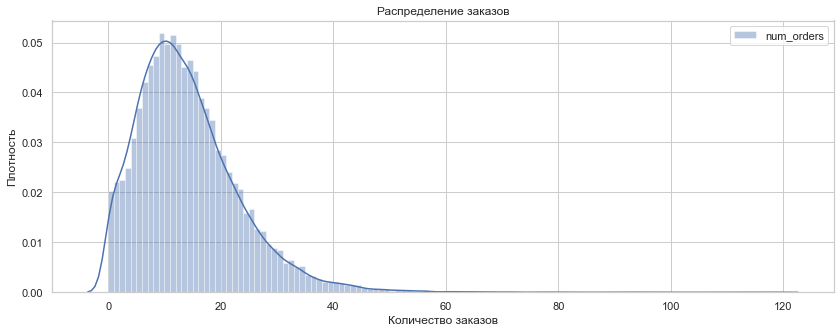

In [12]:
sns.distplot(taxi['num_orders'], label = 'num_orders', bins=119)

plt.xlabel('Количество заказов')
plt.ylabel('Плотность')
plt.title('Распределение заказов')
plt.legend()
plt.show()

Распределение ассиметричное вправо и имеет длинный хвост в положительных значениях

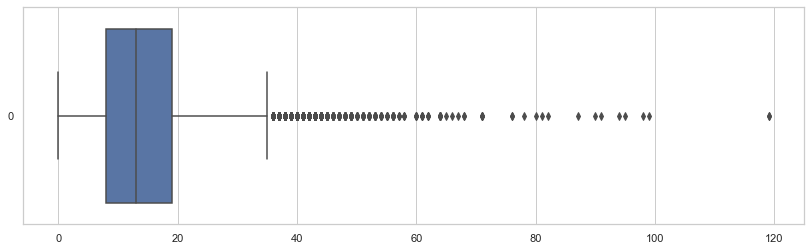

In [13]:
plt.figure(figsize=(14,4))
sns.boxplot(data=taxi['num_orders'], orient='h')
plt.show()

### Ресемплирование

Для начала сделаем столбец с датой и временем - индексом

In [14]:
taxi = taxi.set_index('datetime')

Теперь проверим, в хронологическом ли порядке расположены даты и время. 

In [15]:
taxi = taxi.sort_index()
print(taxi.index.is_monotonic)
print()
print(taxi.info())
# taxi

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Все хорошо, данные идут в хронологическом порядке. 
И построим график временного ряда.

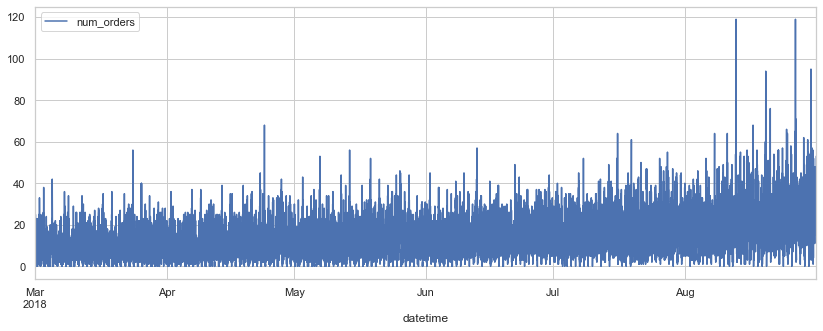

In [16]:
taxi.plot()
plt.show()

Выглядит неочень информативно. Доработаем данные.

Также можем смотреть отдельно график по месяцу, чтобы был понятен уровень заказов в этот период. 

In [17]:
taxi = taxi.resample('1H').sum().sort_index()

taxi.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

## Анализ фичей

Добавим в наш датафрейм новые признаки:
1. Скользящее среднее
2. Отстающие значения (они подскажут, будет ли функция x(t) расти или уменьшаться)
3. скользящее стандартное отклонение
4. Столбцы с: днем недели, месяцем, номером недели, днем месяца, часом, и является ли ден выходным или нет

In [18]:
def make_features(df, target="num_orders", rolling_mean_size=24):
    data = df.copy()
    data['rolling_mean'] = data[target].shift().rolling(rolling_mean_size).mean()
    for lag in [1, 2, 3, 24, 48, 72, 96, 120, 144, 168]:
        data["lag_{}".format(lag)] = data[target].shift(lag) #, fill_value=0)
    data['std'] = data.num_orders.rolling(15).std()
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['week'] = data.index.week
    data['dayofmonth'] = data.index.day
    data['hour'] = data.index.hour
    data['is_weekend'] = data.dayofweek.isin([5,6])*1
    data = data.dropna()
    return data

In [19]:
taxi = make_features(taxi)
# taxi.info()

Для начала посмотрим на один ммесц чтобы оценить есть ли там какая-то информация

In [20]:
taxi_month = taxi['2018-06-01':'2018-06-30']

Добавим столбец rolling_mean со скользящим средним.

In [21]:
# taxi_month[['num_orders', 'rolling_mean']].plot()
# plt.show()

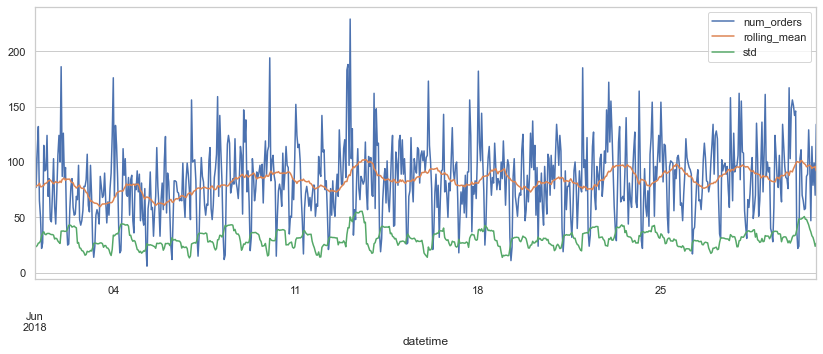

In [22]:
taxi_month[['num_orders', 'rolling_mean', 'std']].plot()
plt.show()

Так же можем посмотреть на тренды и сезонность. для этого используем библиотеку statsmodels  и функцию seasonal_decompose. Она разложит временной ряд на три составляющие: тренд, сезонность и остаток. 

In [23]:
decomposed = seasonal_decompose(taxi.num_orders) 

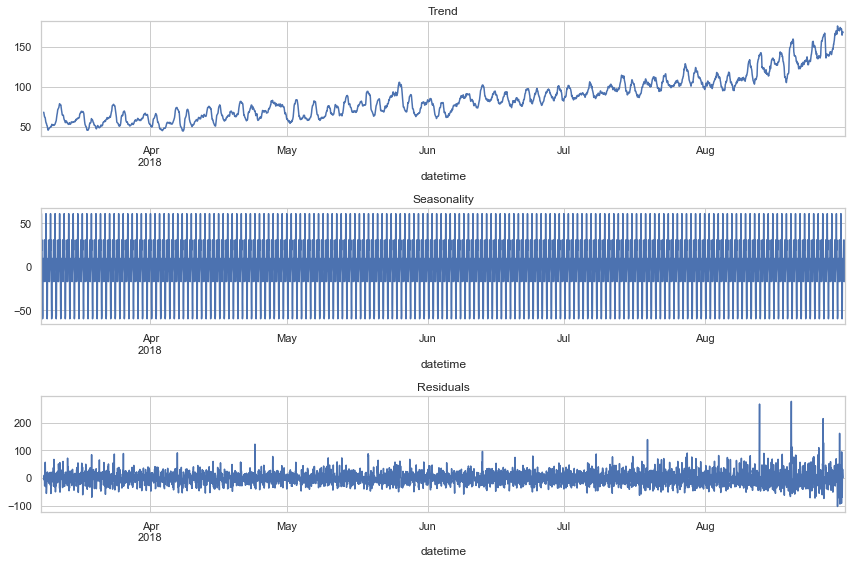

In [24]:
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Как видно есть тренд к увеличению цены с весны к лету. 
Сезонность тоже есть, но нужно брать меньший временной период чтобы понять какая она. 
И шум который не объясним.

Посмотрим на сезонность взям маленький отрезок времени. Например неделю.

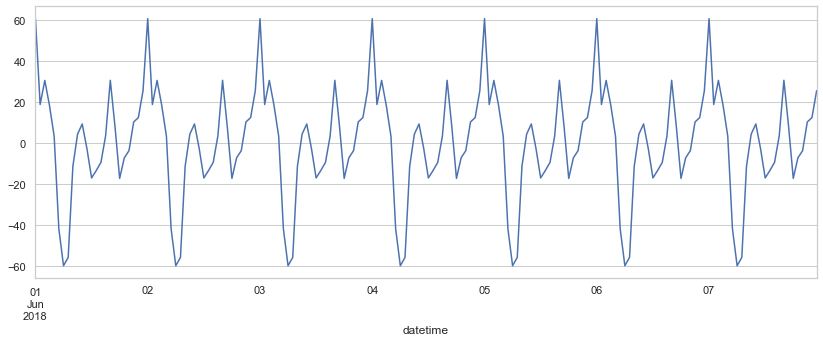

In [25]:
decomposed.seasonal['2018-06-01':'2018-06-7'].plot()
plt.show()

На неделе мы видим явную сезоннсть и это означает что в разное время спрос на такси разный. 

Посмотрим, есть ли тренд или сезонность в течении месяца, недели и дня. 

In [26]:
def decomposed_plots_month(df, target='num_orders'):
    plt.figure(figsize=(12, 4))
    plt.subplot(211)
    seasonal_decompose(df.resample('1D').sum().loc[:, target]).trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(212)
    
    seasonal_decompose(df.resample('1D').sum().loc[:, target]).seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')

    
def decomposed_plots(df, target='num_orders'):
    plt.figure(figsize=(12, 4))
    plt.subplot(211)
    seasonal_decompose(df.loc[:, target]).trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(212)
    
    seasonal_decompose(df.loc[:, target]).seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')

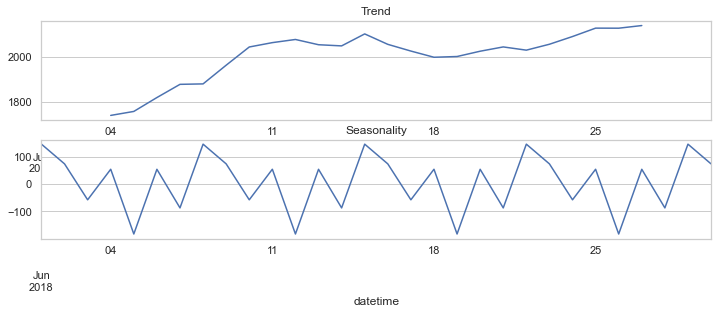

In [27]:
decomposed_plots_month(taxi['2018-06-01':'2018-06-30'])

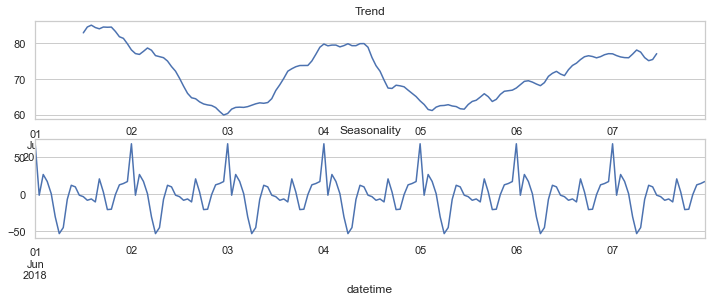

In [28]:
decomposed_plots(taxi['2018-06-01':'2018-06-7'])

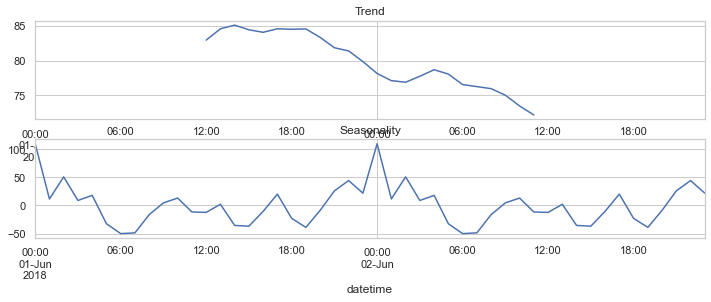

In [29]:
decomposed_plots(taxi['2018-06-01':'2018-06-2'])

Исходя из всех полученных данных нам нужно решить какие в итоге фичи мы оставляем для обучения нашей модели. На всякий случай напомню задание:
**сделать можель которая будет привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.**

Требуемые фичи:
- Год. Получается что у нас есть общий тренд по году и стомость все время растет. Но год мы точно не будем делать фичей т.к. у нас даже нет столько данных

- Месяц. У нас по графика нет сезонности по месяцам, поэтому не вижу смысла оставлять фичу месяц. 

- День недели/месяца. Мы анализировали весь датасет и заметили что по всем данным и поданным за месяц сезонность наблюдается. И как мне кажется она больше всего выражена на выходных. Поэтому день недели оставляем, а пот день в месяце нет.

- Час. Определенной да т.к. в течении дня прослеживается и тренд и сезонность.

- Lag. Параметр учитывает влияние вчерашних событий на сегодняшние. Думаю его нужно оставить.

- Rolling_mean. Сем больше этот параметр (размер окна). тем рочнее линия тренда. Также оставим этот параметр. 


## Обучение

### Подготовка данных

Для начала определим наш тартет и признаки (фичи). Таргет у нас - столбец "num_orders"
Фичи как мы обсуждали выше берем не все которые у нас есть. 
Удлаемя столбец "month"

In [30]:
random_state = 42 

In [31]:
X = taxi.drop(['num_orders', 'month'], axis=1)
y =taxi['num_orders']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)

In [33]:
# Провермяем идут ли данные друг за другом. Мы ведь не можем заглянуть в дубущее) 
# Поэтому добавляли при разделении датасетов аргумент shuffle=False

for i in (X_train, y_train, X_test, y_test):
    print(i.index.min(), i.index.max())
    print(i.shape)
#     print(i.name)
    print('===========================================')

2018-03-08 00:00:00 2018-08-14 06:00:00
(3823, 17)
2018-03-08 00:00:00 2018-08-14 06:00:00
(3823,)
2018-08-14 07:00:00 2018-08-31 23:00:00
(425, 17)
2018-08-14 07:00:00 2018-08-31 23:00:00
(425,)


### Линейная регрессия

In [34]:
results_final = pd.DataFrame(index=['RMSE на обучающей выборке',
                                        'RMSE на тестовой выборке', 
                                       'MAE обучающей выборки', 
                                       'MAE тестовой выборки'])

In [35]:
model = LinearRegression()
def LinearRegression_scores(X_train, y_train, X_test, y_test, model_name):
    """Функция принимает валидационную или тестовую выборку и высодит MAE, MSE и RMSE на обучающей и новой выборке"""
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    MSE_train=mean_squared_error(y_train, pred_train)
    RMSE_train=mean_squared_error(y_train, pred_train)**.5

    pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    MSE_test=mean_squared_error(y_test, pred_test)
    RMSE_test=mean_squared_error(y_test, pred_test)**.5
              
    results_final[model_name] = [RMSE_train, RMSE_test, MSE_train, MSE_test]   
    return results_final



In [36]:
# Обучающая + валидационная выборки
LinearRegression_scores(X_train, y_train, X_test, y_test, 'LR')

LR
RMSE на обучающей выборке    21.108167
RMSE на тестовой выборке     33.851552
MAE обучающей выборки       445.554729
MAE тестовой выборки       1145.927561

**Попробуем убрать некоторое количество фичей**

Например оставим остающие значения длинной в неделю (7 дней) 

In [37]:
X_train_cut = X_train.drop(['is_weekend', 'week'], axis=1)
X_test_cut = X_test.drop(['is_weekend', 'week'], axis=1)

In [38]:
# Обучающая + тестовая выборки
LinearRegression_scores(X_train_cut, y_train, X_test_cut, y_test, 'LR меньше фичей')

LR  LR меньше фичей
RMSE на обучающей выборке    21.108167        21.164227
RMSE на тестовой выборке     33.851552        33.739474
MAE обучающей выборки       445.554729       447.924504
MAE тестовой выборки       1145.927561      1138.352120

In [41]:
X_train = X_train_cut
X_test = X_test_cut

### Другие модели

In [42]:
# Расчет RMSE
def rmse_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**.5

In [43]:
# Задаем нуоходимый нам метод оценки
rmse_scorer = make_scorer(rmse_error, greater_is_better=False)

In [44]:
# Для того чтобы выборки не брались из будущего
tscv = TimeSeriesSplit()

In [45]:
# Измерение скорости обучения

def fit_time(model):
    # скорость обучения
    start = timer()
    model.fit(X_train, y_train)
    end = timer()
    fit_time = str(timedelta(seconds= end - start))
    return fit_time

def predict_time(model):
    # скорость предсказаний
    start = timer()
    test_preds =  model.predict(X_test)
    end = timer()
    predict_time = str(timedelta(seconds=end - start))
    return predict_time

In [46]:
# Датафрейм для результатов
results = pd.DataFrame(index=['Среднее RMSE после кросс-валидации', 
                              'RMSE без кросс-валидации', 
                              'скорость обучения', 
                              'скорость прогноза'])

In [47]:
# составим список из моделей которые мы собираемся сравнить
models = ['model_CB', 'model_LGMB', 'model_XGBR', 'model_GB', 'RandomForest']

regressions = [
    CatBoostRegressor(random_state=random_state, verbose = False),
    LGBMRegressor(random_state=random_state),
    XGBRegressor(random_state=random_state, objective='reg:squarederror'),
    GradientBoostingRegressor(random_state=random_state, verbose = False),
    RandomForestRegressor(random_state=random_state)
    ]

In [48]:
%%time
# оценка всех моделей по кросс-валидации
for regressor, name in zip(regressions, models):
    
    baseline_res = cross_validate(regressor, X_train, y_train, cv=tscv, scoring=rmse_scorer, 
                                  return_train_score=True)
    
    RMSE = mean_squared_error(y_test, regressor.fit(X_train, y_train).predict(X_test)) # разница с кросс-валидацией
    
    print(regressor)
    print('_______________________________')

    results[name] = [
                    baseline_res['train_score'].mean().round(2),
                    (np.sqrt(RMSE)).round(2),
                     fit_time(regressor),      # продолжительность обучения
                     predict_time(regressor)   # продолжительность предсказания
                     
    ]

results

_______________________________
LGBMRegressor(random_state=42)
_______________________________
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
_______________________________
GradientBoostingRegressor(random_state=42, verbose=False)
_______________________________
RandomForestRegressor(random_state=42)
_______________________________
Wall time: 51.9 s


model_CB      model_LGMB  \
Среднее RMSE после кросс-валидации           -6.99           -7.49   
RMSE без кросс-валидации                     38.27           36.94   
скорость обучения                   0:00:05.019541  0:00:00.234917   
скорость прогноза                   0:00:00.002515  0:00:00.004976   

                                        model_XGBR        model_GB  \
Среднее RMSE после кросс-валидации           -2.02          -13.52   
RMSE без кросс-валидации                     41.96           39.37   
скорость обучения                   0:00:00.694177  0:00:00.981227   
скорость прогноза                   0:00:00.004552  0:00:00.001995   

                                      RandomForest  
Среднее RMSE после кросс-валидации            -6.8  
RMSE без кросс-валидации                     39.41  
скорость обучения                   0:00:03.553161  
скорость прогноза                   0:00:00.023846

# 4. Тестирование

проверим на тестовых данных модели:
- XGBR
- Catboost
- RandomForest
- LGMB


### XGBR

In [49]:
# model_XGBR_final = XGBRegressor(random_state=random_state, objective='reg:squarederror')

In [50]:
xgbr_params = {  
    "learning_rate": [0.001, 0.01, 0.1],
    "max_depth":[5, 10, 20, 50],
    'reg_alpha': [1.1, 1.2, 1.3, 1.5],
    'reg_lambda': [1.1, 1.2, 1.3, 1.5]}

In [51]:
%%time
clf_XGBR = XGBRegressor(random_state=random_state, objective='reg:squarederror')
xgbr = GridSearchCV(clf_XGBR, xgbr_params, verbose=1, cv=tscv, scoring=rmse_scorer)
xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Wall time: 12min 48s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=...
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
           

In [52]:
xgbr_best_params = xgbr.best_params_
xgbr_best_params

{'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 1.5, 'reg_lambda': 1.1}

In [53]:
xgbr.best_score_

-21.813360640997356

In [54]:
%%time
XGBR_final = XGBRegressor(random_state=random_state, **xgbr_best_params)

XGBR_final.fit(X_train, y_train)
XGBR_test_pred_final = XGBR_final.predict(X_test)
print('RMSE на тестовой выборке после настройки гиперпараметров - {:.2f}, модель XGBR '.format(
    np.sqrt(mean_squared_error(y_test, XGBR_test_pred_final))))

RMSE на тестовой выборке после настройки гиперпараметров - 38.79, модель XGBR 
Wall time: 566 ms


In [55]:
results_final_test = pd.DataFrame(index=['RMSE на тестовой выборке'])
results_final_test['XGBR'] = np.sqrt(mean_squared_error(y_test, XGBR_test_pred_final))
results_final_test

XGBR
RMSE на тестовой выборке  38.791617

### Catboost

In [56]:
params_cat = {'n_estimators': [500, 1000],
          'max_depth': range(4, 12, 2)
                  }

In [57]:
%%time
clf_cat = CatBoostRegressor(random_state=random_state,learning_rate = 0.1)

# # обучение модели
grid_cat = GridSearchCV(clf_cat, params_cat, verbose=1, scoring=rmse_scorer, cv=tscv)
grid_cat.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 28.1182645	total: 2.26ms	remaining: 1.13s
1:	learn: 26.9044694	total: 4.7ms	remaining: 1.17s
2:	learn: 25.8170583	total: 6.22ms	remaining: 1.03s
3:	learn: 24.8153161	total: 7.53ms	remaining: 933ms
4:	learn: 23.9582869	total: 9.07ms	remaining: 898ms
5:	learn: 23.0341306	total: 10.3ms	remaining: 846ms
6:	learn: 22.3206881	total: 12.6ms	remaining: 887ms
7:	learn: 21.7714331	total: 13.9ms	remaining: 858ms
8:	learn: 21.2046231	total: 16.4ms	remaining: 893ms
9:	learn: 20.6277198	total: 17.6ms	remaining: 862ms
10:	learn: 20.2146387	total: 19.2ms	remaining: 854ms
11:	learn: 19.7006823	total: 20.6ms	remaining: 836ms
12:	learn: 19.2889700	total: 21.8ms	remaining: 817ms
13:	learn: 18.8683541	total: 23.1ms	remaining: 801ms
14:	learn: 18.5006958	total: 24.3ms	remaining: 784ms
15:	learn: 18.1766864	total: 25.6ms	remaining: 774ms
16:	learn: 17.8355140	total: 26.9ms	remaining: 763ms
17:	learn: 17.6225447	total: 28.7ms	remaining: 770

170:	learn: 10.5054589	total: 239ms	remaining: 460ms
171:	learn: 10.4743922	total: 240ms	remaining: 458ms
172:	learn: 10.4618980	total: 242ms	remaining: 457ms
173:	learn: 10.4254249	total: 243ms	remaining: 455ms
174:	learn: 10.3896859	total: 244ms	remaining: 453ms
175:	learn: 10.3533320	total: 245ms	remaining: 452ms
176:	learn: 10.3507997	total: 247ms	remaining: 450ms
177:	learn: 10.3252412	total: 248ms	remaining: 448ms
178:	learn: 10.3231687	total: 249ms	remaining: 447ms
179:	learn: 10.2983451	total: 250ms	remaining: 445ms
180:	learn: 10.2956560	total: 252ms	remaining: 443ms
181:	learn: 10.2643941	total: 253ms	remaining: 442ms
182:	learn: 10.2624578	total: 254ms	remaining: 440ms
183:	learn: 10.2527792	total: 255ms	remaining: 439ms
184:	learn: 10.2053165	total: 257ms	remaining: 437ms
185:	learn: 10.1735165	total: 258ms	remaining: 435ms
186:	learn: 10.1350114	total: 259ms	remaining: 434ms
187:	learn: 10.1043501	total: 260ms	remaining: 432ms
188:	learn: 10.0639125	total: 262ms	remaining:

411:	learn: 6.2261113	total: 540ms	remaining: 115ms
412:	learn: 6.2165465	total: 542ms	remaining: 114ms
413:	learn: 6.2156414	total: 544ms	remaining: 113ms
414:	learn: 6.1997075	total: 546ms	remaining: 112ms
415:	learn: 6.1870693	total: 548ms	remaining: 111ms
416:	learn: 6.1796998	total: 550ms	remaining: 109ms
417:	learn: 6.1615696	total: 552ms	remaining: 108ms
418:	learn: 6.1590856	total: 554ms	remaining: 107ms
419:	learn: 6.1584253	total: 557ms	remaining: 106ms
420:	learn: 6.1400142	total: 559ms	remaining: 105ms
421:	learn: 6.1245078	total: 561ms	remaining: 104ms
422:	learn: 6.1055591	total: 563ms	remaining: 103ms
423:	learn: 6.0929986	total: 565ms	remaining: 101ms
424:	learn: 6.0858049	total: 567ms	remaining: 100ms
425:	learn: 6.0765027	total: 568ms	remaining: 98.8ms
426:	learn: 6.0671281	total: 570ms	remaining: 97.5ms
427:	learn: 6.0579518	total: 572ms	remaining: 96.2ms
428:	learn: 6.0548644	total: 574ms	remaining: 94.9ms
429:	learn: 6.0442498	total: 575ms	remaining: 93.6ms
430:	le

110:	learn: 14.1865681	total: 154ms	remaining: 539ms
111:	learn: 14.1725811	total: 155ms	remaining: 538ms
112:	learn: 14.1685367	total: 157ms	remaining: 537ms
113:	learn: 14.1439758	total: 158ms	remaining: 536ms
114:	learn: 14.1387157	total: 160ms	remaining: 535ms
115:	learn: 14.0952725	total: 161ms	remaining: 534ms
116:	learn: 14.0915979	total: 163ms	remaining: 534ms
117:	learn: 14.0558614	total: 165ms	remaining: 533ms
118:	learn: 14.0359950	total: 166ms	remaining: 532ms
119:	learn: 14.0158806	total: 168ms	remaining: 530ms
120:	learn: 13.9868806	total: 169ms	remaining: 530ms
121:	learn: 13.9836814	total: 170ms	remaining: 528ms
122:	learn: 13.9797454	total: 172ms	remaining: 527ms
123:	learn: 13.9463624	total: 173ms	remaining: 526ms
124:	learn: 13.9371402	total: 175ms	remaining: 525ms
125:	learn: 13.8951668	total: 177ms	remaining: 525ms
126:	learn: 13.8657128	total: 179ms	remaining: 525ms
127:	learn: 13.8433920	total: 181ms	remaining: 526ms
128:	learn: 13.8239763	total: 183ms	remaining:

321:	learn: 10.4188635	total: 464ms	remaining: 257ms
322:	learn: 10.4019404	total: 466ms	remaining: 255ms
323:	learn: 10.3921974	total: 468ms	remaining: 254ms
324:	learn: 10.3784724	total: 469ms	remaining: 253ms
325:	learn: 10.3644879	total: 471ms	remaining: 251ms
326:	learn: 10.3468419	total: 472ms	remaining: 250ms
327:	learn: 10.3392790	total: 474ms	remaining: 248ms
328:	learn: 10.3183303	total: 475ms	remaining: 247ms
329:	learn: 10.3055002	total: 477ms	remaining: 246ms
330:	learn: 10.2960802	total: 478ms	remaining: 244ms
331:	learn: 10.2792587	total: 480ms	remaining: 243ms
332:	learn: 10.2698750	total: 482ms	remaining: 242ms
333:	learn: 10.2630293	total: 483ms	remaining: 240ms
334:	learn: 10.2403259	total: 484ms	remaining: 239ms
335:	learn: 10.2305010	total: 486ms	remaining: 237ms
336:	learn: 10.2166051	total: 487ms	remaining: 236ms
337:	learn: 10.2104112	total: 489ms	remaining: 234ms
338:	learn: 10.2037866	total: 491ms	remaining: 233ms
339:	learn: 10.2014509	total: 492ms	remaining:

3:	learn: 27.4245186	total: 7.36ms	remaining: 912ms
4:	learn: 26.3064451	total: 9.47ms	remaining: 938ms
5:	learn: 25.3528505	total: 11.2ms	remaining: 919ms
6:	learn: 24.4670796	total: 12.9ms	remaining: 911ms
7:	learn: 23.7155662	total: 14.6ms	remaining: 896ms
8:	learn: 23.0234248	total: 16.8ms	remaining: 919ms
9:	learn: 22.4260003	total: 18.5ms	remaining: 908ms
10:	learn: 21.8844288	total: 20.2ms	remaining: 899ms
11:	learn: 21.3873574	total: 21.9ms	remaining: 891ms
12:	learn: 20.9479673	total: 23.7ms	remaining: 888ms
13:	learn: 20.5667248	total: 25.4ms	remaining: 880ms
14:	learn: 20.2042350	total: 27ms	remaining: 874ms
15:	learn: 19.9007390	total: 28.9ms	remaining: 874ms
16:	learn: 19.6075141	total: 30.7ms	remaining: 873ms
17:	learn: 19.3882348	total: 33.4ms	remaining: 895ms
18:	learn: 19.1715087	total: 34.9ms	remaining: 883ms
19:	learn: 18.9722092	total: 36.4ms	remaining: 873ms
20:	learn: 18.8048135	total: 37.9ms	remaining: 865ms
21:	learn: 18.5956601	total: 39.4ms	remaining: 856ms
22

199:	learn: 13.7854012	total: 324ms	remaining: 486ms
200:	learn: 13.7718858	total: 327ms	remaining: 486ms
201:	learn: 13.7501012	total: 329ms	remaining: 486ms
202:	learn: 13.7263730	total: 331ms	remaining: 484ms
203:	learn: 13.7165410	total: 332ms	remaining: 482ms
204:	learn: 13.7067536	total: 334ms	remaining: 481ms
205:	learn: 13.6910678	total: 336ms	remaining: 480ms
206:	learn: 13.6760320	total: 338ms	remaining: 478ms
207:	learn: 13.6498534	total: 340ms	remaining: 478ms
208:	learn: 13.6289290	total: 342ms	remaining: 476ms
209:	learn: 13.6267820	total: 343ms	remaining: 474ms
210:	learn: 13.6236366	total: 345ms	remaining: 473ms
211:	learn: 13.6088817	total: 347ms	remaining: 471ms
212:	learn: 13.5825556	total: 348ms	remaining: 469ms
213:	learn: 13.5625731	total: 351ms	remaining: 469ms
214:	learn: 13.5352096	total: 352ms	remaining: 467ms
215:	learn: 13.5193609	total: 355ms	remaining: 466ms
216:	learn: 13.5141953	total: 356ms	remaining: 464ms
217:	learn: 13.4958746	total: 357ms	remaining:

386:	learn: 11.4249015	total: 638ms	remaining: 186ms
387:	learn: 11.4244067	total: 640ms	remaining: 185ms
388:	learn: 11.4168691	total: 642ms	remaining: 183ms
389:	learn: 11.4086926	total: 643ms	remaining: 181ms
390:	learn: 11.4000474	total: 645ms	remaining: 180ms
391:	learn: 11.3943922	total: 647ms	remaining: 178ms
392:	learn: 11.3835762	total: 648ms	remaining: 177ms
393:	learn: 11.3713732	total: 650ms	remaining: 175ms
394:	learn: 11.3675240	total: 652ms	remaining: 173ms
395:	learn: 11.3577057	total: 654ms	remaining: 172ms
396:	learn: 11.3495852	total: 655ms	remaining: 170ms
397:	learn: 11.3390599	total: 657ms	remaining: 168ms
398:	learn: 11.3266709	total: 659ms	remaining: 167ms
399:	learn: 11.3101374	total: 661ms	remaining: 165ms
400:	learn: 11.3003325	total: 663ms	remaining: 164ms
401:	learn: 11.2911634	total: 665ms	remaining: 162ms
402:	learn: 11.2753426	total: 667ms	remaining: 160ms
403:	learn: 11.2658686	total: 668ms	remaining: 159ms
404:	learn: 11.2510228	total: 670ms	remaining:

87:	learn: 16.4790447	total: 211ms	remaining: 989ms
88:	learn: 16.4750076	total: 213ms	remaining: 983ms
89:	learn: 16.4607418	total: 215ms	remaining: 977ms
90:	learn: 16.4430617	total: 216ms	remaining: 972ms
91:	learn: 16.4298608	total: 218ms	remaining: 966ms
92:	learn: 16.4129817	total: 219ms	remaining: 960ms
93:	learn: 16.4002179	total: 222ms	remaining: 959ms
94:	learn: 16.3869477	total: 224ms	remaining: 954ms
95:	learn: 16.3741653	total: 226ms	remaining: 949ms
96:	learn: 16.3629947	total: 228ms	remaining: 946ms
97:	learn: 16.3425464	total: 230ms	remaining: 941ms
98:	learn: 16.3285482	total: 231ms	remaining: 937ms
99:	learn: 16.3137056	total: 233ms	remaining: 933ms
100:	learn: 16.3019866	total: 236ms	remaining: 931ms
101:	learn: 16.2751995	total: 238ms	remaining: 927ms
102:	learn: 16.2650724	total: 239ms	remaining: 923ms
103:	learn: 16.2320635	total: 242ms	remaining: 921ms
104:	learn: 16.2015662	total: 244ms	remaining: 916ms
105:	learn: 16.1724233	total: 246ms	remaining: 913ms
106:	l

243:	learn: 14.3339350	total: 567ms	remaining: 595ms
244:	learn: 14.3160064	total: 569ms	remaining: 592ms
245:	learn: 14.3095520	total: 571ms	remaining: 590ms
246:	learn: 14.2971290	total: 573ms	remaining: 587ms
247:	learn: 14.2868276	total: 575ms	remaining: 585ms
248:	learn: 14.2727411	total: 577ms	remaining: 582ms
249:	learn: 14.2436782	total: 579ms	remaining: 579ms
250:	learn: 14.2255937	total: 581ms	remaining: 577ms
251:	learn: 14.2166370	total: 583ms	remaining: 574ms
252:	learn: 14.1999619	total: 585ms	remaining: 571ms
253:	learn: 14.1860571	total: 587ms	remaining: 569ms
254:	learn: 14.1794100	total: 589ms	remaining: 566ms
255:	learn: 14.1779678	total: 591ms	remaining: 563ms
256:	learn: 14.1622864	total: 594ms	remaining: 561ms
257:	learn: 14.1610291	total: 595ms	remaining: 558ms
258:	learn: 14.1604858	total: 597ms	remaining: 555ms
259:	learn: 14.1495692	total: 599ms	remaining: 552ms
260:	learn: 14.1409592	total: 600ms	remaining: 550ms
261:	learn: 14.1301298	total: 603ms	remaining:

410:	learn: 12.6513754	total: 887ms	remaining: 192ms
411:	learn: 12.6343536	total: 890ms	remaining: 190ms
412:	learn: 12.6194979	total: 891ms	remaining: 188ms
413:	learn: 12.6088608	total: 893ms	remaining: 186ms
414:	learn: 12.5961082	total: 895ms	remaining: 183ms
415:	learn: 12.5866987	total: 897ms	remaining: 181ms
416:	learn: 12.5818601	total: 899ms	remaining: 179ms
417:	learn: 12.5689834	total: 902ms	remaining: 177ms
418:	learn: 12.5540847	total: 904ms	remaining: 175ms
419:	learn: 12.5398043	total: 906ms	remaining: 173ms
420:	learn: 12.5313667	total: 908ms	remaining: 170ms
421:	learn: 12.5225235	total: 910ms	remaining: 168ms
422:	learn: 12.5121701	total: 913ms	remaining: 166ms
423:	learn: 12.5115072	total: 915ms	remaining: 164ms
424:	learn: 12.4978256	total: 917ms	remaining: 162ms
425:	learn: 12.4905403	total: 919ms	remaining: 160ms
426:	learn: 12.4839802	total: 921ms	remaining: 157ms
427:	learn: 12.4730317	total: 923ms	remaining: 155ms
428:	learn: 12.4650386	total: 925ms	remaining:

116:	learn: 16.8620069	total: 247ms	remaining: 809ms
117:	learn: 16.8440164	total: 250ms	remaining: 810ms
118:	learn: 16.8414206	total: 252ms	remaining: 808ms
119:	learn: 16.8202785	total: 254ms	remaining: 806ms
120:	learn: 16.8051459	total: 256ms	remaining: 803ms
121:	learn: 16.7870856	total: 259ms	remaining: 804ms
122:	learn: 16.7740127	total: 261ms	remaining: 801ms
123:	learn: 16.7575445	total: 265ms	remaining: 803ms
124:	learn: 16.7369559	total: 267ms	remaining: 801ms
125:	learn: 16.7247601	total: 269ms	remaining: 798ms
126:	learn: 16.7127302	total: 271ms	remaining: 797ms
127:	learn: 16.7048658	total: 274ms	remaining: 796ms
128:	learn: 16.6870510	total: 276ms	remaining: 793ms
129:	learn: 16.6789656	total: 278ms	remaining: 791ms
130:	learn: 16.6624772	total: 280ms	remaining: 789ms
131:	learn: 16.6391952	total: 284ms	remaining: 793ms
132:	learn: 16.6362545	total: 289ms	remaining: 797ms
133:	learn: 16.6319376	total: 291ms	remaining: 794ms
134:	learn: 16.6235398	total: 293ms	remaining:

271:	learn: 15.1532927	total: 604ms	remaining: 506ms
272:	learn: 15.1466394	total: 607ms	remaining: 505ms
273:	learn: 15.1361731	total: 610ms	remaining: 503ms
274:	learn: 15.1183875	total: 612ms	remaining: 501ms
275:	learn: 15.1096281	total: 615ms	remaining: 499ms
276:	learn: 15.1058216	total: 618ms	remaining: 497ms
277:	learn: 15.0954634	total: 620ms	remaining: 495ms
278:	learn: 15.0943426	total: 623ms	remaining: 493ms
279:	learn: 15.0878900	total: 625ms	remaining: 491ms
280:	learn: 15.0756206	total: 628ms	remaining: 490ms
281:	learn: 15.0618461	total: 632ms	remaining: 488ms
282:	learn: 15.0477161	total: 634ms	remaining: 486ms
283:	learn: 15.0341900	total: 637ms	remaining: 484ms
284:	learn: 15.0216848	total: 639ms	remaining: 482ms
285:	learn: 15.0202812	total: 641ms	remaining: 479ms
286:	learn: 15.0126009	total: 643ms	remaining: 477ms
287:	learn: 14.9986848	total: 645ms	remaining: 475ms
288:	learn: 14.9973699	total: 647ms	remaining: 473ms
289:	learn: 14.9862293	total: 650ms	remaining:

467:	learn: 13.5263930	total: 1.21s	remaining: 82.5ms
468:	learn: 13.5162862	total: 1.21s	remaining: 80ms
469:	learn: 13.5029520	total: 1.21s	remaining: 77.5ms
470:	learn: 13.4983082	total: 1.22s	remaining: 74.9ms
471:	learn: 13.4923141	total: 1.22s	remaining: 72.3ms
472:	learn: 13.4880131	total: 1.22s	remaining: 69.7ms
473:	learn: 13.4738925	total: 1.22s	remaining: 67.1ms
474:	learn: 13.4690818	total: 1.23s	remaining: 64.6ms
475:	learn: 13.4600219	total: 1.23s	remaining: 62ms
476:	learn: 13.4546139	total: 1.23s	remaining: 59.4ms
477:	learn: 13.4441245	total: 1.24s	remaining: 56.9ms
478:	learn: 13.4364510	total: 1.24s	remaining: 54.3ms
479:	learn: 13.4261512	total: 1.24s	remaining: 51.7ms
480:	learn: 13.4190007	total: 1.24s	remaining: 49.2ms
481:	learn: 13.4094800	total: 1.25s	remaining: 46.6ms
482:	learn: 13.4049228	total: 1.25s	remaining: 44ms
483:	learn: 13.3924343	total: 1.25s	remaining: 41.4ms
484:	learn: 13.3865344	total: 1.26s	remaining: 38.9ms
485:	learn: 13.3856970	total: 1.26

188:	learn: 10.0639125	total: 308ms	remaining: 1.32s
189:	learn: 10.0331500	total: 309ms	remaining: 1.32s
190:	learn: 9.9976584	total: 310ms	remaining: 1.31s
191:	learn: 9.9593459	total: 311ms	remaining: 1.31s
192:	learn: 9.9506971	total: 312ms	remaining: 1.31s
193:	learn: 9.9431106	total: 314ms	remaining: 1.3s
194:	learn: 9.9181062	total: 315ms	remaining: 1.3s
195:	learn: 9.9104605	total: 316ms	remaining: 1.29s
196:	learn: 9.8635133	total: 317ms	remaining: 1.29s
197:	learn: 9.8356245	total: 319ms	remaining: 1.29s
198:	learn: 9.8006535	total: 321ms	remaining: 1.29s
199:	learn: 9.7582937	total: 322ms	remaining: 1.29s
200:	learn: 9.7373032	total: 323ms	remaining: 1.28s
201:	learn: 9.7067166	total: 324ms	remaining: 1.28s
202:	learn: 9.6666627	total: 326ms	remaining: 1.28s
203:	learn: 9.6361761	total: 327ms	remaining: 1.28s
204:	learn: 9.6028997	total: 329ms	remaining: 1.27s
205:	learn: 9.6005408	total: 330ms	remaining: 1.27s
206:	learn: 9.5731508	total: 332ms	remaining: 1.27s
207:	learn: 

398:	learn: 6.3591670	total: 612ms	remaining: 922ms
399:	learn: 6.3529791	total: 615ms	remaining: 922ms
400:	learn: 6.3307632	total: 617ms	remaining: 922ms
401:	learn: 6.3263212	total: 620ms	remaining: 922ms
402:	learn: 6.3119532	total: 621ms	remaining: 920ms
403:	learn: 6.3109864	total: 623ms	remaining: 919ms
404:	learn: 6.3006113	total: 625ms	remaining: 918ms
405:	learn: 6.2911165	total: 626ms	remaining: 916ms
406:	learn: 6.2904429	total: 628ms	remaining: 915ms
407:	learn: 6.2765908	total: 630ms	remaining: 913ms
408:	learn: 6.2585024	total: 631ms	remaining: 912ms
409:	learn: 6.2549433	total: 633ms	remaining: 910ms
410:	learn: 6.2413370	total: 634ms	remaining: 909ms
411:	learn: 6.2261113	total: 636ms	remaining: 908ms
412:	learn: 6.2165465	total: 638ms	remaining: 907ms
413:	learn: 6.2156414	total: 640ms	remaining: 905ms
414:	learn: 6.1997075	total: 642ms	remaining: 904ms
415:	learn: 6.1870693	total: 647ms	remaining: 908ms
416:	learn: 6.1796998	total: 648ms	remaining: 907ms
417:	learn: 

562:	learn: 4.7299882	total: 956ms	remaining: 742ms
563:	learn: 4.7292330	total: 958ms	remaining: 740ms
564:	learn: 4.7183838	total: 959ms	remaining: 738ms
565:	learn: 4.7008607	total: 961ms	remaining: 737ms
566:	learn: 4.6858847	total: 962ms	remaining: 735ms
567:	learn: 4.6763786	total: 963ms	remaining: 733ms
568:	learn: 4.6614365	total: 965ms	remaining: 731ms
569:	learn: 4.6455658	total: 968ms	remaining: 730ms
570:	learn: 4.6347738	total: 970ms	remaining: 729ms
571:	learn: 4.6245573	total: 972ms	remaining: 727ms
572:	learn: 4.6122989	total: 974ms	remaining: 726ms
573:	learn: 4.6006007	total: 975ms	remaining: 724ms
574:	learn: 4.5916187	total: 977ms	remaining: 722ms
575:	learn: 4.5779110	total: 981ms	remaining: 722ms
576:	learn: 4.5695512	total: 984ms	remaining: 721ms
577:	learn: 4.5561156	total: 986ms	remaining: 720ms
578:	learn: 4.5526138	total: 989ms	remaining: 719ms
579:	learn: 4.5412052	total: 991ms	remaining: 718ms
580:	learn: 4.5408037	total: 995ms	remaining: 718ms
581:	learn: 

757:	learn: 3.3006577	total: 1.22s	remaining: 390ms
758:	learn: 3.2967046	total: 1.22s	remaining: 389ms
759:	learn: 3.2924813	total: 1.22s	remaining: 387ms
760:	learn: 3.2856139	total: 1.23s	remaining: 385ms
761:	learn: 3.2844589	total: 1.23s	remaining: 383ms
762:	learn: 3.2760422	total: 1.23s	remaining: 382ms
763:	learn: 3.2717945	total: 1.23s	remaining: 380ms
764:	learn: 3.2659997	total: 1.23s	remaining: 378ms
765:	learn: 3.2588449	total: 1.23s	remaining: 377ms
766:	learn: 3.2535179	total: 1.23s	remaining: 375ms
767:	learn: 3.2451373	total: 1.23s	remaining: 373ms
768:	learn: 3.2406476	total: 1.24s	remaining: 371ms
769:	learn: 3.2356891	total: 1.24s	remaining: 370ms
770:	learn: 3.2314269	total: 1.24s	remaining: 368ms
771:	learn: 3.2290730	total: 1.24s	remaining: 366ms
772:	learn: 3.2258240	total: 1.24s	remaining: 365ms
773:	learn: 3.2144002	total: 1.24s	remaining: 363ms
774:	learn: 3.2095979	total: 1.24s	remaining: 361ms
775:	learn: 3.2042264	total: 1.25s	remaining: 360ms
776:	learn: 

937:	learn: 2.4155209	total: 1.52s	remaining: 101ms
938:	learn: 2.4147973	total: 1.52s	remaining: 99.1ms
939:	learn: 2.4113787	total: 1.53s	remaining: 97.5ms
940:	learn: 2.4063960	total: 1.53s	remaining: 95.8ms
941:	learn: 2.4052885	total: 1.53s	remaining: 94.2ms
942:	learn: 2.3994109	total: 1.53s	remaining: 92.5ms
943:	learn: 2.3948847	total: 1.53s	remaining: 90.9ms
944:	learn: 2.3921310	total: 1.53s	remaining: 89.3ms
945:	learn: 2.3873958	total: 1.53s	remaining: 87.6ms
946:	learn: 2.3839482	total: 1.54s	remaining: 86ms
947:	learn: 2.3772875	total: 1.54s	remaining: 84.3ms
948:	learn: 2.3721137	total: 1.54s	remaining: 82.7ms
949:	learn: 2.3661021	total: 1.54s	remaining: 81.1ms
950:	learn: 2.3595615	total: 1.54s	remaining: 79.4ms
951:	learn: 2.3560875	total: 1.54s	remaining: 77.8ms
952:	learn: 2.3518120	total: 1.54s	remaining: 76.2ms
953:	learn: 2.3508983	total: 1.54s	remaining: 74.5ms
954:	learn: 2.3498928	total: 1.55s	remaining: 72.9ms
955:	learn: 2.3472620	total: 1.55s	remaining: 71.

114:	learn: 14.1387157	total: 199ms	remaining: 1.53s
115:	learn: 14.0952725	total: 202ms	remaining: 1.54s
116:	learn: 14.0915979	total: 204ms	remaining: 1.54s
117:	learn: 14.0558614	total: 206ms	remaining: 1.54s
118:	learn: 14.0359950	total: 207ms	remaining: 1.54s
119:	learn: 14.0158806	total: 209ms	remaining: 1.53s
120:	learn: 13.9868806	total: 212ms	remaining: 1.54s
121:	learn: 13.9836814	total: 214ms	remaining: 1.54s
122:	learn: 13.9797454	total: 216ms	remaining: 1.54s
123:	learn: 13.9463624	total: 217ms	remaining: 1.53s
124:	learn: 13.9371402	total: 219ms	remaining: 1.53s
125:	learn: 13.8951668	total: 221ms	remaining: 1.53s
126:	learn: 13.8657128	total: 222ms	remaining: 1.53s
127:	learn: 13.8433920	total: 224ms	remaining: 1.52s
128:	learn: 13.8239763	total: 225ms	remaining: 1.52s
129:	learn: 13.8055280	total: 227ms	remaining: 1.52s
130:	learn: 13.7935014	total: 228ms	remaining: 1.51s
131:	learn: 13.7526110	total: 230ms	remaining: 1.51s
132:	learn: 13.7346373	total: 234ms	remaining:

310:	learn: 10.5775051	total: 505ms	remaining: 1.12s
311:	learn: 10.5764062	total: 507ms	remaining: 1.12s
312:	learn: 10.5517840	total: 508ms	remaining: 1.12s
313:	learn: 10.5366786	total: 510ms	remaining: 1.11s
314:	learn: 10.5189862	total: 512ms	remaining: 1.11s
315:	learn: 10.4980714	total: 514ms	remaining: 1.11s
316:	learn: 10.4859106	total: 515ms	remaining: 1.11s
317:	learn: 10.4683092	total: 517ms	remaining: 1.11s
318:	learn: 10.4546391	total: 518ms	remaining: 1.11s
319:	learn: 10.4469570	total: 520ms	remaining: 1.1s
320:	learn: 10.4288243	total: 522ms	remaining: 1.1s
321:	learn: 10.4188635	total: 523ms	remaining: 1.1s
322:	learn: 10.4019404	total: 525ms	remaining: 1.1s
323:	learn: 10.3921974	total: 527ms	remaining: 1.1s
324:	learn: 10.3784724	total: 528ms	remaining: 1.1s
325:	learn: 10.3644879	total: 530ms	remaining: 1.09s
326:	learn: 10.3468419	total: 531ms	remaining: 1.09s
327:	learn: 10.3392790	total: 533ms	remaining: 1.09s
328:	learn: 10.3183303	total: 534ms	remaining: 1.09s

485:	learn: 8.5453507	total: 846ms	remaining: 895ms
486:	learn: 8.5358296	total: 851ms	remaining: 897ms
487:	learn: 8.5148027	total: 853ms	remaining: 895ms
488:	learn: 8.4999407	total: 855ms	remaining: 894ms
489:	learn: 8.4940002	total: 857ms	remaining: 892ms
490:	learn: 8.4870368	total: 859ms	remaining: 890ms
491:	learn: 8.4818348	total: 861ms	remaining: 889ms
492:	learn: 8.4749583	total: 863ms	remaining: 887ms
493:	learn: 8.4743542	total: 865ms	remaining: 886ms
494:	learn: 8.4677740	total: 866ms	remaining: 884ms
495:	learn: 8.4642639	total: 868ms	remaining: 882ms
496:	learn: 8.4536038	total: 870ms	remaining: 880ms
497:	learn: 8.4427800	total: 872ms	remaining: 879ms
498:	learn: 8.4370709	total: 873ms	remaining: 877ms
499:	learn: 8.4299560	total: 875ms	remaining: 875ms
500:	learn: 8.4229344	total: 877ms	remaining: 873ms
501:	learn: 8.4196123	total: 880ms	remaining: 873ms
502:	learn: 8.4178697	total: 882ms	remaining: 872ms
503:	learn: 8.4093831	total: 884ms	remaining: 870ms
504:	learn: 

644:	learn: 7.1965541	total: 1.16s	remaining: 636ms
645:	learn: 7.1939740	total: 1.16s	remaining: 634ms
646:	learn: 7.1790292	total: 1.16s	remaining: 633ms
647:	learn: 7.1764421	total: 1.16s	remaining: 631ms
648:	learn: 7.1683513	total: 1.17s	remaining: 630ms
649:	learn: 7.1603810	total: 1.17s	remaining: 630ms
650:	learn: 7.1550215	total: 1.17s	remaining: 629ms
651:	learn: 7.1446871	total: 1.18s	remaining: 627ms
652:	learn: 7.1369504	total: 1.18s	remaining: 625ms
653:	learn: 7.1327101	total: 1.18s	remaining: 624ms
654:	learn: 7.1220627	total: 1.18s	remaining: 622ms
655:	learn: 7.1173160	total: 1.18s	remaining: 620ms
656:	learn: 7.1036383	total: 1.19s	remaining: 620ms
657:	learn: 7.0906674	total: 1.19s	remaining: 619ms
658:	learn: 7.0831395	total: 1.19s	remaining: 617ms
659:	learn: 7.0728893	total: 1.2s	remaining: 616ms
660:	learn: 7.0650268	total: 1.2s	remaining: 614ms
661:	learn: 7.0572643	total: 1.2s	remaining: 612ms
662:	learn: 7.0488956	total: 1.2s	remaining: 610ms
663:	learn: 7.04

853:	learn: 5.7874433	total: 1.58s	remaining: 270ms
854:	learn: 5.7861626	total: 1.58s	remaining: 268ms
855:	learn: 5.7767201	total: 1.58s	remaining: 266ms
856:	learn: 5.7671141	total: 1.58s	remaining: 265ms
857:	learn: 5.7617816	total: 1.59s	remaining: 263ms
858:	learn: 5.7582862	total: 1.59s	remaining: 261ms
859:	learn: 5.7522657	total: 1.59s	remaining: 259ms
860:	learn: 5.7418312	total: 1.59s	remaining: 257ms
861:	learn: 5.7367232	total: 1.59s	remaining: 255ms
862:	learn: 5.7337017	total: 1.59s	remaining: 253ms
863:	learn: 5.7233139	total: 1.6s	remaining: 251ms
864:	learn: 5.7164533	total: 1.6s	remaining: 250ms
865:	learn: 5.7150999	total: 1.6s	remaining: 248ms
866:	learn: 5.7093628	total: 1.6s	remaining: 246ms
867:	learn: 5.7060596	total: 1.6s	remaining: 244ms
868:	learn: 5.6978196	total: 1.6s	remaining: 242ms
869:	learn: 5.6894910	total: 1.61s	remaining: 240ms
870:	learn: 5.6836675	total: 1.61s	remaining: 238ms
871:	learn: 5.6792194	total: 1.61s	remaining: 236ms
872:	learn: 5.6631

18:	learn: 19.1715087	total: 34.1ms	remaining: 1.76s
19:	learn: 18.9722092	total: 35.6ms	remaining: 1.75s
20:	learn: 18.8048135	total: 38ms	remaining: 1.77s
21:	learn: 18.5956601	total: 39.7ms	remaining: 1.76s
22:	learn: 18.4428328	total: 41.4ms	remaining: 1.76s
23:	learn: 18.2670279	total: 43.6ms	remaining: 1.77s
24:	learn: 18.1195650	total: 45.2ms	remaining: 1.76s
25:	learn: 18.0184289	total: 47.1ms	remaining: 1.76s
26:	learn: 17.8930997	total: 48.8ms	remaining: 1.76s
27:	learn: 17.7672830	total: 51.4ms	remaining: 1.78s
28:	learn: 17.6861519	total: 53.1ms	remaining: 1.78s
29:	learn: 17.6135323	total: 54.7ms	remaining: 1.77s
30:	learn: 17.5276710	total: 56.5ms	remaining: 1.76s
31:	learn: 17.4580606	total: 58.3ms	remaining: 1.76s
32:	learn: 17.4095888	total: 60.2ms	remaining: 1.76s
33:	learn: 17.3187710	total: 63.9ms	remaining: 1.81s
34:	learn: 17.2704683	total: 66.3ms	remaining: 1.83s
35:	learn: 17.1953074	total: 67.8ms	remaining: 1.81s
36:	learn: 17.1307118	total: 69.2ms	remaining: 1

184:	learn: 14.1069040	total: 388ms	remaining: 1.71s
185:	learn: 14.0956853	total: 389ms	remaining: 1.7s
186:	learn: 14.0801951	total: 391ms	remaining: 1.7s
187:	learn: 14.0478695	total: 393ms	remaining: 1.7s
188:	learn: 14.0262101	total: 395ms	remaining: 1.69s
189:	learn: 14.0005264	total: 397ms	remaining: 1.69s
190:	learn: 13.9760824	total: 399ms	remaining: 1.69s
191:	learn: 13.9622485	total: 400ms	remaining: 1.68s
192:	learn: 13.9354585	total: 402ms	remaining: 1.68s
193:	learn: 13.9196938	total: 404ms	remaining: 1.68s
194:	learn: 13.8903288	total: 406ms	remaining: 1.67s
195:	learn: 13.8733673	total: 407ms	remaining: 1.67s
196:	learn: 13.8526185	total: 409ms	remaining: 1.67s
197:	learn: 13.8225801	total: 412ms	remaining: 1.67s
198:	learn: 13.8076415	total: 414ms	remaining: 1.66s
199:	learn: 13.7854012	total: 415ms	remaining: 1.66s
200:	learn: 13.7718858	total: 417ms	remaining: 1.66s
201:	learn: 13.7501012	total: 419ms	remaining: 1.66s
202:	learn: 13.7263730	total: 421ms	remaining: 1.

341:	learn: 11.9167874	total: 662ms	remaining: 1.27s
342:	learn: 11.8943425	total: 665ms	remaining: 1.27s
343:	learn: 11.8705488	total: 667ms	remaining: 1.27s
344:	learn: 11.8609293	total: 668ms	remaining: 1.27s
345:	learn: 11.8564281	total: 670ms	remaining: 1.27s
346:	learn: 11.8493856	total: 672ms	remaining: 1.26s
347:	learn: 11.8375737	total: 673ms	remaining: 1.26s
348:	learn: 11.8261118	total: 675ms	remaining: 1.26s
349:	learn: 11.8100541	total: 677ms	remaining: 1.26s
350:	learn: 11.8003953	total: 679ms	remaining: 1.25s
351:	learn: 11.7876385	total: 681ms	remaining: 1.25s
352:	learn: 11.7821921	total: 682ms	remaining: 1.25s
353:	learn: 11.7763481	total: 684ms	remaining: 1.25s
354:	learn: 11.7640856	total: 686ms	remaining: 1.25s
355:	learn: 11.7525749	total: 688ms	remaining: 1.24s
356:	learn: 11.7429585	total: 690ms	remaining: 1.24s
357:	learn: 11.7313762	total: 692ms	remaining: 1.24s
358:	learn: 11.7234111	total: 694ms	remaining: 1.24s
359:	learn: 11.7145810	total: 695ms	remaining:

521:	learn: 10.2408477	total: 977ms	remaining: 894ms
522:	learn: 10.2296563	total: 978ms	remaining: 892ms
523:	learn: 10.2225669	total: 980ms	remaining: 890ms
524:	learn: 10.2145586	total: 982ms	remaining: 888ms
525:	learn: 10.2043492	total: 983ms	remaining: 886ms
526:	learn: 10.1917661	total: 985ms	remaining: 884ms
527:	learn: 10.1862066	total: 987ms	remaining: 882ms
528:	learn: 10.1815758	total: 989ms	remaining: 880ms
529:	learn: 10.1725600	total: 991ms	remaining: 879ms
530:	learn: 10.1699560	total: 992ms	remaining: 876ms
531:	learn: 10.1621008	total: 994ms	remaining: 874ms
532:	learn: 10.1579372	total: 996ms	remaining: 873ms
533:	learn: 10.1530679	total: 998ms	remaining: 871ms
534:	learn: 10.1451616	total: 1s	remaining: 869ms
535:	learn: 10.1394193	total: 1s	remaining: 868ms
536:	learn: 10.1294844	total: 1s	remaining: 866ms
537:	learn: 10.1211234	total: 1s	remaining: 864ms
538:	learn: 10.1165296	total: 1.01s	remaining: 862ms
539:	learn: 10.1085476	total: 1.01s	remaining: 860ms
540:	

681:	learn: 9.0484628	total: 1.32s	remaining: 618ms
682:	learn: 9.0361716	total: 1.33s	remaining: 617ms
683:	learn: 9.0288376	total: 1.33s	remaining: 615ms
684:	learn: 9.0191642	total: 1.33s	remaining: 614ms
685:	learn: 9.0153592	total: 1.34s	remaining: 612ms
686:	learn: 9.0076390	total: 1.34s	remaining: 610ms
687:	learn: 8.9964166	total: 1.34s	remaining: 608ms
688:	learn: 8.9913194	total: 1.34s	remaining: 607ms
689:	learn: 8.9828402	total: 1.35s	remaining: 605ms
690:	learn: 8.9754185	total: 1.35s	remaining: 603ms
691:	learn: 8.9711214	total: 1.35s	remaining: 601ms
692:	learn: 8.9631762	total: 1.35s	remaining: 599ms
693:	learn: 8.9558250	total: 1.35s	remaining: 597ms
694:	learn: 8.9470418	total: 1.35s	remaining: 595ms
695:	learn: 8.9370387	total: 1.36s	remaining: 593ms
696:	learn: 8.9262149	total: 1.36s	remaining: 591ms
697:	learn: 8.9165387	total: 1.36s	remaining: 589ms
698:	learn: 8.9106217	total: 1.37s	remaining: 589ms
699:	learn: 8.9017413	total: 1.37s	remaining: 587ms
700:	learn: 

901:	learn: 7.8382794	total: 1.76s	remaining: 191ms
902:	learn: 7.8353138	total: 1.76s	remaining: 189ms
903:	learn: 7.8281451	total: 1.76s	remaining: 187ms
904:	learn: 7.8259958	total: 1.76s	remaining: 185ms
905:	learn: 7.8175566	total: 1.76s	remaining: 183ms
906:	learn: 7.8159771	total: 1.76s	remaining: 181ms
907:	learn: 7.8084049	total: 1.77s	remaining: 179ms
908:	learn: 7.8055537	total: 1.77s	remaining: 177ms
909:	learn: 7.8029949	total: 1.77s	remaining: 175ms
910:	learn: 7.7949421	total: 1.77s	remaining: 173ms
911:	learn: 7.7947672	total: 1.77s	remaining: 171ms
912:	learn: 7.7842045	total: 1.78s	remaining: 169ms
913:	learn: 7.7787187	total: 1.78s	remaining: 167ms
914:	learn: 7.7754767	total: 1.79s	remaining: 166ms
915:	learn: 7.7650050	total: 1.79s	remaining: 164ms
916:	learn: 7.7581969	total: 1.79s	remaining: 162ms
917:	learn: 7.7527383	total: 1.79s	remaining: 160ms
918:	learn: 7.7455312	total: 1.79s	remaining: 158ms
919:	learn: 7.7389575	total: 1.8s	remaining: 156ms
920:	learn: 7

59:	learn: 17.0234831	total: 113ms	remaining: 1.77s
60:	learn: 16.9905130	total: 115ms	remaining: 1.77s
61:	learn: 16.9778984	total: 117ms	remaining: 1.76s
62:	learn: 16.9530633	total: 119ms	remaining: 1.76s
63:	learn: 16.9279459	total: 120ms	remaining: 1.76s
64:	learn: 16.9074681	total: 122ms	remaining: 1.75s
65:	learn: 16.8840723	total: 124ms	remaining: 1.75s
66:	learn: 16.8736432	total: 126ms	remaining: 1.75s
67:	learn: 16.8689622	total: 128ms	remaining: 1.75s
68:	learn: 16.8584074	total: 129ms	remaining: 1.75s
69:	learn: 16.8217689	total: 131ms	remaining: 1.74s
70:	learn: 16.7993822	total: 133ms	remaining: 1.74s
71:	learn: 16.7930569	total: 135ms	remaining: 1.74s
72:	learn: 16.7749014	total: 136ms	remaining: 1.73s
73:	learn: 16.7583629	total: 139ms	remaining: 1.74s
74:	learn: 16.7325166	total: 141ms	remaining: 1.74s
75:	learn: 16.7027989	total: 143ms	remaining: 1.74s
76:	learn: 16.6818038	total: 145ms	remaining: 1.73s
77:	learn: 16.6706678	total: 146ms	remaining: 1.73s
78:	learn: 1

228:	learn: 14.4951552	total: 424ms	remaining: 1.43s
229:	learn: 14.4789069	total: 426ms	remaining: 1.43s
230:	learn: 14.4659924	total: 428ms	remaining: 1.42s
231:	learn: 14.4508328	total: 430ms	remaining: 1.42s
232:	learn: 14.4393160	total: 431ms	remaining: 1.42s
233:	learn: 14.4169259	total: 433ms	remaining: 1.42s
234:	learn: 14.4097544	total: 435ms	remaining: 1.42s
235:	learn: 14.3986441	total: 437ms	remaining: 1.42s
236:	learn: 14.3977940	total: 439ms	remaining: 1.41s
237:	learn: 14.3914449	total: 441ms	remaining: 1.41s
238:	learn: 14.3781234	total: 443ms	remaining: 1.41s
239:	learn: 14.3775271	total: 445ms	remaining: 1.41s
240:	learn: 14.3665199	total: 446ms	remaining: 1.41s
241:	learn: 14.3597259	total: 448ms	remaining: 1.4s
242:	learn: 14.3428546	total: 451ms	remaining: 1.4s
243:	learn: 14.3339350	total: 453ms	remaining: 1.4s
244:	learn: 14.3160064	total: 455ms	remaining: 1.4s
245:	learn: 14.3095520	total: 458ms	remaining: 1.4s
246:	learn: 14.2971290	total: 460ms	remaining: 1.4s

394:	learn: 12.8132928	total: 743ms	remaining: 1.14s
395:	learn: 12.8073216	total: 745ms	remaining: 1.14s
396:	learn: 12.8012907	total: 747ms	remaining: 1.13s
397:	learn: 12.7957164	total: 749ms	remaining: 1.13s
398:	learn: 12.7795397	total: 752ms	remaining: 1.13s
399:	learn: 12.7670050	total: 755ms	remaining: 1.13s
400:	learn: 12.7576947	total: 757ms	remaining: 1.13s
401:	learn: 12.7459460	total: 759ms	remaining: 1.13s
402:	learn: 12.7337097	total: 761ms	remaining: 1.13s
403:	learn: 12.7207736	total: 764ms	remaining: 1.13s
404:	learn: 12.7106196	total: 767ms	remaining: 1.13s
405:	learn: 12.7034980	total: 769ms	remaining: 1.12s
406:	learn: 12.6865452	total: 770ms	remaining: 1.12s
407:	learn: 12.6785090	total: 772ms	remaining: 1.12s
408:	learn: 12.6684333	total: 774ms	remaining: 1.12s
409:	learn: 12.6620668	total: 777ms	remaining: 1.12s
410:	learn: 12.6513754	total: 779ms	remaining: 1.11s
411:	learn: 12.6343536	total: 781ms	remaining: 1.11s
412:	learn: 12.6194979	total: 782ms	remaining:

564:	learn: 11.3819860	total: 1.11s	remaining: 856ms
565:	learn: 11.3755847	total: 1.11s	remaining: 854ms
566:	learn: 11.3752663	total: 1.11s	remaining: 852ms
567:	learn: 11.3666560	total: 1.12s	remaining: 850ms
568:	learn: 11.3594948	total: 1.12s	remaining: 848ms
569:	learn: 11.3542936	total: 1.12s	remaining: 846ms
570:	learn: 11.3463533	total: 1.12s	remaining: 844ms
571:	learn: 11.3398152	total: 1.13s	remaining: 842ms
572:	learn: 11.3325471	total: 1.13s	remaining: 840ms
573:	learn: 11.3302214	total: 1.13s	remaining: 838ms
574:	learn: 11.3237632	total: 1.13s	remaining: 836ms
575:	learn: 11.3168073	total: 1.13s	remaining: 834ms
576:	learn: 11.3092312	total: 1.13s	remaining: 832ms
577:	learn: 11.3045021	total: 1.14s	remaining: 830ms
578:	learn: 11.3042316	total: 1.14s	remaining: 828ms
579:	learn: 11.2960909	total: 1.14s	remaining: 827ms
580:	learn: 11.2905494	total: 1.14s	remaining: 825ms
581:	learn: 11.2846119	total: 1.15s	remaining: 823ms
582:	learn: 11.2786313	total: 1.15s	remaining:

737:	learn: 10.3566193	total: 1.43s	remaining: 509ms
738:	learn: 10.3515514	total: 1.44s	remaining: 507ms
739:	learn: 10.3449389	total: 1.44s	remaining: 505ms
740:	learn: 10.3359036	total: 1.44s	remaining: 503ms
741:	learn: 10.3276643	total: 1.44s	remaining: 501ms
742:	learn: 10.3221998	total: 1.44s	remaining: 499ms
743:	learn: 10.3220644	total: 1.44s	remaining: 497ms
744:	learn: 10.3192385	total: 1.45s	remaining: 495ms
745:	learn: 10.3119762	total: 1.45s	remaining: 493ms
746:	learn: 10.3096000	total: 1.45s	remaining: 491ms
747:	learn: 10.3094689	total: 1.45s	remaining: 489ms
748:	learn: 10.3027586	total: 1.45s	remaining: 487ms
749:	learn: 10.3025609	total: 1.46s	remaining: 485ms
750:	learn: 10.3013607	total: 1.46s	remaining: 483ms
751:	learn: 10.2943161	total: 1.46s	remaining: 481ms
752:	learn: 10.2888254	total: 1.46s	remaining: 479ms
753:	learn: 10.2794409	total: 1.46s	remaining: 477ms
754:	learn: 10.2752219	total: 1.47s	remaining: 475ms
755:	learn: 10.2691152	total: 1.47s	remaining:

911:	learn: 9.4564345	total: 1.75s	remaining: 169ms
912:	learn: 9.4476785	total: 1.76s	remaining: 167ms
913:	learn: 9.4448391	total: 1.76s	remaining: 165ms
914:	learn: 9.4417158	total: 1.76s	remaining: 164ms
915:	learn: 9.4397051	total: 1.76s	remaining: 162ms
916:	learn: 9.4330598	total: 1.76s	remaining: 160ms
917:	learn: 9.4275870	total: 1.77s	remaining: 158ms
918:	learn: 9.4231622	total: 1.77s	remaining: 156ms
919:	learn: 9.4169534	total: 1.77s	remaining: 154ms
920:	learn: 9.4158525	total: 1.77s	remaining: 152ms
921:	learn: 9.4083339	total: 1.77s	remaining: 150ms
922:	learn: 9.4065701	total: 1.78s	remaining: 148ms
923:	learn: 9.4055646	total: 1.78s	remaining: 146ms
924:	learn: 9.3983583	total: 1.78s	remaining: 144ms
925:	learn: 9.3903100	total: 1.78s	remaining: 143ms
926:	learn: 9.3849243	total: 1.78s	remaining: 141ms
927:	learn: 9.3791057	total: 1.79s	remaining: 139ms
928:	learn: 9.3767286	total: 1.79s	remaining: 137ms
929:	learn: 9.3692785	total: 1.79s	remaining: 135ms
930:	learn: 

73:	learn: 17.5182485	total: 208ms	remaining: 2.6s
74:	learn: 17.5114624	total: 210ms	remaining: 2.59s
75:	learn: 17.4954843	total: 213ms	remaining: 2.59s
76:	learn: 17.4890603	total: 216ms	remaining: 2.59s
77:	learn: 17.4671446	total: 219ms	remaining: 2.59s
78:	learn: 17.4622450	total: 222ms	remaining: 2.58s
79:	learn: 17.4431254	total: 224ms	remaining: 2.58s
80:	learn: 17.4333561	total: 226ms	remaining: 2.57s
81:	learn: 17.4159646	total: 230ms	remaining: 2.57s
82:	learn: 17.4092542	total: 232ms	remaining: 2.56s
83:	learn: 17.3877846	total: 234ms	remaining: 2.55s
84:	learn: 17.3752642	total: 236ms	remaining: 2.54s
85:	learn: 17.3577903	total: 238ms	remaining: 2.53s
86:	learn: 17.3380507	total: 240ms	remaining: 2.52s
87:	learn: 17.3293041	total: 242ms	remaining: 2.51s
88:	learn: 17.3119669	total: 245ms	remaining: 2.51s
89:	learn: 17.2830224	total: 248ms	remaining: 2.5s
90:	learn: 17.2739418	total: 250ms	remaining: 2.5s
91:	learn: 17.2713960	total: 253ms	remaining: 2.5s
92:	learn: 17.26

237:	learn: 15.5042784	total: 583ms	remaining: 1.87s
238:	learn: 15.4937941	total: 585ms	remaining: 1.86s
239:	learn: 15.4840842	total: 588ms	remaining: 1.86s
240:	learn: 15.4764374	total: 590ms	remaining: 1.86s
241:	learn: 15.4591659	total: 593ms	remaining: 1.86s
242:	learn: 15.4583843	total: 596ms	remaining: 1.86s
243:	learn: 15.4553915	total: 599ms	remaining: 1.85s
244:	learn: 15.4536879	total: 601ms	remaining: 1.85s
245:	learn: 15.4410020	total: 603ms	remaining: 1.85s
246:	learn: 15.4258534	total: 606ms	remaining: 1.85s
247:	learn: 15.4206993	total: 608ms	remaining: 1.84s
248:	learn: 15.4048812	total: 612ms	remaining: 1.84s
249:	learn: 15.3917904	total: 614ms	remaining: 1.84s
250:	learn: 15.3818685	total: 616ms	remaining: 1.84s
251:	learn: 15.3810000	total: 618ms	remaining: 1.83s
252:	learn: 15.3639280	total: 620ms	remaining: 1.83s
253:	learn: 15.3524168	total: 622ms	remaining: 1.83s
254:	learn: 15.3354037	total: 625ms	remaining: 1.82s
255:	learn: 15.3184871	total: 627ms	remaining:

437:	learn: 13.7500009	total: 1.01s	remaining: 1.3s
438:	learn: 13.7439617	total: 1.01s	remaining: 1.29s
439:	learn: 13.7430257	total: 1.01s	remaining: 1.29s
440:	learn: 13.7376706	total: 1.02s	remaining: 1.29s
441:	learn: 13.7364029	total: 1.02s	remaining: 1.28s
442:	learn: 13.7298603	total: 1.02s	remaining: 1.28s
443:	learn: 13.7227282	total: 1.02s	remaining: 1.28s
444:	learn: 13.7122202	total: 1.02s	remaining: 1.28s
445:	learn: 13.7080509	total: 1.03s	remaining: 1.28s
446:	learn: 13.6944413	total: 1.03s	remaining: 1.27s
447:	learn: 13.6785966	total: 1.03s	remaining: 1.27s
448:	learn: 13.6739524	total: 1.03s	remaining: 1.27s
449:	learn: 13.6646760	total: 1.04s	remaining: 1.27s
450:	learn: 13.6640116	total: 1.04s	remaining: 1.26s
451:	learn: 13.6502528	total: 1.04s	remaining: 1.26s
452:	learn: 13.6428630	total: 1.04s	remaining: 1.26s
453:	learn: 13.6408338	total: 1.05s	remaining: 1.26s
454:	learn: 13.6321217	total: 1.05s	remaining: 1.25s
455:	learn: 13.6252308	total: 1.05s	remaining: 

598:	learn: 12.6329079	total: 1.33s	remaining: 890ms
599:	learn: 12.6239353	total: 1.33s	remaining: 888ms
600:	learn: 12.6187720	total: 1.33s	remaining: 885ms
601:	learn: 12.6175855	total: 1.33s	remaining: 883ms
602:	learn: 12.6173992	total: 1.34s	remaining: 881ms
603:	learn: 12.6090017	total: 1.34s	remaining: 878ms
604:	learn: 12.6025039	total: 1.34s	remaining: 876ms
605:	learn: 12.5928742	total: 1.34s	remaining: 874ms
606:	learn: 12.5870219	total: 1.34s	remaining: 871ms
607:	learn: 12.5774874	total: 1.35s	remaining: 869ms
608:	learn: 12.5712010	total: 1.35s	remaining: 867ms
609:	learn: 12.5650209	total: 1.35s	remaining: 865ms
610:	learn: 12.5586489	total: 1.35s	remaining: 863ms
611:	learn: 12.5511582	total: 1.36s	remaining: 860ms
612:	learn: 12.5492632	total: 1.36s	remaining: 858ms
613:	learn: 12.5460374	total: 1.36s	remaining: 856ms
614:	learn: 12.5355382	total: 1.36s	remaining: 853ms
615:	learn: 12.5321568	total: 1.36s	remaining: 851ms
616:	learn: 12.5190749	total: 1.37s	remaining:

762:	learn: 11.6917582	total: 1.65s	remaining: 513ms
763:	learn: 11.6861930	total: 1.65s	remaining: 510ms
764:	learn: 11.6786098	total: 1.65s	remaining: 508ms
765:	learn: 11.6726161	total: 1.66s	remaining: 506ms
766:	learn: 11.6625793	total: 1.66s	remaining: 504ms
767:	learn: 11.6587732	total: 1.66s	remaining: 502ms
768:	learn: 11.6485425	total: 1.66s	remaining: 499ms
769:	learn: 11.6431310	total: 1.66s	remaining: 497ms
770:	learn: 11.6398673	total: 1.67s	remaining: 495ms
771:	learn: 11.6336799	total: 1.67s	remaining: 493ms
772:	learn: 11.6256268	total: 1.67s	remaining: 491ms
773:	learn: 11.6203279	total: 1.67s	remaining: 488ms
774:	learn: 11.6119855	total: 1.67s	remaining: 486ms
775:	learn: 11.6048447	total: 1.68s	remaining: 484ms
776:	learn: 11.6009447	total: 1.68s	remaining: 482ms
777:	learn: 11.6006832	total: 1.68s	remaining: 480ms
778:	learn: 11.5936231	total: 1.68s	remaining: 478ms
779:	learn: 11.5862795	total: 1.69s	remaining: 475ms
780:	learn: 11.5767260	total: 1.69s	remaining:

925:	learn: 10.8280608	total: 1.97s	remaining: 158ms
926:	learn: 10.8204523	total: 1.97s	remaining: 155ms
927:	learn: 10.8115084	total: 1.98s	remaining: 153ms
928:	learn: 10.8053903	total: 1.98s	remaining: 151ms
929:	learn: 10.7966611	total: 1.98s	remaining: 149ms
930:	learn: 10.7958261	total: 1.98s	remaining: 147ms
931:	learn: 10.7911190	total: 1.98s	remaining: 145ms
932:	learn: 10.7880230	total: 1.99s	remaining: 143ms
933:	learn: 10.7852380	total: 1.99s	remaining: 140ms
934:	learn: 10.7788084	total: 1.99s	remaining: 138ms
935:	learn: 10.7744634	total: 1.99s	remaining: 136ms
936:	learn: 10.7696894	total: 1.99s	remaining: 134ms
937:	learn: 10.7664924	total: 2s	remaining: 132ms
938:	learn: 10.7585284	total: 2s	remaining: 130ms
939:	learn: 10.7553787	total: 2s	remaining: 128ms
940:	learn: 10.7488284	total: 2s	remaining: 126ms
941:	learn: 10.7441792	total: 2s	remaining: 123ms
942:	learn: 10.7353454	total: 2.01s	remaining: 121ms
943:	learn: 10.7279100	total: 2.01s	remaining: 119ms
944:	lea

83:	learn: 11.1166861	total: 205ms	remaining: 1.01s
84:	learn: 11.0972356	total: 207ms	remaining: 1.01s
85:	learn: 11.0281223	total: 210ms	remaining: 1.01s
86:	learn: 10.9740889	total: 213ms	remaining: 1.01s
87:	learn: 10.9453559	total: 216ms	remaining: 1.01s
88:	learn: 10.9189817	total: 218ms	remaining: 1.01s
89:	learn: 10.8991736	total: 221ms	remaining: 1.01s
90:	learn: 10.8646173	total: 224ms	remaining: 1.01s
91:	learn: 10.8398800	total: 227ms	remaining: 1s
92:	learn: 10.7786425	total: 229ms	remaining: 1s
93:	learn: 10.7183274	total: 232ms	remaining: 1s
94:	learn: 10.6327634	total: 236ms	remaining: 1.01s
95:	learn: 10.5987527	total: 239ms	remaining: 1.01s
96:	learn: 10.5436687	total: 241ms	remaining: 1s
97:	learn: 10.4922234	total: 244ms	remaining: 999ms
98:	learn: 10.4578868	total: 246ms	remaining: 995ms
99:	learn: 10.4029024	total: 248ms	remaining: 991ms
100:	learn: 10.3567364	total: 250ms	remaining: 988ms
101:	learn: 10.2779077	total: 253ms	remaining: 986ms
102:	learn: 10.2062048

266:	learn: 4.8773382	total: 655ms	remaining: 571ms
267:	learn: 4.8759732	total: 657ms	remaining: 569ms
268:	learn: 4.8311252	total: 660ms	remaining: 566ms
269:	learn: 4.8180902	total: 662ms	remaining: 564ms
270:	learn: 4.8168197	total: 665ms	remaining: 562ms
271:	learn: 4.7776732	total: 668ms	remaining: 560ms
272:	learn: 4.7521776	total: 670ms	remaining: 557ms
273:	learn: 4.7509763	total: 673ms	remaining: 555ms
274:	learn: 4.7498590	total: 675ms	remaining: 553ms
275:	learn: 4.7408226	total: 678ms	remaining: 550ms
276:	learn: 4.7212074	total: 681ms	remaining: 548ms
277:	learn: 4.6902913	total: 684ms	remaining: 546ms
278:	learn: 4.6894560	total: 687ms	remaining: 544ms
279:	learn: 4.6735773	total: 690ms	remaining: 542ms
280:	learn: 4.6549532	total: 693ms	remaining: 540ms
281:	learn: 4.6534150	total: 696ms	remaining: 538ms
282:	learn: 4.6368458	total: 699ms	remaining: 536ms
283:	learn: 4.6268564	total: 701ms	remaining: 534ms
284:	learn: 4.6085511	total: 705ms	remaining: 532ms
285:	learn: 

468:	learn: 2.2168566	total: 1.15s	remaining: 75.7ms
469:	learn: 2.1989942	total: 1.15s	remaining: 73.3ms
470:	learn: 2.1824454	total: 1.15s	remaining: 70.9ms
471:	learn: 2.1769522	total: 1.15s	remaining: 68.5ms
472:	learn: 2.1667326	total: 1.16s	remaining: 66.1ms
473:	learn: 2.1557895	total: 1.16s	remaining: 63.7ms
474:	learn: 2.1489413	total: 1.16s	remaining: 61.2ms
475:	learn: 2.1337221	total: 1.17s	remaining: 58.8ms
476:	learn: 2.1273936	total: 1.17s	remaining: 56.4ms
477:	learn: 2.1152151	total: 1.17s	remaining: 54ms
478:	learn: 2.1069860	total: 1.18s	remaining: 51.5ms
479:	learn: 2.0913866	total: 1.18s	remaining: 49.2ms
480:	learn: 2.0859558	total: 1.18s	remaining: 46.7ms
481:	learn: 2.0714726	total: 1.19s	remaining: 44.3ms
482:	learn: 2.0638411	total: 1.19s	remaining: 41.9ms
483:	learn: 2.0584922	total: 1.19s	remaining: 39.4ms
484:	learn: 2.0484084	total: 1.19s	remaining: 36.9ms
485:	learn: 2.0391162	total: 1.2s	remaining: 34.5ms
486:	learn: 2.0354667	total: 1.2s	remaining: 32ms

132:	learn: 11.4903750	total: 379ms	remaining: 1.04s
133:	learn: 11.4398443	total: 382ms	remaining: 1.04s
134:	learn: 11.4115884	total: 385ms	remaining: 1.04s
135:	learn: 11.3427659	total: 388ms	remaining: 1.04s
136:	learn: 11.3093245	total: 392ms	remaining: 1.04s
137:	learn: 11.2706435	total: 396ms	remaining: 1.04s
138:	learn: 11.2112461	total: 400ms	remaining: 1.04s
139:	learn: 11.2037375	total: 405ms	remaining: 1.04s
140:	learn: 11.1922132	total: 409ms	remaining: 1.04s
141:	learn: 11.1360959	total: 411ms	remaining: 1.04s
142:	learn: 11.0954200	total: 414ms	remaining: 1.03s
143:	learn: 11.0448173	total: 417ms	remaining: 1.03s
144:	learn: 11.0351702	total: 421ms	remaining: 1.03s
145:	learn: 10.9919414	total: 424ms	remaining: 1.03s
146:	learn: 10.9748592	total: 427ms	remaining: 1.02s
147:	learn: 10.9406683	total: 430ms	remaining: 1.02s
148:	learn: 10.9381256	total: 433ms	remaining: 1.02s
149:	learn: 10.8944398	total: 436ms	remaining: 1.02s
150:	learn: 10.8459458	total: 440ms	remaining:

302:	learn: 7.0687030	total: 874ms	remaining: 568ms
303:	learn: 7.0495199	total: 877ms	remaining: 565ms
304:	learn: 7.0367266	total: 880ms	remaining: 562ms
305:	learn: 7.0180888	total: 883ms	remaining: 560ms
306:	learn: 6.9971548	total: 886ms	remaining: 557ms
307:	learn: 6.9919938	total: 889ms	remaining: 554ms
308:	learn: 6.9824642	total: 892ms	remaining: 552ms
309:	learn: 6.9714517	total: 895ms	remaining: 549ms
310:	learn: 6.9610071	total: 898ms	remaining: 546ms
311:	learn: 6.9491438	total: 903ms	remaining: 544ms
312:	learn: 6.9415247	total: 907ms	remaining: 542ms
313:	learn: 6.9171242	total: 910ms	remaining: 539ms
314:	learn: 6.9011388	total: 912ms	remaining: 536ms
315:	learn: 6.8810854	total: 917ms	remaining: 534ms
316:	learn: 6.8640679	total: 920ms	remaining: 531ms
317:	learn: 6.8624962	total: 923ms	remaining: 528ms
318:	learn: 6.8508127	total: 926ms	remaining: 525ms
319:	learn: 6.8378059	total: 929ms	remaining: 523ms
320:	learn: 6.8213124	total: 933ms	remaining: 521ms
321:	learn: 

474:	learn: 4.7001123	total: 1.37s	remaining: 72.1ms
475:	learn: 4.6848625	total: 1.37s	remaining: 69.3ms
476:	learn: 4.6659340	total: 1.38s	remaining: 66.4ms
477:	learn: 4.6477565	total: 1.38s	remaining: 63.5ms
478:	learn: 4.6284563	total: 1.38s	remaining: 60.6ms
479:	learn: 4.6190484	total: 1.39s	remaining: 57.8ms
480:	learn: 4.6018649	total: 1.39s	remaining: 54.9ms
481:	learn: 4.5949656	total: 1.39s	remaining: 52ms
482:	learn: 4.5926049	total: 1.39s	remaining: 49.1ms
483:	learn: 4.5878012	total: 1.4s	remaining: 46.2ms
484:	learn: 4.5731007	total: 1.4s	remaining: 43.4ms
485:	learn: 4.5678786	total: 1.4s	remaining: 40.5ms
486:	learn: 4.5545667	total: 1.41s	remaining: 37.6ms
487:	learn: 4.5542434	total: 1.41s	remaining: 34.7ms
488:	learn: 4.5487395	total: 1.41s	remaining: 31.8ms
489:	learn: 4.5370309	total: 1.42s	remaining: 28.9ms
490:	learn: 4.5291598	total: 1.42s	remaining: 26ms
491:	learn: 4.5272799	total: 1.42s	remaining: 23.2ms
492:	learn: 4.5180089	total: 1.43s	remaining: 20.3ms


159:	learn: 12.4134300	total: 559ms	remaining: 1.19s
160:	learn: 12.3939232	total: 564ms	remaining: 1.19s
161:	learn: 12.3748099	total: 569ms	remaining: 1.19s
162:	learn: 12.3635937	total: 573ms	remaining: 1.19s
163:	learn: 12.3303770	total: 578ms	remaining: 1.18s
164:	learn: 12.2962332	total: 582ms	remaining: 1.18s
165:	learn: 12.2852267	total: 586ms	remaining: 1.18s
166:	learn: 12.2657533	total: 594ms	remaining: 1.18s
167:	learn: 12.2403262	total: 598ms	remaining: 1.18s
168:	learn: 12.2069692	total: 603ms	remaining: 1.18s
169:	learn: 12.1876598	total: 609ms	remaining: 1.18s
170:	learn: 12.1571257	total: 614ms	remaining: 1.18s
171:	learn: 12.1266162	total: 618ms	remaining: 1.18s
172:	learn: 12.0978992	total: 623ms	remaining: 1.18s
173:	learn: 12.0715285	total: 628ms	remaining: 1.18s
174:	learn: 12.0423898	total: 632ms	remaining: 1.17s
175:	learn: 12.0249436	total: 637ms	remaining: 1.17s
176:	learn: 12.0021131	total: 640ms	remaining: 1.17s
177:	learn: 11.9893971	total: 644ms	remaining:

324:	learn: 8.7251662	total: 1.28s	remaining: 692ms
325:	learn: 8.7090033	total: 1.29s	remaining: 688ms
326:	learn: 8.6959392	total: 1.29s	remaining: 684ms
327:	learn: 8.6763625	total: 1.3s	remaining: 681ms
328:	learn: 8.6649969	total: 1.3s	remaining: 677ms
329:	learn: 8.6548924	total: 1.31s	remaining: 674ms
330:	learn: 8.6418935	total: 1.31s	remaining: 670ms
331:	learn: 8.6161607	total: 1.32s	remaining: 667ms
332:	learn: 8.5883370	total: 1.32s	remaining: 664ms
333:	learn: 8.5601501	total: 1.33s	remaining: 660ms
334:	learn: 8.5405850	total: 1.33s	remaining: 657ms
335:	learn: 8.5234127	total: 1.34s	remaining: 653ms
336:	learn: 8.5077189	total: 1.34s	remaining: 648ms
337:	learn: 8.4966904	total: 1.34s	remaining: 644ms
338:	learn: 8.4823938	total: 1.35s	remaining: 640ms
339:	learn: 8.4693461	total: 1.35s	remaining: 636ms
340:	learn: 8.4686400	total: 1.35s	remaining: 632ms
341:	learn: 8.4535073	total: 1.36s	remaining: 628ms
342:	learn: 8.4487202	total: 1.36s	remaining: 624ms
343:	learn: 8.

482:	learn: 6.5847600	total: 1.91s	remaining: 67.4ms
483:	learn: 6.5765917	total: 1.92s	remaining: 63.5ms
484:	learn: 6.5678121	total: 1.92s	remaining: 59.5ms
485:	learn: 6.5604576	total: 1.93s	remaining: 55.6ms
486:	learn: 6.5599987	total: 1.93s	remaining: 51.6ms
487:	learn: 6.5379128	total: 1.94s	remaining: 47.7ms
488:	learn: 6.5205369	total: 1.95s	remaining: 43.8ms
489:	learn: 6.5101586	total: 1.95s	remaining: 39.9ms
490:	learn: 6.5035311	total: 1.96s	remaining: 35.9ms
491:	learn: 6.5019959	total: 1.96s	remaining: 31.9ms
492:	learn: 6.5008566	total: 1.97s	remaining: 28ms
493:	learn: 6.4915075	total: 1.98s	remaining: 24ms
494:	learn: 6.4743358	total: 1.98s	remaining: 20ms
495:	learn: 6.4585348	total: 1.99s	remaining: 16ms
496:	learn: 6.4535075	total: 1.99s	remaining: 12ms
497:	learn: 6.4416251	total: 2s	remaining: 8.01ms
498:	learn: 6.4287730	total: 2s	remaining: 4ms
499:	learn: 6.4224326	total: 2s	remaining: 0us
0:	learn: 31.6115295	total: 7.18ms	remaining: 3.58s
1:	learn: 30.006432

146:	learn: 13.8644042	total: 593ms	remaining: 1.42s
147:	learn: 13.8499989	total: 597ms	remaining: 1.42s
148:	learn: 13.8320307	total: 601ms	remaining: 1.42s
149:	learn: 13.8193302	total: 604ms	remaining: 1.41s
150:	learn: 13.8003971	total: 609ms	remaining: 1.41s
151:	learn: 13.7760577	total: 612ms	remaining: 1.4s
152:	learn: 13.7483057	total: 616ms	remaining: 1.4s
153:	learn: 13.7195739	total: 620ms	remaining: 1.39s
154:	learn: 13.6994723	total: 625ms	remaining: 1.39s
155:	learn: 13.6962917	total: 629ms	remaining: 1.39s
156:	learn: 13.6567935	total: 633ms	remaining: 1.38s
157:	learn: 13.6445620	total: 636ms	remaining: 1.38s
158:	learn: 13.6205923	total: 640ms	remaining: 1.37s
159:	learn: 13.5994306	total: 644ms	remaining: 1.37s
160:	learn: 13.5785056	total: 647ms	remaining: 1.36s
161:	learn: 13.5411487	total: 650ms	remaining: 1.36s
162:	learn: 13.5353966	total: 654ms	remaining: 1.35s
163:	learn: 13.5178784	total: 658ms	remaining: 1.35s
164:	learn: 13.4975581	total: 661ms	remaining: 1

320:	learn: 10.5641349	total: 1.23s	remaining: 684ms
321:	learn: 10.5568479	total: 1.23s	remaining: 680ms
322:	learn: 10.5354431	total: 1.23s	remaining: 676ms
323:	learn: 10.5205803	total: 1.24s	remaining: 672ms
324:	learn: 10.5005205	total: 1.24s	remaining: 669ms
325:	learn: 10.4780758	total: 1.25s	remaining: 665ms
326:	learn: 10.4772358	total: 1.25s	remaining: 661ms
327:	learn: 10.4665607	total: 1.25s	remaining: 657ms
328:	learn: 10.4501208	total: 1.26s	remaining: 654ms
329:	learn: 10.4310125	total: 1.26s	remaining: 650ms
330:	learn: 10.4183519	total: 1.26s	remaining: 646ms
331:	learn: 10.4021919	total: 1.27s	remaining: 643ms
332:	learn: 10.3845482	total: 1.27s	remaining: 639ms
333:	learn: 10.3618125	total: 1.28s	remaining: 635ms
334:	learn: 10.3538891	total: 1.28s	remaining: 631ms
335:	learn: 10.3408494	total: 1.29s	remaining: 628ms
336:	learn: 10.3275925	total: 1.29s	remaining: 624ms
337:	learn: 10.3182315	total: 1.29s	remaining: 620ms
338:	learn: 10.3106282	total: 1.3s	remaining: 

1:	learn: 31.1789479	total: 9.76ms	remaining: 2.43s
2:	learn: 29.6473660	total: 13.9ms	remaining: 2.3s
3:	learn: 28.2870393	total: 18.7ms	remaining: 2.32s
4:	learn: 27.0929948	total: 23ms	remaining: 2.28s
5:	learn: 26.0661728	total: 27.1ms	remaining: 2.23s
6:	learn: 25.1309225	total: 32.2ms	remaining: 2.27s
7:	learn: 24.2597953	total: 36.3ms	remaining: 2.23s
8:	learn: 23.5852767	total: 41.4ms	remaining: 2.25s
9:	learn: 22.9553081	total: 45.8ms	remaining: 2.24s
10:	learn: 22.4496417	total: 50.8ms	remaining: 2.26s
11:	learn: 21.9440872	total: 54.7ms	remaining: 2.22s
12:	learn: 21.4776188	total: 58.8ms	remaining: 2.2s
13:	learn: 21.0556287	total: 64ms	remaining: 2.22s
14:	learn: 20.7677684	total: 68.5ms	remaining: 2.21s
15:	learn: 20.4617724	total: 71.9ms	remaining: 2.17s
16:	learn: 20.2104635	total: 76.8ms	remaining: 2.18s
17:	learn: 19.9725480	total: 81.1ms	remaining: 2.17s
18:	learn: 19.7283285	total: 85.4ms	remaining: 2.16s
19:	learn: 19.5021902	total: 89.1ms	remaining: 2.14s
20:	lear

175:	learn: 14.4579275	total: 684ms	remaining: 1.26s
176:	learn: 14.4382213	total: 687ms	remaining: 1.25s
177:	learn: 14.4044910	total: 691ms	remaining: 1.25s
178:	learn: 14.3987949	total: 696ms	remaining: 1.25s
179:	learn: 14.3666583	total: 700ms	remaining: 1.24s
180:	learn: 14.3591657	total: 704ms	remaining: 1.24s
181:	learn: 14.3389717	total: 708ms	remaining: 1.24s
182:	learn: 14.3270885	total: 715ms	remaining: 1.24s
183:	learn: 14.3046895	total: 719ms	remaining: 1.23s
184:	learn: 14.2689851	total: 723ms	remaining: 1.23s
185:	learn: 14.2547077	total: 728ms	remaining: 1.23s
186:	learn: 14.2448547	total: 732ms	remaining: 1.22s
187:	learn: 14.2313636	total: 737ms	remaining: 1.22s
188:	learn: 14.2100777	total: 742ms	remaining: 1.22s
189:	learn: 14.1925363	total: 746ms	remaining: 1.22s
190:	learn: 14.1843957	total: 749ms	remaining: 1.21s
191:	learn: 14.1596031	total: 753ms	remaining: 1.21s
192:	learn: 14.1325717	total: 757ms	remaining: 1.2s
193:	learn: 14.1222512	total: 761ms	remaining: 

351:	learn: 11.3775435	total: 1.36s	remaining: 572ms
352:	learn: 11.3769634	total: 1.36s	remaining: 569ms
353:	learn: 11.3694583	total: 1.37s	remaining: 565ms
354:	learn: 11.3518259	total: 1.37s	remaining: 561ms
355:	learn: 11.3355215	total: 1.38s	remaining: 557ms
356:	learn: 11.3292240	total: 1.38s	remaining: 553ms
357:	learn: 11.3125312	total: 1.39s	remaining: 550ms
358:	learn: 11.2969009	total: 1.39s	remaining: 547ms
359:	learn: 11.2800901	total: 1.4s	remaining: 543ms
360:	learn: 11.2676937	total: 1.4s	remaining: 539ms
361:	learn: 11.2589043	total: 1.41s	remaining: 536ms
362:	learn: 11.2398658	total: 1.41s	remaining: 532ms
363:	learn: 11.2395032	total: 1.41s	remaining: 528ms
364:	learn: 11.2309363	total: 1.42s	remaining: 525ms
365:	learn: 11.2131849	total: 1.42s	remaining: 521ms
366:	learn: 11.2044470	total: 1.43s	remaining: 517ms
367:	learn: 11.1938624	total: 1.43s	remaining: 513ms
368:	learn: 11.1765619	total: 1.43s	remaining: 509ms
369:	learn: 11.1661800	total: 1.44s	remaining: 5

26:	learn: 15.0343908	total: 67.1ms	remaining: 2.42s
27:	learn: 14.9048094	total: 69.9ms	remaining: 2.43s
28:	learn: 14.7153200	total: 72.6ms	remaining: 2.43s
29:	learn: 14.5551811	total: 75.3ms	remaining: 2.43s
30:	learn: 14.4578100	total: 78.5ms	remaining: 2.46s
31:	learn: 14.3422397	total: 81.5ms	remaining: 2.46s
32:	learn: 14.2202010	total: 84.2ms	remaining: 2.46s
33:	learn: 14.1089997	total: 87ms	remaining: 2.47s
34:	learn: 13.9722351	total: 89.7ms	remaining: 2.47s
35:	learn: 13.9003202	total: 92.9ms	remaining: 2.49s
36:	learn: 13.7909076	total: 95.6ms	remaining: 2.49s
37:	learn: 13.6989557	total: 101ms	remaining: 2.55s
38:	learn: 13.6110793	total: 103ms	remaining: 2.55s
39:	learn: 13.5444057	total: 106ms	remaining: 2.55s
40:	learn: 13.4982912	total: 110ms	remaining: 2.57s
41:	learn: 13.4551152	total: 113ms	remaining: 2.57s
42:	learn: 13.3749142	total: 115ms	remaining: 2.57s
43:	learn: 13.2863499	total: 118ms	remaining: 2.57s
44:	learn: 13.1628670	total: 123ms	remaining: 2.61s
45:

225:	learn: 5.7629801	total: 559ms	remaining: 1.91s
226:	learn: 5.7507699	total: 562ms	remaining: 1.91s
227:	learn: 5.7000300	total: 565ms	remaining: 1.91s
228:	learn: 5.6751366	total: 567ms	remaining: 1.91s
229:	learn: 5.6543307	total: 570ms	remaining: 1.91s
230:	learn: 5.6146658	total: 573ms	remaining: 1.91s
231:	learn: 5.5825226	total: 576ms	remaining: 1.91s
232:	learn: 5.5497329	total: 578ms	remaining: 1.9s
233:	learn: 5.5449638	total: 581ms	remaining: 1.9s
234:	learn: 5.5429145	total: 584ms	remaining: 1.9s
235:	learn: 5.5133196	total: 588ms	remaining: 1.9s
236:	learn: 5.4936200	total: 592ms	remaining: 1.91s
237:	learn: 5.4924656	total: 595ms	remaining: 1.91s
238:	learn: 5.4606760	total: 598ms	remaining: 1.9s
239:	learn: 5.4279160	total: 601ms	remaining: 1.9s
240:	learn: 5.4265441	total: 605ms	remaining: 1.91s
241:	learn: 5.3864961	total: 608ms	remaining: 1.9s
242:	learn: 5.3668937	total: 611ms	remaining: 1.9s
243:	learn: 5.3205849	total: 614ms	remaining: 1.9s
244:	learn: 5.3062167

422:	learn: 2.5924156	total: 1.05s	remaining: 1.43s
423:	learn: 2.5748208	total: 1.05s	remaining: 1.43s
424:	learn: 2.5717814	total: 1.05s	remaining: 1.43s
425:	learn: 2.5566969	total: 1.06s	remaining: 1.43s
426:	learn: 2.5560073	total: 1.06s	remaining: 1.42s
427:	learn: 2.5513455	total: 1.06s	remaining: 1.42s
428:	learn: 2.5435466	total: 1.07s	remaining: 1.42s
429:	learn: 2.5338435	total: 1.07s	remaining: 1.42s
430:	learn: 2.5193996	total: 1.07s	remaining: 1.42s
431:	learn: 2.5100965	total: 1.07s	remaining: 1.41s
432:	learn: 2.4974875	total: 1.08s	remaining: 1.41s
433:	learn: 2.4916609	total: 1.08s	remaining: 1.41s
434:	learn: 2.4826976	total: 1.09s	remaining: 1.41s
435:	learn: 2.4822510	total: 1.09s	remaining: 1.41s
436:	learn: 2.4648895	total: 1.09s	remaining: 1.41s
437:	learn: 2.4591613	total: 1.09s	remaining: 1.4s
438:	learn: 2.4544410	total: 1.1s	remaining: 1.4s
439:	learn: 2.4458990	total: 1.1s	remaining: 1.4s
440:	learn: 2.4387913	total: 1.1s	remaining: 1.4s
441:	learn: 2.42444

626:	learn: 1.2415068	total: 1.54s	remaining: 917ms
627:	learn: 1.2372211	total: 1.54s	remaining: 915ms
628:	learn: 1.2352759	total: 1.55s	remaining: 912ms
629:	learn: 1.2263222	total: 1.55s	remaining: 910ms
630:	learn: 1.2248684	total: 1.55s	remaining: 908ms
631:	learn: 1.2184397	total: 1.56s	remaining: 906ms
632:	learn: 1.2156890	total: 1.56s	remaining: 904ms
633:	learn: 1.2119964	total: 1.56s	remaining: 901ms
634:	learn: 1.2102731	total: 1.56s	remaining: 899ms
635:	learn: 1.2035441	total: 1.57s	remaining: 897ms
636:	learn: 1.2027013	total: 1.57s	remaining: 895ms
637:	learn: 1.1942811	total: 1.57s	remaining: 893ms
638:	learn: 1.1854107	total: 1.58s	remaining: 891ms
639:	learn: 1.1773736	total: 1.58s	remaining: 889ms
640:	learn: 1.1729901	total: 1.58s	remaining: 887ms
641:	learn: 1.1710984	total: 1.59s	remaining: 885ms
642:	learn: 1.1647926	total: 1.59s	remaining: 882ms
643:	learn: 1.1634848	total: 1.59s	remaining: 880ms
644:	learn: 1.1566801	total: 1.59s	remaining: 878ms
645:	learn: 

826:	learn: 0.6604473	total: 2.03s	remaining: 425ms
827:	learn: 0.6601829	total: 2.04s	remaining: 423ms
828:	learn: 0.6581395	total: 2.04s	remaining: 420ms
829:	learn: 0.6552335	total: 2.04s	remaining: 418ms
830:	learn: 0.6537548	total: 2.04s	remaining: 416ms
831:	learn: 0.6511379	total: 2.05s	remaining: 413ms
832:	learn: 0.6506683	total: 2.05s	remaining: 411ms
833:	learn: 0.6504965	total: 2.05s	remaining: 408ms
834:	learn: 0.6465761	total: 2.05s	remaining: 406ms
835:	learn: 0.6427702	total: 2.06s	remaining: 404ms
836:	learn: 0.6377782	total: 2.06s	remaining: 401ms
837:	learn: 0.6359585	total: 2.06s	remaining: 399ms
838:	learn: 0.6324747	total: 2.07s	remaining: 397ms
839:	learn: 0.6308593	total: 2.07s	remaining: 395ms
840:	learn: 0.6296120	total: 2.08s	remaining: 392ms
841:	learn: 0.6260705	total: 2.08s	remaining: 390ms
842:	learn: 0.6221841	total: 2.08s	remaining: 388ms
843:	learn: 0.6191928	total: 2.08s	remaining: 385ms
844:	learn: 0.6175045	total: 2.09s	remaining: 383ms
845:	learn: 

7:	learn: 21.8117680	total: 24.6ms	remaining: 3.05s
8:	learn: 21.1948918	total: 27.6ms	remaining: 3.04s
9:	learn: 20.5619014	total: 30.5ms	remaining: 3.02s
10:	learn: 20.0252720	total: 33.7ms	remaining: 3.03s
11:	learn: 19.5107550	total: 36.7ms	remaining: 3.02s
12:	learn: 19.0868986	total: 40.3ms	remaining: 3.06s
13:	learn: 18.7244099	total: 44.8ms	remaining: 3.15s
14:	learn: 18.3916754	total: 47.9ms	remaining: 3.15s
15:	learn: 18.1322806	total: 51.4ms	remaining: 3.16s
16:	learn: 17.8028482	total: 56ms	remaining: 3.24s
17:	learn: 17.5922075	total: 59.5ms	remaining: 3.24s
18:	learn: 17.3295456	total: 61.9ms	remaining: 3.2s
19:	learn: 17.1009925	total: 64.3ms	remaining: 3.15s
20:	learn: 16.9189733	total: 67ms	remaining: 3.12s
21:	learn: 16.7718954	total: 70.6ms	remaining: 3.14s
22:	learn: 16.5884610	total: 73.5ms	remaining: 3.12s
23:	learn: 16.4173885	total: 76.4ms	remaining: 3.11s
24:	learn: 16.2885540	total: 79.4ms	remaining: 3.1s
25:	learn: 16.1784799	total: 82.9ms	remaining: 3.1s
26:

179:	learn: 9.9447465	total: 523ms	remaining: 2.38s
180:	learn: 9.9141430	total: 526ms	remaining: 2.38s
181:	learn: 9.8877282	total: 529ms	remaining: 2.38s
182:	learn: 9.8546438	total: 532ms	remaining: 2.38s
183:	learn: 9.8241578	total: 536ms	remaining: 2.37s
184:	learn: 9.7878209	total: 539ms	remaining: 2.37s
185:	learn: 9.7552839	total: 542ms	remaining: 2.37s
186:	learn: 9.7064499	total: 545ms	remaining: 2.37s
187:	learn: 9.6733995	total: 549ms	remaining: 2.37s
188:	learn: 9.6424379	total: 552ms	remaining: 2.37s
189:	learn: 9.6398159	total: 557ms	remaining: 2.37s
190:	learn: 9.6065314	total: 560ms	remaining: 2.37s
191:	learn: 9.5897770	total: 563ms	remaining: 2.37s
192:	learn: 9.5671258	total: 566ms	remaining: 2.37s
193:	learn: 9.5520360	total: 570ms	remaining: 2.37s
194:	learn: 9.5252279	total: 573ms	remaining: 2.37s
195:	learn: 9.4958484	total: 577ms	remaining: 2.37s
196:	learn: 9.4797357	total: 581ms	remaining: 2.37s
197:	learn: 9.4467556	total: 584ms	remaining: 2.37s
198:	learn: 

350:	learn: 6.2973588	total: 1.02s	remaining: 1.88s
351:	learn: 6.2889236	total: 1.02s	remaining: 1.88s
352:	learn: 6.2717800	total: 1.02s	remaining: 1.88s
353:	learn: 6.2601060	total: 1.03s	remaining: 1.88s
354:	learn: 6.2501558	total: 1.03s	remaining: 1.87s
355:	learn: 6.2280911	total: 1.03s	remaining: 1.87s
356:	learn: 6.2265162	total: 1.04s	remaining: 1.87s
357:	learn: 6.1920775	total: 1.04s	remaining: 1.87s
358:	learn: 6.1765795	total: 1.04s	remaining: 1.86s
359:	learn: 6.1742987	total: 1.05s	remaining: 1.86s
360:	learn: 6.1618504	total: 1.05s	remaining: 1.86s
361:	learn: 6.1475163	total: 1.06s	remaining: 1.86s
362:	learn: 6.1255817	total: 1.06s	remaining: 1.86s
363:	learn: 6.1063273	total: 1.06s	remaining: 1.85s
364:	learn: 6.0671301	total: 1.06s	remaining: 1.85s
365:	learn: 6.0468266	total: 1.07s	remaining: 1.85s
366:	learn: 6.0337354	total: 1.07s	remaining: 1.85s
367:	learn: 6.0228561	total: 1.08s	remaining: 1.85s
368:	learn: 6.0107234	total: 1.08s	remaining: 1.85s
369:	learn: 

523:	learn: 4.2028738	total: 1.52s	remaining: 1.38s
524:	learn: 4.1906691	total: 1.52s	remaining: 1.38s
525:	learn: 4.1777327	total: 1.52s	remaining: 1.37s
526:	learn: 4.1690347	total: 1.53s	remaining: 1.37s
527:	learn: 4.1524344	total: 1.53s	remaining: 1.37s
528:	learn: 4.1457879	total: 1.53s	remaining: 1.37s
529:	learn: 4.1362771	total: 1.54s	remaining: 1.36s
530:	learn: 4.1202022	total: 1.54s	remaining: 1.36s
531:	learn: 4.1172466	total: 1.54s	remaining: 1.36s
532:	learn: 4.1022904	total: 1.55s	remaining: 1.36s
533:	learn: 4.0977900	total: 1.55s	remaining: 1.35s
534:	learn: 4.0969914	total: 1.56s	remaining: 1.35s
535:	learn: 4.0959092	total: 1.56s	remaining: 1.35s
536:	learn: 4.0828976	total: 1.56s	remaining: 1.35s
537:	learn: 4.0731630	total: 1.56s	remaining: 1.34s
538:	learn: 4.0678455	total: 1.57s	remaining: 1.34s
539:	learn: 4.0448588	total: 1.57s	remaining: 1.34s
540:	learn: 4.0422801	total: 1.58s	remaining: 1.34s
541:	learn: 4.0306947	total: 1.58s	remaining: 1.33s
542:	learn: 

694:	learn: 2.8542614	total: 2.02s	remaining: 884ms
695:	learn: 2.8472374	total: 2.02s	remaining: 882ms
696:	learn: 2.8380486	total: 2.02s	remaining: 879ms
697:	learn: 2.8324579	total: 2.02s	remaining: 876ms
698:	learn: 2.8241538	total: 2.03s	remaining: 874ms
699:	learn: 2.8206407	total: 2.03s	remaining: 871ms
700:	learn: 2.8162870	total: 2.04s	remaining: 868ms
701:	learn: 2.8076224	total: 2.04s	remaining: 865ms
702:	learn: 2.8060076	total: 2.04s	remaining: 863ms
703:	learn: 2.7998921	total: 2.05s	remaining: 861ms
704:	learn: 2.7949010	total: 2.05s	remaining: 858ms
705:	learn: 2.7913008	total: 2.05s	remaining: 855ms
706:	learn: 2.7858598	total: 2.06s	remaining: 853ms
707:	learn: 2.7764087	total: 2.06s	remaining: 850ms
708:	learn: 2.7706245	total: 2.06s	remaining: 847ms
709:	learn: 2.7646454	total: 2.07s	remaining: 844ms
710:	learn: 2.7603009	total: 2.07s	remaining: 842ms
711:	learn: 2.7558360	total: 2.07s	remaining: 839ms
712:	learn: 2.7497479	total: 2.08s	remaining: 836ms
713:	learn: 

867:	learn: 1.9916166	total: 2.51s	remaining: 382ms
868:	learn: 1.9878124	total: 2.52s	remaining: 379ms
869:	learn: 1.9854876	total: 2.52s	remaining: 376ms
870:	learn: 1.9799587	total: 2.52s	remaining: 374ms
871:	learn: 1.9763300	total: 2.52s	remaining: 371ms
872:	learn: 1.9744336	total: 2.53s	remaining: 368ms
873:	learn: 1.9702900	total: 2.53s	remaining: 365ms
874:	learn: 1.9653975	total: 2.53s	remaining: 362ms
875:	learn: 1.9617367	total: 2.54s	remaining: 359ms
876:	learn: 1.9573411	total: 2.54s	remaining: 357ms
877:	learn: 1.9511696	total: 2.55s	remaining: 354ms
878:	learn: 1.9469308	total: 2.55s	remaining: 351ms
879:	learn: 1.9430484	total: 2.55s	remaining: 348ms
880:	learn: 1.9400091	total: 2.56s	remaining: 345ms
881:	learn: 1.9362913	total: 2.56s	remaining: 343ms
882:	learn: 1.9360451	total: 2.56s	remaining: 340ms
883:	learn: 1.9343272	total: 2.57s	remaining: 337ms
884:	learn: 1.9308575	total: 2.57s	remaining: 334ms
885:	learn: 1.9254328	total: 2.57s	remaining: 331ms
886:	learn: 

27:	learn: 16.8993090	total: 92.1ms	remaining: 3.2s
28:	learn: 16.8010797	total: 97.3ms	remaining: 3.26s
29:	learn: 16.7292744	total: 101ms	remaining: 3.25s
30:	learn: 16.6758417	total: 104ms	remaining: 3.25s
31:	learn: 16.5923023	total: 107ms	remaining: 3.24s
32:	learn: 16.5316222	total: 111ms	remaining: 3.26s
33:	learn: 16.4630811	total: 115ms	remaining: 3.27s
34:	learn: 16.3903668	total: 118ms	remaining: 3.26s
35:	learn: 16.3497554	total: 122ms	remaining: 3.25s
36:	learn: 16.2799974	total: 127ms	remaining: 3.3s
37:	learn: 16.2182646	total: 129ms	remaining: 3.28s
38:	learn: 16.1617581	total: 132ms	remaining: 3.25s
39:	learn: 16.1067694	total: 135ms	remaining: 3.24s
40:	learn: 16.0712984	total: 138ms	remaining: 3.23s
41:	learn: 15.9960186	total: 141ms	remaining: 3.22s
42:	learn: 15.9430546	total: 144ms	remaining: 3.21s
43:	learn: 15.9011632	total: 147ms	remaining: 3.19s
44:	learn: 15.8677314	total: 150ms	remaining: 3.18s
45:	learn: 15.8123275	total: 153ms	remaining: 3.16s
46:	learn: 1

224:	learn: 10.7828694	total: 734ms	remaining: 2.53s
225:	learn: 10.7625864	total: 738ms	remaining: 2.53s
226:	learn: 10.7344888	total: 741ms	remaining: 2.52s
227:	learn: 10.7094500	total: 745ms	remaining: 2.52s
228:	learn: 10.6910856	total: 748ms	remaining: 2.52s
229:	learn: 10.6584219	total: 752ms	remaining: 2.52s
230:	learn: 10.6274414	total: 756ms	remaining: 2.52s
231:	learn: 10.5980075	total: 760ms	remaining: 2.52s
232:	learn: 10.5599632	total: 764ms	remaining: 2.52s
233:	learn: 10.5272718	total: 770ms	remaining: 2.52s
234:	learn: 10.4927980	total: 774ms	remaining: 2.52s
235:	learn: 10.4528307	total: 778ms	remaining: 2.52s
236:	learn: 10.4299517	total: 781ms	remaining: 2.51s
237:	learn: 10.4217219	total: 785ms	remaining: 2.51s
238:	learn: 10.3946485	total: 789ms	remaining: 2.51s
239:	learn: 10.3681752	total: 794ms	remaining: 2.52s
240:	learn: 10.3487342	total: 798ms	remaining: 2.51s
241:	learn: 10.3158421	total: 802ms	remaining: 2.51s
242:	learn: 10.2933515	total: 805ms	remaining:

383:	learn: 7.8764870	total: 1.27s	remaining: 2.04s
384:	learn: 7.8581301	total: 1.27s	remaining: 2.03s
385:	learn: 7.8501924	total: 1.28s	remaining: 2.03s
386:	learn: 7.8399581	total: 1.28s	remaining: 2.03s
387:	learn: 7.8206010	total: 1.28s	remaining: 2.03s
388:	learn: 7.8070121	total: 1.29s	remaining: 2.02s
389:	learn: 7.8026113	total: 1.29s	remaining: 2.02s
390:	learn: 7.7905668	total: 1.29s	remaining: 2.02s
391:	learn: 7.7832583	total: 1.3s	remaining: 2.02s
392:	learn: 7.7667757	total: 1.3s	remaining: 2.01s
393:	learn: 7.7569469	total: 1.31s	remaining: 2.01s
394:	learn: 7.7541056	total: 1.31s	remaining: 2.01s
395:	learn: 7.7436625	total: 1.31s	remaining: 2s
396:	learn: 7.7328409	total: 1.32s	remaining: 2s
397:	learn: 7.7223336	total: 1.32s	remaining: 2s
398:	learn: 7.6852583	total: 1.32s	remaining: 1.99s
399:	learn: 7.6782943	total: 1.32s	remaining: 1.99s
400:	learn: 7.6619324	total: 1.33s	remaining: 1.98s
401:	learn: 7.6344777	total: 1.33s	remaining: 1.98s
402:	learn: 7.6136361	t

579:	learn: 5.6403034	total: 1.91s	remaining: 1.38s
580:	learn: 5.6367088	total: 1.92s	remaining: 1.38s
581:	learn: 5.6277315	total: 1.92s	remaining: 1.38s
582:	learn: 5.6224010	total: 1.92s	remaining: 1.38s
583:	learn: 5.6123622	total: 1.93s	remaining: 1.37s
584:	learn: 5.6034203	total: 1.93s	remaining: 1.37s
585:	learn: 5.5946134	total: 1.93s	remaining: 1.37s
586:	learn: 5.5844761	total: 1.94s	remaining: 1.36s
587:	learn: 5.5750743	total: 1.94s	remaining: 1.36s
588:	learn: 5.5657068	total: 1.95s	remaining: 1.36s
589:	learn: 5.5607258	total: 1.95s	remaining: 1.35s
590:	learn: 5.5544714	total: 1.95s	remaining: 1.35s
591:	learn: 5.5476886	total: 1.96s	remaining: 1.35s
592:	learn: 5.5317308	total: 1.96s	remaining: 1.35s
593:	learn: 5.5222693	total: 1.97s	remaining: 1.34s
594:	learn: 5.5203333	total: 1.97s	remaining: 1.34s
595:	learn: 5.5145403	total: 1.97s	remaining: 1.34s
596:	learn: 5.5027904	total: 1.98s	remaining: 1.33s
597:	learn: 5.4970049	total: 1.98s	remaining: 1.33s
598:	learn: 

740:	learn: 4.3353369	total: 2.44s	remaining: 855ms
741:	learn: 4.3254791	total: 2.45s	remaining: 851ms
742:	learn: 4.3147822	total: 2.45s	remaining: 848ms
743:	learn: 4.3093363	total: 2.46s	remaining: 845ms
744:	learn: 4.3052824	total: 2.46s	remaining: 842ms
745:	learn: 4.3005062	total: 2.46s	remaining: 838ms
746:	learn: 4.2914888	total: 2.47s	remaining: 835ms
747:	learn: 4.2872812	total: 2.47s	remaining: 832ms
748:	learn: 4.2801575	total: 2.47s	remaining: 829ms
749:	learn: 4.2691518	total: 2.48s	remaining: 825ms
750:	learn: 4.2660358	total: 2.48s	remaining: 822ms
751:	learn: 4.2608947	total: 2.48s	remaining: 819ms
752:	learn: 4.2531773	total: 2.49s	remaining: 816ms
753:	learn: 4.2438339	total: 2.49s	remaining: 813ms
754:	learn: 4.2405165	total: 2.49s	remaining: 809ms
755:	learn: 4.2328640	total: 2.5s	remaining: 806ms
756:	learn: 4.2295260	total: 2.5s	remaining: 803ms
757:	learn: 4.2152066	total: 2.5s	remaining: 799ms
758:	learn: 4.2099785	total: 2.51s	remaining: 796ms
759:	learn: 4.2

933:	learn: 3.1868877	total: 3.08s	remaining: 218ms
934:	learn: 3.1849217	total: 3.09s	remaining: 215ms
935:	learn: 3.1801571	total: 3.09s	remaining: 211ms
936:	learn: 3.1744409	total: 3.1s	remaining: 208ms
937:	learn: 3.1708828	total: 3.1s	remaining: 205ms
938:	learn: 3.1625884	total: 3.1s	remaining: 202ms
939:	learn: 3.1576319	total: 3.11s	remaining: 198ms
940:	learn: 3.1546843	total: 3.11s	remaining: 195ms
941:	learn: 3.1476068	total: 3.12s	remaining: 192ms
942:	learn: 3.1417403	total: 3.12s	remaining: 189ms
943:	learn: 3.1397981	total: 3.13s	remaining: 185ms
944:	learn: 3.1338068	total: 3.13s	remaining: 182ms
945:	learn: 3.1313580	total: 3.13s	remaining: 179ms
946:	learn: 3.1282427	total: 3.14s	remaining: 176ms
947:	learn: 3.1240137	total: 3.14s	remaining: 172ms
948:	learn: 3.1180112	total: 3.15s	remaining: 169ms
949:	learn: 3.1106012	total: 3.15s	remaining: 166ms
950:	learn: 3.1038967	total: 3.15s	remaining: 162ms
951:	learn: 3.0990700	total: 3.15s	remaining: 159ms
952:	learn: 3.0

91:	learn: 15.2693286	total: 437ms	remaining: 4.31s
92:	learn: 15.2492419	total: 445ms	remaining: 4.34s
93:	learn: 15.2424623	total: 451ms	remaining: 4.34s
94:	learn: 15.2302217	total: 455ms	remaining: 4.34s
95:	learn: 15.1790248	total: 462ms	remaining: 4.35s
96:	learn: 15.1696119	total: 467ms	remaining: 4.34s
97:	learn: 15.1654377	total: 471ms	remaining: 4.34s
98:	learn: 15.1189173	total: 479ms	remaining: 4.36s
99:	learn: 15.0959798	total: 483ms	remaining: 4.34s
100:	learn: 15.0510263	total: 488ms	remaining: 4.34s
101:	learn: 15.0160901	total: 493ms	remaining: 4.34s
102:	learn: 14.9853427	total: 497ms	remaining: 4.33s
103:	learn: 14.9798668	total: 501ms	remaining: 4.32s
104:	learn: 14.9666337	total: 506ms	remaining: 4.31s
105:	learn: 14.9413466	total: 510ms	remaining: 4.3s
106:	learn: 14.9341379	total: 514ms	remaining: 4.29s
107:	learn: 14.8931382	total: 519ms	remaining: 4.29s
108:	learn: 14.8417434	total: 523ms	remaining: 4.28s
109:	learn: 14.8175700	total: 527ms	remaining: 4.26s
110

276:	learn: 11.3098680	total: 1.26s	remaining: 3.29s
277:	learn: 11.2945007	total: 1.26s	remaining: 3.28s
278:	learn: 11.2765083	total: 1.27s	remaining: 3.28s
279:	learn: 11.2579614	total: 1.27s	remaining: 3.27s
280:	learn: 11.2309902	total: 1.28s	remaining: 3.27s
281:	learn: 11.2061756	total: 1.28s	remaining: 3.27s
282:	learn: 11.1755111	total: 1.29s	remaining: 3.27s
283:	learn: 11.1524168	total: 1.3s	remaining: 3.27s
284:	learn: 11.1368758	total: 1.3s	remaining: 3.27s
285:	learn: 11.1287222	total: 1.31s	remaining: 3.28s
286:	learn: 11.1117772	total: 1.32s	remaining: 3.29s
287:	learn: 11.1005016	total: 1.33s	remaining: 3.29s
288:	learn: 11.0896346	total: 1.33s	remaining: 3.28s
289:	learn: 11.0760499	total: 1.34s	remaining: 3.28s
290:	learn: 11.0596521	total: 1.34s	remaining: 3.27s
291:	learn: 11.0484864	total: 1.35s	remaining: 3.27s
292:	learn: 11.0269782	total: 1.35s	remaining: 3.26s
293:	learn: 11.0147335	total: 1.36s	remaining: 3.26s
294:	learn: 11.0142392	total: 1.36s	remaining: 3

455:	learn: 8.8595479	total: 2.12s	remaining: 2.52s
456:	learn: 8.8450496	total: 2.12s	remaining: 2.52s
457:	learn: 8.8371838	total: 2.12s	remaining: 2.51s
458:	learn: 8.8248710	total: 2.13s	remaining: 2.51s
459:	learn: 8.8125832	total: 2.13s	remaining: 2.5s
460:	learn: 8.7974745	total: 2.13s	remaining: 2.5s
461:	learn: 8.7929423	total: 2.14s	remaining: 2.49s
462:	learn: 8.7821228	total: 2.14s	remaining: 2.49s
463:	learn: 8.7653760	total: 2.15s	remaining: 2.48s
464:	learn: 8.7545653	total: 2.15s	remaining: 2.48s
465:	learn: 8.7403619	total: 2.16s	remaining: 2.48s
466:	learn: 8.7179353	total: 2.16s	remaining: 2.47s
467:	learn: 8.7064428	total: 2.17s	remaining: 2.46s
468:	learn: 8.7024795	total: 2.17s	remaining: 2.46s
469:	learn: 8.6899840	total: 2.18s	remaining: 2.46s
470:	learn: 8.6757075	total: 2.18s	remaining: 2.45s
471:	learn: 8.6685471	total: 2.18s	remaining: 2.44s
472:	learn: 8.6552725	total: 2.19s	remaining: 2.44s
473:	learn: 8.6468158	total: 2.19s	remaining: 2.43s
474:	learn: 8.

639:	learn: 6.9958705	total: 2.79s	remaining: 1.57s
640:	learn: 6.9906722	total: 2.8s	remaining: 1.57s
641:	learn: 6.9806404	total: 2.8s	remaining: 1.56s
642:	learn: 6.9714238	total: 2.81s	remaining: 1.56s
643:	learn: 6.9571206	total: 2.81s	remaining: 1.55s
644:	learn: 6.9521438	total: 2.81s	remaining: 1.55s
645:	learn: 6.9445344	total: 2.82s	remaining: 1.54s
646:	learn: 6.9290640	total: 2.82s	remaining: 1.54s
647:	learn: 6.9183042	total: 2.83s	remaining: 1.53s
648:	learn: 6.8957159	total: 2.83s	remaining: 1.53s
649:	learn: 6.8852386	total: 2.83s	remaining: 1.53s
650:	learn: 6.8759211	total: 2.84s	remaining: 1.52s
651:	learn: 6.8660088	total: 2.84s	remaining: 1.52s
652:	learn: 6.8612015	total: 2.85s	remaining: 1.51s
653:	learn: 6.8519036	total: 2.85s	remaining: 1.51s
654:	learn: 6.8379272	total: 2.85s	remaining: 1.5s
655:	learn: 6.8320553	total: 2.86s	remaining: 1.5s
656:	learn: 6.8209281	total: 2.86s	remaining: 1.5s
657:	learn: 6.8201442	total: 2.87s	remaining: 1.49s
658:	learn: 6.810

822:	learn: 5.5512672	total: 3.63s	remaining: 781ms
823:	learn: 5.5478295	total: 3.63s	remaining: 776ms
824:	learn: 5.5394949	total: 3.64s	remaining: 772ms
825:	learn: 5.5338744	total: 3.65s	remaining: 768ms
826:	learn: 5.5266829	total: 3.65s	remaining: 764ms
827:	learn: 5.5202546	total: 3.65s	remaining: 759ms
828:	learn: 5.5167728	total: 3.66s	remaining: 755ms
829:	learn: 5.5095372	total: 3.66s	remaining: 750ms
830:	learn: 5.5041764	total: 3.67s	remaining: 746ms
831:	learn: 5.4979867	total: 3.67s	remaining: 742ms
832:	learn: 5.4921978	total: 3.68s	remaining: 738ms
833:	learn: 5.4863313	total: 3.68s	remaining: 733ms
834:	learn: 5.4805079	total: 3.69s	remaining: 729ms
835:	learn: 5.4759078	total: 3.69s	remaining: 725ms
836:	learn: 5.4713925	total: 3.7s	remaining: 720ms
837:	learn: 5.4567652	total: 3.7s	remaining: 716ms
838:	learn: 5.4566611	total: 3.71s	remaining: 712ms
839:	learn: 5.4527076	total: 3.71s	remaining: 707ms
840:	learn: 5.4481678	total: 3.72s	remaining: 703ms
841:	learn: 5.

0:	learn: 32.8286136	total: 5.76ms	remaining: 5.75s
1:	learn: 31.1789479	total: 10.3ms	remaining: 5.12s
2:	learn: 29.6473660	total: 14.6ms	remaining: 4.85s
3:	learn: 28.2870393	total: 18.6ms	remaining: 4.63s
4:	learn: 27.0929948	total: 22.6ms	remaining: 4.5s
5:	learn: 26.0661728	total: 27.1ms	remaining: 4.49s
6:	learn: 25.1309225	total: 31.1ms	remaining: 4.41s
7:	learn: 24.2597953	total: 36ms	remaining: 4.46s
8:	learn: 23.5852767	total: 39.8ms	remaining: 4.38s
9:	learn: 22.9553081	total: 44.2ms	remaining: 4.37s
10:	learn: 22.4496417	total: 47.6ms	remaining: 4.28s
11:	learn: 21.9440872	total: 51.1ms	remaining: 4.21s
12:	learn: 21.4776188	total: 54.5ms	remaining: 4.14s
13:	learn: 21.0556287	total: 58.7ms	remaining: 4.13s
14:	learn: 20.7677684	total: 62.2ms	remaining: 4.09s
15:	learn: 20.4617724	total: 65.8ms	remaining: 4.05s
16:	learn: 20.2104635	total: 69.4ms	remaining: 4.01s
17:	learn: 19.9725480	total: 73.1ms	remaining: 3.99s
18:	learn: 19.7283285	total: 76.4ms	remaining: 3.95s
19:	le

163:	learn: 14.6601529	total: 637ms	remaining: 3.25s
164:	learn: 14.6527956	total: 641ms	remaining: 3.24s
165:	learn: 14.6321746	total: 646ms	remaining: 3.25s
166:	learn: 14.6107095	total: 650ms	remaining: 3.24s
167:	learn: 14.5819112	total: 654ms	remaining: 3.24s
168:	learn: 14.5632889	total: 658ms	remaining: 3.23s
169:	learn: 14.5621175	total: 662ms	remaining: 3.23s
170:	learn: 14.5370953	total: 666ms	remaining: 3.23s
171:	learn: 14.5317307	total: 671ms	remaining: 3.23s
172:	learn: 14.5193707	total: 674ms	remaining: 3.22s
173:	learn: 14.5170153	total: 678ms	remaining: 3.22s
174:	learn: 14.4796885	total: 682ms	remaining: 3.22s
175:	learn: 14.4579275	total: 686ms	remaining: 3.21s
176:	learn: 14.4382213	total: 691ms	remaining: 3.21s
177:	learn: 14.4044910	total: 695ms	remaining: 3.21s
178:	learn: 14.3987949	total: 699ms	remaining: 3.21s
179:	learn: 14.3666583	total: 703ms	remaining: 3.2s
180:	learn: 14.3591657	total: 709ms	remaining: 3.21s
181:	learn: 14.3389717	total: 712ms	remaining: 

336:	learn: 11.6157453	total: 1.32s	remaining: 2.6s
337:	learn: 11.5950359	total: 1.32s	remaining: 2.59s
338:	learn: 11.5710573	total: 1.33s	remaining: 2.59s
339:	learn: 11.5561586	total: 1.33s	remaining: 2.58s
340:	learn: 11.5467524	total: 1.33s	remaining: 2.58s
341:	learn: 11.5411134	total: 1.34s	remaining: 2.58s
342:	learn: 11.5135232	total: 1.34s	remaining: 2.57s
343:	learn: 11.4903833	total: 1.35s	remaining: 2.57s
344:	learn: 11.4777717	total: 1.35s	remaining: 2.57s
345:	learn: 11.4688134	total: 1.36s	remaining: 2.56s
346:	learn: 11.4559974	total: 1.36s	remaining: 2.56s
347:	learn: 11.4475658	total: 1.36s	remaining: 2.56s
348:	learn: 11.4243726	total: 1.37s	remaining: 2.56s
349:	learn: 11.4115601	total: 1.37s	remaining: 2.55s
350:	learn: 11.3939136	total: 1.38s	remaining: 2.55s
351:	learn: 11.3775435	total: 1.38s	remaining: 2.54s
352:	learn: 11.3769634	total: 1.39s	remaining: 2.54s
353:	learn: 11.3694583	total: 1.39s	remaining: 2.54s
354:	learn: 11.3518259	total: 1.39s	remaining: 

511:	learn: 9.4296656	total: 2s	remaining: 1.91s
512:	learn: 9.4254229	total: 2s	remaining: 1.9s
513:	learn: 9.4183154	total: 2.01s	remaining: 1.9s
514:	learn: 9.4056309	total: 2.01s	remaining: 1.89s
515:	learn: 9.4003825	total: 2.02s	remaining: 1.89s
516:	learn: 9.3902670	total: 2.02s	remaining: 1.89s
517:	learn: 9.3835716	total: 2.02s	remaining: 1.88s
518:	learn: 9.3703465	total: 2.03s	remaining: 1.88s
519:	learn: 9.3603918	total: 2.03s	remaining: 1.88s
520:	learn: 9.3540930	total: 2.04s	remaining: 1.87s
521:	learn: 9.3482415	total: 2.04s	remaining: 1.87s
522:	learn: 9.3433700	total: 2.05s	remaining: 1.87s
523:	learn: 9.3372062	total: 2.05s	remaining: 1.86s
524:	learn: 9.3302408	total: 2.06s	remaining: 1.86s
525:	learn: 9.3156264	total: 2.06s	remaining: 1.85s
526:	learn: 9.3068542	total: 2.06s	remaining: 1.85s
527:	learn: 9.2995961	total: 2.07s	remaining: 1.85s
528:	learn: 9.2882085	total: 2.07s	remaining: 1.84s
529:	learn: 9.2809670	total: 2.08s	remaining: 1.84s
530:	learn: 9.280614

685:	learn: 7.8920923	total: 2.68s	remaining: 1.23s
686:	learn: 7.8814526	total: 2.68s	remaining: 1.22s
687:	learn: 7.8705795	total: 2.69s	remaining: 1.22s
688:	learn: 7.8635692	total: 2.69s	remaining: 1.21s
689:	learn: 7.8591788	total: 2.69s	remaining: 1.21s
690:	learn: 7.8590320	total: 2.7s	remaining: 1.21s
691:	learn: 7.8425863	total: 2.7s	remaining: 1.2s
692:	learn: 7.8342145	total: 2.71s	remaining: 1.2s
693:	learn: 7.8300222	total: 2.71s	remaining: 1.2s
694:	learn: 7.8273530	total: 2.71s	remaining: 1.19s
695:	learn: 7.8210235	total: 2.72s	remaining: 1.19s
696:	learn: 7.8124251	total: 2.72s	remaining: 1.18s
697:	learn: 7.8063984	total: 2.73s	remaining: 1.18s
698:	learn: 7.7963314	total: 2.73s	remaining: 1.18s
699:	learn: 7.7904088	total: 2.74s	remaining: 1.17s
700:	learn: 7.7843092	total: 2.74s	remaining: 1.17s
701:	learn: 7.7755778	total: 2.75s	remaining: 1.17s
702:	learn: 7.7667197	total: 2.75s	remaining: 1.16s
703:	learn: 7.7608720	total: 2.75s	remaining: 1.16s
704:	learn: 7.760

863:	learn: 6.5933994	total: 3.35s	remaining: 528ms
864:	learn: 6.5882645	total: 3.36s	remaining: 524ms
865:	learn: 6.5854024	total: 3.36s	remaining: 520ms
866:	learn: 6.5848670	total: 3.37s	remaining: 516ms
867:	learn: 6.5783157	total: 3.37s	remaining: 512ms
868:	learn: 6.5687842	total: 3.37s	remaining: 509ms
869:	learn: 6.5609228	total: 3.38s	remaining: 505ms
870:	learn: 6.5526376	total: 3.38s	remaining: 501ms
871:	learn: 6.5400415	total: 3.39s	remaining: 497ms
872:	learn: 6.5357556	total: 3.39s	remaining: 493ms
873:	learn: 6.5257874	total: 3.39s	remaining: 489ms
874:	learn: 6.5143769	total: 3.4s	remaining: 485ms
875:	learn: 6.5076130	total: 3.4s	remaining: 482ms
876:	learn: 6.4955444	total: 3.41s	remaining: 478ms
877:	learn: 6.4886317	total: 3.41s	remaining: 474ms
878:	learn: 6.4836813	total: 3.42s	remaining: 470ms
879:	learn: 6.4785203	total: 3.42s	remaining: 466ms
880:	learn: 6.4737099	total: 3.42s	remaining: 463ms
881:	learn: 6.4621039	total: 3.43s	remaining: 459ms
882:	learn: 6.

25:	learn: 14.3412301	total: 187ms	remaining: 3.41s
26:	learn: 14.1456753	total: 194ms	remaining: 3.4s
27:	learn: 13.9662068	total: 202ms	remaining: 3.41s
28:	learn: 13.7431430	total: 211ms	remaining: 3.43s
29:	learn: 13.5926151	total: 218ms	remaining: 3.42s
30:	learn: 13.4926134	total: 227ms	remaining: 3.44s
31:	learn: 13.3856710	total: 234ms	remaining: 3.42s
32:	learn: 13.2601101	total: 242ms	remaining: 3.42s
33:	learn: 13.1163459	total: 248ms	remaining: 3.4s
34:	learn: 13.0475735	total: 255ms	remaining: 3.38s
35:	learn: 12.9081891	total: 261ms	remaining: 3.36s
36:	learn: 12.7506756	total: 267ms	remaining: 3.34s
37:	learn: 12.6052743	total: 273ms	remaining: 3.32s
38:	learn: 12.5057631	total: 279ms	remaining: 3.3s
39:	learn: 12.3349308	total: 286ms	remaining: 3.29s
40:	learn: 12.2139629	total: 292ms	remaining: 3.27s
41:	learn: 12.0938394	total: 298ms	remaining: 3.25s
42:	learn: 12.0169420	total: 307ms	remaining: 3.26s
43:	learn: 11.9307221	total: 315ms	remaining: 3.26s
44:	learn: 11.8

191:	learn: 4.1501889	total: 1.37s	remaining: 2.2s
192:	learn: 4.1494121	total: 1.37s	remaining: 2.18s
193:	learn: 4.1409395	total: 1.38s	remaining: 2.17s
194:	learn: 4.0893147	total: 1.39s	remaining: 2.17s
195:	learn: 4.0759242	total: 1.4s	remaining: 2.16s
196:	learn: 4.0741938	total: 1.4s	remaining: 2.16s
197:	learn: 4.0716344	total: 1.41s	remaining: 2.15s
198:	learn: 4.0426539	total: 1.42s	remaining: 2.14s
199:	learn: 4.0406907	total: 1.42s	remaining: 2.13s
200:	learn: 4.0049156	total: 1.43s	remaining: 2.13s
201:	learn: 3.9778815	total: 1.44s	remaining: 2.12s
202:	learn: 3.9673141	total: 1.45s	remaining: 2.12s
203:	learn: 3.9354722	total: 1.45s	remaining: 2.11s
204:	learn: 3.9291202	total: 1.46s	remaining: 2.11s
205:	learn: 3.9101079	total: 1.47s	remaining: 2.1s
206:	learn: 3.8629162	total: 1.48s	remaining: 2.09s
207:	learn: 3.8296047	total: 1.48s	remaining: 2.08s
208:	learn: 3.8112982	total: 1.49s	remaining: 2.07s
209:	learn: 3.7640075	total: 1.5s	remaining: 2.07s
210:	learn: 3.738

365:	learn: 1.5180071	total: 2.61s	remaining: 955ms
366:	learn: 1.5074729	total: 2.62s	remaining: 948ms
367:	learn: 1.4965287	total: 2.62s	remaining: 941ms
368:	learn: 1.4799538	total: 2.63s	remaining: 934ms
369:	learn: 1.4794029	total: 2.64s	remaining: 928ms
370:	learn: 1.4786633	total: 2.65s	remaining: 921ms
371:	learn: 1.4728383	total: 2.65s	remaining: 913ms
372:	learn: 1.4530026	total: 2.66s	remaining: 907ms
373:	learn: 1.4404816	total: 2.67s	remaining: 900ms
374:	learn: 1.4377950	total: 2.68s	remaining: 894ms
375:	learn: 1.4373907	total: 2.68s	remaining: 885ms
376:	learn: 1.4235013	total: 2.69s	remaining: 878ms
377:	learn: 1.4157893	total: 2.7s	remaining: 871ms
378:	learn: 1.4154467	total: 2.7s	remaining: 864ms
379:	learn: 1.4060501	total: 2.71s	remaining: 856ms
380:	learn: 1.3944919	total: 2.72s	remaining: 849ms
381:	learn: 1.3800733	total: 2.72s	remaining: 841ms
382:	learn: 1.3629958	total: 2.73s	remaining: 834ms
383:	learn: 1.3625241	total: 2.74s	remaining: 827ms
384:	learn: 1.

24:	learn: 15.4429661	total: 209ms	remaining: 3.97s
25:	learn: 15.2612399	total: 218ms	remaining: 3.98s
26:	learn: 15.0807302	total: 227ms	remaining: 3.97s
27:	learn: 14.9293979	total: 236ms	remaining: 3.98s
28:	learn: 14.7706172	total: 244ms	remaining: 3.96s
29:	learn: 14.6320412	total: 252ms	remaining: 3.95s
30:	learn: 14.5239579	total: 259ms	remaining: 3.92s
31:	learn: 14.4316931	total: 267ms	remaining: 3.9s
32:	learn: 14.3332347	total: 274ms	remaining: 3.88s
33:	learn: 14.1926775	total: 284ms	remaining: 3.89s
34:	learn: 14.0973366	total: 293ms	remaining: 3.89s
35:	learn: 13.9883679	total: 302ms	remaining: 3.89s
36:	learn: 13.8799672	total: 311ms	remaining: 3.89s
37:	learn: 13.7573326	total: 318ms	remaining: 3.87s
38:	learn: 13.6698709	total: 325ms	remaining: 3.85s
39:	learn: 13.5552637	total: 333ms	remaining: 3.83s
40:	learn: 13.4749316	total: 340ms	remaining: 3.81s
41:	learn: 13.3934607	total: 347ms	remaining: 3.79s
42:	learn: 13.2963454	total: 354ms	remaining: 3.77s
43:	learn: 13

186:	learn: 6.9435527	total: 1.53s	remaining: 2.56s
187:	learn: 6.9107275	total: 1.54s	remaining: 2.55s
188:	learn: 6.9069771	total: 1.55s	remaining: 2.55s
189:	learn: 6.9056485	total: 1.56s	remaining: 2.54s
190:	learn: 6.8808600	total: 1.57s	remaining: 2.53s
191:	learn: 6.8436217	total: 1.57s	remaining: 2.52s
192:	learn: 6.8414651	total: 1.58s	remaining: 2.52s
193:	learn: 6.8162462	total: 1.59s	remaining: 2.51s
194:	learn: 6.7667302	total: 1.6s	remaining: 2.5s
195:	learn: 6.7358880	total: 1.6s	remaining: 2.49s
196:	learn: 6.7178706	total: 1.61s	remaining: 2.48s
197:	learn: 6.6954187	total: 1.62s	remaining: 2.47s
198:	learn: 6.6717561	total: 1.63s	remaining: 2.46s
199:	learn: 6.6421025	total: 1.64s	remaining: 2.45s
200:	learn: 6.6345385	total: 1.64s	remaining: 2.45s
201:	learn: 6.6048904	total: 1.65s	remaining: 2.44s
202:	learn: 6.5897833	total: 1.66s	remaining: 2.43s
203:	learn: 6.5527241	total: 1.67s	remaining: 2.42s
204:	learn: 6.5315254	total: 1.68s	remaining: 2.41s
205:	learn: 6.5

349:	learn: 3.4508475	total: 2.89s	remaining: 1.24s
350:	learn: 3.4430814	total: 2.9s	remaining: 1.23s
351:	learn: 3.4275871	total: 2.91s	remaining: 1.23s
352:	learn: 3.4257968	total: 2.93s	remaining: 1.22s
353:	learn: 3.4251083	total: 2.93s	remaining: 1.21s
354:	learn: 3.3975861	total: 2.94s	remaining: 1.2s
355:	learn: 3.3846877	total: 2.96s	remaining: 1.2s
356:	learn: 3.3656648	total: 2.97s	remaining: 1.19s
357:	learn: 3.3503288	total: 2.98s	remaining: 1.18s
358:	learn: 3.3486226	total: 2.99s	remaining: 1.17s
359:	learn: 3.3474216	total: 3s	remaining: 1.17s
360:	learn: 3.3344801	total: 3.01s	remaining: 1.16s
361:	learn: 3.3268645	total: 3.02s	remaining: 1.15s
362:	learn: 3.3013414	total: 3.02s	remaining: 1.14s
363:	learn: 3.2879678	total: 3.03s	remaining: 1.13s
364:	learn: 3.2591861	total: 3.04s	remaining: 1.12s
365:	learn: 3.2508357	total: 3.05s	remaining: 1.12s
366:	learn: 3.2337709	total: 3.06s	remaining: 1.11s
367:	learn: 3.2116667	total: 3.08s	remaining: 1.1s
368:	learn: 3.20444

14:	learn: 18.8054097	total: 206ms	remaining: 6.65s
15:	learn: 18.4919930	total: 220ms	remaining: 6.66s
16:	learn: 18.1499960	total: 234ms	remaining: 6.64s
17:	learn: 17.8825646	total: 252ms	remaining: 6.74s
18:	learn: 17.5976266	total: 266ms	remaining: 6.74s
19:	learn: 17.3294239	total: 278ms	remaining: 6.68s
20:	learn: 17.1109027	total: 293ms	remaining: 6.68s
21:	learn: 16.9123243	total: 313ms	remaining: 6.79s
22:	learn: 16.7152038	total: 322ms	remaining: 6.68s
23:	learn: 16.5603225	total: 334ms	remaining: 6.62s
24:	learn: 16.3994341	total: 344ms	remaining: 6.54s
25:	learn: 16.2139868	total: 355ms	remaining: 6.47s
26:	learn: 16.1062078	total: 366ms	remaining: 6.41s
27:	learn: 15.9785618	total: 376ms	remaining: 6.34s
28:	learn: 15.8601905	total: 389ms	remaining: 6.32s
29:	learn: 15.7232870	total: 409ms	remaining: 6.4s
30:	learn: 15.6384237	total: 425ms	remaining: 6.43s
31:	learn: 15.5154713	total: 434ms	remaining: 6.34s
32:	learn: 15.4398565	total: 443ms	remaining: 6.27s
33:	learn: 15

180:	learn: 9.0713524	total: 1.84s	remaining: 3.24s
181:	learn: 9.0537813	total: 1.85s	remaining: 3.23s
182:	learn: 9.0125850	total: 1.86s	remaining: 3.22s
183:	learn: 8.9743652	total: 1.87s	remaining: 3.21s
184:	learn: 8.9363259	total: 1.88s	remaining: 3.2s
185:	learn: 8.9351403	total: 1.89s	remaining: 3.19s
186:	learn: 8.9119525	total: 1.9s	remaining: 3.18s
187:	learn: 8.8763646	total: 1.91s	remaining: 3.17s
188:	learn: 8.8414392	total: 1.92s	remaining: 3.16s
189:	learn: 8.7930281	total: 1.93s	remaining: 3.15s
190:	learn: 8.7533911	total: 1.94s	remaining: 3.14s
191:	learn: 8.7093791	total: 1.95s	remaining: 3.13s
192:	learn: 8.6988194	total: 1.96s	remaining: 3.11s
193:	learn: 8.6801222	total: 1.97s	remaining: 3.1s
194:	learn: 8.6584626	total: 1.98s	remaining: 3.09s
195:	learn: 8.6264572	total: 1.98s	remaining: 3.08s
196:	learn: 8.5926427	total: 1.99s	remaining: 3.06s
197:	learn: 8.5503856	total: 2s	remaining: 3.05s
198:	learn: 8.5106495	total: 2.01s	remaining: 3.04s
199:	learn: 8.4998

341:	learn: 5.3119027	total: 3.33s	remaining: 1.54s
342:	learn: 5.3004507	total: 3.34s	remaining: 1.53s
343:	learn: 5.2879091	total: 3.35s	remaining: 1.52s
344:	learn: 5.2495061	total: 3.36s	remaining: 1.51s
345:	learn: 5.2299222	total: 3.37s	remaining: 1.5s
346:	learn: 5.2045910	total: 3.38s	remaining: 1.49s
347:	learn: 5.1772580	total: 3.39s	remaining: 1.48s
348:	learn: 5.1594480	total: 3.4s	remaining: 1.47s
349:	learn: 5.1473502	total: 3.4s	remaining: 1.46s
350:	learn: 5.1265779	total: 3.41s	remaining: 1.45s
351:	learn: 5.1001929	total: 3.42s	remaining: 1.44s
352:	learn: 5.0685199	total: 3.43s	remaining: 1.43s
353:	learn: 5.0637448	total: 3.44s	remaining: 1.42s
354:	learn: 5.0547448	total: 3.45s	remaining: 1.41s
355:	learn: 5.0304707	total: 3.46s	remaining: 1.4s
356:	learn: 5.0169129	total: 3.47s	remaining: 1.39s
357:	learn: 4.9870729	total: 3.48s	remaining: 1.38s
358:	learn: 4.9611284	total: 3.49s	remaining: 1.37s
359:	learn: 4.9418388	total: 3.5s	remaining: 1.36s
360:	learn: 4.938

4:	learn: 25.9314544	total: 48.5ms	remaining: 4.8s
5:	learn: 24.9797580	total: 58.7ms	remaining: 4.83s
6:	learn: 24.0900833	total: 69.6ms	remaining: 4.9s
7:	learn: 23.2578106	total: 81ms	remaining: 4.98s
8:	learn: 22.5445660	total: 89.4ms	remaining: 4.88s
9:	learn: 21.8960120	total: 98.5ms	remaining: 4.83s
10:	learn: 21.3647066	total: 108ms	remaining: 4.79s
11:	learn: 20.8635440	total: 118ms	remaining: 4.79s
12:	learn: 20.4197636	total: 129ms	remaining: 4.82s
13:	learn: 19.9832471	total: 140ms	remaining: 4.84s
14:	learn: 19.6263322	total: 150ms	remaining: 4.86s
15:	learn: 19.2944038	total: 159ms	remaining: 4.8s
16:	learn: 18.9582401	total: 169ms	remaining: 4.81s
17:	learn: 18.6969547	total: 178ms	remaining: 4.76s
18:	learn: 18.4331211	total: 186ms	remaining: 4.71s
19:	learn: 18.2098947	total: 196ms	remaining: 4.7s
20:	learn: 17.9992794	total: 204ms	remaining: 4.66s
21:	learn: 17.8029596	total: 213ms	remaining: 4.63s
22:	learn: 17.6037791	total: 224ms	remaining: 4.65s
23:	learn: 17.4496

161:	learn: 11.0590443	total: 1.57s	remaining: 3.28s
162:	learn: 11.0309673	total: 1.58s	remaining: 3.27s
163:	learn: 10.9714626	total: 1.59s	remaining: 3.27s
164:	learn: 10.9482556	total: 1.61s	remaining: 3.26s
165:	learn: 10.9169090	total: 1.62s	remaining: 3.25s
166:	learn: 10.8659998	total: 1.63s	remaining: 3.24s
167:	learn: 10.8228028	total: 1.64s	remaining: 3.23s
168:	learn: 10.7880660	total: 1.64s	remaining: 3.22s
169:	learn: 10.7688545	total: 1.65s	remaining: 3.21s
170:	learn: 10.7356935	total: 1.66s	remaining: 3.2s
171:	learn: 10.6799467	total: 1.67s	remaining: 3.19s
172:	learn: 10.6600075	total: 1.69s	remaining: 3.19s
173:	learn: 10.6151160	total: 1.7s	remaining: 3.18s
174:	learn: 10.6112363	total: 1.71s	remaining: 3.17s
175:	learn: 10.5665929	total: 1.72s	remaining: 3.16s
176:	learn: 10.5311473	total: 1.73s	remaining: 3.15s
177:	learn: 10.5155092	total: 1.73s	remaining: 3.14s
178:	learn: 10.4760646	total: 1.74s	remaining: 3.12s
179:	learn: 10.4370904	total: 1.75s	remaining: 3

327:	learn: 7.3772657	total: 3.19s	remaining: 1.67s
328:	learn: 7.3678104	total: 3.2s	remaining: 1.66s
329:	learn: 7.3673034	total: 3.21s	remaining: 1.65s
330:	learn: 7.3508957	total: 3.22s	remaining: 1.64s
331:	learn: 7.3352377	total: 3.23s	remaining: 1.63s
332:	learn: 7.3122370	total: 3.24s	remaining: 1.62s
333:	learn: 7.2792750	total: 3.25s	remaining: 1.61s
334:	learn: 7.2714060	total: 3.26s	remaining: 1.6s
335:	learn: 7.2641344	total: 3.27s	remaining: 1.59s
336:	learn: 7.2454987	total: 3.28s	remaining: 1.58s
337:	learn: 7.2427682	total: 3.29s	remaining: 1.58s
338:	learn: 7.2198879	total: 3.3s	remaining: 1.57s
339:	learn: 7.2046109	total: 3.31s	remaining: 1.56s
340:	learn: 7.1771567	total: 3.32s	remaining: 1.55s
341:	learn: 7.1564907	total: 3.33s	remaining: 1.54s
342:	learn: 7.1337854	total: 3.33s	remaining: 1.53s
343:	learn: 7.0961543	total: 3.34s	remaining: 1.52s
344:	learn: 7.0689819	total: 3.35s	remaining: 1.51s
345:	learn: 7.0422083	total: 3.36s	remaining: 1.5s
346:	learn: 7.02

496:	learn: 4.8786051	total: 4.81s	remaining: 29ms
497:	learn: 4.8566466	total: 4.82s	remaining: 19.4ms
498:	learn: 4.8475122	total: 4.83s	remaining: 9.69ms
499:	learn: 4.8391986	total: 4.85s	remaining: 0us
0:	learn: 32.8111070	total: 14.4ms	remaining: 7.2s
1:	learn: 31.0249058	total: 25ms	remaining: 6.24s
2:	learn: 29.4848545	total: 34.3ms	remaining: 5.68s
3:	learn: 28.1104521	total: 43.1ms	remaining: 5.35s
4:	learn: 26.8551200	total: 52.4ms	remaining: 5.18s
5:	learn: 25.8161235	total: 60.7ms	remaining: 5s
6:	learn: 24.8398871	total: 70.5ms	remaining: 4.97s
7:	learn: 23.9693765	total: 79ms	remaining: 4.86s
8:	learn: 23.2006102	total: 90.8ms	remaining: 4.95s
9:	learn: 22.5343295	total: 102ms	remaining: 5s
10:	learn: 21.9586043	total: 113ms	remaining: 5.02s
11:	learn: 21.4358524	total: 122ms	remaining: 4.97s
12:	learn: 21.0037113	total: 132ms	remaining: 4.93s
13:	learn: 20.6460289	total: 140ms	remaining: 4.87s
14:	learn: 20.2957730	total: 149ms	remaining: 4.83s
15:	learn: 20.0060575	tot

164:	learn: 11.7845326	total: 1.64s	remaining: 3.34s
165:	learn: 11.7628509	total: 1.65s	remaining: 3.33s
166:	learn: 11.7413772	total: 1.67s	remaining: 3.32s
167:	learn: 11.7043303	total: 1.68s	remaining: 3.32s
168:	learn: 11.6882929	total: 1.69s	remaining: 3.3s
169:	learn: 11.6517244	total: 1.7s	remaining: 3.29s
170:	learn: 11.6404385	total: 1.71s	remaining: 3.28s
171:	learn: 11.6096180	total: 1.72s	remaining: 3.27s
172:	learn: 11.5778199	total: 1.73s	remaining: 3.27s
173:	learn: 11.5649945	total: 1.74s	remaining: 3.26s
174:	learn: 11.5415030	total: 1.75s	remaining: 3.25s
175:	learn: 11.5144329	total: 1.76s	remaining: 3.24s
176:	learn: 11.4852724	total: 1.77s	remaining: 3.22s
177:	learn: 11.4810966	total: 1.77s	remaining: 3.21s
178:	learn: 11.4699237	total: 1.78s	remaining: 3.2s
179:	learn: 11.4634912	total: 1.79s	remaining: 3.19s
180:	learn: 11.4338532	total: 1.8s	remaining: 3.18s
181:	learn: 11.3676678	total: 1.81s	remaining: 3.16s
182:	learn: 11.3421996	total: 1.82s	remaining: 3.1

325:	learn: 8.1062919	total: 3.26s	remaining: 1.74s
326:	learn: 8.0905249	total: 3.27s	remaining: 1.73s
327:	learn: 8.0901398	total: 3.29s	remaining: 1.72s
328:	learn: 8.0809214	total: 3.3s	remaining: 1.72s
329:	learn: 8.0600271	total: 3.31s	remaining: 1.71s
330:	learn: 8.0597073	total: 3.32s	remaining: 1.7s
331:	learn: 8.0488333	total: 3.34s	remaining: 1.69s
332:	learn: 8.0203107	total: 3.35s	remaining: 1.68s
333:	learn: 8.0044327	total: 3.36s	remaining: 1.67s
334:	learn: 7.9837153	total: 3.37s	remaining: 1.66s
335:	learn: 7.9677850	total: 3.38s	remaining: 1.65s
336:	learn: 7.9460323	total: 3.39s	remaining: 1.64s
337:	learn: 7.9292571	total: 3.4s	remaining: 1.63s
338:	learn: 7.9058359	total: 3.4s	remaining: 1.62s
339:	learn: 7.8969574	total: 3.41s	remaining: 1.61s
340:	learn: 7.8791141	total: 3.42s	remaining: 1.6s
341:	learn: 7.8475504	total: 3.44s	remaining: 1.59s
342:	learn: 7.8198132	total: 3.45s	remaining: 1.58s
343:	learn: 7.8003339	total: 3.46s	remaining: 1.57s
344:	learn: 7.790

493:	learn: 5.7426155	total: 5.27s	remaining: 64ms
494:	learn: 5.7252808	total: 5.28s	remaining: 53.4ms
495:	learn: 5.7172079	total: 5.29s	remaining: 42.7ms
496:	learn: 5.7116578	total: 5.31s	remaining: 32ms
497:	learn: 5.6915913	total: 5.32s	remaining: 21.4ms
498:	learn: 5.6802015	total: 5.34s	remaining: 10.7ms
499:	learn: 5.6708998	total: 5.35s	remaining: 0us
0:	learn: 28.1041591	total: 12.4ms	remaining: 12.4s
1:	learn: 26.7757764	total: 19.7ms	remaining: 9.84s
2:	learn: 25.5541956	total: 25.9ms	remaining: 8.6s
3:	learn: 24.5255177	total: 33ms	remaining: 8.21s
4:	learn: 23.5035761	total: 39.5ms	remaining: 7.87s
5:	learn: 22.5142719	total: 50.7ms	remaining: 8.4s
6:	learn: 21.6804958	total: 60.9ms	remaining: 8.64s
7:	learn: 20.9890755	total: 71.9ms	remaining: 8.91s
8:	learn: 20.3705296	total: 82.5ms	remaining: 9.08s
9:	learn: 19.8146214	total: 100ms	remaining: 9.93s
10:	learn: 19.2584288	total: 118ms	remaining: 10.6s
11:	learn: 18.6720448	total: 126ms	remaining: 10.4s
12:	learn: 18.132

152:	learn: 5.4949804	total: 1.3s	remaining: 7.22s
153:	learn: 5.4769396	total: 1.31s	remaining: 7.21s
154:	learn: 5.4575817	total: 1.32s	remaining: 7.2s
155:	learn: 5.4335312	total: 1.33s	remaining: 7.19s
156:	learn: 5.4252665	total: 1.34s	remaining: 7.18s
157:	learn: 5.3646583	total: 1.35s	remaining: 7.18s
158:	learn: 5.3515946	total: 1.36s	remaining: 7.18s
159:	learn: 5.3024408	total: 1.37s	remaining: 7.18s
160:	learn: 5.2263482	total: 1.38s	remaining: 7.18s
161:	learn: 5.2036971	total: 1.39s	remaining: 7.17s
162:	learn: 5.1828993	total: 1.39s	remaining: 7.15s
163:	learn: 5.1456118	total: 1.4s	remaining: 7.13s
164:	learn: 5.1112185	total: 1.41s	remaining: 7.11s
165:	learn: 5.0534729	total: 1.41s	remaining: 7.09s
166:	learn: 4.9996620	total: 1.42s	remaining: 7.08s
167:	learn: 4.9738452	total: 1.43s	remaining: 7.06s
168:	learn: 4.8912003	total: 1.43s	remaining: 7.04s
169:	learn: 4.8602870	total: 1.44s	remaining: 7.02s
170:	learn: 4.7843753	total: 1.44s	remaining: 7s
171:	learn: 4.7490

322:	learn: 1.9850026	total: 2.54s	remaining: 5.32s
323:	learn: 1.9666497	total: 2.55s	remaining: 5.31s
324:	learn: 1.9448455	total: 2.55s	remaining: 5.31s
325:	learn: 1.9304507	total: 2.56s	remaining: 5.3s
326:	learn: 1.9240726	total: 2.57s	remaining: 5.29s
327:	learn: 1.9160093	total: 2.58s	remaining: 5.29s
328:	learn: 1.9026403	total: 2.59s	remaining: 5.28s
329:	learn: 1.8871794	total: 2.6s	remaining: 5.28s
330:	learn: 1.8734478	total: 2.61s	remaining: 5.27s
331:	learn: 1.8621994	total: 2.62s	remaining: 5.26s
332:	learn: 1.8575535	total: 2.62s	remaining: 5.25s
333:	learn: 1.8444679	total: 2.63s	remaining: 5.24s
334:	learn: 1.8349541	total: 2.63s	remaining: 5.23s
335:	learn: 1.8199451	total: 2.64s	remaining: 5.22s
336:	learn: 1.7960042	total: 2.65s	remaining: 5.21s
337:	learn: 1.7910666	total: 2.65s	remaining: 5.2s
338:	learn: 1.7905444	total: 2.66s	remaining: 5.19s
339:	learn: 1.7898892	total: 2.67s	remaining: 5.17s
340:	learn: 1.7894239	total: 2.67s	remaining: 5.16s
341:	learn: 1.7

493:	learn: 0.7538986	total: 3.77s	remaining: 3.87s
494:	learn: 0.7506863	total: 3.78s	remaining: 3.86s
495:	learn: 0.7424338	total: 3.79s	remaining: 3.85s
496:	learn: 0.7422148	total: 3.8s	remaining: 3.85s
497:	learn: 0.7365170	total: 3.81s	remaining: 3.84s
498:	learn: 0.7296280	total: 3.82s	remaining: 3.83s
499:	learn: 0.7227495	total: 3.83s	remaining: 3.83s
500:	learn: 0.7202584	total: 3.83s	remaining: 3.82s
501:	learn: 0.7126632	total: 3.84s	remaining: 3.81s
502:	learn: 0.7082443	total: 3.85s	remaining: 3.81s
503:	learn: 0.7030664	total: 3.86s	remaining: 3.8s
504:	learn: 0.7005901	total: 3.87s	remaining: 3.79s
505:	learn: 0.6946467	total: 3.87s	remaining: 3.78s
506:	learn: 0.6905318	total: 3.88s	remaining: 3.77s
507:	learn: 0.6866060	total: 3.88s	remaining: 3.76s
508:	learn: 0.6863214	total: 3.89s	remaining: 3.75s
509:	learn: 0.6807371	total: 3.9s	remaining: 3.74s
510:	learn: 0.6779052	total: 3.9s	remaining: 3.74s
511:	learn: 0.6743057	total: 3.91s	remaining: 3.73s
512:	learn: 0.67

664:	learn: 0.3041276	total: 5.01s	remaining: 2.52s
665:	learn: 0.3021068	total: 5.02s	remaining: 2.52s
666:	learn: 0.3004979	total: 5.03s	remaining: 2.51s
667:	learn: 0.2984916	total: 5.04s	remaining: 2.5s
668:	learn: 0.2976913	total: 5.05s	remaining: 2.5s
669:	learn: 0.2971802	total: 5.05s	remaining: 2.49s
670:	learn: 0.2946018	total: 5.06s	remaining: 2.48s
671:	learn: 0.2924020	total: 5.07s	remaining: 2.48s
672:	learn: 0.2896578	total: 5.08s	remaining: 2.47s
673:	learn: 0.2871706	total: 5.09s	remaining: 2.46s
674:	learn: 0.2869022	total: 5.1s	remaining: 2.45s
675:	learn: 0.2859121	total: 5.1s	remaining: 2.44s
676:	learn: 0.2837375	total: 5.11s	remaining: 2.44s
677:	learn: 0.2825679	total: 5.12s	remaining: 2.43s
678:	learn: 0.2822222	total: 5.12s	remaining: 2.42s
679:	learn: 0.2800874	total: 5.13s	remaining: 2.41s
680:	learn: 0.2781099	total: 5.14s	remaining: 2.41s
681:	learn: 0.2761452	total: 5.14s	remaining: 2.4s
682:	learn: 0.2742251	total: 5.15s	remaining: 2.39s
683:	learn: 0.272

834:	learn: 0.1259888	total: 6.25s	remaining: 1.24s
835:	learn: 0.1252775	total: 6.26s	remaining: 1.23s
836:	learn: 0.1238372	total: 6.27s	remaining: 1.22s
837:	learn: 0.1229614	total: 6.28s	remaining: 1.21s
838:	learn: 0.1217710	total: 6.29s	remaining: 1.21s
839:	learn: 0.1216408	total: 6.29s	remaining: 1.2s
840:	learn: 0.1205922	total: 6.3s	remaining: 1.19s
841:	learn: 0.1204930	total: 6.31s	remaining: 1.18s
842:	learn: 0.1201630	total: 6.32s	remaining: 1.18s
843:	learn: 0.1197136	total: 6.33s	remaining: 1.17s
844:	learn: 0.1184799	total: 6.34s	remaining: 1.16s
845:	learn: 0.1174383	total: 6.34s	remaining: 1.15s
846:	learn: 0.1165152	total: 6.35s	remaining: 1.15s
847:	learn: 0.1154584	total: 6.36s	remaining: 1.14s
848:	learn: 0.1147470	total: 6.36s	remaining: 1.13s
849:	learn: 0.1137888	total: 6.37s	remaining: 1.12s
850:	learn: 0.1130562	total: 6.38s	remaining: 1.12s
851:	learn: 0.1120110	total: 6.38s	remaining: 1.11s
852:	learn: 0.1116245	total: 6.39s	remaining: 1.1s
853:	learn: 0.1

0:	learn: 29.4554372	total: 12.2ms	remaining: 12.2s
1:	learn: 27.8947424	total: 21.2ms	remaining: 10.6s
2:	learn: 26.5815976	total: 31ms	remaining: 10.3s
3:	learn: 25.4324676	total: 39.6ms	remaining: 9.87s
4:	learn: 24.2801835	total: 48.2ms	remaining: 9.58s
5:	learn: 23.2649385	total: 57.6ms	remaining: 9.55s
6:	learn: 22.3693632	total: 65.7ms	remaining: 9.32s
7:	learn: 21.5970706	total: 72.3ms	remaining: 8.97s
8:	learn: 20.9490585	total: 79.9ms	remaining: 8.8s
9:	learn: 20.2964701	total: 87.3ms	remaining: 8.64s
10:	learn: 19.7486267	total: 94.3ms	remaining: 8.48s
11:	learn: 19.1826152	total: 101ms	remaining: 8.32s
12:	learn: 18.7757684	total: 108ms	remaining: 8.22s
13:	learn: 18.3383528	total: 115ms	remaining: 8.09s
14:	learn: 17.9336068	total: 122ms	remaining: 8.01s
15:	learn: 17.5926332	total: 129ms	remaining: 7.92s
16:	learn: 17.3070388	total: 135ms	remaining: 7.83s
17:	learn: 16.9704406	total: 143ms	remaining: 7.78s
18:	learn: 16.6634821	total: 149ms	remaining: 7.72s
19:	learn: 16.

165:	learn: 7.6912144	total: 1.27s	remaining: 6.38s
166:	learn: 7.6462669	total: 1.28s	remaining: 6.38s
167:	learn: 7.6036754	total: 1.29s	remaining: 6.38s
168:	learn: 7.5425456	total: 1.3s	remaining: 6.38s
169:	learn: 7.5029223	total: 1.31s	remaining: 6.39s
170:	learn: 7.4655585	total: 1.32s	remaining: 6.38s
171:	learn: 7.4326329	total: 1.32s	remaining: 6.37s
172:	learn: 7.4039043	total: 1.33s	remaining: 6.36s
173:	learn: 7.3471785	total: 1.34s	remaining: 6.36s
174:	learn: 7.2920911	total: 1.35s	remaining: 6.35s
175:	learn: 7.2734320	total: 1.35s	remaining: 6.34s
176:	learn: 7.2719797	total: 1.36s	remaining: 6.33s
177:	learn: 7.2342676	total: 1.37s	remaining: 6.32s
178:	learn: 7.1928318	total: 1.38s	remaining: 6.31s
179:	learn: 7.1628857	total: 1.38s	remaining: 6.31s
180:	learn: 7.1617748	total: 1.39s	remaining: 6.29s
181:	learn: 7.1042906	total: 1.4s	remaining: 6.28s
182:	learn: 7.0804105	total: 1.41s	remaining: 6.27s
183:	learn: 7.0143273	total: 1.41s	remaining: 6.26s
184:	learn: 6.

327:	learn: 3.7808514	total: 2.51s	remaining: 5.14s
328:	learn: 3.7689162	total: 2.52s	remaining: 5.13s
329:	learn: 3.7665299	total: 2.53s	remaining: 5.13s
330:	learn: 3.7547227	total: 2.54s	remaining: 5.12s
331:	learn: 3.7142598	total: 2.54s	remaining: 5.12s
332:	learn: 3.7011269	total: 2.55s	remaining: 5.12s
333:	learn: 3.6694180	total: 2.56s	remaining: 5.11s
334:	learn: 3.6463792	total: 2.57s	remaining: 5.1s
335:	learn: 3.6341204	total: 2.58s	remaining: 5.09s
336:	learn: 3.6143657	total: 2.58s	remaining: 5.08s
337:	learn: 3.5925963	total: 2.59s	remaining: 5.07s
338:	learn: 3.5890219	total: 2.6s	remaining: 5.06s
339:	learn: 3.5820262	total: 2.6s	remaining: 5.05s
340:	learn: 3.5568962	total: 2.61s	remaining: 5.05s
341:	learn: 3.5431820	total: 2.62s	remaining: 5.04s
342:	learn: 3.5405264	total: 2.63s	remaining: 5.03s
343:	learn: 3.5234416	total: 2.63s	remaining: 5.02s
344:	learn: 3.4994342	total: 2.64s	remaining: 5.01s
345:	learn: 3.4866530	total: 2.65s	remaining: 5s
346:	learn: 3.4720

491:	learn: 2.0080897	total: 3.76s	remaining: 3.88s
492:	learn: 1.9960168	total: 3.77s	remaining: 3.88s
493:	learn: 1.9925244	total: 3.78s	remaining: 3.87s
494:	learn: 1.9851406	total: 3.79s	remaining: 3.86s
495:	learn: 1.9770211	total: 3.79s	remaining: 3.86s
496:	learn: 1.9662173	total: 3.8s	remaining: 3.85s
497:	learn: 1.9564785	total: 3.81s	remaining: 3.84s
498:	learn: 1.9414540	total: 3.82s	remaining: 3.83s
499:	learn: 1.9348432	total: 3.83s	remaining: 3.83s
500:	learn: 1.9275998	total: 3.83s	remaining: 3.82s
501:	learn: 1.9131905	total: 3.84s	remaining: 3.81s
502:	learn: 1.9118166	total: 3.85s	remaining: 3.8s
503:	learn: 1.9001271	total: 3.85s	remaining: 3.79s
504:	learn: 1.8917992	total: 3.86s	remaining: 3.79s
505:	learn: 1.8850466	total: 3.87s	remaining: 3.78s
506:	learn: 1.8775491	total: 3.88s	remaining: 3.77s
507:	learn: 1.8694523	total: 3.88s	remaining: 3.76s
508:	learn: 1.8669361	total: 3.89s	remaining: 3.75s
509:	learn: 1.8563260	total: 3.9s	remaining: 3.74s
510:	learn: 1.8

654:	learn: 1.0734790	total: 5s	remaining: 2.63s
655:	learn: 1.0712770	total: 5.01s	remaining: 2.63s
656:	learn: 1.0686233	total: 5.02s	remaining: 2.62s
657:	learn: 1.0639470	total: 5.03s	remaining: 2.61s
658:	learn: 1.0576522	total: 5.04s	remaining: 2.61s
659:	learn: 1.0529721	total: 5.05s	remaining: 2.6s
660:	learn: 1.0505121	total: 5.05s	remaining: 2.59s
661:	learn: 1.0481476	total: 5.06s	remaining: 2.58s
662:	learn: 1.0455632	total: 5.07s	remaining: 2.58s
663:	learn: 1.0437119	total: 5.08s	remaining: 2.57s
664:	learn: 1.0414972	total: 5.08s	remaining: 2.56s
665:	learn: 1.0358745	total: 5.09s	remaining: 2.55s
666:	learn: 1.0332284	total: 5.1s	remaining: 2.54s
667:	learn: 1.0282874	total: 5.11s	remaining: 2.54s
668:	learn: 1.0266708	total: 5.11s	remaining: 2.53s
669:	learn: 1.0235589	total: 5.12s	remaining: 2.52s
670:	learn: 1.0173101	total: 5.13s	remaining: 2.51s
671:	learn: 1.0127196	total: 5.13s	remaining: 2.51s
672:	learn: 1.0097251	total: 5.14s	remaining: 2.5s
673:	learn: 1.0053

831:	learn: 0.5743285	total: 6.43s	remaining: 1.3s
832:	learn: 0.5727967	total: 6.44s	remaining: 1.29s
833:	learn: 0.5706159	total: 6.45s	remaining: 1.28s
834:	learn: 0.5693682	total: 6.46s	remaining: 1.28s
835:	learn: 0.5688362	total: 6.47s	remaining: 1.27s
836:	learn: 0.5678285	total: 6.48s	remaining: 1.26s
837:	learn: 0.5635321	total: 6.49s	remaining: 1.25s
838:	learn: 0.5623013	total: 6.5s	remaining: 1.25s
839:	learn: 0.5585520	total: 6.51s	remaining: 1.24s
840:	learn: 0.5562664	total: 6.52s	remaining: 1.23s
841:	learn: 0.5526754	total: 6.53s	remaining: 1.23s
842:	learn: 0.5514412	total: 6.54s	remaining: 1.22s
843:	learn: 0.5488773	total: 6.55s	remaining: 1.21s
844:	learn: 0.5458625	total: 6.56s	remaining: 1.2s
845:	learn: 0.5441326	total: 6.57s	remaining: 1.2s
846:	learn: 0.5425876	total: 6.58s	remaining: 1.19s
847:	learn: 0.5418176	total: 6.59s	remaining: 1.18s
848:	learn: 0.5402918	total: 6.6s	remaining: 1.17s
849:	learn: 0.5388889	total: 6.61s	remaining: 1.17s
850:	learn: 0.535

0:	learn: 31.1329702	total: 11.9ms	remaining: 11.8s
1:	learn: 29.4755313	total: 19.9ms	remaining: 9.91s
2:	learn: 27.9833750	total: 28.1ms	remaining: 9.34s
3:	learn: 26.6413808	total: 37.6ms	remaining: 9.36s
4:	learn: 25.5034174	total: 45.4ms	remaining: 9.04s
5:	learn: 24.4699821	total: 56ms	remaining: 9.28s
6:	learn: 23.5088459	total: 67.3ms	remaining: 9.55s
7:	learn: 22.6043017	total: 78.5ms	remaining: 9.74s
8:	learn: 21.8505354	total: 86.5ms	remaining: 9.53s
9:	learn: 21.2075559	total: 94.2ms	remaining: 9.32s
10:	learn: 20.6663786	total: 102ms	remaining: 9.18s
11:	learn: 20.1875384	total: 110ms	remaining: 9.03s
12:	learn: 19.6361955	total: 118ms	remaining: 8.96s
13:	learn: 19.2084702	total: 126ms	remaining: 8.87s
14:	learn: 18.8054097	total: 134ms	remaining: 8.8s
15:	learn: 18.4919930	total: 143ms	remaining: 8.77s
16:	learn: 18.1499960	total: 151ms	remaining: 8.71s
17:	learn: 17.8825646	total: 159ms	remaining: 8.66s
18:	learn: 17.5976266	total: 167ms	remaining: 8.62s
19:	learn: 17.3

168:	learn: 9.5662623	total: 1.44s	remaining: 7.08s
169:	learn: 9.5243787	total: 1.45s	remaining: 7.08s
170:	learn: 9.4805642	total: 1.46s	remaining: 7.08s
171:	learn: 9.4579156	total: 1.47s	remaining: 7.08s
172:	learn: 9.4257714	total: 1.48s	remaining: 7.08s
173:	learn: 9.3743741	total: 1.49s	remaining: 7.07s
174:	learn: 9.3353029	total: 1.5s	remaining: 7.06s
175:	learn: 9.3006191	total: 1.51s	remaining: 7.05s
176:	learn: 9.2602138	total: 1.51s	remaining: 7.04s
177:	learn: 9.2154282	total: 1.52s	remaining: 7.03s
178:	learn: 9.1661680	total: 1.53s	remaining: 7.02s
179:	learn: 9.1234563	total: 1.54s	remaining: 7.01s
180:	learn: 9.0713524	total: 1.55s	remaining: 7s
181:	learn: 9.0537813	total: 1.55s	remaining: 6.99s
182:	learn: 9.0125850	total: 1.56s	remaining: 6.98s
183:	learn: 8.9743652	total: 1.57s	remaining: 6.97s
184:	learn: 8.9363259	total: 1.58s	remaining: 6.96s
185:	learn: 8.9351403	total: 1.59s	remaining: 6.95s
186:	learn: 8.9119525	total: 1.59s	remaining: 6.93s
187:	learn: 8.87

335:	learn: 5.4304913	total: 2.88s	remaining: 5.68s
336:	learn: 5.4199299	total: 2.89s	remaining: 5.68s
337:	learn: 5.4018966	total: 2.9s	remaining: 5.67s
338:	learn: 5.3760703	total: 2.91s	remaining: 5.67s
339:	learn: 5.3491229	total: 2.92s	remaining: 5.67s
340:	learn: 5.3428468	total: 2.93s	remaining: 5.66s
341:	learn: 5.3119027	total: 2.94s	remaining: 5.65s
342:	learn: 5.3004507	total: 2.94s	remaining: 5.64s
343:	learn: 5.2879091	total: 2.95s	remaining: 5.63s
344:	learn: 5.2495061	total: 2.96s	remaining: 5.62s
345:	learn: 5.2299222	total: 2.97s	remaining: 5.61s
346:	learn: 5.2045910	total: 2.98s	remaining: 5.6s
347:	learn: 5.1772580	total: 2.98s	remaining: 5.59s
348:	learn: 5.1594480	total: 2.99s	remaining: 5.58s
349:	learn: 5.1473502	total: 3s	remaining: 5.57s
350:	learn: 5.1265779	total: 3.01s	remaining: 5.56s
351:	learn: 5.1001929	total: 3.02s	remaining: 5.55s
352:	learn: 5.0685199	total: 3.02s	remaining: 5.54s
353:	learn: 5.0637448	total: 3.03s	remaining: 5.53s
354:	learn: 5.054

502:	learn: 3.2691157	total: 4.3s	remaining: 4.25s
503:	learn: 3.2638157	total: 4.31s	remaining: 4.25s
504:	learn: 3.2546351	total: 4.32s	remaining: 4.24s
505:	learn: 3.2423594	total: 4.33s	remaining: 4.23s
506:	learn: 3.2293735	total: 4.34s	remaining: 4.22s
507:	learn: 3.2272013	total: 4.35s	remaining: 4.21s
508:	learn: 3.2212003	total: 4.36s	remaining: 4.21s
509:	learn: 3.2180250	total: 4.37s	remaining: 4.2s
510:	learn: 3.2032797	total: 4.38s	remaining: 4.19s
511:	learn: 3.2029798	total: 4.38s	remaining: 4.18s
512:	learn: 3.2025464	total: 4.39s	remaining: 4.17s
513:	learn: 3.1984172	total: 4.4s	remaining: 4.16s
514:	learn: 3.1920946	total: 4.41s	remaining: 4.15s
515:	learn: 3.1805956	total: 4.42s	remaining: 4.14s
516:	learn: 3.1588917	total: 4.43s	remaining: 4.13s
517:	learn: 3.1426491	total: 4.43s	remaining: 4.13s
518:	learn: 3.1355021	total: 4.44s	remaining: 4.12s
519:	learn: 3.1202822	total: 4.45s	remaining: 4.11s
520:	learn: 3.1132207	total: 4.46s	remaining: 4.1s
521:	learn: 3.11

669:	learn: 2.0437526	total: 5.73s	remaining: 2.82s
670:	learn: 2.0343926	total: 5.74s	remaining: 2.81s
671:	learn: 2.0317538	total: 5.75s	remaining: 2.81s
672:	learn: 2.0281073	total: 5.76s	remaining: 2.8s
673:	learn: 2.0191926	total: 5.77s	remaining: 2.79s
674:	learn: 2.0081279	total: 5.78s	remaining: 2.78s
675:	learn: 2.0053735	total: 5.79s	remaining: 2.77s
676:	learn: 2.0009712	total: 5.79s	remaining: 2.76s
677:	learn: 1.9996271	total: 5.8s	remaining: 2.75s
678:	learn: 1.9913839	total: 5.81s	remaining: 2.75s
679:	learn: 1.9823211	total: 5.82s	remaining: 2.74s
680:	learn: 1.9721585	total: 5.83s	remaining: 2.73s
681:	learn: 1.9652557	total: 5.83s	remaining: 2.72s
682:	learn: 1.9543399	total: 5.84s	remaining: 2.71s
683:	learn: 1.9513783	total: 5.85s	remaining: 2.7s
684:	learn: 1.9449911	total: 5.86s	remaining: 2.69s
685:	learn: 1.9407408	total: 5.87s	remaining: 2.69s
686:	learn: 1.9385814	total: 5.87s	remaining: 2.68s
687:	learn: 1.9332015	total: 5.88s	remaining: 2.67s
688:	learn: 1.9

838:	learn: 1.3387707	total: 7.16s	remaining: 1.37s
839:	learn: 1.3329400	total: 7.17s	remaining: 1.36s
840:	learn: 1.3271616	total: 7.18s	remaining: 1.36s
841:	learn: 1.3258218	total: 7.19s	remaining: 1.35s
842:	learn: 1.3192697	total: 7.2s	remaining: 1.34s
843:	learn: 1.3156755	total: 7.2s	remaining: 1.33s
844:	learn: 1.3156281	total: 7.21s	remaining: 1.32s
845:	learn: 1.3124617	total: 7.22s	remaining: 1.31s
846:	learn: 1.3075638	total: 7.23s	remaining: 1.3s
847:	learn: 1.3075173	total: 7.24s	remaining: 1.3s
848:	learn: 1.3023974	total: 7.24s	remaining: 1.29s
849:	learn: 1.2998861	total: 7.25s	remaining: 1.28s
850:	learn: 1.2970015	total: 7.26s	remaining: 1.27s
851:	learn: 1.2941387	total: 7.27s	remaining: 1.26s
852:	learn: 1.2930535	total: 7.28s	remaining: 1.25s
853:	learn: 1.2898350	total: 7.28s	remaining: 1.25s
854:	learn: 1.2879593	total: 7.29s	remaining: 1.24s
855:	learn: 1.2841213	total: 7.3s	remaining: 1.23s
856:	learn: 1.2806699	total: 7.31s	remaining: 1.22s
857:	learn: 1.275

0:	learn: 31.6214693	total: 16.1ms	remaining: 16.1s
1:	learn: 29.9355891	total: 25.9ms	remaining: 12.9s
2:	learn: 28.4064891	total: 37.1ms	remaining: 12.3s
3:	learn: 27.1141611	total: 45.6ms	remaining: 11.3s
4:	learn: 25.9314544	total: 54.1ms	remaining: 10.8s
5:	learn: 24.9797580	total: 63.1ms	remaining: 10.4s
6:	learn: 24.0900833	total: 71.3ms	remaining: 10.1s
7:	learn: 23.2578106	total: 79.8ms	remaining: 9.89s
8:	learn: 22.5445660	total: 88ms	remaining: 9.69s
9:	learn: 21.8960120	total: 96.5ms	remaining: 9.56s
10:	learn: 21.3647066	total: 105ms	remaining: 9.4s
11:	learn: 20.8635440	total: 113ms	remaining: 9.31s
12:	learn: 20.4197636	total: 121ms	remaining: 9.22s
13:	learn: 19.9832471	total: 130ms	remaining: 9.17s
14:	learn: 19.6263322	total: 138ms	remaining: 9.08s
15:	learn: 19.2944038	total: 147ms	remaining: 9.05s
16:	learn: 18.9582401	total: 155ms	remaining: 8.97s
17:	learn: 18.6969547	total: 164ms	remaining: 8.95s
18:	learn: 18.4331211	total: 172ms	remaining: 8.89s
19:	learn: 18.2

164:	learn: 10.9482556	total: 1.46s	remaining: 7.41s
165:	learn: 10.9169090	total: 1.47s	remaining: 7.4s
166:	learn: 10.8659998	total: 1.48s	remaining: 7.4s
167:	learn: 10.8228028	total: 1.5s	remaining: 7.41s
168:	learn: 10.7880660	total: 1.5s	remaining: 7.39s
169:	learn: 10.7688545	total: 1.51s	remaining: 7.39s
170:	learn: 10.7356935	total: 1.52s	remaining: 7.38s
171:	learn: 10.6799467	total: 1.53s	remaining: 7.37s
172:	learn: 10.6600075	total: 1.54s	remaining: 7.35s
173:	learn: 10.6151160	total: 1.55s	remaining: 7.34s
174:	learn: 10.6112363	total: 1.56s	remaining: 7.34s
175:	learn: 10.5665929	total: 1.56s	remaining: 7.33s
176:	learn: 10.5311473	total: 1.57s	remaining: 7.32s
177:	learn: 10.5155092	total: 1.58s	remaining: 7.3s
178:	learn: 10.4760646	total: 1.59s	remaining: 7.29s
179:	learn: 10.4370904	total: 1.6s	remaining: 7.29s
180:	learn: 10.4009305	total: 1.61s	remaining: 7.28s
181:	learn: 10.3995500	total: 1.62s	remaining: 7.26s
182:	learn: 10.3709524	total: 1.62s	remaining: 7.25s

325:	learn: 7.4333998	total: 2.9s	remaining: 6s
326:	learn: 7.4030583	total: 2.91s	remaining: 5.99s
327:	learn: 7.3772657	total: 2.92s	remaining: 5.99s
328:	learn: 7.3678104	total: 2.93s	remaining: 5.99s
329:	learn: 7.3673034	total: 2.94s	remaining: 5.98s
330:	learn: 7.3508957	total: 2.95s	remaining: 5.97s
331:	learn: 7.3352377	total: 2.96s	remaining: 5.96s
332:	learn: 7.3122370	total: 2.97s	remaining: 5.95s
333:	learn: 7.2792750	total: 2.98s	remaining: 5.94s
334:	learn: 7.2714060	total: 2.99s	remaining: 5.93s
335:	learn: 7.2641344	total: 3s	remaining: 5.92s
336:	learn: 7.2454987	total: 3.01s	remaining: 5.92s
337:	learn: 7.2427682	total: 3.02s	remaining: 5.91s
338:	learn: 7.2198879	total: 3.03s	remaining: 5.9s
339:	learn: 7.2046109	total: 3.04s	remaining: 5.89s
340:	learn: 7.1771567	total: 3.04s	remaining: 5.88s
341:	learn: 7.1564907	total: 3.05s	remaining: 5.87s
342:	learn: 7.1337854	total: 3.06s	remaining: 5.86s
343:	learn: 7.0961543	total: 3.07s	remaining: 5.86s
344:	learn: 7.068981

499:	learn: 4.8391986	total: 4.51s	remaining: 4.51s
500:	learn: 4.8222999	total: 4.52s	remaining: 4.5s
501:	learn: 4.8069903	total: 4.53s	remaining: 4.49s
502:	learn: 4.7979007	total: 4.54s	remaining: 4.49s
503:	learn: 4.7865156	total: 4.55s	remaining: 4.48s
504:	learn: 4.7830193	total: 4.56s	remaining: 4.47s
505:	learn: 4.7776973	total: 4.57s	remaining: 4.46s
506:	learn: 4.7593104	total: 4.58s	remaining: 4.45s
507:	learn: 4.7439213	total: 4.58s	remaining: 4.44s
508:	learn: 4.7327566	total: 4.59s	remaining: 4.43s
509:	learn: 4.7125547	total: 4.6s	remaining: 4.42s
510:	learn: 4.6994136	total: 4.61s	remaining: 4.41s
511:	learn: 4.6936128	total: 4.62s	remaining: 4.4s
512:	learn: 4.6876084	total: 4.63s	remaining: 4.4s
513:	learn: 4.6671685	total: 4.65s	remaining: 4.39s
514:	learn: 4.6570395	total: 4.66s	remaining: 4.38s
515:	learn: 4.6493841	total: 4.67s	remaining: 4.38s
516:	learn: 4.6393575	total: 4.68s	remaining: 4.37s
517:	learn: 4.6325879	total: 4.7s	remaining: 4.37s
518:	learn: 4.626

664:	learn: 3.2666010	total: 6.36s	remaining: 3.21s
665:	learn: 3.2544894	total: 6.38s	remaining: 3.2s
666:	learn: 3.2487484	total: 6.4s	remaining: 3.19s
667:	learn: 3.2416700	total: 6.41s	remaining: 3.19s
668:	learn: 3.2380826	total: 6.42s	remaining: 3.18s
669:	learn: 3.2241200	total: 6.43s	remaining: 3.17s
670:	learn: 3.2228537	total: 6.44s	remaining: 3.16s
671:	learn: 3.2172862	total: 6.45s	remaining: 3.15s
672:	learn: 3.2131392	total: 6.47s	remaining: 3.14s
673:	learn: 3.2033523	total: 6.48s	remaining: 3.14s
674:	learn: 3.1935970	total: 6.5s	remaining: 3.13s
675:	learn: 3.1835426	total: 6.51s	remaining: 3.12s
676:	learn: 3.1742254	total: 6.52s	remaining: 3.11s
677:	learn: 3.1643005	total: 6.53s	remaining: 3.1s
678:	learn: 3.1561088	total: 6.55s	remaining: 3.1s
679:	learn: 3.1469243	total: 6.57s	remaining: 3.09s
680:	learn: 3.1356732	total: 6.58s	remaining: 3.08s
681:	learn: 3.1261046	total: 6.59s	remaining: 3.07s
682:	learn: 3.1177842	total: 6.6s	remaining: 3.06s
683:	learn: 3.1055

832:	learn: 2.2921402	total: 7.99s	remaining: 1.6s
833:	learn: 2.2892492	total: 8s	remaining: 1.59s
834:	learn: 2.2824263	total: 8.01s	remaining: 1.58s
835:	learn: 2.2771760	total: 8.02s	remaining: 1.57s
836:	learn: 2.2743740	total: 8.04s	remaining: 1.56s
837:	learn: 2.2706922	total: 8.04s	remaining: 1.55s
838:	learn: 2.2690312	total: 8.05s	remaining: 1.54s
839:	learn: 2.2689873	total: 8.06s	remaining: 1.53s
840:	learn: 2.2662679	total: 8.07s	remaining: 1.52s
841:	learn: 2.2593607	total: 8.08s	remaining: 1.52s
842:	learn: 2.2560487	total: 8.09s	remaining: 1.51s
843:	learn: 2.2514453	total: 8.1s	remaining: 1.5s
844:	learn: 2.2484760	total: 8.1s	remaining: 1.49s
845:	learn: 2.2449728	total: 8.11s	remaining: 1.48s
846:	learn: 2.2414400	total: 8.12s	remaining: 1.47s
847:	learn: 2.2361592	total: 8.13s	remaining: 1.46s
848:	learn: 2.2327229	total: 8.14s	remaining: 1.45s
849:	learn: 2.2269335	total: 8.15s	remaining: 1.44s
850:	learn: 2.2204267	total: 8.15s	remaining: 1.43s
851:	learn: 2.21705

0:	learn: 32.8111070	total: 13.9ms	remaining: 13.9s
1:	learn: 31.0249058	total: 23.7ms	remaining: 11.8s
2:	learn: 29.4848545	total: 33.5ms	remaining: 11.1s
3:	learn: 28.1104521	total: 45.2ms	remaining: 11.2s
4:	learn: 26.8551200	total: 56.6ms	remaining: 11.3s
5:	learn: 25.8161235	total: 65.5ms	remaining: 10.9s
6:	learn: 24.8398871	total: 75.7ms	remaining: 10.7s
7:	learn: 23.9693765	total: 85.3ms	remaining: 10.6s
8:	learn: 23.2006102	total: 94.7ms	remaining: 10.4s
9:	learn: 22.5343295	total: 107ms	remaining: 10.6s
10:	learn: 21.9586043	total: 119ms	remaining: 10.7s
11:	learn: 21.4358524	total: 133ms	remaining: 10.9s
12:	learn: 21.0037113	total: 142ms	remaining: 10.8s
13:	learn: 20.6460289	total: 151ms	remaining: 10.7s
14:	learn: 20.2957730	total: 160ms	remaining: 10.5s
15:	learn: 20.0060575	total: 170ms	remaining: 10.4s
16:	learn: 19.6968942	total: 179ms	remaining: 10.3s
17:	learn: 19.4019069	total: 187ms	remaining: 10.2s
18:	learn: 19.1495058	total: 196ms	remaining: 10.1s
19:	learn: 18

167:	learn: 11.7043303	total: 1.93s	remaining: 9.53s
168:	learn: 11.6882929	total: 1.94s	remaining: 9.52s
169:	learn: 11.6517244	total: 1.95s	remaining: 9.51s
170:	learn: 11.6404385	total: 1.96s	remaining: 9.51s
171:	learn: 11.6096180	total: 1.97s	remaining: 9.5s
172:	learn: 11.5778199	total: 1.98s	remaining: 9.48s
173:	learn: 11.5649945	total: 1.99s	remaining: 9.46s
174:	learn: 11.5415030	total: 2s	remaining: 9.45s
175:	learn: 11.5144329	total: 2.01s	remaining: 9.43s
176:	learn: 11.4852724	total: 2.02s	remaining: 9.41s
177:	learn: 11.4810966	total: 2.04s	remaining: 9.4s
178:	learn: 11.4699237	total: 2.04s	remaining: 9.38s
179:	learn: 11.4634912	total: 2.05s	remaining: 9.36s
180:	learn: 11.4338532	total: 2.06s	remaining: 9.34s
181:	learn: 11.3676678	total: 2.07s	remaining: 9.31s
182:	learn: 11.3421996	total: 2.08s	remaining: 9.29s
183:	learn: 11.3057007	total: 2.09s	remaining: 9.28s
184:	learn: 11.2806581	total: 2.1s	remaining: 9.27s
185:	learn: 11.2404412	total: 2.12s	remaining: 9.26s

332:	learn: 8.0203107	total: 3.73s	remaining: 7.47s
333:	learn: 8.0044327	total: 3.74s	remaining: 7.46s
334:	learn: 7.9837153	total: 3.75s	remaining: 7.45s
335:	learn: 7.9677850	total: 3.77s	remaining: 7.44s
336:	learn: 7.9460323	total: 3.78s	remaining: 7.43s
337:	learn: 7.9292571	total: 3.79s	remaining: 7.42s
338:	learn: 7.9058359	total: 3.79s	remaining: 7.4s
339:	learn: 7.8969574	total: 3.81s	remaining: 7.39s
340:	learn: 7.8791141	total: 3.81s	remaining: 7.37s
341:	learn: 7.8475504	total: 3.82s	remaining: 7.36s
342:	learn: 7.8198132	total: 3.83s	remaining: 7.34s
343:	learn: 7.8003339	total: 3.84s	remaining: 7.33s
344:	learn: 7.7900953	total: 3.85s	remaining: 7.31s
345:	learn: 7.7853538	total: 3.86s	remaining: 7.3s
346:	learn: 7.7659993	total: 3.87s	remaining: 7.29s
347:	learn: 7.7486004	total: 3.88s	remaining: 7.27s
348:	learn: 7.7348948	total: 3.89s	remaining: 7.26s
349:	learn: 7.7248943	total: 3.9s	remaining: 7.24s
350:	learn: 7.7037975	total: 3.91s	remaining: 7.23s
351:	learn: 7.6

494:	learn: 5.7252808	total: 5.35s	remaining: 5.46s
495:	learn: 5.7172079	total: 5.36s	remaining: 5.45s
496:	learn: 5.7116578	total: 5.38s	remaining: 5.44s
497:	learn: 5.6915913	total: 5.39s	remaining: 5.43s
498:	learn: 5.6802015	total: 5.4s	remaining: 5.42s
499:	learn: 5.6708998	total: 5.41s	remaining: 5.41s
500:	learn: 5.6521687	total: 5.42s	remaining: 5.39s
501:	learn: 5.6452521	total: 5.43s	remaining: 5.38s
502:	learn: 5.6342232	total: 5.43s	remaining: 5.37s
503:	learn: 5.6194693	total: 5.44s	remaining: 5.36s
504:	learn: 5.5996454	total: 5.45s	remaining: 5.34s
505:	learn: 5.5934297	total: 5.46s	remaining: 5.33s
506:	learn: 5.5781805	total: 5.47s	remaining: 5.32s
507:	learn: 5.5689434	total: 5.49s	remaining: 5.31s
508:	learn: 5.5495869	total: 5.5s	remaining: 5.3s
509:	learn: 5.5439050	total: 5.5s	remaining: 5.29s
510:	learn: 5.5227078	total: 5.52s	remaining: 5.28s
511:	learn: 5.5043424	total: 5.53s	remaining: 5.27s
512:	learn: 5.4980911	total: 5.54s	remaining: 5.26s
513:	learn: 5.49

668:	learn: 4.0368481	total: 7.17s	remaining: 3.55s
669:	learn: 4.0246533	total: 7.18s	remaining: 3.54s
670:	learn: 4.0148671	total: 7.19s	remaining: 3.53s
671:	learn: 4.0089212	total: 7.21s	remaining: 3.52s
672:	learn: 4.0056886	total: 7.22s	remaining: 3.51s
673:	learn: 3.9969529	total: 7.23s	remaining: 3.5s
674:	learn: 3.9967618	total: 7.24s	remaining: 3.49s
675:	learn: 3.9892632	total: 7.26s	remaining: 3.48s
676:	learn: 3.9797797	total: 7.27s	remaining: 3.47s
677:	learn: 3.9699480	total: 7.29s	remaining: 3.46s
678:	learn: 3.9632167	total: 7.3s	remaining: 3.45s
679:	learn: 3.9537031	total: 7.32s	remaining: 3.44s
680:	learn: 3.9434582	total: 7.33s	remaining: 3.43s
681:	learn: 3.9303810	total: 7.34s	remaining: 3.42s
682:	learn: 3.9245678	total: 7.35s	remaining: 3.41s
683:	learn: 3.9216556	total: 7.37s	remaining: 3.4s
684:	learn: 3.9139144	total: 7.38s	remaining: 3.39s
685:	learn: 3.9063338	total: 7.39s	remaining: 3.38s
686:	learn: 3.8956169	total: 7.4s	remaining: 3.37s
687:	learn: 3.88

832:	learn: 2.9495177	total: 9.02s	remaining: 1.81s
833:	learn: 2.9468395	total: 9.03s	remaining: 1.8s
834:	learn: 2.9375897	total: 9.05s	remaining: 1.79s
835:	learn: 2.9313492	total: 9.06s	remaining: 1.78s
836:	learn: 2.9291113	total: 9.07s	remaining: 1.77s
837:	learn: 2.9232141	total: 9.08s	remaining: 1.75s
838:	learn: 2.9187186	total: 9.09s	remaining: 1.75s
839:	learn: 2.9061751	total: 9.11s	remaining: 1.73s
840:	learn: 2.9057962	total: 9.12s	remaining: 1.72s
841:	learn: 2.8980202	total: 9.13s	remaining: 1.71s
842:	learn: 2.8934880	total: 9.14s	remaining: 1.7s
843:	learn: 2.8862937	total: 9.15s	remaining: 1.69s
844:	learn: 2.8803492	total: 9.16s	remaining: 1.68s
845:	learn: 2.8720050	total: 9.18s	remaining: 1.67s
846:	learn: 2.8666904	total: 9.19s	remaining: 1.66s
847:	learn: 2.8615090	total: 9.2s	remaining: 1.65s
848:	learn: 2.8565874	total: 9.21s	remaining: 1.64s
849:	learn: 2.8486502	total: 9.22s	remaining: 1.63s
850:	learn: 2.8410827	total: 9.23s	remaining: 1.62s
851:	learn: 2.8

0:	learn: 28.0687716	total: 42ms	remaining: 20.9s
1:	learn: 26.7173730	total: 84ms	remaining: 20.9s
2:	learn: 25.6124837	total: 128ms	remaining: 21.2s
3:	learn: 24.6060923	total: 173ms	remaining: 21.5s
4:	learn: 23.6276881	total: 212ms	remaining: 20.9s
5:	learn: 22.6922130	total: 250ms	remaining: 20.6s
6:	learn: 21.7998773	total: 300ms	remaining: 21.1s
7:	learn: 21.0187639	total: 348ms	remaining: 21.4s
8:	learn: 20.3034812	total: 390ms	remaining: 21.3s
9:	learn: 19.6519267	total: 426ms	remaining: 20.9s
10:	learn: 19.0420535	total: 462ms	remaining: 20.5s
11:	learn: 18.4300310	total: 499ms	remaining: 20.3s
12:	learn: 17.8926149	total: 549ms	remaining: 20.6s
13:	learn: 17.4696723	total: 585ms	remaining: 20.3s
14:	learn: 16.9009815	total: 620ms	remaining: 20.1s
15:	learn: 16.4531912	total: 657ms	remaining: 19.9s
16:	learn: 16.0772379	total: 699ms	remaining: 19.9s
17:	learn: 15.6934538	total: 742ms	remaining: 19.9s
18:	learn: 15.3674798	total: 786ms	remaining: 19.9s
19:	learn: 15.0227362	to

163:	learn: 3.0975507	total: 6.6s	remaining: 13.5s
164:	learn: 3.0739902	total: 6.64s	remaining: 13.5s
165:	learn: 3.0407161	total: 6.67s	remaining: 13.4s
166:	learn: 3.0179605	total: 6.71s	remaining: 13.4s
167:	learn: 2.9928895	total: 6.75s	remaining: 13.3s
168:	learn: 2.9846790	total: 6.79s	remaining: 13.3s
169:	learn: 2.9497759	total: 6.83s	remaining: 13.3s
170:	learn: 2.9146059	total: 6.86s	remaining: 13.2s
171:	learn: 2.8910614	total: 6.9s	remaining: 13.2s
172:	learn: 2.8715696	total: 6.93s	remaining: 13.1s
173:	learn: 2.8605821	total: 6.98s	remaining: 13.1s
174:	learn: 2.8389477	total: 7.02s	remaining: 13s
175:	learn: 2.8092697	total: 7.08s	remaining: 13s
176:	learn: 2.8063982	total: 7.13s	remaining: 13s
177:	learn: 2.7658050	total: 7.17s	remaining: 13s
178:	learn: 2.7569241	total: 7.21s	remaining: 12.9s
179:	learn: 2.7261256	total: 7.25s	remaining: 12.9s
180:	learn: 2.7078569	total: 7.29s	remaining: 12.8s
181:	learn: 2.6942806	total: 7.32s	remaining: 12.8s
182:	learn: 2.6861582	

325:	learn: 0.8612523	total: 12.8s	remaining: 6.84s
326:	learn: 0.8535346	total: 12.9s	remaining: 6.8s
327:	learn: 0.8447514	total: 12.9s	remaining: 6.76s
328:	learn: 0.8401839	total: 12.9s	remaining: 6.72s
329:	learn: 0.8350645	total: 13s	remaining: 6.67s
330:	learn: 0.8242222	total: 13s	remaining: 6.64s
331:	learn: 0.8239427	total: 13s	remaining: 6.6s
332:	learn: 0.8130155	total: 13.1s	remaining: 6.56s
333:	learn: 0.8042105	total: 13.1s	remaining: 6.51s
334:	learn: 0.8007442	total: 13.1s	remaining: 6.47s
335:	learn: 0.7986740	total: 13.2s	remaining: 6.44s
336:	learn: 0.7911955	total: 13.2s	remaining: 6.4s
337:	learn: 0.7803986	total: 13.3s	remaining: 6.37s
338:	learn: 0.7782446	total: 13.3s	remaining: 6.34s
339:	learn: 0.7716735	total: 13.4s	remaining: 6.3s
340:	learn: 0.7647651	total: 13.4s	remaining: 6.26s
341:	learn: 0.7495265	total: 13.5s	remaining: 6.22s
342:	learn: 0.7473994	total: 13.5s	remaining: 6.18s
343:	learn: 0.7391226	total: 13.5s	remaining: 6.14s
344:	learn: 0.7303310	

484:	learn: 0.2362186	total: 19.7s	remaining: 609ms
485:	learn: 0.2354593	total: 19.7s	remaining: 569ms
486:	learn: 0.2351981	total: 19.8s	remaining: 528ms
487:	learn: 0.2330727	total: 19.8s	remaining: 487ms
488:	learn: 0.2300854	total: 19.8s	remaining: 447ms
489:	learn: 0.2289739	total: 19.9s	remaining: 406ms
490:	learn: 0.2278683	total: 19.9s	remaining: 365ms
491:	learn: 0.2244817	total: 19.9s	remaining: 324ms
492:	learn: 0.2238744	total: 20s	remaining: 284ms
493:	learn: 0.2219908	total: 20s	remaining: 243ms
494:	learn: 0.2204651	total: 20.1s	remaining: 203ms
495:	learn: 0.2181985	total: 20.1s	remaining: 162ms
496:	learn: 0.2167905	total: 20.1s	remaining: 122ms
497:	learn: 0.2152633	total: 20.1s	remaining: 80.9ms
498:	learn: 0.2140019	total: 20.2s	remaining: 40.4ms
499:	learn: 0.2110452	total: 20.2s	remaining: 0us
0:	learn: 29.5074326	total: 38.4ms	remaining: 19.1s
1:	learn: 28.1655236	total: 76.6ms	remaining: 19.1s
2:	learn: 26.7914894	total: 115ms	remaining: 19s
3:	learn: 25.644128

147:	learn: 5.8886128	total: 6.31s	remaining: 15s
148:	learn: 5.8560105	total: 6.36s	remaining: 15s
149:	learn: 5.8110978	total: 6.41s	remaining: 15s
150:	learn: 5.7603770	total: 6.45s	remaining: 14.9s
151:	learn: 5.7483325	total: 6.51s	remaining: 14.9s
152:	learn: 5.7460251	total: 6.56s	remaining: 14.9s
153:	learn: 5.7094894	total: 6.6s	remaining: 14.8s
154:	learn: 5.7067811	total: 6.64s	remaining: 14.8s
155:	learn: 5.6585877	total: 6.7s	remaining: 14.8s
156:	learn: 5.6138549	total: 6.74s	remaining: 14.7s
157:	learn: 5.5551349	total: 6.78s	remaining: 14.7s
158:	learn: 5.4955043	total: 6.82s	remaining: 14.6s
159:	learn: 5.4361322	total: 6.86s	remaining: 14.6s
160:	learn: 5.4133973	total: 6.91s	remaining: 14.5s
161:	learn: 5.3851654	total: 6.95s	remaining: 14.5s
162:	learn: 5.3356239	total: 7.01s	remaining: 14.5s
163:	learn: 5.2843665	total: 7.07s	remaining: 14.5s
164:	learn: 5.2292939	total: 7.14s	remaining: 14.5s
165:	learn: 5.2086750	total: 7.19s	remaining: 14.5s
166:	learn: 5.183584

308:	learn: 2.0798327	total: 14.4s	remaining: 8.87s
309:	learn: 2.0583736	total: 14.4s	remaining: 8.82s
310:	learn: 2.0470850	total: 14.4s	remaining: 8.77s
311:	learn: 2.0263439	total: 14.5s	remaining: 8.73s
312:	learn: 2.0129147	total: 14.5s	remaining: 8.68s
313:	learn: 2.0086214	total: 14.6s	remaining: 8.64s
314:	learn: 1.9967820	total: 14.6s	remaining: 8.59s
315:	learn: 1.9958827	total: 14.7s	remaining: 8.54s
316:	learn: 1.9788598	total: 14.7s	remaining: 8.49s
317:	learn: 1.9711827	total: 14.7s	remaining: 8.44s
318:	learn: 1.9567740	total: 14.8s	remaining: 8.39s
319:	learn: 1.9380991	total: 14.8s	remaining: 8.34s
320:	learn: 1.9343926	total: 14.9s	remaining: 8.29s
321:	learn: 1.9324605	total: 14.9s	remaining: 8.24s
322:	learn: 1.9243321	total: 15s	remaining: 8.2s
323:	learn: 1.9008112	total: 15s	remaining: 8.15s
324:	learn: 1.8862349	total: 15.1s	remaining: 8.11s
325:	learn: 1.8704844	total: 15.1s	remaining: 8.07s
326:	learn: 1.8498583	total: 15.2s	remaining: 8.02s
327:	learn: 1.839

468:	learn: 0.8251590	total: 21.3s	remaining: 1.41s
469:	learn: 0.8223152	total: 21.3s	remaining: 1.36s
470:	learn: 0.8184884	total: 21.4s	remaining: 1.32s
471:	learn: 0.8138092	total: 21.4s	remaining: 1.27s
472:	learn: 0.8125378	total: 21.5s	remaining: 1.23s
473:	learn: 0.8100051	total: 21.5s	remaining: 1.18s
474:	learn: 0.8052107	total: 21.6s	remaining: 1.13s
475:	learn: 0.7988011	total: 21.6s	remaining: 1.09s
476:	learn: 0.7914965	total: 21.6s	remaining: 1.04s
477:	learn: 0.7898658	total: 21.7s	remaining: 998ms
478:	learn: 0.7892341	total: 21.7s	remaining: 952ms
479:	learn: 0.7816334	total: 21.8s	remaining: 907ms
480:	learn: 0.7754577	total: 21.8s	remaining: 861ms
481:	learn: 0.7708936	total: 21.8s	remaining: 816ms
482:	learn: 0.7680986	total: 21.9s	remaining: 770ms
483:	learn: 0.7667585	total: 21.9s	remaining: 725ms
484:	learn: 0.7653337	total: 22s	remaining: 680ms
485:	learn: 0.7628675	total: 22s	remaining: 634ms
486:	learn: 0.7582802	total: 22.1s	remaining: 589ms
487:	learn: 0.75

127:	learn: 8.4483768	total: 6.65s	remaining: 19.3s
128:	learn: 8.4173035	total: 6.73s	remaining: 19.4s
129:	learn: 8.3792393	total: 6.81s	remaining: 19.4s
130:	learn: 8.3419421	total: 6.88s	remaining: 19.4s
131:	learn: 8.2887750	total: 6.95s	remaining: 19.4s
132:	learn: 8.2145141	total: 7s	remaining: 19.3s
133:	learn: 8.1934114	total: 7.05s	remaining: 19.3s
134:	learn: 8.1893563	total: 7.09s	remaining: 19.2s
135:	learn: 8.1749175	total: 7.12s	remaining: 19.1s
136:	learn: 8.1727011	total: 7.16s	remaining: 19s
137:	learn: 8.1063503	total: 7.21s	remaining: 18.9s
138:	learn: 8.0502549	total: 7.26s	remaining: 18.9s
139:	learn: 7.9863505	total: 7.32s	remaining: 18.8s
140:	learn: 7.9553519	total: 7.37s	remaining: 18.8s
141:	learn: 7.9490970	total: 7.41s	remaining: 18.7s
142:	learn: 7.9467986	total: 7.46s	remaining: 18.6s
143:	learn: 7.9106541	total: 7.5s	remaining: 18.5s
144:	learn: 7.8558206	total: 7.55s	remaining: 18.5s
145:	learn: 7.8078835	total: 7.6s	remaining: 18.4s
146:	learn: 7.77990

289:	learn: 3.7219807	total: 14.7s	remaining: 10.6s
290:	learn: 3.7009449	total: 14.7s	remaining: 10.6s
291:	learn: 3.6866780	total: 14.8s	remaining: 10.5s
292:	learn: 3.6838117	total: 14.8s	remaining: 10.5s
293:	learn: 3.6460042	total: 14.9s	remaining: 10.4s
294:	learn: 3.6033646	total: 14.9s	remaining: 10.4s
295:	learn: 3.5990098	total: 15s	remaining: 10.3s
296:	learn: 3.5666111	total: 15s	remaining: 10.3s
297:	learn: 3.5617053	total: 15.1s	remaining: 10.2s
298:	learn: 3.5346131	total: 15.1s	remaining: 10.2s
299:	learn: 3.5339659	total: 15.2s	remaining: 10.1s
300:	learn: 3.5027032	total: 15.2s	remaining: 10.1s
301:	learn: 3.4755242	total: 15.3s	remaining: 10s
302:	learn: 3.4537900	total: 15.3s	remaining: 9.97s
303:	learn: 3.4430263	total: 15.4s	remaining: 9.93s
304:	learn: 3.4261463	total: 15.4s	remaining: 9.88s
305:	learn: 3.4090773	total: 15.5s	remaining: 9.84s
306:	learn: 3.3885680	total: 15.6s	remaining: 9.79s
307:	learn: 3.3734387	total: 15.6s	remaining: 9.73s
308:	learn: 3.3644

450:	learn: 1.7596270	total: 23.1s	remaining: 2.51s
451:	learn: 1.7445463	total: 23.2s	remaining: 2.46s
452:	learn: 1.7398168	total: 23.2s	remaining: 2.41s
453:	learn: 1.7353045	total: 23.3s	remaining: 2.36s
454:	learn: 1.7316603	total: 23.3s	remaining: 2.31s
455:	learn: 1.7302084	total: 23.4s	remaining: 2.26s
456:	learn: 1.7258969	total: 23.4s	remaining: 2.21s
457:	learn: 1.7144366	total: 23.5s	remaining: 2.15s
458:	learn: 1.7126567	total: 23.6s	remaining: 2.1s
459:	learn: 1.7045748	total: 23.6s	remaining: 2.05s
460:	learn: 1.6920989	total: 23.7s	remaining: 2s
461:	learn: 1.6861443	total: 23.7s	remaining: 1.95s
462:	learn: 1.6776449	total: 23.8s	remaining: 1.9s
463:	learn: 1.6740119	total: 23.8s	remaining: 1.85s
464:	learn: 1.6695600	total: 23.9s	remaining: 1.79s
465:	learn: 1.6535885	total: 23.9s	remaining: 1.74s
466:	learn: 1.6444822	total: 24s	remaining: 1.69s
467:	learn: 1.6394541	total: 24s	remaining: 1.64s
468:	learn: 1.6290663	total: 24s	remaining: 1.59s
469:	learn: 1.6136120	t

109:	learn: 10.3562592	total: 5.67s	remaining: 20.1s
110:	learn: 10.3289111	total: 5.71s	remaining: 20s
111:	learn: 10.3172318	total: 5.76s	remaining: 20s
112:	learn: 10.3120035	total: 5.8s	remaining: 19.9s
113:	learn: 10.2497866	total: 5.85s	remaining: 19.8s
114:	learn: 10.2220872	total: 5.91s	remaining: 19.8s
115:	learn: 10.1509771	total: 5.95s	remaining: 19.7s
116:	learn: 10.1240284	total: 6s	remaining: 19.6s
117:	learn: 10.0460511	total: 6.04s	remaining: 19.6s
118:	learn: 9.9780117	total: 6.1s	remaining: 19.5s
119:	learn: 9.9546195	total: 6.14s	remaining: 19.4s
120:	learn: 9.9183759	total: 6.18s	remaining: 19.4s
121:	learn: 9.8829738	total: 6.23s	remaining: 19.3s
122:	learn: 9.8801414	total: 6.28s	remaining: 19.2s
123:	learn: 9.8077912	total: 6.33s	remaining: 19.2s
124:	learn: 9.7844476	total: 6.37s	remaining: 19.1s
125:	learn: 9.7688443	total: 6.42s	remaining: 19.1s
126:	learn: 9.7177912	total: 6.48s	remaining: 19s
127:	learn: 9.6841880	total: 6.55s	remaining: 19s
128:	learn: 9.62

268:	learn: 5.3768169	total: 13.7s	remaining: 11.8s
269:	learn: 5.3528713	total: 13.8s	remaining: 11.7s
270:	learn: 5.3212812	total: 13.8s	remaining: 11.7s
271:	learn: 5.3075842	total: 13.9s	remaining: 11.6s
272:	learn: 5.2850225	total: 13.9s	remaining: 11.6s
273:	learn: 5.2541368	total: 14s	remaining: 11.5s
274:	learn: 5.2537342	total: 14s	remaining: 11.5s
275:	learn: 5.2333591	total: 14.1s	remaining: 11.4s
276:	learn: 5.2139232	total: 14.1s	remaining: 11.4s
277:	learn: 5.1676436	total: 14.2s	remaining: 11.3s
278:	learn: 5.1463515	total: 14.2s	remaining: 11.3s
279:	learn: 5.1293386	total: 14.3s	remaining: 11.2s
280:	learn: 5.1176798	total: 14.3s	remaining: 11.1s
281:	learn: 5.0767835	total: 14.3s	remaining: 11.1s
282:	learn: 5.0564072	total: 14.4s	remaining: 11s
283:	learn: 5.0466050	total: 14.4s	remaining: 11s
284:	learn: 5.0228113	total: 14.5s	remaining: 10.9s
285:	learn: 5.0094214	total: 14.5s	remaining: 10.9s
286:	learn: 4.9767217	total: 14.6s	remaining: 10.8s
287:	learn: 4.950053

427:	learn: 2.7944602	total: 21.6s	remaining: 3.63s
428:	learn: 2.7839940	total: 21.6s	remaining: 3.57s
429:	learn: 2.7703297	total: 21.6s	remaining: 3.52s
430:	learn: 2.7550849	total: 21.7s	remaining: 3.47s
431:	learn: 2.7426238	total: 21.7s	remaining: 3.42s
432:	learn: 2.7406094	total: 21.8s	remaining: 3.37s
433:	learn: 2.7294876	total: 21.8s	remaining: 3.32s
434:	learn: 2.7228166	total: 21.9s	remaining: 3.27s
435:	learn: 2.7163051	total: 21.9s	remaining: 3.22s
436:	learn: 2.7049213	total: 22s	remaining: 3.17s
437:	learn: 2.6918589	total: 22s	remaining: 3.12s
438:	learn: 2.6749874	total: 22.1s	remaining: 3.07s
439:	learn: 2.6606270	total: 22.1s	remaining: 3.02s
440:	learn: 2.6593161	total: 22.2s	remaining: 2.97s
441:	learn: 2.6541361	total: 22.2s	remaining: 2.92s
442:	learn: 2.6488797	total: 22.3s	remaining: 2.86s
443:	learn: 2.6466166	total: 22.3s	remaining: 2.81s
444:	learn: 2.6412729	total: 22.4s	remaining: 2.76s
445:	learn: 2.6307840	total: 22.4s	remaining: 2.71s
446:	learn: 2.62

88:	learn: 12.1559113	total: 5.28s	remaining: 24.4s
89:	learn: 12.1194293	total: 5.34s	remaining: 24.3s
90:	learn: 12.0699604	total: 5.39s	remaining: 24.2s
91:	learn: 11.9772366	total: 5.45s	remaining: 24.2s
92:	learn: 11.9109135	total: 5.5s	remaining: 24.1s
93:	learn: 11.8252498	total: 5.55s	remaining: 24s
94:	learn: 11.7822811	total: 5.6s	remaining: 23.9s
95:	learn: 11.7157830	total: 5.65s	remaining: 23.8s
96:	learn: 11.6776538	total: 5.7s	remaining: 23.7s
97:	learn: 11.5988330	total: 5.75s	remaining: 23.6s
98:	learn: 11.5617750	total: 5.8s	remaining: 23.5s
99:	learn: 11.5299597	total: 5.85s	remaining: 23.4s
100:	learn: 11.4775133	total: 5.89s	remaining: 23.3s
101:	learn: 11.4296529	total: 5.95s	remaining: 23.2s
102:	learn: 11.3936528	total: 6s	remaining: 23.1s
103:	learn: 11.3464392	total: 6.05s	remaining: 23s
104:	learn: 11.3107184	total: 6.09s	remaining: 22.9s
105:	learn: 11.2474847	total: 6.15s	remaining: 22.9s
106:	learn: 11.2034295	total: 6.19s	remaining: 22.7s
107:	learn: 11.1

247:	learn: 6.2093362	total: 13.6s	remaining: 13.8s
248:	learn: 6.1587480	total: 13.7s	remaining: 13.8s
249:	learn: 6.1084513	total: 13.7s	remaining: 13.7s
250:	learn: 6.0898926	total: 13.8s	remaining: 13.7s
251:	learn: 6.0641807	total: 13.8s	remaining: 13.6s
252:	learn: 6.0502051	total: 13.9s	remaining: 13.5s
253:	learn: 6.0228726	total: 13.9s	remaining: 13.5s
254:	learn: 5.9718152	total: 14s	remaining: 13.4s
255:	learn: 5.9433527	total: 14s	remaining: 13.4s
256:	learn: 5.9257520	total: 14.1s	remaining: 13.3s
257:	learn: 5.9250594	total: 14.1s	remaining: 13.3s
258:	learn: 5.9011532	total: 14.2s	remaining: 13.2s
259:	learn: 5.8550425	total: 14.3s	remaining: 13.2s
260:	learn: 5.8223169	total: 14.3s	remaining: 13.1s
261:	learn: 5.8093045	total: 14.4s	remaining: 13.1s
262:	learn: 5.7857801	total: 14.4s	remaining: 13s
263:	learn: 5.7768900	total: 14.5s	remaining: 12.9s
264:	learn: 5.7481781	total: 14.5s	remaining: 12.9s
265:	learn: 5.7094820	total: 14.6s	remaining: 12.8s
266:	learn: 5.6906

409:	learn: 3.4817683	total: 22.3s	remaining: 4.9s
410:	learn: 3.4615431	total: 22.4s	remaining: 4.85s
411:	learn: 3.4524531	total: 22.5s	remaining: 4.8s
412:	learn: 3.4395457	total: 22.5s	remaining: 4.74s
413:	learn: 3.4276994	total: 22.6s	remaining: 4.68s
414:	learn: 3.4138404	total: 22.6s	remaining: 4.63s
415:	learn: 3.3998345	total: 22.7s	remaining: 4.58s
416:	learn: 3.3918834	total: 22.7s	remaining: 4.52s
417:	learn: 3.3704247	total: 22.8s	remaining: 4.46s
418:	learn: 3.3567595	total: 22.8s	remaining: 4.41s
419:	learn: 3.3463189	total: 22.9s	remaining: 4.36s
420:	learn: 3.3328372	total: 22.9s	remaining: 4.3s
421:	learn: 3.3280658	total: 23s	remaining: 4.24s
422:	learn: 3.3048712	total: 23s	remaining: 4.19s
423:	learn: 3.2926389	total: 23.1s	remaining: 4.13s
424:	learn: 3.2795874	total: 23.1s	remaining: 4.08s
425:	learn: 3.2703634	total: 23.2s	remaining: 4.02s
426:	learn: 3.2538466	total: 23.2s	remaining: 3.97s
427:	learn: 3.2452639	total: 23.3s	remaining: 3.91s
428:	learn: 3.24509

72:	learn: 7.1510178	total: 2.97s	remaining: 37.7s
73:	learn: 7.0906637	total: 3.01s	remaining: 37.6s
74:	learn: 7.0045570	total: 3.04s	remaining: 37.6s
75:	learn: 6.9530680	total: 3.08s	remaining: 37.4s
76:	learn: 6.8927351	total: 3.11s	remaining: 37.3s
77:	learn: 6.8179661	total: 3.15s	remaining: 37.2s
78:	learn: 6.7342644	total: 3.19s	remaining: 37.2s
79:	learn: 6.6932402	total: 3.23s	remaining: 37.1s
80:	learn: 6.6468233	total: 3.26s	remaining: 37s
81:	learn: 6.5672485	total: 3.3s	remaining: 36.9s
82:	learn: 6.4945432	total: 3.33s	remaining: 36.8s
83:	learn: 6.4053539	total: 3.38s	remaining: 36.8s
84:	learn: 6.3241076	total: 3.41s	remaining: 36.8s
85:	learn: 6.2899814	total: 3.45s	remaining: 36.7s
86:	learn: 6.2562615	total: 3.49s	remaining: 36.6s
87:	learn: 6.2024058	total: 3.52s	remaining: 36.5s
88:	learn: 6.1299765	total: 3.56s	remaining: 36.5s
89:	learn: 6.1131630	total: 3.6s	remaining: 36.4s
90:	learn: 6.0866408	total: 3.63s	remaining: 36.3s
91:	learn: 6.0684392	total: 3.67s	r

233:	learn: 1.7961832	total: 9.73s	remaining: 31.9s
234:	learn: 1.7828145	total: 9.78s	remaining: 31.8s
235:	learn: 1.7756719	total: 9.82s	remaining: 31.8s
236:	learn: 1.7520020	total: 9.86s	remaining: 31.7s
237:	learn: 1.7293655	total: 9.89s	remaining: 31.7s
238:	learn: 1.6986837	total: 9.93s	remaining: 31.6s
239:	learn: 1.6972360	total: 9.97s	remaining: 31.6s
240:	learn: 1.6858394	total: 10s	remaining: 31.5s
241:	learn: 1.6791834	total: 10.1s	remaining: 31.5s
242:	learn: 1.6679914	total: 10.1s	remaining: 31.4s
243:	learn: 1.6449079	total: 10.1s	remaining: 31.4s
244:	learn: 1.6215892	total: 10.2s	remaining: 31.4s
245:	learn: 1.5909139	total: 10.2s	remaining: 31.3s
246:	learn: 1.5860997	total: 10.3s	remaining: 31.3s
247:	learn: 1.5851489	total: 10.3s	remaining: 31.2s
248:	learn: 1.5811135	total: 10.3s	remaining: 31.2s
249:	learn: 1.5625128	total: 10.4s	remaining: 31.1s
250:	learn: 1.5619137	total: 10.4s	remaining: 31.1s
251:	learn: 1.5538788	total: 10.4s	remaining: 31s
252:	learn: 1.53

395:	learn: 0.4817450	total: 16.2s	remaining: 24.7s
396:	learn: 0.4769916	total: 16.3s	remaining: 24.7s
397:	learn: 0.4709137	total: 16.3s	remaining: 24.6s
398:	learn: 0.4691891	total: 16.3s	remaining: 24.6s
399:	learn: 0.4631021	total: 16.4s	remaining: 24.5s
400:	learn: 0.4598270	total: 16.4s	remaining: 24.5s
401:	learn: 0.4554769	total: 16.4s	remaining: 24.5s
402:	learn: 0.4541821	total: 16.5s	remaining: 24.4s
403:	learn: 0.4472156	total: 16.5s	remaining: 24.4s
404:	learn: 0.4410318	total: 16.5s	remaining: 24.3s
405:	learn: 0.4375269	total: 16.6s	remaining: 24.3s
406:	learn: 0.4314377	total: 16.6s	remaining: 24.2s
407:	learn: 0.4268912	total: 16.7s	remaining: 24.2s
408:	learn: 0.4266370	total: 16.7s	remaining: 24.1s
409:	learn: 0.4255707	total: 16.7s	remaining: 24.1s
410:	learn: 0.4253691	total: 16.8s	remaining: 24s
411:	learn: 0.4226241	total: 16.8s	remaining: 24s
412:	learn: 0.4155918	total: 16.9s	remaining: 24s
413:	learn: 0.4106218	total: 16.9s	remaining: 23.9s
414:	learn: 0.4084

555:	learn: 0.1398126	total: 23.3s	remaining: 18.6s
556:	learn: 0.1396377	total: 23.3s	remaining: 18.6s
557:	learn: 0.1395716	total: 23.4s	remaining: 18.5s
558:	learn: 0.1384602	total: 23.4s	remaining: 18.5s
559:	learn: 0.1362424	total: 23.5s	remaining: 18.5s
560:	learn: 0.1357690	total: 23.5s	remaining: 18.4s
561:	learn: 0.1347159	total: 23.6s	remaining: 18.4s
562:	learn: 0.1333823	total: 23.6s	remaining: 18.3s
563:	learn: 0.1319699	total: 23.7s	remaining: 18.3s
564:	learn: 0.1319348	total: 23.7s	remaining: 18.3s
565:	learn: 0.1307251	total: 23.8s	remaining: 18.2s
566:	learn: 0.1296453	total: 23.8s	remaining: 18.2s
567:	learn: 0.1296053	total: 23.9s	remaining: 18.1s
568:	learn: 0.1283411	total: 23.9s	remaining: 18.1s
569:	learn: 0.1282087	total: 23.9s	remaining: 18.1s
570:	learn: 0.1268462	total: 24s	remaining: 18s
571:	learn: 0.1253125	total: 24s	remaining: 18s
572:	learn: 0.1242020	total: 24.1s	remaining: 17.9s
573:	learn: 0.1240833	total: 24.1s	remaining: 17.9s
574:	learn: 0.123218

718:	learn: 0.0413061	total: 30.3s	remaining: 11.8s
719:	learn: 0.0410816	total: 30.3s	remaining: 11.8s
720:	learn: 0.0409204	total: 30.4s	remaining: 11.8s
721:	learn: 0.0405203	total: 30.4s	remaining: 11.7s
722:	learn: 0.0399609	total: 30.5s	remaining: 11.7s
723:	learn: 0.0397809	total: 30.5s	remaining: 11.6s
724:	learn: 0.0392581	total: 30.5s	remaining: 11.6s
725:	learn: 0.0390158	total: 30.6s	remaining: 11.5s
726:	learn: 0.0384003	total: 30.6s	remaining: 11.5s
727:	learn: 0.0383446	total: 30.6s	remaining: 11.4s
728:	learn: 0.0378268	total: 30.7s	remaining: 11.4s
729:	learn: 0.0375201	total: 30.7s	remaining: 11.4s
730:	learn: 0.0374713	total: 30.8s	remaining: 11.3s
731:	learn: 0.0369623	total: 30.8s	remaining: 11.3s
732:	learn: 0.0368514	total: 30.8s	remaining: 11.2s
733:	learn: 0.0368097	total: 30.9s	remaining: 11.2s
734:	learn: 0.0363438	total: 30.9s	remaining: 11.1s
735:	learn: 0.0361322	total: 31s	remaining: 11.1s
736:	learn: 0.0356495	total: 31s	remaining: 11.1s
737:	learn: 0.03

877:	learn: 0.0126724	total: 37s	remaining: 5.14s
878:	learn: 0.0125815	total: 37.1s	remaining: 5.1s
879:	learn: 0.0124328	total: 37.1s	remaining: 5.07s
880:	learn: 0.0123635	total: 37.2s	remaining: 5.02s
881:	learn: 0.0123042	total: 37.2s	remaining: 4.98s
882:	learn: 0.0122113	total: 37.3s	remaining: 4.94s
883:	learn: 0.0120799	total: 37.3s	remaining: 4.9s
884:	learn: 0.0120306	total: 37.4s	remaining: 4.86s
885:	learn: 0.0119672	total: 37.4s	remaining: 4.81s
886:	learn: 0.0118966	total: 37.5s	remaining: 4.77s
887:	learn: 0.0118611	total: 37.5s	remaining: 4.73s
888:	learn: 0.0117681	total: 37.6s	remaining: 4.69s
889:	learn: 0.0116551	total: 37.6s	remaining: 4.65s
890:	learn: 0.0116148	total: 37.7s	remaining: 4.61s
891:	learn: 0.0115773	total: 37.7s	remaining: 4.57s
892:	learn: 0.0115590	total: 37.7s	remaining: 4.52s
893:	learn: 0.0115529	total: 37.8s	remaining: 4.48s
894:	learn: 0.0115487	total: 37.8s	remaining: 4.43s
895:	learn: 0.0113997	total: 37.8s	remaining: 4.39s
896:	learn: 0.01

39:	learn: 12.0892918	total: 1.73s	remaining: 41.5s
40:	learn: 12.0012036	total: 1.78s	remaining: 41.5s
41:	learn: 11.9162498	total: 1.82s	remaining: 41.5s
42:	learn: 11.8176330	total: 1.86s	remaining: 41.3s
43:	learn: 11.7060250	total: 1.9s	remaining: 41.2s
44:	learn: 11.6160268	total: 1.94s	remaining: 41.3s
45:	learn: 11.4888288	total: 1.99s	remaining: 41.3s
46:	learn: 11.3907183	total: 2.03s	remaining: 41.2s
47:	learn: 11.2918980	total: 2.08s	remaining: 41.2s
48:	learn: 11.2153326	total: 2.12s	remaining: 41.1s
49:	learn: 11.1367578	total: 2.16s	remaining: 41.1s
50:	learn: 11.0701980	total: 2.21s	remaining: 41.1s
51:	learn: 11.0231579	total: 2.25s	remaining: 41s
52:	learn: 10.9589405	total: 2.29s	remaining: 41s
53:	learn: 10.8946009	total: 2.33s	remaining: 40.8s
54:	learn: 10.8427541	total: 2.37s	remaining: 40.7s
55:	learn: 10.7188842	total: 2.42s	remaining: 40.7s
56:	learn: 10.6730585	total: 2.46s	remaining: 40.6s
57:	learn: 10.5648182	total: 2.49s	remaining: 40.5s
58:	learn: 10.509

201:	learn: 4.0622362	total: 8.34s	remaining: 33s
202:	learn: 4.0242393	total: 8.39s	remaining: 32.9s
203:	learn: 4.0056668	total: 8.43s	remaining: 32.9s
204:	learn: 3.9709199	total: 8.47s	remaining: 32.9s
205:	learn: 3.9463565	total: 8.51s	remaining: 32.8s
206:	learn: 3.9230199	total: 8.55s	remaining: 32.8s
207:	learn: 3.8848431	total: 8.6s	remaining: 32.7s
208:	learn: 3.8489022	total: 8.64s	remaining: 32.7s
209:	learn: 3.8163854	total: 8.68s	remaining: 32.6s
210:	learn: 3.7904574	total: 8.72s	remaining: 32.6s
211:	learn: 3.7546571	total: 8.76s	remaining: 32.5s
212:	learn: 3.7210628	total: 8.8s	remaining: 32.5s
213:	learn: 3.7116323	total: 8.84s	remaining: 32.5s
214:	learn: 3.6815183	total: 8.88s	remaining: 32.4s
215:	learn: 3.6626922	total: 8.92s	remaining: 32.4s
216:	learn: 3.6491848	total: 8.96s	remaining: 32.3s
217:	learn: 3.6227978	total: 9.01s	remaining: 32.3s
218:	learn: 3.5912508	total: 9.05s	remaining: 32.3s
219:	learn: 3.5520172	total: 9.09s	remaining: 32.2s
220:	learn: 3.52

363:	learn: 1.5127964	total: 15.7s	remaining: 27.3s
364:	learn: 1.5094286	total: 15.7s	remaining: 27.3s
365:	learn: 1.5006664	total: 15.7s	remaining: 27.3s
366:	learn: 1.4931983	total: 15.8s	remaining: 27.2s
367:	learn: 1.4883959	total: 15.8s	remaining: 27.2s
368:	learn: 1.4742673	total: 15.9s	remaining: 27.1s
369:	learn: 1.4689097	total: 15.9s	remaining: 27.1s
370:	learn: 1.4563724	total: 16s	remaining: 27.1s
371:	learn: 1.4421855	total: 16s	remaining: 27.1s
372:	learn: 1.4338880	total: 16.1s	remaining: 27s
373:	learn: 1.4230075	total: 16.1s	remaining: 27s
374:	learn: 1.4110615	total: 16.2s	remaining: 26.9s
375:	learn: 1.4107663	total: 16.2s	remaining: 26.9s
376:	learn: 1.4014865	total: 16.2s	remaining: 26.8s
377:	learn: 1.3959298	total: 16.3s	remaining: 26.8s
378:	learn: 1.3923978	total: 16.3s	remaining: 26.8s
379:	learn: 1.3862824	total: 16.4s	remaining: 26.7s
380:	learn: 1.3739355	total: 16.4s	remaining: 26.7s
381:	learn: 1.3700264	total: 16.5s	remaining: 26.6s
382:	learn: 1.359319

522:	learn: 0.6314893	total: 22.5s	remaining: 20.5s
523:	learn: 0.6267797	total: 22.5s	remaining: 20.5s
524:	learn: 0.6262721	total: 22.6s	remaining: 20.4s
525:	learn: 0.6220288	total: 22.6s	remaining: 20.4s
526:	learn: 0.6170620	total: 22.7s	remaining: 20.3s
527:	learn: 0.6155608	total: 22.7s	remaining: 20.3s
528:	learn: 0.6091779	total: 22.7s	remaining: 20.3s
529:	learn: 0.6055201	total: 22.8s	remaining: 20.2s
530:	learn: 0.6007080	total: 22.8s	remaining: 20.2s
531:	learn: 0.5964057	total: 22.9s	remaining: 20.1s
532:	learn: 0.5946110	total: 22.9s	remaining: 20.1s
533:	learn: 0.5911031	total: 23s	remaining: 20s
534:	learn: 0.5886659	total: 23s	remaining: 20s
535:	learn: 0.5818532	total: 23s	remaining: 19.9s
536:	learn: 0.5785480	total: 23.1s	remaining: 19.9s
537:	learn: 0.5766506	total: 23.1s	remaining: 19.9s
538:	learn: 0.5719009	total: 23.2s	remaining: 19.8s
539:	learn: 0.5690235	total: 23.2s	remaining: 19.8s
540:	learn: 0.5637143	total: 23.2s	remaining: 19.7s
541:	learn: 0.5605229	

682:	learn: 0.2433587	total: 29.7s	remaining: 13.8s
683:	learn: 0.2408644	total: 29.7s	remaining: 13.7s
684:	learn: 0.2383457	total: 29.7s	remaining: 13.7s
685:	learn: 0.2369716	total: 29.8s	remaining: 13.6s
686:	learn: 0.2357453	total: 29.8s	remaining: 13.6s
687:	learn: 0.2357145	total: 29.9s	remaining: 13.5s
688:	learn: 0.2338405	total: 29.9s	remaining: 13.5s
689:	learn: 0.2319325	total: 29.9s	remaining: 13.5s
690:	learn: 0.2296000	total: 30s	remaining: 13.4s
691:	learn: 0.2283862	total: 30s	remaining: 13.4s
692:	learn: 0.2258159	total: 30.1s	remaining: 13.3s
693:	learn: 0.2251184	total: 30.1s	remaining: 13.3s
694:	learn: 0.2238885	total: 30.2s	remaining: 13.2s
695:	learn: 0.2233310	total: 30.2s	remaining: 13.2s
696:	learn: 0.2215875	total: 30.2s	remaining: 13.1s
697:	learn: 0.2202942	total: 30.3s	remaining: 13.1s
698:	learn: 0.2201800	total: 30.3s	remaining: 13s
699:	learn: 0.2201413	total: 30.3s	remaining: 13s
700:	learn: 0.2188409	total: 30.4s	remaining: 13s
701:	learn: 0.2168381	

842:	learn: 0.1013420	total: 36.8s	remaining: 6.84s
843:	learn: 0.1012707	total: 36.8s	remaining: 6.8s
844:	learn: 0.1008445	total: 36.8s	remaining: 6.76s
845:	learn: 0.1005544	total: 36.9s	remaining: 6.71s
846:	learn: 0.1004784	total: 36.9s	remaining: 6.67s
847:	learn: 0.1002686	total: 37s	remaining: 6.62s
848:	learn: 0.1000104	total: 37s	remaining: 6.58s
849:	learn: 0.0992354	total: 37s	remaining: 6.54s
850:	learn: 0.0987102	total: 37.1s	remaining: 6.49s
851:	learn: 0.0980299	total: 37.1s	remaining: 6.45s
852:	learn: 0.0974349	total: 37.2s	remaining: 6.4s
853:	learn: 0.0973477	total: 37.2s	remaining: 6.36s
854:	learn: 0.0966917	total: 37.3s	remaining: 6.32s
855:	learn: 0.0964939	total: 37.3s	remaining: 6.28s
856:	learn: 0.0955930	total: 37.4s	remaining: 6.24s
857:	learn: 0.0948770	total: 37.4s	remaining: 6.2s
858:	learn: 0.0940641	total: 37.5s	remaining: 6.15s
859:	learn: 0.0934307	total: 37.5s	remaining: 6.11s
860:	learn: 0.0931697	total: 37.6s	remaining: 6.06s
861:	learn: 0.0926156

5:	learn: 24.5025239	total: 320ms	remaining: 53.1s
6:	learn: 23.4779036	total: 371ms	remaining: 52.6s
7:	learn: 22.6756023	total: 414ms	remaining: 51.3s
8:	learn: 21.8623985	total: 459ms	remaining: 50.5s
9:	learn: 21.1105362	total: 511ms	remaining: 50.6s
10:	learn: 20.5552932	total: 553ms	remaining: 49.8s
11:	learn: 19.9837612	total: 594ms	remaining: 48.9s
12:	learn: 19.5144477	total: 636ms	remaining: 48.3s
13:	learn: 19.0243199	total: 681ms	remaining: 48s
14:	learn: 18.5457112	total: 738ms	remaining: 48.5s
15:	learn: 18.1025960	total: 780ms	remaining: 48s
16:	learn: 17.7410916	total: 829ms	remaining: 47.9s
17:	learn: 17.4377304	total: 872ms	remaining: 47.5s
18:	learn: 17.1711842	total: 922ms	remaining: 47.6s
19:	learn: 16.7945651	total: 963ms	remaining: 47.2s
20:	learn: 16.4954926	total: 1s	remaining: 46.8s
21:	learn: 16.2593954	total: 1.04s	remaining: 46.4s
22:	learn: 16.0145998	total: 1.09s	remaining: 46.3s
23:	learn: 15.7886419	total: 1.14s	remaining: 46.3s
24:	learn: 15.5920726	to

167:	learn: 6.9779855	total: 8.12s	remaining: 40.2s
168:	learn: 6.9142798	total: 8.17s	remaining: 40.2s
169:	learn: 6.9131719	total: 8.21s	remaining: 40.1s
170:	learn: 6.8850385	total: 8.26s	remaining: 40s
171:	learn: 6.8070778	total: 8.31s	remaining: 40s
172:	learn: 6.7717494	total: 8.35s	remaining: 39.9s
173:	learn: 6.7192955	total: 8.39s	remaining: 39.8s
174:	learn: 6.6787285	total: 8.44s	remaining: 39.8s
175:	learn: 6.6599263	total: 8.48s	remaining: 39.7s
176:	learn: 6.6044813	total: 8.53s	remaining: 39.7s
177:	learn: 6.5753345	total: 8.57s	remaining: 39.6s
178:	learn: 6.5292931	total: 8.61s	remaining: 39.5s
179:	learn: 6.4891467	total: 8.65s	remaining: 39.4s
180:	learn: 6.4645653	total: 8.71s	remaining: 39.4s
181:	learn: 6.4282654	total: 8.75s	remaining: 39.3s
182:	learn: 6.4119967	total: 8.8s	remaining: 39.3s
183:	learn: 6.3815144	total: 8.84s	remaining: 39.2s
184:	learn: 6.3596742	total: 8.89s	remaining: 39.2s
185:	learn: 6.3583987	total: 8.94s	remaining: 39.1s
186:	learn: 6.317

327:	learn: 3.1559554	total: 16.3s	remaining: 33.4s
328:	learn: 3.1343965	total: 16.3s	remaining: 33.3s
329:	learn: 3.1214742	total: 16.4s	remaining: 33.3s
330:	learn: 3.1136984	total: 16.4s	remaining: 33.2s
331:	learn: 3.0926808	total: 16.5s	remaining: 33.2s
332:	learn: 3.0736627	total: 16.5s	remaining: 33.1s
333:	learn: 3.0534020	total: 16.6s	remaining: 33.1s
334:	learn: 3.0427426	total: 16.6s	remaining: 33s
335:	learn: 3.0202163	total: 16.7s	remaining: 33s
336:	learn: 3.0045698	total: 16.7s	remaining: 32.9s
337:	learn: 2.9908603	total: 16.8s	remaining: 32.8s
338:	learn: 2.9782604	total: 16.8s	remaining: 32.8s
339:	learn: 2.9780108	total: 16.9s	remaining: 32.7s
340:	learn: 2.9609732	total: 16.9s	remaining: 32.7s
341:	learn: 2.9387213	total: 17s	remaining: 32.7s
342:	learn: 2.9329869	total: 17s	remaining: 32.6s
343:	learn: 2.9327740	total: 17.1s	remaining: 32.6s
344:	learn: 2.9192898	total: 17.1s	remaining: 32.5s
345:	learn: 2.8985548	total: 17.2s	remaining: 32.5s
346:	learn: 2.884798

487:	learn: 1.5132884	total: 23.9s	remaining: 25.1s
488:	learn: 1.5088562	total: 23.9s	remaining: 25s
489:	learn: 1.5021238	total: 24s	remaining: 25s
490:	learn: 1.4968797	total: 24s	remaining: 24.9s
491:	learn: 1.4875127	total: 24.1s	remaining: 24.9s
492:	learn: 1.4836243	total: 24.1s	remaining: 24.8s
493:	learn: 1.4754309	total: 24.2s	remaining: 24.8s
494:	learn: 1.4730453	total: 24.2s	remaining: 24.7s
495:	learn: 1.4663895	total: 24.3s	remaining: 24.7s
496:	learn: 1.4596796	total: 24.4s	remaining: 24.6s
497:	learn: 1.4579563	total: 24.4s	remaining: 24.6s
498:	learn: 1.4454806	total: 24.5s	remaining: 24.6s
499:	learn: 1.4412130	total: 24.5s	remaining: 24.5s
500:	learn: 1.4312096	total: 24.6s	remaining: 24.5s
501:	learn: 1.4217854	total: 24.6s	remaining: 24.4s
502:	learn: 1.4191495	total: 24.6s	remaining: 24.3s
503:	learn: 1.4115442	total: 24.7s	remaining: 24.3s
504:	learn: 1.4083912	total: 24.7s	remaining: 24.2s
505:	learn: 1.4034967	total: 24.8s	remaining: 24.2s
506:	learn: 1.392569

648:	learn: 0.7552955	total: 32.6s	remaining: 17.6s
649:	learn: 0.7538374	total: 32.7s	remaining: 17.6s
650:	learn: 0.7530340	total: 32.7s	remaining: 17.5s
651:	learn: 0.7470895	total: 32.8s	remaining: 17.5s
652:	learn: 0.7437486	total: 32.8s	remaining: 17.5s
653:	learn: 0.7405721	total: 32.9s	remaining: 17.4s
654:	learn: 0.7366967	total: 32.9s	remaining: 17.4s
655:	learn: 0.7365082	total: 33s	remaining: 17.3s
656:	learn: 0.7352149	total: 33s	remaining: 17.3s
657:	learn: 0.7317692	total: 33.1s	remaining: 17.2s
658:	learn: 0.7293954	total: 33.2s	remaining: 17.2s
659:	learn: 0.7233269	total: 33.2s	remaining: 17.1s
660:	learn: 0.7195587	total: 33.3s	remaining: 17.1s
661:	learn: 0.7169761	total: 33.3s	remaining: 17s
662:	learn: 0.7161198	total: 33.4s	remaining: 17s
663:	learn: 0.7144475	total: 33.4s	remaining: 16.9s
664:	learn: 0.7113312	total: 33.5s	remaining: 16.9s
665:	learn: 0.7109914	total: 33.5s	remaining: 16.8s
666:	learn: 0.7103212	total: 33.6s	remaining: 16.8s
667:	learn: 0.707196

809:	learn: 0.3873584	total: 40.2s	remaining: 9.43s
810:	learn: 0.3863286	total: 40.2s	remaining: 9.38s
811:	learn: 0.3861947	total: 40.3s	remaining: 9.32s
812:	learn: 0.3849971	total: 40.3s	remaining: 9.28s
813:	learn: 0.3843090	total: 40.4s	remaining: 9.23s
814:	learn: 0.3821421	total: 40.5s	remaining: 9.18s
815:	learn: 0.3808560	total: 40.5s	remaining: 9.13s
816:	learn: 0.3782169	total: 40.6s	remaining: 9.09s
817:	learn: 0.3752723	total: 40.6s	remaining: 9.03s
818:	learn: 0.3728062	total: 40.7s	remaining: 8.98s
819:	learn: 0.3724663	total: 40.7s	remaining: 8.93s
820:	learn: 0.3698863	total: 40.7s	remaining: 8.88s
821:	learn: 0.3683127	total: 40.8s	remaining: 8.83s
822:	learn: 0.3674930	total: 40.8s	remaining: 8.78s
823:	learn: 0.3668410	total: 40.9s	remaining: 8.73s
824:	learn: 0.3662992	total: 40.9s	remaining: 8.68s
825:	learn: 0.3657189	total: 41s	remaining: 8.63s
826:	learn: 0.3650690	total: 41s	remaining: 8.58s
827:	learn: 0.3610746	total: 41.1s	remaining: 8.53s
828:	learn: 0.35

971:	learn: 0.1955064	total: 48.6s	remaining: 1.4s
972:	learn: 0.1937478	total: 48.6s	remaining: 1.35s
973:	learn: 0.1930630	total: 48.7s	remaining: 1.3s
974:	learn: 0.1918530	total: 48.7s	remaining: 1.25s
975:	learn: 0.1910712	total: 48.8s	remaining: 1.2s
976:	learn: 0.1907079	total: 48.8s	remaining: 1.15s
977:	learn: 0.1900345	total: 48.8s	remaining: 1.1s
978:	learn: 0.1888615	total: 48.9s	remaining: 1.05s
979:	learn: 0.1881325	total: 49s	remaining: 999ms
980:	learn: 0.1863587	total: 49s	remaining: 949ms
981:	learn: 0.1851877	total: 49s	remaining: 899ms
982:	learn: 0.1841301	total: 49.1s	remaining: 849ms
983:	learn: 0.1840323	total: 49.1s	remaining: 799ms
984:	learn: 0.1840242	total: 49.2s	remaining: 749ms
985:	learn: 0.1837069	total: 49.2s	remaining: 699ms
986:	learn: 0.1832640	total: 49.2s	remaining: 649ms
987:	learn: 0.1829727	total: 49.3s	remaining: 599ms
988:	learn: 0.1829339	total: 49.3s	remaining: 549ms
989:	learn: 0.1814588	total: 49.4s	remaining: 499ms
990:	learn: 0.1800892	

131:	learn: 9.5631469	total: 6.62s	remaining: 43.6s
132:	learn: 9.5377393	total: 6.68s	remaining: 43.5s
133:	learn: 9.5329899	total: 6.72s	remaining: 43.5s
134:	learn: 9.4759301	total: 6.77s	remaining: 43.4s
135:	learn: 9.4654171	total: 6.82s	remaining: 43.4s
136:	learn: 9.4260120	total: 6.88s	remaining: 43.3s
137:	learn: 9.3496601	total: 6.93s	remaining: 43.3s
138:	learn: 9.2927760	total: 6.97s	remaining: 43.2s
139:	learn: 9.2601644	total: 7.01s	remaining: 43.1s
140:	learn: 9.2329185	total: 7.07s	remaining: 43.1s
141:	learn: 9.1884983	total: 7.11s	remaining: 43s
142:	learn: 9.1306484	total: 7.16s	remaining: 42.9s
143:	learn: 9.0644706	total: 7.2s	remaining: 42.8s
144:	learn: 9.0601465	total: 7.25s	remaining: 42.8s
145:	learn: 9.0443404	total: 7.31s	remaining: 42.7s
146:	learn: 9.0022212	total: 7.36s	remaining: 42.7s
147:	learn: 8.9739366	total: 7.41s	remaining: 42.7s
148:	learn: 8.9599593	total: 7.47s	remaining: 42.7s
149:	learn: 8.9105163	total: 7.52s	remaining: 42.6s
150:	learn: 8.9

293:	learn: 4.8321225	total: 15.4s	remaining: 37s
294:	learn: 4.8151784	total: 15.5s	remaining: 36.9s
295:	learn: 4.7927517	total: 15.5s	remaining: 36.9s
296:	learn: 4.7507603	total: 15.6s	remaining: 36.8s
297:	learn: 4.7270236	total: 15.6s	remaining: 36.8s
298:	learn: 4.7120187	total: 15.7s	remaining: 36.7s
299:	learn: 4.6781804	total: 15.7s	remaining: 36.7s
300:	learn: 4.6645182	total: 15.8s	remaining: 36.7s
301:	learn: 4.6465723	total: 15.8s	remaining: 36.6s
302:	learn: 4.6208412	total: 15.9s	remaining: 36.6s
303:	learn: 4.5993121	total: 15.9s	remaining: 36.5s
304:	learn: 4.5649106	total: 16s	remaining: 36.5s
305:	learn: 4.5467251	total: 16.1s	remaining: 36.5s
306:	learn: 4.5211469	total: 16.1s	remaining: 36.4s
307:	learn: 4.4936945	total: 16.2s	remaining: 36.4s
308:	learn: 4.4836996	total: 16.2s	remaining: 36.3s
309:	learn: 4.4496178	total: 16.3s	remaining: 36.3s
310:	learn: 4.4355548	total: 16.3s	remaining: 36.2s
311:	learn: 4.4125721	total: 16.4s	remaining: 36.1s
312:	learn: 4.38

452:	learn: 2.5485011	total: 23.8s	remaining: 28.8s
453:	learn: 2.5419479	total: 23.9s	remaining: 28.7s
454:	learn: 2.5320967	total: 23.9s	remaining: 28.7s
455:	learn: 2.5318442	total: 24s	remaining: 28.6s
456:	learn: 2.5176567	total: 24s	remaining: 28.6s
457:	learn: 2.5117311	total: 24.1s	remaining: 28.5s
458:	learn: 2.5083041	total: 24.1s	remaining: 28.4s
459:	learn: 2.4862223	total: 24.2s	remaining: 28.4s
460:	learn: 2.4721715	total: 24.2s	remaining: 28.3s
461:	learn: 2.4612805	total: 24.3s	remaining: 28.2s
462:	learn: 2.4457017	total: 24.3s	remaining: 28.2s
463:	learn: 2.4239687	total: 24.4s	remaining: 28.2s
464:	learn: 2.4123386	total: 24.4s	remaining: 28.1s
465:	learn: 2.4031674	total: 24.5s	remaining: 28.1s
466:	learn: 2.4011478	total: 24.5s	remaining: 28s
467:	learn: 2.3951424	total: 24.6s	remaining: 28s
468:	learn: 2.3865176	total: 24.7s	remaining: 27.9s
469:	learn: 2.3720177	total: 24.7s	remaining: 27.9s
470:	learn: 2.3550051	total: 24.8s	remaining: 27.8s
471:	learn: 2.342437

612:	learn: 1.4052558	total: 32.5s	remaining: 20.5s
613:	learn: 1.4032019	total: 32.6s	remaining: 20.5s
614:	learn: 1.4002422	total: 32.6s	remaining: 20.4s
615:	learn: 1.3967198	total: 32.6s	remaining: 20.4s
616:	learn: 1.3885711	total: 32.7s	remaining: 20.3s
617:	learn: 1.3789303	total: 32.8s	remaining: 20.2s
618:	learn: 1.3735526	total: 32.8s	remaining: 20.2s
619:	learn: 1.3685546	total: 32.8s	remaining: 20.1s
620:	learn: 1.3676816	total: 32.9s	remaining: 20.1s
621:	learn: 1.3619998	total: 32.9s	remaining: 20s
622:	learn: 1.3593910	total: 33s	remaining: 20s
623:	learn: 1.3521846	total: 33s	remaining: 19.9s
624:	learn: 1.3516201	total: 33.1s	remaining: 19.9s
625:	learn: 1.3441387	total: 33.1s	remaining: 19.8s
626:	learn: 1.3364667	total: 33.2s	remaining: 19.7s
627:	learn: 1.3327499	total: 33.2s	remaining: 19.7s
628:	learn: 1.3292621	total: 33.3s	remaining: 19.6s
629:	learn: 1.3235010	total: 33.3s	remaining: 19.6s
630:	learn: 1.3183698	total: 33.4s	remaining: 19.5s
631:	learn: 1.312172

773:	learn: 0.7572015	total: 40.1s	remaining: 11.7s
774:	learn: 0.7530051	total: 40.2s	remaining: 11.7s
775:	learn: 0.7506274	total: 40.2s	remaining: 11.6s
776:	learn: 0.7463373	total: 40.3s	remaining: 11.6s
777:	learn: 0.7424051	total: 40.3s	remaining: 11.5s
778:	learn: 0.7384753	total: 40.4s	remaining: 11.5s
779:	learn: 0.7368645	total: 40.4s	remaining: 11.4s
780:	learn: 0.7328251	total: 40.5s	remaining: 11.4s
781:	learn: 0.7305123	total: 40.5s	remaining: 11.3s
782:	learn: 0.7285058	total: 40.6s	remaining: 11.2s
783:	learn: 0.7244355	total: 40.6s	remaining: 11.2s
784:	learn: 0.7209938	total: 40.7s	remaining: 11.1s
785:	learn: 0.7204245	total: 40.7s	remaining: 11.1s
786:	learn: 0.7190082	total: 40.8s	remaining: 11s
787:	learn: 0.7152432	total: 40.8s	remaining: 11s
788:	learn: 0.7127921	total: 40.9s	remaining: 10.9s
789:	learn: 0.7110473	total: 40.9s	remaining: 10.9s
790:	learn: 0.7090660	total: 41s	remaining: 10.8s
791:	learn: 0.7073209	total: 41s	remaining: 10.8s
792:	learn: 0.703415

933:	learn: 0.4306075	total: 48.3s	remaining: 3.41s
934:	learn: 0.4296451	total: 48.3s	remaining: 3.36s
935:	learn: 0.4281024	total: 48.4s	remaining: 3.31s
936:	learn: 0.4276739	total: 48.5s	remaining: 3.26s
937:	learn: 0.4262771	total: 48.5s	remaining: 3.21s
938:	learn: 0.4237234	total: 48.6s	remaining: 3.16s
939:	learn: 0.4217417	total: 48.6s	remaining: 3.1s
940:	learn: 0.4208697	total: 48.7s	remaining: 3.05s
941:	learn: 0.4176909	total: 48.8s	remaining: 3s
942:	learn: 0.4162231	total: 48.8s	remaining: 2.95s
943:	learn: 0.4154907	total: 48.8s	remaining: 2.9s
944:	learn: 0.4135364	total: 48.9s	remaining: 2.85s
945:	learn: 0.4126725	total: 48.9s	remaining: 2.79s
946:	learn: 0.4114452	total: 49s	remaining: 2.74s
947:	learn: 0.4096924	total: 49s	remaining: 2.69s
948:	learn: 0.4090438	total: 49.1s	remaining: 2.64s
949:	learn: 0.4061120	total: 49.1s	remaining: 2.59s
950:	learn: 0.4034013	total: 49.2s	remaining: 2.53s
951:	learn: 0.4019760	total: 49.2s	remaining: 2.48s
952:	learn: 0.4009756

92:	learn: 11.9109135	total: 4.85s	remaining: 47.3s
93:	learn: 11.8252498	total: 4.91s	remaining: 47.3s
94:	learn: 11.7822811	total: 4.96s	remaining: 47.3s
95:	learn: 11.7157830	total: 5.02s	remaining: 47.3s
96:	learn: 11.6776538	total: 5.11s	remaining: 47.5s
97:	learn: 11.5988330	total: 5.19s	remaining: 47.8s
98:	learn: 11.5617750	total: 5.25s	remaining: 47.8s
99:	learn: 11.5299597	total: 5.3s	remaining: 47.7s
100:	learn: 11.4775133	total: 5.37s	remaining: 47.8s
101:	learn: 11.4296529	total: 5.43s	remaining: 47.8s
102:	learn: 11.3936528	total: 5.49s	remaining: 47.8s
103:	learn: 11.3464392	total: 5.56s	remaining: 47.9s
104:	learn: 11.3107184	total: 5.62s	remaining: 47.9s
105:	learn: 11.2474847	total: 5.68s	remaining: 47.9s
106:	learn: 11.2034295	total: 5.75s	remaining: 48s
107:	learn: 11.1302532	total: 5.82s	remaining: 48s
108:	learn: 11.0737724	total: 5.88s	remaining: 48s
109:	learn: 11.0622214	total: 5.94s	remaining: 48.1s
110:	learn: 11.0343841	total: 5.99s	remaining: 48s
111:	learn

251:	learn: 6.0641807	total: 14.3s	remaining: 42.4s
252:	learn: 6.0502051	total: 14.3s	remaining: 42.3s
253:	learn: 6.0228726	total: 14.4s	remaining: 42.3s
254:	learn: 5.9718152	total: 14.4s	remaining: 42.2s
255:	learn: 5.9433527	total: 14.5s	remaining: 42.1s
256:	learn: 5.9257520	total: 14.6s	remaining: 42.1s
257:	learn: 5.9250594	total: 14.6s	remaining: 42s
258:	learn: 5.9011532	total: 14.7s	remaining: 41.9s
259:	learn: 5.8550425	total: 14.7s	remaining: 41.9s
260:	learn: 5.8223169	total: 14.8s	remaining: 41.8s
261:	learn: 5.8093045	total: 14.8s	remaining: 41.8s
262:	learn: 5.7857801	total: 14.9s	remaining: 41.8s
263:	learn: 5.7768900	total: 15s	remaining: 41.7s
264:	learn: 5.7481781	total: 15s	remaining: 41.6s
265:	learn: 5.7094820	total: 15.1s	remaining: 41.6s
266:	learn: 5.6906350	total: 15.1s	remaining: 41.5s
267:	learn: 5.6721820	total: 15.2s	remaining: 41.4s
268:	learn: 5.6463022	total: 15.2s	remaining: 41.4s
269:	learn: 5.6227295	total: 15.3s	remaining: 41.3s
270:	learn: 5.6183

412:	learn: 3.4395457	total: 23.3s	remaining: 33.1s
413:	learn: 3.4276994	total: 23.3s	remaining: 33s
414:	learn: 3.4138404	total: 23.4s	remaining: 33s
415:	learn: 3.3998345	total: 23.4s	remaining: 32.9s
416:	learn: 3.3918834	total: 23.5s	remaining: 32.9s
417:	learn: 3.3704247	total: 23.6s	remaining: 32.8s
418:	learn: 3.3567595	total: 23.7s	remaining: 32.8s
419:	learn: 3.3463189	total: 23.7s	remaining: 32.8s
420:	learn: 3.3328372	total: 23.8s	remaining: 32.7s
421:	learn: 3.3280658	total: 23.9s	remaining: 32.7s
422:	learn: 3.3048712	total: 23.9s	remaining: 32.6s
423:	learn: 3.2926389	total: 24s	remaining: 32.6s
424:	learn: 3.2795874	total: 24.1s	remaining: 32.6s
425:	learn: 3.2703634	total: 24.2s	remaining: 32.6s
426:	learn: 3.2538466	total: 24.3s	remaining: 32.6s
427:	learn: 3.2452639	total: 24.3s	remaining: 32.5s
428:	learn: 3.2450956	total: 24.4s	remaining: 32.5s
429:	learn: 3.2390487	total: 24.5s	remaining: 32.5s
430:	learn: 3.2313674	total: 24.6s	remaining: 32.4s
431:	learn: 3.2184

571:	learn: 2.0387207	total: 32.5s	remaining: 24.3s
572:	learn: 2.0347708	total: 32.6s	remaining: 24.3s
573:	learn: 2.0284965	total: 32.6s	remaining: 24.2s
574:	learn: 2.0280818	total: 32.7s	remaining: 24.2s
575:	learn: 2.0278993	total: 32.7s	remaining: 24.1s
576:	learn: 2.0237913	total: 32.8s	remaining: 24s
577:	learn: 2.0187714	total: 32.8s	remaining: 24s
578:	learn: 2.0091878	total: 32.9s	remaining: 23.9s
579:	learn: 2.0031736	total: 33s	remaining: 23.9s
580:	learn: 1.9895833	total: 33s	remaining: 23.8s
581:	learn: 1.9804466	total: 33.1s	remaining: 23.7s
582:	learn: 1.9704230	total: 33.1s	remaining: 23.7s
583:	learn: 1.9703184	total: 33.1s	remaining: 23.6s
584:	learn: 1.9702190	total: 33.2s	remaining: 23.6s
585:	learn: 1.9612603	total: 33.3s	remaining: 23.5s
586:	learn: 1.9592666	total: 33.3s	remaining: 23.4s
587:	learn: 1.9495234	total: 33.3s	remaining: 23.4s
588:	learn: 1.9466820	total: 33.4s	remaining: 23.3s
589:	learn: 1.9375702	total: 33.5s	remaining: 23.2s
590:	learn: 1.933891

732:	learn: 1.1873245	total: 41.3s	remaining: 15s
733:	learn: 1.1855368	total: 41.3s	remaining: 15s
734:	learn: 1.1817914	total: 41.4s	remaining: 14.9s
735:	learn: 1.1806948	total: 41.4s	remaining: 14.9s
736:	learn: 1.1759687	total: 41.5s	remaining: 14.8s
737:	learn: 1.1687936	total: 41.5s	remaining: 14.7s
738:	learn: 1.1621363	total: 41.6s	remaining: 14.7s
739:	learn: 1.1607761	total: 41.6s	remaining: 14.6s
740:	learn: 1.1544249	total: 41.7s	remaining: 14.6s
741:	learn: 1.1508363	total: 41.7s	remaining: 14.5s
742:	learn: 1.1448430	total: 41.8s	remaining: 14.4s
743:	learn: 1.1408385	total: 41.8s	remaining: 14.4s
744:	learn: 1.1362102	total: 41.9s	remaining: 14.3s
745:	learn: 1.1343623	total: 41.9s	remaining: 14.3s
746:	learn: 1.1263385	total: 42s	remaining: 14.2s
747:	learn: 1.1210504	total: 42s	remaining: 14.2s
748:	learn: 1.1175472	total: 42s	remaining: 14.1s
749:	learn: 1.1136522	total: 42.1s	remaining: 14s
750:	learn: 1.1062009	total: 42.1s	remaining: 14s
751:	learn: 1.1040372	tota

892:	learn: 0.7028668	total: 49.2s	remaining: 5.89s
893:	learn: 0.7011922	total: 49.2s	remaining: 5.84s
894:	learn: 0.6987003	total: 49.3s	remaining: 5.78s
895:	learn: 0.6959051	total: 49.3s	remaining: 5.72s
896:	learn: 0.6937635	total: 49.4s	remaining: 5.67s
897:	learn: 0.6878865	total: 49.4s	remaining: 5.61s
898:	learn: 0.6854474	total: 49.5s	remaining: 5.56s
899:	learn: 0.6840761	total: 49.5s	remaining: 5.5s
900:	learn: 0.6819241	total: 49.6s	remaining: 5.45s
901:	learn: 0.6817717	total: 49.6s	remaining: 5.39s
902:	learn: 0.6772466	total: 49.7s	remaining: 5.33s
903:	learn: 0.6762860	total: 49.7s	remaining: 5.28s
904:	learn: 0.6728745	total: 49.8s	remaining: 5.22s
905:	learn: 0.6685381	total: 49.8s	remaining: 5.17s
906:	learn: 0.6646499	total: 49.9s	remaining: 5.11s
907:	learn: 0.6625794	total: 49.9s	remaining: 5.06s
908:	learn: 0.6596529	total: 50s	remaining: 5s
909:	learn: 0.6586705	total: 50s	remaining: 4.95s
910:	learn: 0.6577310	total: 50.1s	remaining: 4.89s
911:	learn: 0.655216

57:	learn: 19.8638869	total: 163ms	remaining: 1.24s
58:	learn: 19.8385531	total: 166ms	remaining: 1.24s
59:	learn: 19.8254382	total: 168ms	remaining: 1.23s
60:	learn: 19.8174356	total: 170ms	remaining: 1.22s
61:	learn: 19.8095329	total: 172ms	remaining: 1.21s
62:	learn: 19.7531968	total: 174ms	remaining: 1.21s
63:	learn: 19.7107803	total: 176ms	remaining: 1.2s
64:	learn: 19.7012745	total: 180ms	remaining: 1.2s
65:	learn: 19.6764766	total: 183ms	remaining: 1.2s
66:	learn: 19.6417114	total: 185ms	remaining: 1.19s
67:	learn: 19.6320431	total: 187ms	remaining: 1.19s
68:	learn: 19.6172891	total: 189ms	remaining: 1.18s
69:	learn: 19.6089360	total: 192ms	remaining: 1.18s
70:	learn: 19.5947421	total: 194ms	remaining: 1.17s
71:	learn: 19.5550476	total: 197ms	remaining: 1.17s
72:	learn: 19.5255105	total: 200ms	remaining: 1.17s
73:	learn: 19.5033298	total: 203ms	remaining: 1.17s
74:	learn: 19.4811102	total: 205ms	remaining: 1.16s
75:	learn: 19.4731772	total: 208ms	remaining: 1.16s
76:	learn: 19.4

280:	learn: 16.6382698	total: 651ms	remaining: 507ms
281:	learn: 16.6309212	total: 653ms	remaining: 505ms
282:	learn: 16.6237923	total: 656ms	remaining: 503ms
283:	learn: 16.6078708	total: 658ms	remaining: 500ms
284:	learn: 16.5972834	total: 660ms	remaining: 498ms
285:	learn: 16.5942255	total: 662ms	remaining: 495ms
286:	learn: 16.5713073	total: 665ms	remaining: 493ms
287:	learn: 16.5635309	total: 667ms	remaining: 491ms
288:	learn: 16.5585966	total: 669ms	remaining: 488ms
289:	learn: 16.5504661	total: 671ms	remaining: 486ms
290:	learn: 16.5331120	total: 674ms	remaining: 484ms
291:	learn: 16.5206303	total: 676ms	remaining: 482ms
292:	learn: 16.5181907	total: 678ms	remaining: 479ms
293:	learn: 16.5093769	total: 681ms	remaining: 477ms
294:	learn: 16.5070648	total: 683ms	remaining: 474ms
295:	learn: 16.5055461	total: 685ms	remaining: 472ms
296:	learn: 16.4948322	total: 688ms	remaining: 470ms
297:	learn: 16.4934643	total: 690ms	remaining: 468ms
298:	learn: 16.4877877	total: 693ms	remaining:

Wall time: 8min 8s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000259D3CE9460>,
             param_grid={'max_depth': range(4, 12, 2),
                         'n_estimators': [500, 1000]},
             scoring=make_scorer(rmse_error, greater_is_better=False),
             verbose=1)

In [58]:
best_params = grid_cat.best_params_
best_params

{'max_depth': 4, 'n_estimators': 500}

In [59]:
%%time 
model_cat_final = CatBoostRegressor(random_state=random_state, 
                                    **best_params)

model_cat_final.fit(X_train, y_train)

test_pred_final = model_cat_final.predict(X_test)

print('RMSE на тестовой выборке после настройки гиперпараметров - {:.2f}: '.format(
    np.sqrt(mean_squared_error(y_test, test_pred_final))))

Learning rate set to 0.083917
0:	learn: 37.0272117	total: 3.58ms	remaining: 1.79s
1:	learn: 35.4662352	total: 7.1ms	remaining: 1.77s
2:	learn: 34.0875051	total: 9.94ms	remaining: 1.65s
3:	learn: 32.7974692	total: 12.1ms	remaining: 1.5s
4:	learn: 31.6342354	total: 14.3ms	remaining: 1.42s
5:	learn: 30.5696402	total: 16.9ms	remaining: 1.39s
6:	learn: 29.5784090	total: 20ms	remaining: 1.41s
7:	learn: 28.6773763	total: 22.1ms	remaining: 1.36s
8:	learn: 27.9566119	total: 24.6ms	remaining: 1.34s
9:	learn: 27.2283564	total: 27.1ms	remaining: 1.33s
10:	learn: 26.6060715	total: 29.6ms	remaining: 1.31s
11:	learn: 25.9969436	total: 31.8ms	remaining: 1.29s
12:	learn: 25.4689854	total: 34.6ms	remaining: 1.29s
13:	learn: 25.0142947	total: 37ms	remaining: 1.28s
14:	learn: 24.5975388	total: 39.4ms	remaining: 1.27s
15:	learn: 24.1976708	total: 41.5ms	remaining: 1.26s
16:	learn: 23.8440018	total: 43.7ms	remaining: 1.24s
17:	learn: 23.5159765	total: 45.8ms	remaining: 1.23s
18:	learn: 23.2242630	total: 48.

165:	learn: 18.2981158	total: 453ms	remaining: 911ms
166:	learn: 18.2830510	total: 455ms	remaining: 908ms
167:	learn: 18.2755242	total: 458ms	remaining: 904ms
168:	learn: 18.2600651	total: 460ms	remaining: 901ms
169:	learn: 18.2427301	total: 463ms	remaining: 899ms
170:	learn: 18.2265893	total: 468ms	remaining: 900ms
171:	learn: 18.2076539	total: 470ms	remaining: 897ms
172:	learn: 18.2002791	total: 472ms	remaining: 893ms
173:	learn: 18.1852436	total: 475ms	remaining: 889ms
174:	learn: 18.1757091	total: 478ms	remaining: 889ms
175:	learn: 18.1686551	total: 481ms	remaining: 885ms
176:	learn: 18.1622410	total: 483ms	remaining: 881ms
177:	learn: 18.1439618	total: 486ms	remaining: 879ms
178:	learn: 18.1385775	total: 488ms	remaining: 875ms
179:	learn: 18.1319124	total: 491ms	remaining: 873ms
180:	learn: 18.1285472	total: 493ms	remaining: 869ms
181:	learn: 18.1169981	total: 497ms	remaining: 868ms
182:	learn: 18.1075534	total: 500ms	remaining: 866ms
183:	learn: 18.1061728	total: 502ms	remaining:

342:	learn: 16.5765294	total: 935ms	remaining: 428ms
343:	learn: 16.5675341	total: 937ms	remaining: 425ms
344:	learn: 16.5618495	total: 940ms	remaining: 422ms
345:	learn: 16.5542507	total: 942ms	remaining: 419ms
346:	learn: 16.5524405	total: 944ms	remaining: 416ms
347:	learn: 16.5455422	total: 946ms	remaining: 413ms
348:	learn: 16.5394334	total: 949ms	remaining: 411ms
349:	learn: 16.5371635	total: 952ms	remaining: 408ms
350:	learn: 16.5365464	total: 954ms	remaining: 405ms
351:	learn: 16.5331590	total: 956ms	remaining: 402ms
352:	learn: 16.5210703	total: 958ms	remaining: 399ms
353:	learn: 16.5117581	total: 964ms	remaining: 398ms
354:	learn: 16.5081151	total: 966ms	remaining: 395ms
355:	learn: 16.5016275	total: 969ms	remaining: 392ms
356:	learn: 16.4919678	total: 971ms	remaining: 389ms
357:	learn: 16.4818853	total: 973ms	remaining: 386ms
358:	learn: 16.4785985	total: 975ms	remaining: 383ms
359:	learn: 16.4732741	total: 978ms	remaining: 380ms
360:	learn: 16.4656721	total: 981ms	remaining:

In [60]:
results_final_test['Catboost'] = np.sqrt(mean_squared_error(y_test, test_pred_final))
results_final_test


XGBR   Catboost
RMSE на тестовой выборке  38.791617  39.137202

#### Проверим важность фичей

In [61]:
importances = model_cat_final.get_feature_importance(data=None,
                       prettified=False,
                       thread_count=-1,
                       verbose=False)

std = np.std([importances for tree in importances], axis=0) 

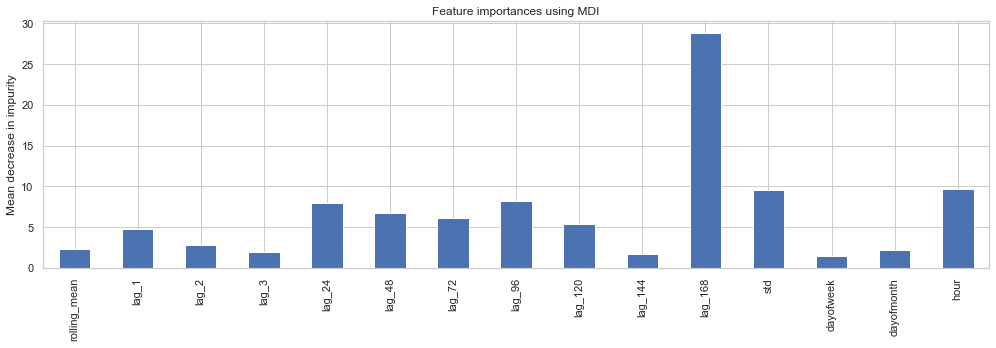

In [62]:
feature_names = X_train.columns

cat_importances = pd.Series(importances, index=feature_names) 
 
fig, ax = plt.subplots() 
cat_importances.plot.bar(yerr=std, ax=ax) 
ax.set_title("Feature importances using MDI") 
ax.set_ylabel("Mean decrease in impurity") 
fig.tight_layout()

#### Посмотрим как модель будет работать с аньшим количеством фичей

In [65]:
X_train_cut2 = X_train.drop(['lag_3', 'lag_144', 'rolling_mean','dayofweek', 'dayofmonth'], axis=1)

In [66]:
%%time
clf_cat = CatBoostRegressor(random_state=random_state,learning_rate = 0.1)

# # обучение модели
grid_cat = GridSearchCV(clf_cat, params_cat, verbose=1, scoring=rmse_scorer, cv=tscv)
grid_cat.fit(X_train_cut2, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 28.1114979	total: 1.3ms	remaining: 649ms
1:	learn: 26.9702865	total: 2.42ms	remaining: 603ms
2:	learn: 25.8586149	total: 3.65ms	remaining: 604ms
3:	learn: 24.8474731	total: 4.88ms	remaining: 605ms
4:	learn: 23.8660985	total: 6.14ms	remaining: 608ms
5:	learn: 23.0655005	total: 7.47ms	remaining: 615ms
6:	learn: 22.3222871	total: 8.76ms	remaining: 617ms
7:	learn: 21.6201416	total: 10ms	remaining: 617ms
8:	learn: 21.0888121	total: 11.6ms	remaining: 631ms
9:	learn: 20.6588056	total: 12.8ms	remaining: 629ms
10:	learn: 20.1417474	total: 14ms	remaining: 623ms
11:	learn: 19.7386785	total: 15.2ms	remaining: 618ms
12:	learn: 19.3335511	total: 16.5ms	remaining: 619ms
13:	learn: 18.9902662	total: 17.6ms	remaining: 610ms
14:	learn: 18.6576016	total: 18.9ms	remaining: 612ms
15:	learn: 18.3430342	total: 20.2ms	remaining: 610ms
16:	learn: 17.9954495	total: 21.2ms	remaining: 604ms
17:	learn: 17.7893558	total: 22.4ms	remaining: 599ms
1

253:	learn: 9.7289091	total: 283ms	remaining: 274ms
254:	learn: 9.7191043	total: 285ms	remaining: 274ms
255:	learn: 9.7015118	total: 286ms	remaining: 273ms
256:	learn: 9.6664759	total: 287ms	remaining: 272ms
257:	learn: 9.6466704	total: 289ms	remaining: 271ms
258:	learn: 9.6291402	total: 290ms	remaining: 270ms
259:	learn: 9.6148738	total: 291ms	remaining: 269ms
260:	learn: 9.5974313	total: 292ms	remaining: 267ms
261:	learn: 9.5802198	total: 293ms	remaining: 266ms
262:	learn: 9.5557527	total: 294ms	remaining: 265ms
263:	learn: 9.5409553	total: 295ms	remaining: 264ms
264:	learn: 9.5286904	total: 296ms	remaining: 263ms
265:	learn: 9.4986275	total: 297ms	remaining: 261ms
266:	learn: 9.4727769	total: 298ms	remaining: 260ms
267:	learn: 9.4467296	total: 300ms	remaining: 259ms
268:	learn: 9.4406083	total: 301ms	remaining: 258ms
269:	learn: 9.4213055	total: 302ms	remaining: 257ms
270:	learn: 9.3944718	total: 303ms	remaining: 256ms
271:	learn: 9.3544165	total: 304ms	remaining: 255ms
272:	learn: 

19:	learn: 17.8509501	total: 26.1ms	remaining: 626ms
20:	learn: 17.6497600	total: 28.1ms	remaining: 641ms
21:	learn: 17.5094590	total: 29.9ms	remaining: 650ms
22:	learn: 17.3711722	total: 31.5ms	remaining: 653ms
23:	learn: 17.2196041	total: 33ms	remaining: 655ms
24:	learn: 17.0586418	total: 35.3ms	remaining: 670ms
25:	learn: 16.9491223	total: 37.2ms	remaining: 678ms
26:	learn: 16.8621324	total: 38.6ms	remaining: 676ms
27:	learn: 16.7505632	total: 40.2ms	remaining: 678ms
28:	learn: 16.6770889	total: 42.4ms	remaining: 689ms
29:	learn: 16.5904563	total: 44.2ms	remaining: 692ms
30:	learn: 16.5236701	total: 45.6ms	remaining: 690ms
31:	learn: 16.4717619	total: 47.1ms	remaining: 688ms
32:	learn: 16.3774494	total: 50.1ms	remaining: 708ms
33:	learn: 16.2840010	total: 52.2ms	remaining: 716ms
34:	learn: 16.2416083	total: 55.7ms	remaining: 740ms
35:	learn: 16.1957292	total: 57.5ms	remaining: 741ms
36:	learn: 16.1332749	total: 59.5ms	remaining: 744ms
37:	learn: 16.0983488	total: 62.3ms	remaining: 7

225:	learn: 12.4852901	total: 322ms	remaining: 391ms
226:	learn: 12.4698087	total: 324ms	remaining: 389ms
227:	learn: 12.4630544	total: 325ms	remaining: 388ms
228:	learn: 12.4535229	total: 328ms	remaining: 389ms
229:	learn: 12.4431158	total: 330ms	remaining: 387ms
230:	learn: 12.4361487	total: 332ms	remaining: 386ms
231:	learn: 12.4341402	total: 335ms	remaining: 386ms
232:	learn: 12.4044036	total: 336ms	remaining: 385ms
233:	learn: 12.3931038	total: 338ms	remaining: 384ms
234:	learn: 12.3782767	total: 339ms	remaining: 382ms
235:	learn: 12.3564066	total: 341ms	remaining: 382ms
236:	learn: 12.3405032	total: 342ms	remaining: 380ms
237:	learn: 12.3220800	total: 344ms	remaining: 378ms
238:	learn: 12.3058249	total: 345ms	remaining: 377ms
239:	learn: 12.2836240	total: 346ms	remaining: 375ms
240:	learn: 12.2529668	total: 348ms	remaining: 375ms
241:	learn: 12.2290798	total: 351ms	remaining: 375ms
242:	learn: 12.2055952	total: 354ms	remaining: 374ms
243:	learn: 12.1882260	total: 355ms	remaining:

413:	learn: 10.3220954	total: 622ms	remaining: 129ms
414:	learn: 10.3135776	total: 624ms	remaining: 128ms
415:	learn: 10.3092959	total: 625ms	remaining: 126ms
416:	learn: 10.2973236	total: 626ms	remaining: 125ms
417:	learn: 10.2828503	total: 628ms	remaining: 123ms
418:	learn: 10.2710203	total: 629ms	remaining: 122ms
419:	learn: 10.2585928	total: 630ms	remaining: 120ms
420:	learn: 10.2510143	total: 631ms	remaining: 118ms
421:	learn: 10.2383619	total: 633ms	remaining: 117ms
422:	learn: 10.2370967	total: 634ms	remaining: 115ms
423:	learn: 10.2298489	total: 635ms	remaining: 114ms
424:	learn: 10.2246838	total: 637ms	remaining: 112ms
425:	learn: 10.2143632	total: 638ms	remaining: 111ms
426:	learn: 10.1975078	total: 639ms	remaining: 109ms
427:	learn: 10.1940758	total: 641ms	remaining: 108ms
428:	learn: 10.1756230	total: 642ms	remaining: 106ms
429:	learn: 10.1633964	total: 643ms	remaining: 105ms
430:	learn: 10.1575226	total: 645ms	remaining: 103ms
431:	learn: 10.1486070	total: 646ms	remaining:

104:	learn: 15.5667388	total: 158ms	remaining: 594ms
105:	learn: 15.5389368	total: 160ms	remaining: 593ms
106:	learn: 15.5096875	total: 161ms	remaining: 592ms
107:	learn: 15.4978581	total: 163ms	remaining: 592ms
108:	learn: 15.4710197	total: 165ms	remaining: 591ms
109:	learn: 15.4499005	total: 167ms	remaining: 591ms
110:	learn: 15.4350652	total: 168ms	remaining: 590ms
111:	learn: 15.4253186	total: 170ms	remaining: 588ms
112:	learn: 15.4037241	total: 171ms	remaining: 587ms
113:	learn: 15.3966507	total: 173ms	remaining: 587ms
114:	learn: 15.3703457	total: 175ms	remaining: 587ms
115:	learn: 15.3685350	total: 177ms	remaining: 585ms
116:	learn: 15.3522240	total: 178ms	remaining: 583ms
117:	learn: 15.3364401	total: 179ms	remaining: 581ms
118:	learn: 15.3333208	total: 181ms	remaining: 579ms
119:	learn: 15.3238852	total: 182ms	remaining: 577ms
120:	learn: 15.3119604	total: 184ms	remaining: 576ms
121:	learn: 15.3061816	total: 187ms	remaining: 578ms
122:	learn: 15.3044458	total: 188ms	remaining:

307:	learn: 13.1240486	total: 464ms	remaining: 289ms
308:	learn: 13.1067105	total: 466ms	remaining: 288ms
309:	learn: 13.1063979	total: 467ms	remaining: 286ms
310:	learn: 13.0981199	total: 469ms	remaining: 285ms
311:	learn: 13.0819522	total: 470ms	remaining: 283ms
312:	learn: 13.0713263	total: 472ms	remaining: 282ms
313:	learn: 13.0657056	total: 473ms	remaining: 280ms
314:	learn: 13.0558067	total: 475ms	remaining: 279ms
315:	learn: 13.0407653	total: 477ms	remaining: 277ms
316:	learn: 13.0266454	total: 478ms	remaining: 276ms
317:	learn: 13.0259941	total: 479ms	remaining: 274ms
318:	learn: 13.0199943	total: 481ms	remaining: 273ms
319:	learn: 13.0094890	total: 482ms	remaining: 271ms
320:	learn: 13.0055663	total: 484ms	remaining: 270ms
321:	learn: 12.9897089	total: 485ms	remaining: 268ms
322:	learn: 12.9800452	total: 487ms	remaining: 267ms
323:	learn: 12.9733090	total: 489ms	remaining: 265ms
324:	learn: 12.9640736	total: 490ms	remaining: 264ms
325:	learn: 12.9523497	total: 492ms	remaining:

0:	learn: 31.7012448	total: 3.4ms	remaining: 1.7s
1:	learn: 30.2128832	total: 4.98ms	remaining: 1.24s
2:	learn: 28.9684370	total: 6.65ms	remaining: 1.1s
3:	learn: 27.7834128	total: 8.29ms	remaining: 1.03s
4:	learn: 26.6506508	total: 9.82ms	remaining: 972ms
5:	learn: 25.7013646	total: 11.3ms	remaining: 930ms
6:	learn: 24.8542681	total: 12.8ms	remaining: 904ms
7:	learn: 24.1081482	total: 15ms	remaining: 923ms
8:	learn: 23.5032088	total: 16.9ms	remaining: 923ms
9:	learn: 22.8784463	total: 19.4ms	remaining: 950ms
10:	learn: 22.3267639	total: 20.9ms	remaining: 931ms
11:	learn: 21.9043011	total: 22.5ms	remaining: 917ms
12:	learn: 21.5300170	total: 24.2ms	remaining: 908ms
13:	learn: 21.1465855	total: 25.9ms	remaining: 898ms
14:	learn: 20.7664530	total: 28ms	remaining: 905ms
15:	learn: 20.4249218	total: 29.7ms	remaining: 897ms
16:	learn: 20.1538881	total: 31.4ms	remaining: 893ms
17:	learn: 19.8892303	total: 33ms	remaining: 884ms
18:	learn: 19.6691964	total: 34.6ms	remaining: 876ms
19:	learn: 1

197:	learn: 15.3155917	total: 315ms	remaining: 480ms
198:	learn: 15.2983423	total: 317ms	remaining: 479ms
199:	learn: 15.2895399	total: 318ms	remaining: 477ms
200:	learn: 15.2818330	total: 320ms	remaining: 475ms
201:	learn: 15.2647210	total: 321ms	remaining: 474ms
202:	learn: 15.2639682	total: 323ms	remaining: 472ms
203:	learn: 15.2485642	total: 324ms	remaining: 471ms
204:	learn: 15.2399475	total: 327ms	remaining: 470ms
205:	learn: 15.2249223	total: 328ms	remaining: 469ms
206:	learn: 15.2098571	total: 330ms	remaining: 467ms
207:	learn: 15.2017947	total: 331ms	remaining: 465ms
208:	learn: 15.2005266	total: 333ms	remaining: 463ms
209:	learn: 15.1901907	total: 334ms	remaining: 461ms
210:	learn: 15.1831424	total: 336ms	remaining: 460ms
211:	learn: 15.1708410	total: 337ms	remaining: 458ms
212:	learn: 15.1590772	total: 339ms	remaining: 457ms
213:	learn: 15.1516756	total: 342ms	remaining: 457ms
214:	learn: 15.1375669	total: 344ms	remaining: 456ms
215:	learn: 15.1246996	total: 345ms	remaining:

400:	learn: 13.5282083	total: 634ms	remaining: 156ms
401:	learn: 13.5216338	total: 635ms	remaining: 155ms
402:	learn: 13.5151042	total: 637ms	remaining: 153ms
403:	learn: 13.4993062	total: 639ms	remaining: 152ms
404:	learn: 13.4884545	total: 640ms	remaining: 150ms
405:	learn: 13.4850380	total: 642ms	remaining: 149ms
406:	learn: 13.4806376	total: 643ms	remaining: 147ms
407:	learn: 13.4779972	total: 645ms	remaining: 145ms
408:	learn: 13.4622355	total: 646ms	remaining: 144ms
409:	learn: 13.4555329	total: 648ms	remaining: 142ms
410:	learn: 13.4526052	total: 650ms	remaining: 141ms
411:	learn: 13.4457097	total: 652ms	remaining: 139ms
412:	learn: 13.4372774	total: 653ms	remaining: 138ms
413:	learn: 13.4270648	total: 661ms	remaining: 137ms
414:	learn: 13.4171451	total: 663ms	remaining: 136ms
415:	learn: 13.4103260	total: 665ms	remaining: 134ms
416:	learn: 13.4100717	total: 667ms	remaining: 133ms
417:	learn: 13.4095749	total: 668ms	remaining: 131ms
418:	learn: 13.4010763	total: 670ms	remaining:

66:	learn: 17.8670874	total: 115ms	remaining: 746ms
67:	learn: 17.8558552	total: 117ms	remaining: 745ms
68:	learn: 17.8330198	total: 119ms	remaining: 743ms
69:	learn: 17.8136257	total: 121ms	remaining: 741ms
70:	learn: 17.8024398	total: 122ms	remaining: 739ms
71:	learn: 17.7847300	total: 124ms	remaining: 737ms
72:	learn: 17.7700629	total: 126ms	remaining: 738ms
73:	learn: 17.7690067	total: 128ms	remaining: 738ms
74:	learn: 17.7665238	total: 130ms	remaining: 735ms
75:	learn: 17.7529855	total: 131ms	remaining: 733ms
76:	learn: 17.7331660	total: 133ms	remaining: 731ms
77:	learn: 17.7254548	total: 134ms	remaining: 728ms
78:	learn: 17.7197224	total: 136ms	remaining: 725ms
79:	learn: 17.7101208	total: 138ms	remaining: 723ms
80:	learn: 17.6952678	total: 141ms	remaining: 727ms
81:	learn: 17.6827601	total: 143ms	remaining: 727ms
82:	learn: 17.6648643	total: 144ms	remaining: 725ms
83:	learn: 17.6545281	total: 146ms	remaining: 725ms
84:	learn: 17.6248360	total: 148ms	remaining: 723ms
85:	learn: 1

253:	learn: 15.8472175	total: 436ms	remaining: 422ms
254:	learn: 15.8418296	total: 438ms	remaining: 421ms
255:	learn: 15.8279637	total: 440ms	remaining: 420ms
256:	learn: 15.8184083	total: 442ms	remaining: 418ms
257:	learn: 15.8079585	total: 444ms	remaining: 416ms
258:	learn: 15.7962032	total: 446ms	remaining: 415ms
259:	learn: 15.7813438	total: 447ms	remaining: 413ms
260:	learn: 15.7806666	total: 449ms	remaining: 411ms
261:	learn: 15.7697799	total: 451ms	remaining: 409ms
262:	learn: 15.7653005	total: 453ms	remaining: 408ms
263:	learn: 15.7557188	total: 454ms	remaining: 406ms
264:	learn: 15.7538517	total: 456ms	remaining: 404ms
265:	learn: 15.7453472	total: 458ms	remaining: 403ms
266:	learn: 15.7431042	total: 459ms	remaining: 401ms
267:	learn: 15.7332395	total: 461ms	remaining: 399ms
268:	learn: 15.7236704	total: 463ms	remaining: 398ms
269:	learn: 15.7151708	total: 466ms	remaining: 397ms
270:	learn: 15.7000564	total: 468ms	remaining: 395ms
271:	learn: 15.6890161	total: 470ms	remaining:

474:	learn: 14.2135312	total: 895ms	remaining: 47.1ms
475:	learn: 14.2073467	total: 897ms	remaining: 45.2ms
476:	learn: 14.2012448	total: 899ms	remaining: 43.3ms
477:	learn: 14.1967342	total: 900ms	remaining: 41.4ms
478:	learn: 14.1897258	total: 902ms	remaining: 39.5ms
479:	learn: 14.1894231	total: 904ms	remaining: 37.6ms
480:	learn: 14.1818126	total: 905ms	remaining: 35.8ms
481:	learn: 14.1789078	total: 907ms	remaining: 33.9ms
482:	learn: 14.1689604	total: 909ms	remaining: 32ms
483:	learn: 14.1586469	total: 910ms	remaining: 30.1ms
484:	learn: 14.1531517	total: 912ms	remaining: 28.2ms
485:	learn: 14.1462832	total: 914ms	remaining: 26.3ms
486:	learn: 14.1326646	total: 916ms	remaining: 24.4ms
487:	learn: 14.1319098	total: 918ms	remaining: 22.6ms
488:	learn: 14.1212155	total: 920ms	remaining: 20.7ms
489:	learn: 14.1126954	total: 921ms	remaining: 18.8ms
490:	learn: 14.1073054	total: 923ms	remaining: 16.9ms
491:	learn: 14.1015702	total: 925ms	remaining: 15ms
492:	learn: 14.0985707	total: 92

191:	learn: 10.9379978	total: 219ms	remaining: 924ms
192:	learn: 10.9286337	total: 221ms	remaining: 923ms
193:	learn: 10.9058684	total: 222ms	remaining: 921ms
194:	learn: 10.8775568	total: 223ms	remaining: 919ms
195:	learn: 10.8467560	total: 223ms	remaining: 917ms
196:	learn: 10.8230284	total: 224ms	remaining: 915ms
197:	learn: 10.8171706	total: 225ms	remaining: 913ms
198:	learn: 10.8077505	total: 226ms	remaining: 911ms
199:	learn: 10.7815036	total: 227ms	remaining: 909ms
200:	learn: 10.7797789	total: 228ms	remaining: 908ms
201:	learn: 10.7782492	total: 229ms	remaining: 906ms
202:	learn: 10.7523732	total: 231ms	remaining: 908ms
203:	learn: 10.7237170	total: 232ms	remaining: 907ms
204:	learn: 10.6845937	total: 234ms	remaining: 906ms
205:	learn: 10.6518602	total: 234ms	remaining: 904ms
206:	learn: 10.5984737	total: 236ms	remaining: 902ms
207:	learn: 10.5859041	total: 237ms	remaining: 901ms
208:	learn: 10.5799726	total: 238ms	remaining: 900ms
209:	learn: 10.5603995	total: 239ms	remaining:

463:	learn: 6.7915028	total: 512ms	remaining: 591ms
464:	learn: 6.7795656	total: 513ms	remaining: 590ms
465:	learn: 6.7734651	total: 514ms	remaining: 589ms
466:	learn: 6.7555319	total: 515ms	remaining: 588ms
467:	learn: 6.7423189	total: 517ms	remaining: 588ms
468:	learn: 6.7409909	total: 518ms	remaining: 586ms
469:	learn: 6.7168091	total: 519ms	remaining: 585ms
470:	learn: 6.7051753	total: 520ms	remaining: 584ms
471:	learn: 6.6963757	total: 521ms	remaining: 583ms
472:	learn: 6.6958741	total: 522ms	remaining: 582ms
473:	learn: 6.6899763	total: 523ms	remaining: 580ms
474:	learn: 6.6895718	total: 524ms	remaining: 579ms
475:	learn: 6.6739930	total: 525ms	remaining: 578ms
476:	learn: 6.6610465	total: 527ms	remaining: 578ms
477:	learn: 6.6449708	total: 528ms	remaining: 576ms
478:	learn: 6.6399041	total: 529ms	remaining: 575ms
479:	learn: 6.6383211	total: 530ms	remaining: 575ms
480:	learn: 6.6207314	total: 531ms	remaining: 573ms
481:	learn: 6.6052992	total: 533ms	remaining: 572ms
482:	learn: 

760:	learn: 4.4999239	total: 820ms	remaining: 257ms
761:	learn: 4.4936606	total: 822ms	remaining: 257ms
762:	learn: 4.4886517	total: 823ms	remaining: 256ms
763:	learn: 4.4785156	total: 824ms	remaining: 255ms
764:	learn: 4.4749271	total: 825ms	remaining: 254ms
765:	learn: 4.4646168	total: 827ms	remaining: 253ms
766:	learn: 4.4614108	total: 828ms	remaining: 252ms
767:	learn: 4.4611650	total: 829ms	remaining: 250ms
768:	learn: 4.4602062	total: 831ms	remaining: 250ms
769:	learn: 4.4598782	total: 832ms	remaining: 249ms
770:	learn: 4.4564171	total: 834ms	remaining: 248ms
771:	learn: 4.4546800	total: 835ms	remaining: 247ms
772:	learn: 4.4518659	total: 836ms	remaining: 246ms
773:	learn: 4.4449783	total: 837ms	remaining: 245ms
774:	learn: 4.4391517	total: 839ms	remaining: 244ms
775:	learn: 4.4295354	total: 840ms	remaining: 243ms
776:	learn: 4.4292415	total: 841ms	remaining: 241ms
777:	learn: 4.4259939	total: 843ms	remaining: 241ms
778:	learn: 4.4216048	total: 844ms	remaining: 239ms
779:	learn: 

2:	learn: 26.9651846	total: 5.57ms	remaining: 1.85s
3:	learn: 25.8025614	total: 7.16ms	remaining: 1.78s
4:	learn: 24.7707386	total: 8.44ms	remaining: 1.68s
5:	learn: 23.8321411	total: 10.1ms	remaining: 1.68s
6:	learn: 23.0671276	total: 11.4ms	remaining: 1.62s
7:	learn: 22.3591452	total: 12.7ms	remaining: 1.57s
8:	learn: 21.7656766	total: 13.9ms	remaining: 1.53s
9:	learn: 21.2411734	total: 15.2ms	remaining: 1.5s
10:	learn: 20.6927819	total: 16.4ms	remaining: 1.47s
11:	learn: 20.2689565	total: 17.6ms	remaining: 1.45s
12:	learn: 19.9250545	total: 19.1ms	remaining: 1.45s
13:	learn: 19.5381721	total: 20.5ms	remaining: 1.45s
14:	learn: 19.1348639	total: 22ms	remaining: 1.44s
15:	learn: 18.8501866	total: 24ms	remaining: 1.47s
16:	learn: 18.5441261	total: 25.4ms	remaining: 1.47s
17:	learn: 18.3215398	total: 26.9ms	remaining: 1.47s
18:	learn: 18.0533724	total: 28.2ms	remaining: 1.46s
19:	learn: 17.8509501	total: 29.6ms	remaining: 1.45s
20:	learn: 17.6497600	total: 31.1ms	remaining: 1.45s
21:	le

247:	learn: 12.1434141	total: 312ms	remaining: 947ms
248:	learn: 12.1257257	total: 314ms	remaining: 946ms
249:	learn: 12.1211217	total: 315ms	remaining: 944ms
250:	learn: 12.1105359	total: 316ms	remaining: 943ms
251:	learn: 12.1003884	total: 317ms	remaining: 941ms
252:	learn: 12.0966424	total: 319ms	remaining: 941ms
253:	learn: 12.0897774	total: 320ms	remaining: 939ms
254:	learn: 12.0657109	total: 321ms	remaining: 938ms
255:	learn: 12.0571546	total: 322ms	remaining: 936ms
256:	learn: 12.0530872	total: 324ms	remaining: 936ms
257:	learn: 12.0349676	total: 326ms	remaining: 937ms
258:	learn: 12.0180304	total: 327ms	remaining: 935ms
259:	learn: 11.9997758	total: 328ms	remaining: 934ms
260:	learn: 11.9832711	total: 329ms	remaining: 932ms
261:	learn: 11.9750684	total: 330ms	remaining: 931ms
262:	learn: 11.9651113	total: 332ms	remaining: 931ms
263:	learn: 11.9613217	total: 333ms	remaining: 929ms
264:	learn: 11.9465551	total: 335ms	remaining: 928ms
265:	learn: 11.9274410	total: 336ms	remaining:

491:	learn: 9.5631344	total: 620ms	remaining: 640ms
492:	learn: 9.5587315	total: 621ms	remaining: 639ms
493:	learn: 9.5490296	total: 623ms	remaining: 638ms
494:	learn: 9.5390848	total: 624ms	remaining: 637ms
495:	learn: 9.5292143	total: 626ms	remaining: 636ms
496:	learn: 9.5190130	total: 627ms	remaining: 635ms
497:	learn: 9.5074597	total: 628ms	remaining: 633ms
498:	learn: 9.4950280	total: 629ms	remaining: 632ms
499:	learn: 9.4871776	total: 631ms	remaining: 631ms
500:	learn: 9.4813544	total: 632ms	remaining: 629ms
501:	learn: 9.4726262	total: 633ms	remaining: 628ms
502:	learn: 9.4621211	total: 634ms	remaining: 627ms
503:	learn: 9.4510401	total: 636ms	remaining: 626ms
504:	learn: 9.4500785	total: 637ms	remaining: 625ms
505:	learn: 9.4424445	total: 639ms	remaining: 623ms
506:	learn: 9.4394285	total: 640ms	remaining: 622ms
507:	learn: 9.4324678	total: 641ms	remaining: 621ms
508:	learn: 9.4200711	total: 642ms	remaining: 620ms
509:	learn: 9.4064261	total: 643ms	remaining: 618ms
510:	learn: 

714:	learn: 7.8067526	total: 915ms	remaining: 365ms
715:	learn: 7.8015590	total: 917ms	remaining: 364ms
716:	learn: 7.7971927	total: 918ms	remaining: 362ms
717:	learn: 7.7939316	total: 920ms	remaining: 361ms
718:	learn: 7.7834568	total: 921ms	remaining: 360ms
719:	learn: 7.7793063	total: 922ms	remaining: 359ms
720:	learn: 7.7761548	total: 923ms	remaining: 357ms
721:	learn: 7.7709830	total: 924ms	remaining: 356ms
722:	learn: 7.7639498	total: 926ms	remaining: 355ms
723:	learn: 7.7579031	total: 928ms	remaining: 354ms
724:	learn: 7.7523716	total: 929ms	remaining: 352ms
725:	learn: 7.7401666	total: 930ms	remaining: 351ms
726:	learn: 7.7378215	total: 931ms	remaining: 350ms
727:	learn: 7.7336032	total: 933ms	remaining: 348ms
728:	learn: 7.7309881	total: 934ms	remaining: 347ms
729:	learn: 7.7266159	total: 935ms	remaining: 346ms
730:	learn: 7.7182159	total: 936ms	remaining: 345ms
731:	learn: 7.7110154	total: 938ms	remaining: 343ms
732:	learn: 7.7035241	total: 940ms	remaining: 342ms
733:	learn: 

961:	learn: 6.3742464	total: 1.22s	remaining: 48.3ms
962:	learn: 6.3664443	total: 1.23s	remaining: 47.1ms
963:	learn: 6.3564919	total: 1.23s	remaining: 45.8ms
964:	learn: 6.3524276	total: 1.23s	remaining: 44.5ms
965:	learn: 6.3432408	total: 1.23s	remaining: 43.3ms
966:	learn: 6.3358755	total: 1.23s	remaining: 42ms
967:	learn: 6.3335266	total: 1.23s	remaining: 40.7ms
968:	learn: 6.3311494	total: 1.23s	remaining: 39.4ms
969:	learn: 6.3230276	total: 1.23s	remaining: 38.2ms
970:	learn: 6.3201292	total: 1.24s	remaining: 36.9ms
971:	learn: 6.3167055	total: 1.24s	remaining: 35.6ms
972:	learn: 6.3160518	total: 1.24s	remaining: 34.4ms
973:	learn: 6.3123885	total: 1.24s	remaining: 33.1ms
974:	learn: 6.3063674	total: 1.24s	remaining: 31.8ms
975:	learn: 6.3019216	total: 1.24s	remaining: 30.6ms
976:	learn: 6.2988988	total: 1.24s	remaining: 29.3ms
977:	learn: 6.2947053	total: 1.25s	remaining: 28ms
978:	learn: 6.2909449	total: 1.25s	remaining: 26.7ms
979:	learn: 6.2870980	total: 1.25s	remaining: 25.5

160:	learn: 14.7399111	total: 230ms	remaining: 1.2s
161:	learn: 14.7298515	total: 233ms	remaining: 1.2s
162:	learn: 14.7175490	total: 234ms	remaining: 1.2s
163:	learn: 14.7012224	total: 236ms	remaining: 1.2s
164:	learn: 14.6902555	total: 237ms	remaining: 1.2s
165:	learn: 14.6635208	total: 238ms	remaining: 1.2s
166:	learn: 14.6484252	total: 241ms	remaining: 1.2s
167:	learn: 14.6476680	total: 242ms	remaining: 1.2s
168:	learn: 14.6307350	total: 243ms	remaining: 1.2s
169:	learn: 14.6212006	total: 245ms	remaining: 1.19s
170:	learn: 14.6158406	total: 246ms	remaining: 1.19s
171:	learn: 14.6021900	total: 248ms	remaining: 1.19s
172:	learn: 14.5990552	total: 249ms	remaining: 1.19s
173:	learn: 14.5773053	total: 250ms	remaining: 1.19s
174:	learn: 14.5662572	total: 252ms	remaining: 1.19s
175:	learn: 14.5422062	total: 254ms	remaining: 1.19s
176:	learn: 14.5378021	total: 255ms	remaining: 1.19s
177:	learn: 14.5311523	total: 256ms	remaining: 1.18s
178:	learn: 14.5183633	total: 258ms	remaining: 1.18s
17

378:	learn: 12.4069791	total: 541ms	remaining: 887ms
379:	learn: 12.3945975	total: 543ms	remaining: 886ms
380:	learn: 12.3827308	total: 545ms	remaining: 885ms
381:	learn: 12.3659253	total: 546ms	remaining: 884ms
382:	learn: 12.3520096	total: 548ms	remaining: 882ms
383:	learn: 12.3464419	total: 549ms	remaining: 881ms
384:	learn: 12.3457148	total: 550ms	remaining: 879ms
385:	learn: 12.3366650	total: 552ms	remaining: 877ms
386:	learn: 12.3260294	total: 553ms	remaining: 876ms
387:	learn: 12.3158028	total: 555ms	remaining: 875ms
388:	learn: 12.3146775	total: 556ms	remaining: 874ms
389:	learn: 12.3026161	total: 558ms	remaining: 873ms
390:	learn: 12.2906088	total: 560ms	remaining: 872ms
391:	learn: 12.2849182	total: 561ms	remaining: 870ms
392:	learn: 12.2794108	total: 562ms	remaining: 869ms
393:	learn: 12.2689140	total: 564ms	remaining: 867ms
394:	learn: 12.2602742	total: 565ms	remaining: 866ms
395:	learn: 12.2566905	total: 567ms	remaining: 864ms
396:	learn: 12.2417715	total: 568ms	remaining:

599:	learn: 10.6463652	total: 854ms	remaining: 569ms
600:	learn: 10.6383975	total: 856ms	remaining: 568ms
601:	learn: 10.6318268	total: 857ms	remaining: 567ms
602:	learn: 10.6261713	total: 859ms	remaining: 565ms
603:	learn: 10.6126559	total: 860ms	remaining: 564ms
604:	learn: 10.6058798	total: 861ms	remaining: 562ms
605:	learn: 10.5984713	total: 863ms	remaining: 561ms
606:	learn: 10.5953637	total: 865ms	remaining: 560ms
607:	learn: 10.5915138	total: 866ms	remaining: 559ms
608:	learn: 10.5866363	total: 868ms	remaining: 557ms
609:	learn: 10.5856131	total: 869ms	remaining: 556ms
610:	learn: 10.5796075	total: 870ms	remaining: 554ms
611:	learn: 10.5793683	total: 872ms	remaining: 553ms
612:	learn: 10.5732666	total: 873ms	remaining: 551ms
613:	learn: 10.5671447	total: 875ms	remaining: 550ms
614:	learn: 10.5616297	total: 876ms	remaining: 548ms
615:	learn: 10.5586834	total: 878ms	remaining: 547ms
616:	learn: 10.5517709	total: 880ms	remaining: 546ms
617:	learn: 10.5467396	total: 881ms	remaining:

816:	learn: 9.4026192	total: 1.17s	remaining: 261ms
817:	learn: 9.3934851	total: 1.17s	remaining: 260ms
818:	learn: 9.3929715	total: 1.17s	remaining: 258ms
819:	learn: 9.3878779	total: 1.17s	remaining: 257ms
820:	learn: 9.3873991	total: 1.17s	remaining: 255ms
821:	learn: 9.3803385	total: 1.17s	remaining: 254ms
822:	learn: 9.3772987	total: 1.17s	remaining: 253ms
823:	learn: 9.3729799	total: 1.18s	remaining: 251ms
824:	learn: 9.3672889	total: 1.18s	remaining: 250ms
825:	learn: 9.3629498	total: 1.18s	remaining: 248ms
826:	learn: 9.3618822	total: 1.18s	remaining: 247ms
827:	learn: 9.3497215	total: 1.18s	remaining: 246ms
828:	learn: 9.3465884	total: 1.18s	remaining: 244ms
829:	learn: 9.3427594	total: 1.19s	remaining: 243ms
830:	learn: 9.3372303	total: 1.19s	remaining: 241ms
831:	learn: 9.3301773	total: 1.19s	remaining: 240ms
832:	learn: 9.3217087	total: 1.19s	remaining: 239ms
833:	learn: 9.3174674	total: 1.19s	remaining: 237ms
834:	learn: 9.3122060	total: 1.19s	remaining: 236ms
835:	learn: 

1:	learn: 30.2128832	total: 5.45ms	remaining: 2.72s
2:	learn: 28.9684370	total: 6.97ms	remaining: 2.31s
3:	learn: 27.7834128	total: 9.57ms	remaining: 2.38s
4:	learn: 26.6506508	total: 11.8ms	remaining: 2.34s
5:	learn: 25.7013646	total: 14ms	remaining: 2.32s
6:	learn: 24.8542681	total: 16.2ms	remaining: 2.3s
7:	learn: 24.1081482	total: 18.1ms	remaining: 2.24s
8:	learn: 23.5032088	total: 19.7ms	remaining: 2.17s
9:	learn: 22.8784463	total: 21.7ms	remaining: 2.15s
10:	learn: 22.3267639	total: 24.5ms	remaining: 2.2s
11:	learn: 21.9043011	total: 26.6ms	remaining: 2.19s
12:	learn: 21.5300170	total: 28.4ms	remaining: 2.15s
13:	learn: 21.1465855	total: 30.7ms	remaining: 2.16s
14:	learn: 20.7664530	total: 33.2ms	remaining: 2.18s
15:	learn: 20.4249218	total: 34.8ms	remaining: 2.14s
16:	learn: 20.1538881	total: 36.4ms	remaining: 2.1s
17:	learn: 19.8892303	total: 38ms	remaining: 2.07s
18:	learn: 19.6691964	total: 40.1ms	remaining: 2.07s
19:	learn: 19.4523861	total: 41.8ms	remaining: 2.05s
20:	learn

171:	learn: 15.6084179	total: 316ms	remaining: 1.52s
172:	learn: 15.5883521	total: 319ms	remaining: 1.52s
173:	learn: 15.5719489	total: 320ms	remaining: 1.52s
174:	learn: 15.5499714	total: 322ms	remaining: 1.52s
175:	learn: 15.5317562	total: 324ms	remaining: 1.52s
176:	learn: 15.5227307	total: 326ms	remaining: 1.51s
177:	learn: 15.5180364	total: 327ms	remaining: 1.51s
178:	learn: 15.5055997	total: 329ms	remaining: 1.51s
179:	learn: 15.5045416	total: 331ms	remaining: 1.51s
180:	learn: 15.4939972	total: 333ms	remaining: 1.5s
181:	learn: 15.4782083	total: 335ms	remaining: 1.5s
182:	learn: 15.4695821	total: 336ms	remaining: 1.5s
183:	learn: 15.4592944	total: 338ms	remaining: 1.5s
184:	learn: 15.4429007	total: 339ms	remaining: 1.49s
185:	learn: 15.4318289	total: 341ms	remaining: 1.49s
186:	learn: 15.4166906	total: 343ms	remaining: 1.49s
187:	learn: 15.4038034	total: 345ms	remaining: 1.49s
188:	learn: 15.3944632	total: 347ms	remaining: 1.49s
189:	learn: 15.3919195	total: 349ms	remaining: 1.4

398:	learn: 13.5490461	total: 779ms	remaining: 1.17s
399:	learn: 13.5368100	total: 781ms	remaining: 1.17s
400:	learn: 13.5282083	total: 783ms	remaining: 1.17s
401:	learn: 13.5216338	total: 785ms	remaining: 1.17s
402:	learn: 13.5151042	total: 787ms	remaining: 1.17s
403:	learn: 13.4993062	total: 788ms	remaining: 1.16s
404:	learn: 13.4884545	total: 790ms	remaining: 1.16s
405:	learn: 13.4850380	total: 791ms	remaining: 1.16s
406:	learn: 13.4806376	total: 793ms	remaining: 1.16s
407:	learn: 13.4779972	total: 795ms	remaining: 1.15s
408:	learn: 13.4622355	total: 797ms	remaining: 1.15s
409:	learn: 13.4555329	total: 799ms	remaining: 1.15s
410:	learn: 13.4526052	total: 800ms	remaining: 1.15s
411:	learn: 13.4457097	total: 802ms	remaining: 1.14s
412:	learn: 13.4372774	total: 803ms	remaining: 1.14s
413:	learn: 13.4270648	total: 805ms	remaining: 1.14s
414:	learn: 13.4171451	total: 807ms	remaining: 1.14s
415:	learn: 13.4103260	total: 808ms	remaining: 1.13s
416:	learn: 13.4100717	total: 810ms	remaining:

577:	learn: 12.4098728	total: 1.09s	remaining: 796ms
578:	learn: 12.4037842	total: 1.09s	remaining: 794ms
579:	learn: 12.4034365	total: 1.09s	remaining: 792ms
580:	learn: 12.4032938	total: 1.09s	remaining: 789ms
581:	learn: 12.3933326	total: 1.1s	remaining: 787ms
582:	learn: 12.3853776	total: 1.1s	remaining: 786ms
583:	learn: 12.3825497	total: 1.1s	remaining: 784ms
584:	learn: 12.3784658	total: 1.1s	remaining: 782ms
585:	learn: 12.3738094	total: 1.1s	remaining: 780ms
586:	learn: 12.3668386	total: 1.1s	remaining: 778ms
587:	learn: 12.3620345	total: 1.11s	remaining: 776ms
588:	learn: 12.3561447	total: 1.11s	remaining: 774ms
589:	learn: 12.3559248	total: 1.11s	remaining: 772ms
590:	learn: 12.3521885	total: 1.11s	remaining: 770ms
591:	learn: 12.3429188	total: 1.11s	remaining: 767ms
592:	learn: 12.3342763	total: 1.11s	remaining: 766ms
593:	learn: 12.3320767	total: 1.12s	remaining: 764ms
594:	learn: 12.3262269	total: 1.12s	remaining: 763ms
595:	learn: 12.3253307	total: 1.12s	remaining: 760ms

752:	learn: 11.4921060	total: 1.4s	remaining: 459ms
753:	learn: 11.4870424	total: 1.4s	remaining: 458ms
754:	learn: 11.4840750	total: 1.41s	remaining: 456ms
755:	learn: 11.4769054	total: 1.41s	remaining: 454ms
756:	learn: 11.4739696	total: 1.41s	remaining: 452ms
757:	learn: 11.4701238	total: 1.41s	remaining: 450ms
758:	learn: 11.4641376	total: 1.41s	remaining: 448ms
759:	learn: 11.4621869	total: 1.41s	remaining: 446ms
760:	learn: 11.4553092	total: 1.42s	remaining: 444ms
761:	learn: 11.4466756	total: 1.42s	remaining: 443ms
762:	learn: 11.4405421	total: 1.42s	remaining: 441ms
763:	learn: 11.4403330	total: 1.42s	remaining: 439ms
764:	learn: 11.4391494	total: 1.42s	remaining: 438ms
765:	learn: 11.4323343	total: 1.43s	remaining: 436ms
766:	learn: 11.4282906	total: 1.43s	remaining: 434ms
767:	learn: 11.4261038	total: 1.43s	remaining: 433ms
768:	learn: 11.4207821	total: 1.43s	remaining: 431ms
769:	learn: 11.4183034	total: 1.44s	remaining: 429ms
770:	learn: 11.4177104	total: 1.44s	remaining: 4

926:	learn: 10.6534559	total: 1.71s	remaining: 134ms
927:	learn: 10.6451491	total: 1.71s	remaining: 133ms
928:	learn: 10.6415313	total: 1.71s	remaining: 131ms
929:	learn: 10.6368662	total: 1.71s	remaining: 129ms
930:	learn: 10.6328079	total: 1.71s	remaining: 127ms
931:	learn: 10.6309459	total: 1.71s	remaining: 125ms
932:	learn: 10.6267037	total: 1.72s	remaining: 123ms
933:	learn: 10.6224017	total: 1.72s	remaining: 121ms
934:	learn: 10.6154591	total: 1.72s	remaining: 120ms
935:	learn: 10.6101123	total: 1.72s	remaining: 118ms
936:	learn: 10.6061241	total: 1.72s	remaining: 116ms
937:	learn: 10.6029083	total: 1.72s	remaining: 114ms
938:	learn: 10.6018892	total: 1.73s	remaining: 112ms
939:	learn: 10.5917240	total: 1.73s	remaining: 110ms
940:	learn: 10.5868434	total: 1.73s	remaining: 108ms
941:	learn: 10.5771166	total: 1.73s	remaining: 107ms
942:	learn: 10.5708485	total: 1.73s	remaining: 105ms
943:	learn: 10.5647721	total: 1.74s	remaining: 103ms
944:	learn: 10.5604199	total: 1.74s	remaining:

139:	learn: 16.9259487	total: 317ms	remaining: 1.95s
140:	learn: 16.9156718	total: 319ms	remaining: 1.94s
141:	learn: 16.9049084	total: 321ms	remaining: 1.94s
142:	learn: 16.8902098	total: 323ms	remaining: 1.93s
143:	learn: 16.8838300	total: 324ms	remaining: 1.93s
144:	learn: 16.8617995	total: 326ms	remaining: 1.92s
145:	learn: 16.8466364	total: 328ms	remaining: 1.92s
146:	learn: 16.8230495	total: 330ms	remaining: 1.91s
147:	learn: 16.8066582	total: 332ms	remaining: 1.91s
148:	learn: 16.8051227	total: 334ms	remaining: 1.91s
149:	learn: 16.8038870	total: 336ms	remaining: 1.9s
150:	learn: 16.7921416	total: 338ms	remaining: 1.9s
151:	learn: 16.7857407	total: 339ms	remaining: 1.89s
152:	learn: 16.7781096	total: 341ms	remaining: 1.89s
153:	learn: 16.7624389	total: 343ms	remaining: 1.88s
154:	learn: 16.7523106	total: 345ms	remaining: 1.88s
155:	learn: 16.7421715	total: 347ms	remaining: 1.88s
156:	learn: 16.7410423	total: 350ms	remaining: 1.88s
157:	learn: 16.7378238	total: 352ms	remaining: 1

310:	learn: 15.3315115	total: 631ms	remaining: 1.4s
311:	learn: 15.3211893	total: 633ms	remaining: 1.4s
312:	learn: 15.3062452	total: 635ms	remaining: 1.39s
313:	learn: 15.2902492	total: 637ms	remaining: 1.39s
314:	learn: 15.2799937	total: 639ms	remaining: 1.39s
315:	learn: 15.2728515	total: 641ms	remaining: 1.39s
316:	learn: 15.2710791	total: 642ms	remaining: 1.38s
317:	learn: 15.2649580	total: 644ms	remaining: 1.38s
318:	learn: 15.2569252	total: 646ms	remaining: 1.38s
319:	learn: 15.2520814	total: 648ms	remaining: 1.38s
320:	learn: 15.2420826	total: 650ms	remaining: 1.37s
321:	learn: 15.2380552	total: 652ms	remaining: 1.37s
322:	learn: 15.2337170	total: 654ms	remaining: 1.37s
323:	learn: 15.2293164	total: 655ms	remaining: 1.37s
324:	learn: 15.2195251	total: 658ms	remaining: 1.37s
325:	learn: 15.2130163	total: 660ms	remaining: 1.36s
326:	learn: 15.2091395	total: 661ms	remaining: 1.36s
327:	learn: 15.2016168	total: 663ms	remaining: 1.36s
328:	learn: 15.1918021	total: 666ms	remaining: 1

537:	learn: 13.8254264	total: 1.1s	remaining: 948ms
538:	learn: 13.8206859	total: 1.1s	remaining: 946ms
539:	learn: 13.8135839	total: 1.11s	remaining: 943ms
540:	learn: 13.8078622	total: 1.11s	remaining: 941ms
541:	learn: 13.8039358	total: 1.11s	remaining: 939ms
542:	learn: 13.7981315	total: 1.11s	remaining: 938ms
543:	learn: 13.7923316	total: 1.12s	remaining: 936ms
544:	learn: 13.7901701	total: 1.12s	remaining: 934ms
545:	learn: 13.7844842	total: 1.12s	remaining: 932ms
546:	learn: 13.7795747	total: 1.12s	remaining: 930ms
547:	learn: 13.7698883	total: 1.12s	remaining: 928ms
548:	learn: 13.7631656	total: 1.13s	remaining: 926ms
549:	learn: 13.7616902	total: 1.13s	remaining: 924ms
550:	learn: 13.7558947	total: 1.13s	remaining: 922ms
551:	learn: 13.7501259	total: 1.14s	remaining: 921ms
552:	learn: 13.7397037	total: 1.14s	remaining: 919ms
553:	learn: 13.7370491	total: 1.14s	remaining: 917ms
554:	learn: 13.7348145	total: 1.14s	remaining: 916ms
555:	learn: 13.7249369	total: 1.14s	remaining: 9

768:	learn: 12.6894828	total: 1.57s	remaining: 473ms
769:	learn: 12.6837300	total: 1.58s	remaining: 471ms
770:	learn: 12.6835237	total: 1.58s	remaining: 469ms
771:	learn: 12.6765044	total: 1.58s	remaining: 467ms
772:	learn: 12.6721749	total: 1.58s	remaining: 465ms
773:	learn: 12.6665166	total: 1.58s	remaining: 463ms
774:	learn: 12.6609675	total: 1.59s	remaining: 461ms
775:	learn: 12.6526158	total: 1.59s	remaining: 459ms
776:	learn: 12.6479127	total: 1.59s	remaining: 457ms
777:	learn: 12.6417659	total: 1.59s	remaining: 455ms
778:	learn: 12.6416725	total: 1.6s	remaining: 453ms
779:	learn: 12.6396724	total: 1.6s	remaining: 451ms
780:	learn: 12.6352326	total: 1.6s	remaining: 449ms
781:	learn: 12.6297532	total: 1.6s	remaining: 447ms
782:	learn: 12.6256500	total: 1.6s	remaining: 445ms
783:	learn: 12.6191599	total: 1.61s	remaining: 443ms
784:	learn: 12.6106623	total: 1.61s	remaining: 441ms
785:	learn: 12.6094830	total: 1.61s	remaining: 439ms
786:	learn: 12.6089159	total: 1.61s	remaining: 437m

927:	learn: 11.9838120	total: 1.89s	remaining: 146ms
928:	learn: 11.9837281	total: 1.89s	remaining: 144ms
929:	learn: 11.9816404	total: 1.89s	remaining: 142ms
930:	learn: 11.9743917	total: 1.89s	remaining: 140ms
931:	learn: 11.9681400	total: 1.89s	remaining: 138ms
932:	learn: 11.9632111	total: 1.9s	remaining: 136ms
933:	learn: 11.9609904	total: 1.9s	remaining: 134ms
934:	learn: 11.9584983	total: 1.9s	remaining: 132ms
935:	learn: 11.9565098	total: 1.9s	remaining: 130ms
936:	learn: 11.9493792	total: 1.9s	remaining: 128ms
937:	learn: 11.9439819	total: 1.91s	remaining: 126ms
938:	learn: 11.9415106	total: 1.91s	remaining: 124ms
939:	learn: 11.9391375	total: 1.91s	remaining: 122ms
940:	learn: 11.9319121	total: 1.91s	remaining: 120ms
941:	learn: 11.9277137	total: 1.91s	remaining: 118ms
942:	learn: 11.9226101	total: 1.92s	remaining: 116ms
943:	learn: 11.9173631	total: 1.92s	remaining: 114ms
944:	learn: 11.9121006	total: 1.92s	remaining: 112ms
945:	learn: 11.9042303	total: 1.92s	remaining: 110m

114:	learn: 10.6594338	total: 321ms	remaining: 1.07s
115:	learn: 10.5800265	total: 324ms	remaining: 1.07s
116:	learn: 10.5738406	total: 326ms	remaining: 1.07s
117:	learn: 10.4928815	total: 328ms	remaining: 1.06s
118:	learn: 10.4452766	total: 331ms	remaining: 1.06s
119:	learn: 10.3799635	total: 333ms	remaining: 1.05s
120:	learn: 10.3376256	total: 335ms	remaining: 1.05s
121:	learn: 10.2839615	total: 337ms	remaining: 1.04s
122:	learn: 10.1994333	total: 339ms	remaining: 1.04s
123:	learn: 10.1535297	total: 341ms	remaining: 1.03s
124:	learn: 10.1337253	total: 344ms	remaining: 1.03s
125:	learn: 10.0702129	total: 346ms	remaining: 1.03s
126:	learn: 10.0546991	total: 349ms	remaining: 1.02s
127:	learn: 10.0081263	total: 351ms	remaining: 1.02s
128:	learn: 9.9783632	total: 353ms	remaining: 1.01s
129:	learn: 9.9548474	total: 354ms	remaining: 1.01s
130:	learn: 9.9159488	total: 356ms	remaining: 1s
131:	learn: 9.9111901	total: 359ms	remaining: 1000ms
132:	learn: 9.8918711	total: 360ms	remaining: 994ms


344:	learn: 4.7683637	total: 797ms	remaining: 358ms
345:	learn: 4.7677088	total: 799ms	remaining: 356ms
346:	learn: 4.7425214	total: 801ms	remaining: 353ms
347:	learn: 4.7224789	total: 804ms	remaining: 351ms
348:	learn: 4.7209208	total: 805ms	remaining: 349ms
349:	learn: 4.7073367	total: 808ms	remaining: 346ms
350:	learn: 4.6827690	total: 811ms	remaining: 344ms
351:	learn: 4.6494524	total: 813ms	remaining: 342ms
352:	learn: 4.6300442	total: 815ms	remaining: 339ms
353:	learn: 4.6158029	total: 817ms	remaining: 337ms
354:	learn: 4.6118882	total: 819ms	remaining: 334ms
355:	learn: 4.5911408	total: 821ms	remaining: 332ms
356:	learn: 4.5665554	total: 824ms	remaining: 330ms
357:	learn: 4.5570658	total: 826ms	remaining: 328ms
358:	learn: 4.5487625	total: 829ms	remaining: 325ms
359:	learn: 4.5298732	total: 831ms	remaining: 323ms
360:	learn: 4.5134631	total: 833ms	remaining: 321ms
361:	learn: 4.5014359	total: 834ms	remaining: 318ms
362:	learn: 4.5009091	total: 836ms	remaining: 315ms
363:	learn: 

66:	learn: 14.0061026	total: 159ms	remaining: 1.03s
67:	learn: 13.9881596	total: 162ms	remaining: 1.03s
68:	learn: 13.9486379	total: 164ms	remaining: 1.02s
69:	learn: 13.9308390	total: 167ms	remaining: 1.02s
70:	learn: 13.9063866	total: 169ms	remaining: 1.02s
71:	learn: 13.8820249	total: 171ms	remaining: 1.02s
72:	learn: 13.8630623	total: 174ms	remaining: 1.02s
73:	learn: 13.8426334	total: 177ms	remaining: 1.02s
74:	learn: 13.8106569	total: 180ms	remaining: 1.02s
75:	learn: 13.7593293	total: 182ms	remaining: 1.01s
76:	learn: 13.7532145	total: 185ms	remaining: 1.01s
77:	learn: 13.7302386	total: 187ms	remaining: 1.01s
78:	learn: 13.6965986	total: 190ms	remaining: 1.01s
79:	learn: 13.6739769	total: 193ms	remaining: 1.01s
80:	learn: 13.6582013	total: 195ms	remaining: 1.01s
81:	learn: 13.6247498	total: 198ms	remaining: 1.01s
82:	learn: 13.6019729	total: 200ms	remaining: 1s
83:	learn: 13.5683192	total: 202ms	remaining: 999ms
84:	learn: 13.5590210	total: 204ms	remaining: 996ms
85:	learn: 13.5

268:	learn: 8.7152308	total: 645ms	remaining: 554ms
269:	learn: 8.6928838	total: 647ms	remaining: 551ms
270:	learn: 8.6823387	total: 651ms	remaining: 550ms
271:	learn: 8.6768249	total: 655ms	remaining: 549ms
272:	learn: 8.6663981	total: 657ms	remaining: 547ms
273:	learn: 8.6499272	total: 660ms	remaining: 544ms
274:	learn: 8.6194379	total: 662ms	remaining: 542ms
275:	learn: 8.6062988	total: 666ms	remaining: 541ms
276:	learn: 8.5990140	total: 669ms	remaining: 539ms
277:	learn: 8.5937025	total: 672ms	remaining: 537ms
278:	learn: 8.5742785	total: 674ms	remaining: 534ms
279:	learn: 8.5625730	total: 677ms	remaining: 532ms
280:	learn: 8.5329316	total: 680ms	remaining: 530ms
281:	learn: 8.5074085	total: 683ms	remaining: 528ms
282:	learn: 8.4916907	total: 685ms	remaining: 525ms
283:	learn: 8.4697600	total: 688ms	remaining: 523ms
284:	learn: 8.4558497	total: 690ms	remaining: 521ms
285:	learn: 8.4446718	total: 693ms	remaining: 519ms
286:	learn: 8.4346259	total: 696ms	remaining: 516ms
287:	learn: 

447:	learn: 6.1191294	total: 1.13s	remaining: 131ms
448:	learn: 6.1113579	total: 1.13s	remaining: 129ms
449:	learn: 6.0960011	total: 1.14s	remaining: 126ms
450:	learn: 6.0729831	total: 1.14s	remaining: 124ms
451:	learn: 6.0664436	total: 1.14s	remaining: 121ms
452:	learn: 6.0545184	total: 1.15s	remaining: 119ms
453:	learn: 6.0458360	total: 1.15s	remaining: 116ms
454:	learn: 6.0240797	total: 1.15s	remaining: 114ms
455:	learn: 6.0207137	total: 1.16s	remaining: 111ms
456:	learn: 6.0169313	total: 1.16s	remaining: 109ms
457:	learn: 6.0032301	total: 1.16s	remaining: 106ms
458:	learn: 6.0002922	total: 1.16s	remaining: 104ms
459:	learn: 5.9818864	total: 1.17s	remaining: 101ms
460:	learn: 5.9756767	total: 1.17s	remaining: 98.9ms
461:	learn: 5.9546045	total: 1.17s	remaining: 96.4ms
462:	learn: 5.9350160	total: 1.17s	remaining: 93.8ms
463:	learn: 5.9287597	total: 1.18s	remaining: 91.3ms
464:	learn: 5.9084026	total: 1.18s	remaining: 89.1ms
465:	learn: 5.8968347	total: 1.19s	remaining: 86.6ms
466:	l

114:	learn: 14.2591797	total: 328ms	remaining: 1.1s
115:	learn: 14.2344636	total: 332ms	remaining: 1.1s
116:	learn: 14.2241306	total: 335ms	remaining: 1.09s
117:	learn: 14.1877165	total: 338ms	remaining: 1.09s
118:	learn: 14.1559878	total: 341ms	remaining: 1.09s
119:	learn: 14.1429095	total: 344ms	remaining: 1.09s
120:	learn: 14.1022198	total: 347ms	remaining: 1.09s
121:	learn: 14.0866151	total: 349ms	remaining: 1.08s
122:	learn: 14.0481736	total: 352ms	remaining: 1.08s
123:	learn: 14.0414327	total: 356ms	remaining: 1.08s
124:	learn: 14.0240347	total: 358ms	remaining: 1.07s
125:	learn: 13.9951734	total: 361ms	remaining: 1.07s
126:	learn: 13.9640020	total: 363ms	remaining: 1.07s
127:	learn: 13.9620577	total: 365ms	remaining: 1.06s
128:	learn: 13.9109120	total: 368ms	remaining: 1.06s
129:	learn: 13.9017097	total: 371ms	remaining: 1.06s
130:	learn: 13.8774874	total: 374ms	remaining: 1.05s
131:	learn: 13.8536466	total: 376ms	remaining: 1.05s
132:	learn: 13.8143493	total: 379ms	remaining: 1

302:	learn: 10.3646366	total: 820ms	remaining: 533ms
303:	learn: 10.3367896	total: 823ms	remaining: 531ms
304:	learn: 10.3165448	total: 826ms	remaining: 528ms
305:	learn: 10.2992365	total: 828ms	remaining: 525ms
306:	learn: 10.2945535	total: 831ms	remaining: 522ms
307:	learn: 10.2831298	total: 833ms	remaining: 520ms
308:	learn: 10.2558696	total: 837ms	remaining: 517ms
309:	learn: 10.2553887	total: 839ms	remaining: 514ms
310:	learn: 10.2277655	total: 842ms	remaining: 512ms
311:	learn: 10.2113751	total: 845ms	remaining: 509ms
312:	learn: 10.1941458	total: 848ms	remaining: 507ms
313:	learn: 10.1718463	total: 852ms	remaining: 504ms
314:	learn: 10.1600542	total: 854ms	remaining: 502ms
315:	learn: 10.1594597	total: 857ms	remaining: 499ms
316:	learn: 10.1296445	total: 860ms	remaining: 496ms
317:	learn: 10.1160943	total: 863ms	remaining: 494ms
318:	learn: 10.1059827	total: 866ms	remaining: 491ms
319:	learn: 10.0972380	total: 869ms	remaining: 489ms
320:	learn: 10.0749853	total: 872ms	remaining:

480:	learn: 8.0677912	total: 1.31s	remaining: 51.8ms
481:	learn: 8.0479710	total: 1.31s	remaining: 49.1ms
482:	learn: 8.0341872	total: 1.32s	remaining: 46.4ms
483:	learn: 8.0270297	total: 1.32s	remaining: 43.7ms
484:	learn: 8.0188128	total: 1.32s	remaining: 40.9ms
485:	learn: 8.0107545	total: 1.33s	remaining: 38.2ms
486:	learn: 7.9962317	total: 1.33s	remaining: 35.5ms
487:	learn: 7.9919390	total: 1.33s	remaining: 32.8ms
488:	learn: 7.9807420	total: 1.33s	remaining: 30ms
489:	learn: 7.9638594	total: 1.34s	remaining: 27.3ms
490:	learn: 7.9634721	total: 1.34s	remaining: 24.6ms
491:	learn: 7.9511815	total: 1.34s	remaining: 21.8ms
492:	learn: 7.9401856	total: 1.35s	remaining: 19.1ms
493:	learn: 7.9313307	total: 1.35s	remaining: 16.4ms
494:	learn: 7.9261405	total: 1.35s	remaining: 13.7ms
495:	learn: 7.9204290	total: 1.35s	remaining: 10.9ms
496:	learn: 7.9047453	total: 1.36s	remaining: 8.19ms
497:	learn: 7.8933105	total: 1.36s	remaining: 5.46ms
498:	learn: 7.8861834	total: 1.36s	remaining: 2.

140:	learn: 14.6254688	total: 403ms	remaining: 1.03s
141:	learn: 14.5955463	total: 406ms	remaining: 1.02s
142:	learn: 14.5670787	total: 409ms	remaining: 1.02s
143:	learn: 14.5652152	total: 412ms	remaining: 1.02s
144:	learn: 14.5433174	total: 415ms	remaining: 1.01s
145:	learn: 14.5246801	total: 418ms	remaining: 1.01s
146:	learn: 14.5130208	total: 420ms	remaining: 1.01s
147:	learn: 14.5112881	total: 423ms	remaining: 1.01s
148:	learn: 14.5096323	total: 426ms	remaining: 1s
149:	learn: 14.4927640	total: 429ms	remaining: 1s
150:	learn: 14.4713368	total: 432ms	remaining: 999ms
151:	learn: 14.4574020	total: 435ms	remaining: 996ms
152:	learn: 14.4391846	total: 438ms	remaining: 993ms
153:	learn: 14.4026816	total: 441ms	remaining: 990ms
154:	learn: 14.3913435	total: 443ms	remaining: 987ms
155:	learn: 14.3646961	total: 446ms	remaining: 984ms
156:	learn: 14.3637780	total: 449ms	remaining: 980ms
157:	learn: 14.3432749	total: 452ms	remaining: 977ms
158:	learn: 14.3181849	total: 455ms	remaining: 975ms

344:	learn: 11.3814176	total: 1.06s	remaining: 477ms
345:	learn: 11.3640270	total: 1.06s	remaining: 474ms
346:	learn: 11.3462818	total: 1.07s	remaining: 471ms
347:	learn: 11.3293429	total: 1.07s	remaining: 468ms
348:	learn: 11.3196391	total: 1.07s	remaining: 465ms
349:	learn: 11.3177948	total: 1.08s	remaining: 462ms
350:	learn: 11.3086980	total: 1.08s	remaining: 458ms
351:	learn: 11.2990452	total: 1.08s	remaining: 455ms
352:	learn: 11.2871059	total: 1.09s	remaining: 452ms
353:	learn: 11.2788380	total: 1.09s	remaining: 449ms
354:	learn: 11.2723439	total: 1.09s	remaining: 446ms
355:	learn: 11.2592133	total: 1.09s	remaining: 443ms
356:	learn: 11.2467796	total: 1.1s	remaining: 440ms
357:	learn: 11.2433301	total: 1.1s	remaining: 437ms
358:	learn: 11.2249546	total: 1.1s	remaining: 434ms
359:	learn: 11.2098178	total: 1.11s	remaining: 430ms
360:	learn: 11.1940120	total: 1.11s	remaining: 427ms
361:	learn: 11.1843884	total: 1.11s	remaining: 424ms
362:	learn: 11.1765184	total: 1.11s	remaining: 42

1:	learn: 31.1786328	total: 8.59ms	remaining: 2.14s
2:	learn: 29.6327307	total: 11.7ms	remaining: 1.95s
3:	learn: 28.2093122	total: 15.5ms	remaining: 1.93s
4:	learn: 27.0358861	total: 18.7ms	remaining: 1.85s
5:	learn: 25.9645070	total: 22.6ms	remaining: 1.86s
6:	learn: 25.0304875	total: 25.7ms	remaining: 1.81s
7:	learn: 24.2028037	total: 29.5ms	remaining: 1.81s
8:	learn: 23.4607434	total: 32.6ms	remaining: 1.78s
9:	learn: 22.8529902	total: 37.2ms	remaining: 1.82s
10:	learn: 22.3411042	total: 40.1ms	remaining: 1.78s
11:	learn: 21.8875914	total: 44.2ms	remaining: 1.79s
12:	learn: 21.4403525	total: 47.2ms	remaining: 1.77s
13:	learn: 21.0379958	total: 50.1ms	remaining: 1.74s
14:	learn: 20.6760356	total: 53.1ms	remaining: 1.72s
15:	learn: 20.3836446	total: 56.2ms	remaining: 1.7s
16:	learn: 20.1539482	total: 59.1ms	remaining: 1.68s
17:	learn: 19.8876233	total: 62.2ms	remaining: 1.66s
18:	learn: 19.6734038	total: 65.2ms	remaining: 1.65s
19:	learn: 19.5106372	total: 68.1ms	remaining: 1.63s
20:

209:	learn: 14.4291189	total: 665ms	remaining: 918ms
210:	learn: 14.4118253	total: 668ms	remaining: 915ms
211:	learn: 14.3990760	total: 671ms	remaining: 912ms
212:	learn: 14.3837498	total: 675ms	remaining: 909ms
213:	learn: 14.3703547	total: 678ms	remaining: 906ms
214:	learn: 14.3414795	total: 681ms	remaining: 903ms
215:	learn: 14.3164691	total: 685ms	remaining: 900ms
216:	learn: 14.3004692	total: 688ms	remaining: 897ms
217:	learn: 14.2814287	total: 692ms	remaining: 895ms
218:	learn: 14.2615170	total: 696ms	remaining: 893ms
219:	learn: 14.2457777	total: 699ms	remaining: 890ms
220:	learn: 14.2347211	total: 702ms	remaining: 886ms
221:	learn: 14.2222890	total: 705ms	remaining: 883ms
222:	learn: 14.2142698	total: 708ms	remaining: 880ms
223:	learn: 14.1991096	total: 711ms	remaining: 877ms
224:	learn: 14.1848496	total: 714ms	remaining: 873ms
225:	learn: 14.1775180	total: 717ms	remaining: 869ms
226:	learn: 14.1543751	total: 721ms	remaining: 867ms
227:	learn: 14.1378613	total: 724ms	remaining:

372:	learn: 12.2922815	total: 1.16s	remaining: 396ms
373:	learn: 12.2754495	total: 1.17s	remaining: 393ms
374:	learn: 12.2729559	total: 1.17s	remaining: 390ms
375:	learn: 12.2603036	total: 1.17s	remaining: 387ms
376:	learn: 12.2556084	total: 1.18s	remaining: 384ms
377:	learn: 12.2550229	total: 1.18s	remaining: 381ms
378:	learn: 12.2343573	total: 1.18s	remaining: 377ms
379:	learn: 12.2154959	total: 1.19s	remaining: 374ms
380:	learn: 12.1996429	total: 1.19s	remaining: 371ms
381:	learn: 12.1931190	total: 1.19s	remaining: 368ms
382:	learn: 12.1775071	total: 1.19s	remaining: 365ms
383:	learn: 12.1674979	total: 1.2s	remaining: 362ms
384:	learn: 12.1597053	total: 1.2s	remaining: 359ms
385:	learn: 12.1366429	total: 1.2s	remaining: 356ms
386:	learn: 12.1191382	total: 1.21s	remaining: 353ms
387:	learn: 12.1033495	total: 1.21s	remaining: 349ms
388:	learn: 12.0884417	total: 1.21s	remaining: 346ms
389:	learn: 12.0765557	total: 1.22s	remaining: 343ms
390:	learn: 12.0665383	total: 1.22s	remaining: 34

83:	learn: 12.0262378	total: 177ms	remaining: 1.93s
84:	learn: 11.9514333	total: 179ms	remaining: 1.93s
85:	learn: 11.8873169	total: 181ms	remaining: 1.92s
86:	learn: 11.8282470	total: 183ms	remaining: 1.92s
87:	learn: 11.7401504	total: 185ms	remaining: 1.91s
88:	learn: 11.6829482	total: 186ms	remaining: 1.91s
89:	learn: 11.6537519	total: 189ms	remaining: 1.91s
90:	learn: 11.5894439	total: 191ms	remaining: 1.91s
91:	learn: 11.5786195	total: 193ms	remaining: 1.9s
92:	learn: 11.5220222	total: 195ms	remaining: 1.91s
93:	learn: 11.4767349	total: 198ms	remaining: 1.9s
94:	learn: 11.4544150	total: 200ms	remaining: 1.9s
95:	learn: 11.4044201	total: 202ms	remaining: 1.9s
96:	learn: 11.3964003	total: 205ms	remaining: 1.91s
97:	learn: 11.3801185	total: 207ms	remaining: 1.9s
98:	learn: 11.3380284	total: 209ms	remaining: 1.91s
99:	learn: 11.3322467	total: 211ms	remaining: 1.9s
100:	learn: 11.2668838	total: 214ms	remaining: 1.9s
101:	learn: 11.2552098	total: 216ms	remaining: 1.9s
102:	learn: 11.187

241:	learn: 6.7513259	total: 498ms	remaining: 1.56s
242:	learn: 6.7007715	total: 500ms	remaining: 1.56s
243:	learn: 6.6780343	total: 502ms	remaining: 1.56s
244:	learn: 6.6440992	total: 504ms	remaining: 1.55s
245:	learn: 6.6231298	total: 507ms	remaining: 1.55s
246:	learn: 6.5734696	total: 509ms	remaining: 1.55s
247:	learn: 6.5725076	total: 511ms	remaining: 1.55s
248:	learn: 6.5675241	total: 513ms	remaining: 1.55s
249:	learn: 6.5302330	total: 515ms	remaining: 1.54s
250:	learn: 6.5188091	total: 517ms	remaining: 1.54s
251:	learn: 6.4816045	total: 520ms	remaining: 1.54s
252:	learn: 6.4437119	total: 522ms	remaining: 1.54s
253:	learn: 6.4247928	total: 524ms	remaining: 1.54s
254:	learn: 6.4010475	total: 526ms	remaining: 1.54s
255:	learn: 6.3692264	total: 528ms	remaining: 1.53s
256:	learn: 6.3638300	total: 531ms	remaining: 1.53s
257:	learn: 6.3384709	total: 533ms	remaining: 1.53s
258:	learn: 6.3074253	total: 535ms	remaining: 1.53s
259:	learn: 6.2884058	total: 537ms	remaining: 1.53s
260:	learn: 

475:	learn: 3.1809462	total: 978ms	remaining: 1.08s
476:	learn: 3.1804897	total: 980ms	remaining: 1.07s
477:	learn: 3.1711755	total: 982ms	remaining: 1.07s
478:	learn: 3.1642376	total: 984ms	remaining: 1.07s
479:	learn: 3.1525195	total: 986ms	remaining: 1.07s
480:	learn: 3.1412085	total: 989ms	remaining: 1.07s
481:	learn: 3.1344763	total: 991ms	remaining: 1.06s
482:	learn: 3.1169722	total: 993ms	remaining: 1.06s
483:	learn: 3.1119256	total: 996ms	remaining: 1.06s
484:	learn: 3.1022188	total: 998ms	remaining: 1.06s
485:	learn: 3.0849033	total: 1000ms	remaining: 1.06s
486:	learn: 3.0808697	total: 1s	remaining: 1.06s
487:	learn: 3.0628220	total: 1s	remaining: 1.05s
488:	learn: 3.0572191	total: 1.01s	remaining: 1.05s
489:	learn: 3.0408180	total: 1.01s	remaining: 1.05s
490:	learn: 3.0342420	total: 1.01s	remaining: 1.05s
491:	learn: 3.0314435	total: 1.01s	remaining: 1.04s
492:	learn: 3.0311083	total: 1.01s	remaining: 1.04s
493:	learn: 3.0258581	total: 1.02s	remaining: 1.04s
494:	learn: 3.016

708:	learn: 1.5940246	total: 1.46s	remaining: 600ms
709:	learn: 1.5888118	total: 1.46s	remaining: 598ms
710:	learn: 1.5841388	total: 1.47s	remaining: 596ms
711:	learn: 1.5782714	total: 1.47s	remaining: 594ms
712:	learn: 1.5764108	total: 1.47s	remaining: 592ms
713:	learn: 1.5702794	total: 1.47s	remaining: 590ms
714:	learn: 1.5682852	total: 1.47s	remaining: 588ms
715:	learn: 1.5640179	total: 1.48s	remaining: 586ms
716:	learn: 1.5586032	total: 1.48s	remaining: 584ms
717:	learn: 1.5584193	total: 1.48s	remaining: 582ms
718:	learn: 1.5557484	total: 1.48s	remaining: 580ms
719:	learn: 1.5553797	total: 1.49s	remaining: 578ms
720:	learn: 1.5527507	total: 1.49s	remaining: 576ms
721:	learn: 1.5480273	total: 1.49s	remaining: 574ms
722:	learn: 1.5477665	total: 1.49s	remaining: 572ms
723:	learn: 1.5458976	total: 1.49s	remaining: 570ms
724:	learn: 1.5382592	total: 1.5s	remaining: 568ms
725:	learn: 1.5349750	total: 1.5s	remaining: 565ms
726:	learn: 1.5310564	total: 1.5s	remaining: 563ms
727:	learn: 1.5

941:	learn: 0.8607594	total: 1.94s	remaining: 119ms
942:	learn: 0.8545748	total: 1.94s	remaining: 117ms
943:	learn: 0.8516013	total: 1.94s	remaining: 115ms
944:	learn: 0.8503001	total: 1.95s	remaining: 113ms
945:	learn: 0.8501402	total: 1.95s	remaining: 111ms
946:	learn: 0.8481944	total: 1.95s	remaining: 109ms
947:	learn: 0.8453376	total: 1.95s	remaining: 107ms
948:	learn: 0.8431075	total: 1.96s	remaining: 105ms
949:	learn: 0.8411153	total: 1.96s	remaining: 103ms
950:	learn: 0.8392119	total: 1.96s	remaining: 101ms
951:	learn: 0.8344893	total: 1.96s	remaining: 98.9ms
952:	learn: 0.8309931	total: 1.96s	remaining: 96.9ms
953:	learn: 0.8292800	total: 1.97s	remaining: 94.8ms
954:	learn: 0.8291367	total: 1.97s	remaining: 92.7ms
955:	learn: 0.8263099	total: 1.97s	remaining: 90.7ms
956:	learn: 0.8231262	total: 1.97s	remaining: 88.7ms
957:	learn: 0.8187482	total: 1.98s	remaining: 86.6ms
958:	learn: 0.8169549	total: 1.98s	remaining: 84.5ms
959:	learn: 0.8150829	total: 1.98s	remaining: 82.4ms
960

139:	learn: 11.8255457	total: 324ms	remaining: 1.99s
140:	learn: 11.7860078	total: 327ms	remaining: 1.99s
141:	learn: 11.7639142	total: 330ms	remaining: 2s
142:	learn: 11.7409642	total: 333ms	remaining: 2s
143:	learn: 11.7309071	total: 336ms	remaining: 2s
144:	learn: 11.7141844	total: 338ms	remaining: 1.99s
145:	learn: 11.6482528	total: 341ms	remaining: 2s
146:	learn: 11.6034733	total: 345ms	remaining: 2s
147:	learn: 11.5567889	total: 347ms	remaining: 2s
148:	learn: 11.5212579	total: 349ms	remaining: 1.99s
149:	learn: 11.4976054	total: 352ms	remaining: 1.99s
150:	learn: 11.4606275	total: 354ms	remaining: 1.99s
151:	learn: 11.4263360	total: 357ms	remaining: 1.99s
152:	learn: 11.3697368	total: 360ms	remaining: 1.99s
153:	learn: 11.3430728	total: 362ms	remaining: 1.99s
154:	learn: 11.3255302	total: 364ms	remaining: 1.99s
155:	learn: 11.3039581	total: 366ms	remaining: 1.98s
156:	learn: 11.2598272	total: 368ms	remaining: 1.98s
157:	learn: 11.2265281	total: 371ms	remaining: 1.98s
158:	learn:

346:	learn: 7.3361920	total: 808ms	remaining: 1.52s
347:	learn: 7.3265490	total: 811ms	remaining: 1.52s
348:	learn: 7.3195192	total: 814ms	remaining: 1.52s
349:	learn: 7.3102072	total: 817ms	remaining: 1.52s
350:	learn: 7.3085082	total: 819ms	remaining: 1.51s
351:	learn: 7.3008313	total: 822ms	remaining: 1.51s
352:	learn: 7.2722881	total: 824ms	remaining: 1.51s
353:	learn: 7.2707471	total: 827ms	remaining: 1.51s
354:	learn: 7.2582764	total: 829ms	remaining: 1.51s
355:	learn: 7.2437313	total: 832ms	remaining: 1.5s
356:	learn: 7.2301057	total: 834ms	remaining: 1.5s
357:	learn: 7.2126715	total: 837ms	remaining: 1.5s
358:	learn: 7.2029416	total: 840ms	remaining: 1.5s
359:	learn: 7.1929328	total: 842ms	remaining: 1.5s
360:	learn: 7.1823574	total: 844ms	remaining: 1.49s
361:	learn: 7.1794518	total: 847ms	remaining: 1.49s
362:	learn: 7.1595206	total: 849ms	remaining: 1.49s
363:	learn: 7.1483085	total: 851ms	remaining: 1.49s
364:	learn: 7.1324750	total: 853ms	remaining: 1.48s
365:	learn: 7.108

555:	learn: 4.9454583	total: 1.3s	remaining: 1.03s
556:	learn: 4.9365393	total: 1.3s	remaining: 1.03s
557:	learn: 4.9360987	total: 1.3s	remaining: 1.03s
558:	learn: 4.9198425	total: 1.3s	remaining: 1.03s
559:	learn: 4.9019135	total: 1.31s	remaining: 1.03s
560:	learn: 4.8884218	total: 1.31s	remaining: 1.02s
561:	learn: 4.8788592	total: 1.31s	remaining: 1.02s
562:	learn: 4.8750557	total: 1.31s	remaining: 1.02s
563:	learn: 4.8654318	total: 1.32s	remaining: 1.02s
564:	learn: 4.8650596	total: 1.32s	remaining: 1.02s
565:	learn: 4.8570582	total: 1.32s	remaining: 1.01s
566:	learn: 4.8563930	total: 1.32s	remaining: 1.01s
567:	learn: 4.8439313	total: 1.33s	remaining: 1.01s
568:	learn: 4.8367047	total: 1.33s	remaining: 1.01s
569:	learn: 4.8325543	total: 1.33s	remaining: 1s
570:	learn: 4.8274954	total: 1.33s	remaining: 1s
571:	learn: 4.8167935	total: 1.34s	remaining: 1s
572:	learn: 4.8082235	total: 1.34s	remaining: 999ms
573:	learn: 4.8004063	total: 1.34s	remaining: 997ms
574:	learn: 4.7951531	tot

748:	learn: 3.4718899	total: 1.78s	remaining: 598ms
749:	learn: 3.4624272	total: 1.79s	remaining: 595ms
750:	learn: 3.4529926	total: 1.79s	remaining: 593ms
751:	learn: 3.4408394	total: 1.79s	remaining: 591ms
752:	learn: 3.4311379	total: 1.79s	remaining: 588ms
753:	learn: 3.4240446	total: 1.79s	remaining: 586ms
754:	learn: 3.4176661	total: 1.8s	remaining: 584ms
755:	learn: 3.4124568	total: 1.8s	remaining: 581ms
756:	learn: 3.4070551	total: 1.8s	remaining: 579ms
757:	learn: 3.4013180	total: 1.81s	remaining: 577ms
758:	learn: 3.3959192	total: 1.81s	remaining: 574ms
759:	learn: 3.3941475	total: 1.81s	remaining: 572ms
760:	learn: 3.3895663	total: 1.81s	remaining: 570ms
761:	learn: 3.3892847	total: 1.82s	remaining: 567ms
762:	learn: 3.3840374	total: 1.82s	remaining: 565ms
763:	learn: 3.3777629	total: 1.82s	remaining: 562ms
764:	learn: 3.3757536	total: 1.82s	remaining: 560ms
765:	learn: 3.3756190	total: 1.82s	remaining: 557ms
766:	learn: 3.3739565	total: 1.83s	remaining: 555ms
767:	learn: 3.3

960:	learn: 2.4907030	total: 2.27s	remaining: 92.2ms
961:	learn: 2.4880582	total: 2.27s	remaining: 89.8ms
962:	learn: 2.4866029	total: 2.28s	remaining: 87.5ms
963:	learn: 2.4846993	total: 2.28s	remaining: 85.1ms
964:	learn: 2.4825948	total: 2.28s	remaining: 82.8ms
965:	learn: 2.4807994	total: 2.28s	remaining: 80.4ms
966:	learn: 2.4780111	total: 2.29s	remaining: 78ms
967:	learn: 2.4768646	total: 2.29s	remaining: 75.7ms
968:	learn: 2.4743167	total: 2.29s	remaining: 73.3ms
969:	learn: 2.4742313	total: 2.29s	remaining: 70.9ms
970:	learn: 2.4737756	total: 2.29s	remaining: 68.6ms
971:	learn: 2.4644238	total: 2.3s	remaining: 66.2ms
972:	learn: 2.4642257	total: 2.3s	remaining: 63.9ms
973:	learn: 2.4608378	total: 2.3s	remaining: 61.5ms
974:	learn: 2.4555483	total: 2.31s	remaining: 59.1ms
975:	learn: 2.4492233	total: 2.31s	remaining: 56.8ms
976:	learn: 2.4488883	total: 2.31s	remaining: 54.4ms
977:	learn: 2.4456749	total: 2.31s	remaining: 52ms
978:	learn: 2.4455024	total: 2.31s	remaining: 49.7ms


127:	learn: 13.9620577	total: 362ms	remaining: 2.46s
128:	learn: 13.9109120	total: 366ms	remaining: 2.47s
129:	learn: 13.9017097	total: 371ms	remaining: 2.48s
130:	learn: 13.8774874	total: 373ms	remaining: 2.48s
131:	learn: 13.8536466	total: 376ms	remaining: 2.47s
132:	learn: 13.8143493	total: 380ms	remaining: 2.47s
133:	learn: 13.7916543	total: 383ms	remaining: 2.47s
134:	learn: 13.7506217	total: 386ms	remaining: 2.47s
135:	learn: 13.7113168	total: 389ms	remaining: 2.47s
136:	learn: 13.6562733	total: 391ms	remaining: 2.46s
137:	learn: 13.6359551	total: 394ms	remaining: 2.46s
138:	learn: 13.6058038	total: 397ms	remaining: 2.46s
139:	learn: 13.5701589	total: 400ms	remaining: 2.46s
140:	learn: 13.5448831	total: 405ms	remaining: 2.47s
141:	learn: 13.5310119	total: 408ms	remaining: 2.46s
142:	learn: 13.5103559	total: 411ms	remaining: 2.46s
143:	learn: 13.5076911	total: 414ms	remaining: 2.46s
144:	learn: 13.4672894	total: 418ms	remaining: 2.46s
145:	learn: 13.4421709	total: 422ms	remaining:

336:	learn: 9.8630070	total: 1.02s	remaining: 2.01s
337:	learn: 9.8467415	total: 1.03s	remaining: 2.02s
338:	learn: 9.8403482	total: 1.03s	remaining: 2.02s
339:	learn: 9.8100861	total: 1.04s	remaining: 2.02s
340:	learn: 9.7840906	total: 1.04s	remaining: 2.02s
341:	learn: 9.7755079	total: 1.05s	remaining: 2.01s
342:	learn: 9.7583297	total: 1.05s	remaining: 2.01s
343:	learn: 9.7445452	total: 1.05s	remaining: 2.01s
344:	learn: 9.7207288	total: 1.06s	remaining: 2.01s
345:	learn: 9.6862508	total: 1.06s	remaining: 2.01s
346:	learn: 9.6818565	total: 1.06s	remaining: 2s
347:	learn: 9.6678650	total: 1.07s	remaining: 2s
348:	learn: 9.6608578	total: 1.07s	remaining: 2s
349:	learn: 9.6520772	total: 1.07s	remaining: 1.99s
350:	learn: 9.6512489	total: 1.08s	remaining: 1.99s
351:	learn: 9.6410032	total: 1.08s	remaining: 1.99s
352:	learn: 9.6363838	total: 1.08s	remaining: 1.98s
353:	learn: 9.6338124	total: 1.08s	remaining: 1.98s
354:	learn: 9.6332014	total: 1.09s	remaining: 1.98s
355:	learn: 9.6168870

527:	learn: 7.5460164	total: 1.68s	remaining: 1.5s
528:	learn: 7.5349619	total: 1.69s	remaining: 1.5s
529:	learn: 7.5176743	total: 1.69s	remaining: 1.5s
530:	learn: 7.5019704	total: 1.69s	remaining: 1.5s
531:	learn: 7.4944067	total: 1.7s	remaining: 1.49s
532:	learn: 7.4876307	total: 1.7s	remaining: 1.49s
533:	learn: 7.4705886	total: 1.71s	remaining: 1.49s
534:	learn: 7.4625179	total: 1.71s	remaining: 1.49s
535:	learn: 7.4467176	total: 1.71s	remaining: 1.48s
536:	learn: 7.4436413	total: 1.72s	remaining: 1.48s
537:	learn: 7.4427525	total: 1.72s	remaining: 1.48s
538:	learn: 7.4375068	total: 1.72s	remaining: 1.47s
539:	learn: 7.4227485	total: 1.73s	remaining: 1.47s
540:	learn: 7.4224127	total: 1.73s	remaining: 1.47s
541:	learn: 7.4141874	total: 1.73s	remaining: 1.47s
542:	learn: 7.4074502	total: 1.74s	remaining: 1.46s
543:	learn: 7.3987760	total: 1.74s	remaining: 1.46s
544:	learn: 7.3928014	total: 1.74s	remaining: 1.46s
545:	learn: 7.3864478	total: 1.75s	remaining: 1.46s
546:	learn: 7.3823

700:	learn: 6.1769323	total: 2.35s	remaining: 1s
701:	learn: 6.1746333	total: 2.35s	remaining: 999ms
702:	learn: 6.1681644	total: 2.36s	remaining: 996ms
703:	learn: 6.1544424	total: 2.36s	remaining: 992ms
704:	learn: 6.1455698	total: 2.37s	remaining: 990ms
705:	learn: 6.1270994	total: 2.37s	remaining: 987ms
706:	learn: 6.1157642	total: 2.37s	remaining: 984ms
707:	learn: 6.1089107	total: 2.38s	remaining: 981ms
708:	learn: 6.1059204	total: 2.38s	remaining: 978ms
709:	learn: 6.0986201	total: 2.38s	remaining: 974ms
710:	learn: 6.0825924	total: 2.39s	remaining: 971ms
711:	learn: 6.0684852	total: 2.39s	remaining: 968ms
712:	learn: 6.0575420	total: 2.4s	remaining: 965ms
713:	learn: 6.0519902	total: 2.4s	remaining: 962ms
714:	learn: 6.0435946	total: 2.4s	remaining: 959ms
715:	learn: 6.0365575	total: 2.41s	remaining: 956ms
716:	learn: 6.0337617	total: 2.41s	remaining: 953ms
717:	learn: 6.0266409	total: 2.42s	remaining: 951ms
718:	learn: 6.0201844	total: 2.43s	remaining: 949ms
719:	learn: 6.0080

902:	learn: 4.8343204	total: 3.17s	remaining: 340ms
903:	learn: 4.8341238	total: 3.17s	remaining: 337ms
904:	learn: 4.8295322	total: 3.17s	remaining: 333ms
905:	learn: 4.8226257	total: 3.17s	remaining: 329ms
906:	learn: 4.8172551	total: 3.18s	remaining: 326ms
907:	learn: 4.8150849	total: 3.18s	remaining: 322ms
908:	learn: 4.8141524	total: 3.18s	remaining: 319ms
909:	learn: 4.8123260	total: 3.19s	remaining: 315ms
910:	learn: 4.8121014	total: 3.19s	remaining: 312ms
911:	learn: 4.8026346	total: 3.19s	remaining: 308ms
912:	learn: 4.8002003	total: 3.19s	remaining: 304ms
913:	learn: 4.7934440	total: 3.2s	remaining: 301ms
914:	learn: 4.7899270	total: 3.2s	remaining: 297ms
915:	learn: 4.7843958	total: 3.2s	remaining: 294ms
916:	learn: 4.7793233	total: 3.21s	remaining: 290ms
917:	learn: 4.7766785	total: 3.21s	remaining: 287ms
918:	learn: 4.7761934	total: 3.21s	remaining: 283ms
919:	learn: 4.7655306	total: 3.22s	remaining: 280ms
920:	learn: 4.7576582	total: 3.22s	remaining: 276ms
921:	learn: 4.7

105:	learn: 15.3218632	total: 333ms	remaining: 2.8s
106:	learn: 15.3062952	total: 337ms	remaining: 2.81s
107:	learn: 15.2906690	total: 340ms	remaining: 2.81s
108:	learn: 15.2874621	total: 343ms	remaining: 2.81s
109:	learn: 15.2478109	total: 347ms	remaining: 2.81s
110:	learn: 15.2352353	total: 351ms	remaining: 2.81s
111:	learn: 15.2084815	total: 354ms	remaining: 2.81s
112:	learn: 15.1720871	total: 357ms	remaining: 2.81s
113:	learn: 15.1618256	total: 360ms	remaining: 2.8s
114:	learn: 15.1399663	total: 364ms	remaining: 2.8s
115:	learn: 15.1170880	total: 368ms	remaining: 2.8s
116:	learn: 15.0973260	total: 372ms	remaining: 2.81s
117:	learn: 15.0792145	total: 375ms	remaining: 2.8s
118:	learn: 15.0568990	total: 377ms	remaining: 2.79s
119:	learn: 15.0326647	total: 381ms	remaining: 2.79s
120:	learn: 15.0158653	total: 383ms	remaining: 2.78s
121:	learn: 14.9843721	total: 386ms	remaining: 2.78s
122:	learn: 14.9813410	total: 389ms	remaining: 2.77s
123:	learn: 14.9797106	total: 392ms	remaining: 2.77

299:	learn: 11.9748501	total: 1s	remaining: 2.33s
300:	learn: 11.9642547	total: 1s	remaining: 2.33s
301:	learn: 11.9533713	total: 1.01s	remaining: 2.33s
302:	learn: 11.9526694	total: 1.01s	remaining: 2.32s
303:	learn: 11.9379171	total: 1.01s	remaining: 2.32s
304:	learn: 11.9303382	total: 1.02s	remaining: 2.32s
305:	learn: 11.9111249	total: 1.02s	remaining: 2.31s
306:	learn: 11.9026838	total: 1.02s	remaining: 2.31s
307:	learn: 11.8934760	total: 1.03s	remaining: 2.31s
308:	learn: 11.8754511	total: 1.03s	remaining: 2.31s
309:	learn: 11.8691353	total: 1.04s	remaining: 2.31s
310:	learn: 11.8579596	total: 1.04s	remaining: 2.31s
311:	learn: 11.8387428	total: 1.04s	remaining: 2.31s
312:	learn: 11.8261405	total: 1.05s	remaining: 2.3s
313:	learn: 11.7999974	total: 1.05s	remaining: 2.3s
314:	learn: 11.7762389	total: 1.05s	remaining: 2.29s
315:	learn: 11.7629455	total: 1.06s	remaining: 2.29s
316:	learn: 11.7477711	total: 1.06s	remaining: 2.29s
317:	learn: 11.7390291	total: 1.06s	remaining: 2.28s
3

463:	learn: 10.0123947	total: 1.5s	remaining: 1.73s
464:	learn: 9.9979018	total: 1.5s	remaining: 1.73s
465:	learn: 9.9912309	total: 1.5s	remaining: 1.72s
466:	learn: 9.9829916	total: 1.51s	remaining: 1.72s
467:	learn: 9.9659966	total: 1.51s	remaining: 1.72s
468:	learn: 9.9467297	total: 1.51s	remaining: 1.71s
469:	learn: 9.9393680	total: 1.52s	remaining: 1.71s
470:	learn: 9.9156015	total: 1.52s	remaining: 1.71s
471:	learn: 9.9001246	total: 1.52s	remaining: 1.7s
472:	learn: 9.8860484	total: 1.53s	remaining: 1.7s
473:	learn: 9.8755106	total: 1.53s	remaining: 1.7s
474:	learn: 9.8665542	total: 1.53s	remaining: 1.7s
475:	learn: 9.8468287	total: 1.54s	remaining: 1.69s
476:	learn: 9.8382966	total: 1.54s	remaining: 1.69s
477:	learn: 9.8208804	total: 1.54s	remaining: 1.68s
478:	learn: 9.8090157	total: 1.55s	remaining: 1.68s
479:	learn: 9.7959010	total: 1.55s	remaining: 1.68s
480:	learn: 9.7864316	total: 1.55s	remaining: 1.67s
481:	learn: 9.7562037	total: 1.55s	remaining: 1.67s
482:	learn: 9.7558

627:	learn: 8.4361010	total: 1.99s	remaining: 1.18s
628:	learn: 8.4244072	total: 2s	remaining: 1.18s
629:	learn: 8.4126931	total: 2s	remaining: 1.17s
630:	learn: 8.3975743	total: 2s	remaining: 1.17s
631:	learn: 8.3924927	total: 2.01s	remaining: 1.17s
632:	learn: 8.3828099	total: 2.01s	remaining: 1.17s
633:	learn: 8.3745550	total: 2.01s	remaining: 1.16s
634:	learn: 8.3652319	total: 2.02s	remaining: 1.16s
635:	learn: 8.3595341	total: 2.02s	remaining: 1.16s
636:	learn: 8.3512407	total: 2.02s	remaining: 1.15s
637:	learn: 8.3364586	total: 2.03s	remaining: 1.15s
638:	learn: 8.3299106	total: 2.03s	remaining: 1.15s
639:	learn: 8.3188089	total: 2.04s	remaining: 1.15s
640:	learn: 8.3016453	total: 2.04s	remaining: 1.14s
641:	learn: 8.2944451	total: 2.04s	remaining: 1.14s
642:	learn: 8.2921270	total: 2.05s	remaining: 1.14s
643:	learn: 8.2919632	total: 2.05s	remaining: 1.13s
644:	learn: 8.2770972	total: 2.06s	remaining: 1.13s
645:	learn: 8.2750983	total: 2.06s	remaining: 1.13s
646:	learn: 8.2738726

827:	learn: 7.0033494	total: 2.65s	remaining: 551ms
828:	learn: 6.9902551	total: 2.65s	remaining: 548ms
829:	learn: 6.9865606	total: 2.66s	remaining: 544ms
830:	learn: 6.9803338	total: 2.66s	remaining: 541ms
831:	learn: 6.9802143	total: 2.66s	remaining: 538ms
832:	learn: 6.9647558	total: 2.67s	remaining: 535ms
833:	learn: 6.9528434	total: 2.67s	remaining: 531ms
834:	learn: 6.9473681	total: 2.67s	remaining: 528ms
835:	learn: 6.9320299	total: 2.67s	remaining: 525ms
836:	learn: 6.9229786	total: 2.68s	remaining: 522ms
837:	learn: 6.9133842	total: 2.68s	remaining: 518ms
838:	learn: 6.9045394	total: 2.68s	remaining: 515ms
839:	learn: 6.8980532	total: 2.69s	remaining: 512ms
840:	learn: 6.8964334	total: 2.69s	remaining: 509ms
841:	learn: 6.8875294	total: 2.69s	remaining: 506ms
842:	learn: 6.8844576	total: 2.7s	remaining: 502ms
843:	learn: 6.8787868	total: 2.7s	remaining: 499ms
844:	learn: 6.8706202	total: 2.7s	remaining: 496ms
845:	learn: 6.8597096	total: 2.71s	remaining: 493ms
846:	learn: 6.8

11:	learn: 21.8875914	total: 46.4ms	remaining: 3.82s
12:	learn: 21.4403525	total: 49.5ms	remaining: 3.76s
13:	learn: 21.0379958	total: 54.2ms	remaining: 3.82s
14:	learn: 20.6760356	total: 57.6ms	remaining: 3.78s
15:	learn: 20.3836446	total: 60.9ms	remaining: 3.75s
16:	learn: 20.1539482	total: 64.2ms	remaining: 3.71s
17:	learn: 19.8876233	total: 67.9ms	remaining: 3.7s
18:	learn: 19.6734038	total: 71ms	remaining: 3.67s
19:	learn: 19.5106372	total: 74.3ms	remaining: 3.64s
20:	learn: 19.3414873	total: 77.5ms	remaining: 3.61s
21:	learn: 19.1593013	total: 80.8ms	remaining: 3.59s
22:	learn: 19.0274083	total: 85.7ms	remaining: 3.64s
23:	learn: 18.9135529	total: 88.7ms	remaining: 3.61s
24:	learn: 18.8146221	total: 91.8ms	remaining: 3.58s
25:	learn: 18.6992949	total: 94.7ms	remaining: 3.55s
26:	learn: 18.6101243	total: 98.9ms	remaining: 3.56s
27:	learn: 18.5115451	total: 102ms	remaining: 3.54s
28:	learn: 18.4392104	total: 105ms	remaining: 3.51s
29:	learn: 18.3516972	total: 108ms	remaining: 3.49s

195:	learn: 14.6703689	total: 713ms	remaining: 2.92s
196:	learn: 14.6523145	total: 718ms	remaining: 2.92s
197:	learn: 14.6510528	total: 721ms	remaining: 2.92s
198:	learn: 14.6192906	total: 724ms	remaining: 2.92s
199:	learn: 14.6086479	total: 728ms	remaining: 2.91s
200:	learn: 14.5883605	total: 732ms	remaining: 2.91s
201:	learn: 14.5638718	total: 735ms	remaining: 2.9s
202:	learn: 14.5496690	total: 739ms	remaining: 2.9s
203:	learn: 14.5202111	total: 742ms	remaining: 2.9s
204:	learn: 14.5084942	total: 746ms	remaining: 2.89s
205:	learn: 14.4924567	total: 751ms	remaining: 2.89s
206:	learn: 14.4793061	total: 754ms	remaining: 2.89s
207:	learn: 14.4663248	total: 758ms	remaining: 2.88s
208:	learn: 14.4337496	total: 762ms	remaining: 2.88s
209:	learn: 14.4291189	total: 766ms	remaining: 2.88s
210:	learn: 14.4118253	total: 769ms	remaining: 2.88s
211:	learn: 14.3990760	total: 773ms	remaining: 2.87s
212:	learn: 14.3837498	total: 777ms	remaining: 2.87s
213:	learn: 14.3703547	total: 781ms	remaining: 2.

378:	learn: 12.2343573	total: 1.38s	remaining: 2.25s
379:	learn: 12.2154959	total: 1.38s	remaining: 2.25s
380:	learn: 12.1996429	total: 1.38s	remaining: 2.25s
381:	learn: 12.1931190	total: 1.39s	remaining: 2.24s
382:	learn: 12.1775071	total: 1.39s	remaining: 2.24s
383:	learn: 12.1674979	total: 1.39s	remaining: 2.23s
384:	learn: 12.1597053	total: 1.4s	remaining: 2.23s
385:	learn: 12.1366429	total: 1.4s	remaining: 2.23s
386:	learn: 12.1191382	total: 1.4s	remaining: 2.22s
387:	learn: 12.1033495	total: 1.41s	remaining: 2.22s
388:	learn: 12.0884417	total: 1.41s	remaining: 2.22s
389:	learn: 12.0765557	total: 1.41s	remaining: 2.21s
390:	learn: 12.0665383	total: 1.42s	remaining: 2.21s
391:	learn: 12.0454427	total: 1.42s	remaining: 2.2s
392:	learn: 12.0351977	total: 1.42s	remaining: 2.2s
393:	learn: 12.0230610	total: 1.43s	remaining: 2.19s
394:	learn: 12.0226876	total: 1.43s	remaining: 2.19s
395:	learn: 12.0112167	total: 1.43s	remaining: 2.18s
396:	learn: 12.0018311	total: 1.44s	remaining: 2.18

537:	learn: 10.6320362	total: 1.87s	remaining: 1.61s
538:	learn: 10.6272461	total: 1.88s	remaining: 1.6s
539:	learn: 10.6227945	total: 1.88s	remaining: 1.6s
540:	learn: 10.6155026	total: 1.88s	remaining: 1.6s
541:	learn: 10.6066461	total: 1.88s	remaining: 1.59s
542:	learn: 10.5896412	total: 1.89s	remaining: 1.59s
543:	learn: 10.5807944	total: 1.89s	remaining: 1.58s
544:	learn: 10.5737150	total: 1.89s	remaining: 1.58s
545:	learn: 10.5659844	total: 1.9s	remaining: 1.58s
546:	learn: 10.5504678	total: 1.9s	remaining: 1.57s
547:	learn: 10.5392571	total: 1.91s	remaining: 1.57s
548:	learn: 10.5249490	total: 1.91s	remaining: 1.57s
549:	learn: 10.5149014	total: 1.91s	remaining: 1.56s
550:	learn: 10.5128293	total: 1.92s	remaining: 1.56s
551:	learn: 10.5093518	total: 1.92s	remaining: 1.56s
552:	learn: 10.5020244	total: 1.92s	remaining: 1.55s
553:	learn: 10.4971266	total: 1.93s	remaining: 1.55s
554:	learn: 10.4855284	total: 1.93s	remaining: 1.55s
555:	learn: 10.4742492	total: 1.93s	remaining: 1.54

741:	learn: 8.9967261	total: 2.53s	remaining: 881ms
742:	learn: 8.9904407	total: 2.54s	remaining: 877ms
743:	learn: 8.9835155	total: 2.54s	remaining: 874ms
744:	learn: 8.9830251	total: 2.54s	remaining: 871ms
745:	learn: 8.9818379	total: 2.55s	remaining: 867ms
746:	learn: 8.9768133	total: 2.55s	remaining: 864ms
747:	learn: 8.9693342	total: 2.55s	remaining: 860ms
748:	learn: 8.9690219	total: 2.56s	remaining: 856ms
749:	learn: 8.9647661	total: 2.56s	remaining: 853ms
750:	learn: 8.9605511	total: 2.56s	remaining: 850ms
751:	learn: 8.9538744	total: 2.57s	remaining: 846ms
752:	learn: 8.9468266	total: 2.57s	remaining: 843ms
753:	learn: 8.9354308	total: 2.57s	remaining: 840ms
754:	learn: 8.9275894	total: 2.58s	remaining: 836ms
755:	learn: 8.9210043	total: 2.58s	remaining: 832ms
756:	learn: 8.9098126	total: 2.58s	remaining: 829ms
757:	learn: 8.9037931	total: 2.58s	remaining: 825ms
758:	learn: 8.9013763	total: 2.59s	remaining: 822ms
759:	learn: 8.8995798	total: 2.59s	remaining: 818ms
760:	learn: 

937:	learn: 7.7150662	total: 3.2s	remaining: 211ms
938:	learn: 7.7026856	total: 3.2s	remaining: 208ms
939:	learn: 7.6971526	total: 3.2s	remaining: 205ms
940:	learn: 7.6950862	total: 3.21s	remaining: 201ms
941:	learn: 7.6868692	total: 3.21s	remaining: 198ms
942:	learn: 7.6834511	total: 3.21s	remaining: 194ms
943:	learn: 7.6784833	total: 3.22s	remaining: 191ms
944:	learn: 7.6708369	total: 3.22s	remaining: 187ms
945:	learn: 7.6642667	total: 3.22s	remaining: 184ms
946:	learn: 7.6561109	total: 3.23s	remaining: 181ms
947:	learn: 7.6548819	total: 3.23s	remaining: 177ms
948:	learn: 7.6526410	total: 3.23s	remaining: 174ms
949:	learn: 7.6511966	total: 3.24s	remaining: 170ms
950:	learn: 7.6486980	total: 3.24s	remaining: 167ms
951:	learn: 7.6446638	total: 3.24s	remaining: 164ms
952:	learn: 7.6370520	total: 3.25s	remaining: 160ms
953:	learn: 7.6317288	total: 3.25s	remaining: 157ms
954:	learn: 7.6240957	total: 3.25s	remaining: 153ms
955:	learn: 7.6213109	total: 3.26s	remaining: 150ms
956:	learn: 7.6

102:	learn: 8.7043748	total: 637ms	remaining: 2.45s
103:	learn: 8.6635116	total: 643ms	remaining: 2.45s
104:	learn: 8.5831714	total: 649ms	remaining: 2.44s
105:	learn: 8.5530703	total: 656ms	remaining: 2.44s
106:	learn: 8.4731862	total: 662ms	remaining: 2.43s
107:	learn: 8.4665720	total: 668ms	remaining: 2.42s
108:	learn: 8.4407492	total: 674ms	remaining: 2.42s
109:	learn: 8.3521736	total: 679ms	remaining: 2.41s
110:	learn: 8.3212118	total: 684ms	remaining: 2.4s
111:	learn: 8.2878125	total: 689ms	remaining: 2.39s
112:	learn: 8.2076946	total: 694ms	remaining: 2.38s
113:	learn: 8.1177882	total: 700ms	remaining: 2.37s
114:	learn: 8.0565680	total: 704ms	remaining: 2.36s
115:	learn: 8.0519038	total: 710ms	remaining: 2.35s
116:	learn: 8.0232970	total: 715ms	remaining: 2.34s
117:	learn: 8.0205283	total: 720ms	remaining: 2.33s
118:	learn: 7.9659331	total: 725ms	remaining: 2.32s
119:	learn: 7.9014321	total: 731ms	remaining: 2.31s
120:	learn: 7.8362818	total: 736ms	remaining: 2.31s
121:	learn: 7

283:	learn: 3.3784002	total: 1.69s	remaining: 1.28s
284:	learn: 3.3692744	total: 1.69s	remaining: 1.27s
285:	learn: 3.3547388	total: 1.7s	remaining: 1.27s
286:	learn: 3.3321949	total: 1.7s	remaining: 1.26s
287:	learn: 3.3164745	total: 1.71s	remaining: 1.26s
288:	learn: 3.3099483	total: 1.72s	remaining: 1.25s
289:	learn: 3.2726660	total: 1.72s	remaining: 1.25s
290:	learn: 3.2516550	total: 1.73s	remaining: 1.24s
291:	learn: 3.2315881	total: 1.74s	remaining: 1.24s
292:	learn: 3.2110522	total: 1.74s	remaining: 1.23s
293:	learn: 3.1824460	total: 1.75s	remaining: 1.22s
294:	learn: 3.1784755	total: 1.75s	remaining: 1.22s
295:	learn: 3.1776378	total: 1.76s	remaining: 1.21s
296:	learn: 3.1724695	total: 1.76s	remaining: 1.21s
297:	learn: 3.1712155	total: 1.77s	remaining: 1.2s
298:	learn: 3.1548996	total: 1.77s	remaining: 1.19s
299:	learn: 3.1290436	total: 1.78s	remaining: 1.19s
300:	learn: 3.1186961	total: 1.78s	remaining: 1.18s
301:	learn: 3.0981843	total: 1.79s	remaining: 1.17s
302:	learn: 3.0

458:	learn: 1.5269968	total: 2.73s	remaining: 244ms
459:	learn: 1.5244049	total: 2.73s	remaining: 238ms
460:	learn: 1.5150345	total: 2.74s	remaining: 232ms
461:	learn: 1.5109841	total: 2.75s	remaining: 226ms
462:	learn: 1.5103266	total: 2.75s	remaining: 220ms
463:	learn: 1.4985237	total: 2.76s	remaining: 214ms
464:	learn: 1.4958150	total: 2.77s	remaining: 208ms
465:	learn: 1.4931564	total: 2.77s	remaining: 202ms
466:	learn: 1.4867733	total: 2.78s	remaining: 196ms
467:	learn: 1.4702870	total: 2.78s	remaining: 190ms
468:	learn: 1.4636265	total: 2.79s	remaining: 184ms
469:	learn: 1.4588162	total: 2.8s	remaining: 179ms
470:	learn: 1.4516818	total: 2.8s	remaining: 173ms
471:	learn: 1.4504635	total: 2.81s	remaining: 167ms
472:	learn: 1.4501607	total: 2.82s	remaining: 161ms
473:	learn: 1.4397511	total: 2.82s	remaining: 155ms
474:	learn: 1.4368354	total: 2.83s	remaining: 149ms
475:	learn: 1.4328806	total: 2.83s	remaining: 143ms
476:	learn: 1.4178625	total: 2.84s	remaining: 137ms
477:	learn: 1.

122:	learn: 10.5770739	total: 922ms	remaining: 2.83s
123:	learn: 10.5237866	total: 930ms	remaining: 2.82s
124:	learn: 10.5019020	total: 938ms	remaining: 2.81s
125:	learn: 10.4546273	total: 945ms	remaining: 2.81s
126:	learn: 10.4457011	total: 955ms	remaining: 2.8s
127:	learn: 10.4017498	total: 961ms	remaining: 2.79s
128:	learn: 10.3993646	total: 968ms	remaining: 2.78s
129:	learn: 10.3935901	total: 975ms	remaining: 2.77s
130:	learn: 10.3502602	total: 981ms	remaining: 2.76s
131:	learn: 10.2751962	total: 987ms	remaining: 2.75s
132:	learn: 10.2228523	total: 994ms	remaining: 2.74s
133:	learn: 10.2010951	total: 1s	remaining: 2.73s
134:	learn: 10.1211971	total: 1.01s	remaining: 2.72s
135:	learn: 10.0451134	total: 1.01s	remaining: 2.71s
136:	learn: 10.0026249	total: 1.02s	remaining: 2.71s
137:	learn: 9.9312506	total: 1.03s	remaining: 2.69s
138:	learn: 9.8866192	total: 1.03s	remaining: 2.68s
139:	learn: 9.8517479	total: 1.04s	remaining: 2.67s
140:	learn: 9.8429328	total: 1.05s	remaining: 2.67s
1

301:	learn: 5.4315183	total: 2.17s	remaining: 1.42s
302:	learn: 5.4187236	total: 2.18s	remaining: 1.42s
303:	learn: 5.4008676	total: 2.2s	remaining: 1.42s
304:	learn: 5.4000420	total: 2.21s	remaining: 1.41s
305:	learn: 5.3678581	total: 2.21s	remaining: 1.4s
306:	learn: 5.3586939	total: 2.22s	remaining: 1.4s
307:	learn: 5.3360095	total: 2.23s	remaining: 1.39s
308:	learn: 5.3139267	total: 2.24s	remaining: 1.38s
309:	learn: 5.2804469	total: 2.25s	remaining: 1.38s
310:	learn: 5.2575922	total: 2.25s	remaining: 1.37s
311:	learn: 5.2346250	total: 2.26s	remaining: 1.36s
312:	learn: 5.2132909	total: 2.27s	remaining: 1.36s
313:	learn: 5.2111648	total: 2.28s	remaining: 1.35s
314:	learn: 5.1893022	total: 2.29s	remaining: 1.34s
315:	learn: 5.1669272	total: 2.29s	remaining: 1.34s
316:	learn: 5.1386083	total: 2.3s	remaining: 1.33s
317:	learn: 5.1139785	total: 2.31s	remaining: 1.32s
318:	learn: 5.1011482	total: 2.32s	remaining: 1.31s
319:	learn: 5.0872017	total: 2.32s	remaining: 1.31s
320:	learn: 5.06

467:	learn: 3.0506381	total: 3.6s	remaining: 246ms
468:	learn: 3.0383201	total: 3.61s	remaining: 238ms
469:	learn: 3.0164734	total: 3.61s	remaining: 231ms
470:	learn: 3.0026867	total: 3.62s	remaining: 223ms
471:	learn: 2.9925579	total: 3.63s	remaining: 215ms
472:	learn: 2.9853765	total: 3.64s	remaining: 208ms
473:	learn: 2.9799275	total: 3.65s	remaining: 200ms
474:	learn: 2.9697468	total: 3.65s	remaining: 192ms
475:	learn: 2.9626281	total: 3.66s	remaining: 185ms
476:	learn: 2.9490821	total: 3.67s	remaining: 177ms
477:	learn: 2.9305683	total: 3.68s	remaining: 169ms
478:	learn: 2.9232618	total: 3.69s	remaining: 162ms
479:	learn: 2.9121250	total: 3.7s	remaining: 154ms
480:	learn: 2.8988166	total: 3.71s	remaining: 146ms
481:	learn: 2.8866779	total: 3.71s	remaining: 139ms
482:	learn: 2.8818903	total: 3.72s	remaining: 131ms
483:	learn: 2.8779813	total: 3.73s	remaining: 123ms
484:	learn: 2.8669666	total: 3.74s	remaining: 116ms
485:	learn: 2.8601716	total: 3.75s	remaining: 108ms
486:	learn: 2.

126:	learn: 11.8961253	total: 1.08s	remaining: 3.18s
127:	learn: 11.8642601	total: 1.09s	remaining: 3.17s
128:	learn: 11.8043922	total: 1.1s	remaining: 3.17s
129:	learn: 11.7808651	total: 1.11s	remaining: 3.16s
130:	learn: 11.7438335	total: 1.12s	remaining: 3.15s
131:	learn: 11.7199769	total: 1.13s	remaining: 3.14s
132:	learn: 11.7036358	total: 1.13s	remaining: 3.13s
133:	learn: 11.7016898	total: 1.14s	remaining: 3.11s
134:	learn: 11.6677123	total: 1.15s	remaining: 3.1s
135:	learn: 11.6629546	total: 1.16s	remaining: 3.09s
136:	learn: 11.6315506	total: 1.16s	remaining: 3.08s
137:	learn: 11.5944504	total: 1.17s	remaining: 3.07s
138:	learn: 11.5746304	total: 1.18s	remaining: 3.06s
139:	learn: 11.5359527	total: 1.18s	remaining: 3.05s
140:	learn: 11.5311917	total: 1.19s	remaining: 3.04s
141:	learn: 11.5210081	total: 1.2s	remaining: 3.03s
142:	learn: 11.4598363	total: 1.21s	remaining: 3.02s
143:	learn: 11.4113770	total: 1.22s	remaining: 3.01s
144:	learn: 11.3801186	total: 1.23s	remaining: 3s

304:	learn: 7.3548390	total: 2.5s	remaining: 1.6s
305:	learn: 7.3451701	total: 2.51s	remaining: 1.59s
306:	learn: 7.3215838	total: 2.52s	remaining: 1.58s
307:	learn: 7.3126137	total: 2.52s	remaining: 1.57s
308:	learn: 7.2834717	total: 2.53s	remaining: 1.57s
309:	learn: 7.2603800	total: 2.54s	remaining: 1.56s
310:	learn: 7.2403819	total: 2.55s	remaining: 1.55s
311:	learn: 7.2262069	total: 2.56s	remaining: 1.54s
312:	learn: 7.2253752	total: 2.56s	remaining: 1.53s
313:	learn: 7.2046246	total: 2.57s	remaining: 1.52s
314:	learn: 7.2015309	total: 2.58s	remaining: 1.51s
315:	learn: 7.1854805	total: 2.59s	remaining: 1.51s
316:	learn: 7.1730049	total: 2.6s	remaining: 1.5s
317:	learn: 7.1628836	total: 2.6s	remaining: 1.49s
318:	learn: 7.1442000	total: 2.61s	remaining: 1.48s
319:	learn: 7.1238969	total: 2.62s	remaining: 1.47s
320:	learn: 7.1119308	total: 2.62s	remaining: 1.46s
321:	learn: 7.0927873	total: 2.63s	remaining: 1.46s
322:	learn: 7.0823929	total: 2.64s	remaining: 1.45s
323:	learn: 7.078

472:	learn: 4.9491215	total: 4.1s	remaining: 234ms
473:	learn: 4.9417717	total: 4.11s	remaining: 226ms
474:	learn: 4.9320544	total: 4.12s	remaining: 217ms
475:	learn: 4.9279967	total: 4.13s	remaining: 208ms
476:	learn: 4.9187799	total: 4.14s	remaining: 199ms
477:	learn: 4.9078058	total: 4.14s	remaining: 191ms
478:	learn: 4.9074558	total: 4.15s	remaining: 182ms
479:	learn: 4.8877058	total: 4.16s	remaining: 173ms
480:	learn: 4.8711824	total: 4.17s	remaining: 165ms
481:	learn: 4.8582122	total: 4.18s	remaining: 156ms
482:	learn: 4.8579134	total: 4.19s	remaining: 147ms
483:	learn: 4.8358935	total: 4.2s	remaining: 139ms
484:	learn: 4.8255898	total: 4.21s	remaining: 130ms
485:	learn: 4.8126180	total: 4.21s	remaining: 121ms
486:	learn: 4.8025403	total: 4.22s	remaining: 113ms
487:	learn: 4.7897102	total: 4.23s	remaining: 104ms
488:	learn: 4.7819613	total: 4.24s	remaining: 95.4ms
489:	learn: 4.7665530	total: 4.25s	remaining: 86.7ms
490:	learn: 4.7657892	total: 4.26s	remaining: 78ms
491:	learn: 4

140:	learn: 12.6226323	total: 1.32s	remaining: 3.36s
141:	learn: 12.6210057	total: 1.33s	remaining: 3.35s
142:	learn: 12.6024821	total: 1.34s	remaining: 3.34s
143:	learn: 12.5826585	total: 1.35s	remaining: 3.33s
144:	learn: 12.5517183	total: 1.36s	remaining: 3.32s
145:	learn: 12.4985427	total: 1.36s	remaining: 3.31s
146:	learn: 12.4732029	total: 1.37s	remaining: 3.3s
147:	learn: 12.4396233	total: 1.38s	remaining: 3.29s
148:	learn: 12.4182421	total: 1.39s	remaining: 3.28s
149:	learn: 12.3718881	total: 1.4s	remaining: 3.27s
150:	learn: 12.3456096	total: 1.41s	remaining: 3.27s
151:	learn: 12.3144933	total: 1.42s	remaining: 3.26s
152:	learn: 12.2885866	total: 1.43s	remaining: 3.25s
153:	learn: 12.2723263	total: 1.44s	remaining: 3.24s
154:	learn: 12.2485622	total: 1.45s	remaining: 3.23s
155:	learn: 12.2472420	total: 1.46s	remaining: 3.22s
156:	learn: 12.2456540	total: 1.47s	remaining: 3.21s
157:	learn: 12.1753265	total: 1.48s	remaining: 3.19s
158:	learn: 12.1518979	total: 1.49s	remaining: 3

316:	learn: 8.4606013	total: 2.93s	remaining: 1.69s
317:	learn: 8.4601061	total: 2.94s	remaining: 1.68s
318:	learn: 8.4390311	total: 2.95s	remaining: 1.68s
319:	learn: 8.4110025	total: 2.96s	remaining: 1.67s
320:	learn: 8.4044032	total: 2.97s	remaining: 1.66s
321:	learn: 8.3993456	total: 2.98s	remaining: 1.65s
322:	learn: 8.3859250	total: 2.99s	remaining: 1.64s
323:	learn: 8.3656900	total: 3s	remaining: 1.63s
324:	learn: 8.3522434	total: 3.02s	remaining: 1.62s
325:	learn: 8.3353200	total: 3.02s	remaining: 1.61s
326:	learn: 8.3201754	total: 3.04s	remaining: 1.61s
327:	learn: 8.2941227	total: 3.05s	remaining: 1.6s
328:	learn: 8.2816324	total: 3.06s	remaining: 1.59s
329:	learn: 8.2766821	total: 3.07s	remaining: 1.58s
330:	learn: 8.2689991	total: 3.08s	remaining: 1.57s
331:	learn: 8.2459331	total: 3.09s	remaining: 1.56s
332:	learn: 8.2324037	total: 3.11s	remaining: 1.56s
333:	learn: 8.2161880	total: 3.12s	remaining: 1.55s
334:	learn: 8.2041841	total: 3.13s	remaining: 1.54s
335:	learn: 8.17

487:	learn: 6.0785128	total: 4.53s	remaining: 111ms
488:	learn: 6.0705784	total: 4.54s	remaining: 102ms
489:	learn: 6.0577709	total: 4.54s	remaining: 92.8ms
490:	learn: 6.0447922	total: 4.56s	remaining: 83.5ms
491:	learn: 6.0333864	total: 4.57s	remaining: 74.3ms
492:	learn: 6.0268420	total: 4.58s	remaining: 65ms
493:	learn: 6.0081609	total: 4.59s	remaining: 55.7ms
494:	learn: 5.9984404	total: 4.6s	remaining: 46.4ms
495:	learn: 5.9808232	total: 4.61s	remaining: 37.1ms
496:	learn: 5.9716363	total: 4.62s	remaining: 27.9ms
497:	learn: 5.9491683	total: 4.63s	remaining: 18.6ms
498:	learn: 5.9428844	total: 4.63s	remaining: 9.29ms
499:	learn: 5.9342108	total: 4.64s	remaining: 0us
0:	learn: 32.8239505	total: 12.7ms	remaining: 6.33s
1:	learn: 31.1059319	total: 21.4ms	remaining: 5.34s
2:	learn: 29.4997084	total: 30.9ms	remaining: 5.12s
3:	learn: 28.0878448	total: 40.7ms	remaining: 5.05s
4:	learn: 26.7869450	total: 48.8ms	remaining: 4.83s
5:	learn: 25.6420574	total: 58ms	remaining: 4.77s
6:	learn:

152:	learn: 13.3782540	total: 1.45s	remaining: 3.29s
153:	learn: 13.3649403	total: 1.46s	remaining: 3.28s
154:	learn: 13.3456184	total: 1.47s	remaining: 3.27s
155:	learn: 13.3313245	total: 1.48s	remaining: 3.27s
156:	learn: 13.3113820	total: 1.49s	remaining: 3.26s
157:	learn: 13.2609225	total: 1.5s	remaining: 3.25s
158:	learn: 13.2208270	total: 1.51s	remaining: 3.23s
159:	learn: 13.2099410	total: 1.52s	remaining: 3.22s
160:	learn: 13.1802741	total: 1.53s	remaining: 3.21s
161:	learn: 13.1379628	total: 1.53s	remaining: 3.2s
162:	learn: 13.1252806	total: 1.54s	remaining: 3.19s
163:	learn: 13.1058813	total: 1.55s	remaining: 3.18s
164:	learn: 13.1031510	total: 1.56s	remaining: 3.17s
165:	learn: 13.0480560	total: 1.57s	remaining: 3.17s
166:	learn: 13.0262603	total: 1.58s	remaining: 3.16s
167:	learn: 12.9925831	total: 1.6s	remaining: 3.15s
168:	learn: 12.9743547	total: 1.61s	remaining: 3.15s
169:	learn: 12.9278859	total: 1.62s	remaining: 3.14s
170:	learn: 12.8738565	total: 1.63s	remaining: 3.

318:	learn: 9.7670785	total: 3.07s	remaining: 1.74s
319:	learn: 9.7372621	total: 3.08s	remaining: 1.73s
320:	learn: 9.7013909	total: 3.09s	remaining: 1.72s
321:	learn: 9.6700914	total: 3.1s	remaining: 1.71s
322:	learn: 9.6491075	total: 3.11s	remaining: 1.7s
323:	learn: 9.6435854	total: 3.12s	remaining: 1.69s
324:	learn: 9.6210332	total: 3.13s	remaining: 1.68s
325:	learn: 9.6079416	total: 3.13s	remaining: 1.67s
326:	learn: 9.5944318	total: 3.14s	remaining: 1.66s
327:	learn: 9.5786596	total: 3.15s	remaining: 1.65s
328:	learn: 9.5596723	total: 3.16s	remaining: 1.64s
329:	learn: 9.5435612	total: 3.17s	remaining: 1.63s
330:	learn: 9.5061211	total: 3.17s	remaining: 1.62s
331:	learn: 9.4925244	total: 3.18s	remaining: 1.61s
332:	learn: 9.4844771	total: 3.19s	remaining: 1.6s
333:	learn: 9.4724796	total: 3.2s	remaining: 1.59s
334:	learn: 9.4553406	total: 3.21s	remaining: 1.58s
335:	learn: 9.4434328	total: 3.21s	remaining: 1.57s
336:	learn: 9.4257515	total: 3.22s	remaining: 1.56s
337:	learn: 9.41

491:	learn: 7.2548642	total: 4.7s	remaining: 76.5ms
492:	learn: 7.2467574	total: 4.72s	remaining: 67ms
493:	learn: 7.2310788	total: 4.73s	remaining: 57.4ms
494:	learn: 7.2247923	total: 4.74s	remaining: 47.9ms
495:	learn: 7.2136229	total: 4.75s	remaining: 38.3ms
496:	learn: 7.2023984	total: 4.76s	remaining: 28.7ms
497:	learn: 7.1905307	total: 4.77s	remaining: 19.2ms
498:	learn: 7.1749310	total: 4.78s	remaining: 9.59ms
499:	learn: 7.1570673	total: 4.79s	remaining: 0us
0:	learn: 27.9617188	total: 11.5ms	remaining: 11.5s
1:	learn: 26.5153873	total: 25.4ms	remaining: 12.7s
2:	learn: 25.2521754	total: 34.3ms	remaining: 11.4s
3:	learn: 24.1644157	total: 43.8ms	remaining: 10.9s
4:	learn: 23.1590562	total: 52.5ms	remaining: 10.4s
5:	learn: 22.2469215	total: 64.3ms	remaining: 10.6s
6:	learn: 21.4990342	total: 77.9ms	remaining: 11s
7:	learn: 20.7198489	total: 87.7ms	remaining: 10.9s
8:	learn: 20.1276263	total: 102ms	remaining: 11.2s
9:	learn: 19.5609283	total: 112ms	remaining: 11s
10:	learn: 19.0

172:	learn: 5.8380381	total: 1.42s	remaining: 6.79s
173:	learn: 5.8092860	total: 1.43s	remaining: 6.79s
174:	learn: 5.8071570	total: 1.44s	remaining: 6.78s
175:	learn: 5.7653803	total: 1.45s	remaining: 6.77s
176:	learn: 5.7023194	total: 1.45s	remaining: 6.76s
177:	learn: 5.6926270	total: 1.46s	remaining: 6.75s
178:	learn: 5.6701364	total: 1.47s	remaining: 6.73s
179:	learn: 5.6423115	total: 1.48s	remaining: 6.72s
180:	learn: 5.5990598	total: 1.48s	remaining: 6.71s
181:	learn: 5.5378460	total: 1.49s	remaining: 6.72s
182:	learn: 5.5145345	total: 1.51s	remaining: 6.73s
183:	learn: 5.5088414	total: 1.52s	remaining: 6.74s
184:	learn: 5.4887748	total: 1.53s	remaining: 6.74s
185:	learn: 5.4300837	total: 1.54s	remaining: 6.74s
186:	learn: 5.3882235	total: 1.55s	remaining: 6.73s
187:	learn: 5.3525136	total: 1.56s	remaining: 6.72s
188:	learn: 5.3133793	total: 1.56s	remaining: 6.71s
189:	learn: 5.2833242	total: 1.57s	remaining: 6.7s
190:	learn: 5.2804699	total: 1.58s	remaining: 6.69s
191:	learn: 5

351:	learn: 2.4864286	total: 2.65s	remaining: 4.88s
352:	learn: 2.4765556	total: 2.66s	remaining: 4.87s
353:	learn: 2.4711820	total: 2.66s	remaining: 4.86s
354:	learn: 2.4611658	total: 2.67s	remaining: 4.85s
355:	learn: 2.4544503	total: 2.68s	remaining: 4.84s
356:	learn: 2.4386299	total: 2.68s	remaining: 4.83s
357:	learn: 2.4273300	total: 2.69s	remaining: 4.83s
358:	learn: 2.4206793	total: 2.7s	remaining: 4.83s
359:	learn: 2.4181744	total: 2.71s	remaining: 4.82s
360:	learn: 2.4051029	total: 2.72s	remaining: 4.81s
361:	learn: 2.3909924	total: 2.73s	remaining: 4.8s
362:	learn: 2.3759829	total: 2.73s	remaining: 4.79s
363:	learn: 2.3724162	total: 2.74s	remaining: 4.79s
364:	learn: 2.3554404	total: 2.74s	remaining: 4.77s
365:	learn: 2.3317870	total: 2.75s	remaining: 4.77s
366:	learn: 2.3093897	total: 2.76s	remaining: 4.75s
367:	learn: 2.2889703	total: 2.76s	remaining: 4.75s
368:	learn: 2.2834343	total: 2.77s	remaining: 4.74s
369:	learn: 2.2646774	total: 2.78s	remaining: 4.73s
370:	learn: 2.

510:	learn: 1.2536894	total: 3.71s	remaining: 3.55s
511:	learn: 1.2389319	total: 3.72s	remaining: 3.54s
512:	learn: 1.2265664	total: 3.73s	remaining: 3.54s
513:	learn: 1.2211039	total: 3.73s	remaining: 3.53s
514:	learn: 1.2178973	total: 3.74s	remaining: 3.52s
515:	learn: 1.2153410	total: 3.75s	remaining: 3.52s
516:	learn: 1.2013161	total: 3.75s	remaining: 3.51s
517:	learn: 1.1963706	total: 3.76s	remaining: 3.5s
518:	learn: 1.1937305	total: 3.77s	remaining: 3.49s
519:	learn: 1.1843366	total: 3.78s	remaining: 3.49s
520:	learn: 1.1839503	total: 3.78s	remaining: 3.48s
521:	learn: 1.1819170	total: 3.79s	remaining: 3.47s
522:	learn: 1.1751644	total: 3.79s	remaining: 3.46s
523:	learn: 1.1722043	total: 3.8s	remaining: 3.45s
524:	learn: 1.1648680	total: 3.8s	remaining: 3.44s
525:	learn: 1.1593934	total: 3.81s	remaining: 3.43s
526:	learn: 1.1469427	total: 3.81s	remaining: 3.42s
527:	learn: 1.1411071	total: 3.82s	remaining: 3.41s
528:	learn: 1.1383350	total: 3.82s	remaining: 3.4s
529:	learn: 1.13

683:	learn: 0.5516348	total: 4.76s	remaining: 2.2s
684:	learn: 0.5467846	total: 4.76s	remaining: 2.19s
685:	learn: 0.5423226	total: 4.77s	remaining: 2.18s
686:	learn: 0.5403575	total: 4.78s	remaining: 2.18s
687:	learn: 0.5370731	total: 4.78s	remaining: 2.17s
688:	learn: 0.5346658	total: 4.79s	remaining: 2.16s
689:	learn: 0.5312903	total: 4.8s	remaining: 2.15s
690:	learn: 0.5310704	total: 4.8s	remaining: 2.15s
691:	learn: 0.5298137	total: 4.8s	remaining: 2.14s
692:	learn: 0.5285567	total: 4.81s	remaining: 2.13s
693:	learn: 0.5250460	total: 4.82s	remaining: 2.13s
694:	learn: 0.5237256	total: 4.83s	remaining: 2.12s
695:	learn: 0.5212588	total: 4.83s	remaining: 2.11s
696:	learn: 0.5202340	total: 4.84s	remaining: 2.1s
697:	learn: 0.5188792	total: 4.85s	remaining: 2.1s
698:	learn: 0.5181799	total: 4.85s	remaining: 2.09s
699:	learn: 0.5162089	total: 4.86s	remaining: 2.08s
700:	learn: 0.5159343	total: 4.86s	remaining: 2.07s
701:	learn: 0.5141908	total: 4.87s	remaining: 2.07s
702:	learn: 0.5102

863:	learn: 0.2520471	total: 5.81s	remaining: 914ms
864:	learn: 0.2503027	total: 5.81s	remaining: 908ms
865:	learn: 0.2497461	total: 5.82s	remaining: 901ms
866:	learn: 0.2481369	total: 5.83s	remaining: 894ms
867:	learn: 0.2459674	total: 5.83s	remaining: 887ms
868:	learn: 0.2453431	total: 5.84s	remaining: 881ms
869:	learn: 0.2446700	total: 5.85s	remaining: 874ms
870:	learn: 0.2444583	total: 5.85s	remaining: 867ms
871:	learn: 0.2439348	total: 5.86s	remaining: 860ms
872:	learn: 0.2426334	total: 5.87s	remaining: 853ms
873:	learn: 0.2412772	total: 5.87s	remaining: 846ms
874:	learn: 0.2399088	total: 5.88s	remaining: 840ms
875:	learn: 0.2386065	total: 5.88s	remaining: 833ms
876:	learn: 0.2362877	total: 5.89s	remaining: 826ms
877:	learn: 0.2358255	total: 5.89s	remaining: 819ms
878:	learn: 0.2349793	total: 5.9s	remaining: 812ms
879:	learn: 0.2341781	total: 5.9s	remaining: 805ms
880:	learn: 0.2330512	total: 5.91s	remaining: 798ms
881:	learn: 0.2322619	total: 5.91s	remaining: 791ms
882:	learn: 0.

28:	learn: 15.0024522	total: 191ms	remaining: 6.4s
29:	learn: 14.9266891	total: 197ms	remaining: 6.38s
30:	learn: 14.7892158	total: 205ms	remaining: 6.4s
31:	learn: 14.6713419	total: 211ms	remaining: 6.39s
32:	learn: 14.5430043	total: 220ms	remaining: 6.43s
33:	learn: 14.4648780	total: 226ms	remaining: 6.42s
34:	learn: 14.3213696	total: 232ms	remaining: 6.4s
35:	learn: 14.2415761	total: 239ms	remaining: 6.39s
36:	learn: 14.1546133	total: 245ms	remaining: 6.37s
37:	learn: 14.1031511	total: 251ms	remaining: 6.35s
38:	learn: 14.0085610	total: 256ms	remaining: 6.32s
39:	learn: 13.9684557	total: 262ms	remaining: 6.28s
40:	learn: 13.9077882	total: 270ms	remaining: 6.32s
41:	learn: 13.8538935	total: 279ms	remaining: 6.36s
42:	learn: 13.7941854	total: 285ms	remaining: 6.34s
43:	learn: 13.7415588	total: 292ms	remaining: 6.34s
44:	learn: 13.6476558	total: 298ms	remaining: 6.33s
45:	learn: 13.5568615	total: 304ms	remaining: 6.31s
46:	learn: 13.4679302	total: 311ms	remaining: 6.31s
47:	learn: 13.3

190:	learn: 7.9318425	total: 1.25s	remaining: 5.28s
191:	learn: 7.8826998	total: 1.25s	remaining: 5.27s
192:	learn: 7.8543253	total: 1.26s	remaining: 5.27s
193:	learn: 7.8122917	total: 1.27s	remaining: 5.26s
194:	learn: 7.7688248	total: 1.27s	remaining: 5.26s
195:	learn: 7.7318267	total: 1.28s	remaining: 5.26s
196:	learn: 7.6975419	total: 1.29s	remaining: 5.25s
197:	learn: 7.6695641	total: 1.29s	remaining: 5.24s
198:	learn: 7.6266008	total: 1.3s	remaining: 5.23s
199:	learn: 7.6206670	total: 1.3s	remaining: 5.22s
200:	learn: 7.5544561	total: 1.31s	remaining: 5.21s
201:	learn: 7.5188849	total: 1.32s	remaining: 5.21s
202:	learn: 7.4952246	total: 1.32s	remaining: 5.2s
203:	learn: 7.4726848	total: 1.33s	remaining: 5.19s
204:	learn: 7.4561264	total: 1.33s	remaining: 5.18s
205:	learn: 7.4112073	total: 1.34s	remaining: 5.17s
206:	learn: 7.3813378	total: 1.35s	remaining: 5.16s
207:	learn: 7.3649046	total: 1.35s	remaining: 5.15s
208:	learn: 7.3245801	total: 1.36s	remaining: 5.14s
209:	learn: 7.2

351:	learn: 4.5640899	total: 2.31s	remaining: 4.25s
352:	learn: 4.5561418	total: 2.31s	remaining: 4.24s
353:	learn: 4.5389452	total: 2.32s	remaining: 4.24s
354:	learn: 4.5287402	total: 2.33s	remaining: 4.23s
355:	learn: 4.5080737	total: 2.33s	remaining: 4.22s
356:	learn: 4.5001107	total: 2.34s	remaining: 4.21s
357:	learn: 4.4929689	total: 2.35s	remaining: 4.21s
358:	learn: 4.4562500	total: 2.35s	remaining: 4.2s
359:	learn: 4.4522189	total: 2.36s	remaining: 4.2s
360:	learn: 4.4380664	total: 2.37s	remaining: 4.19s
361:	learn: 4.4233224	total: 2.38s	remaining: 4.19s
362:	learn: 4.4191213	total: 2.38s	remaining: 4.18s
363:	learn: 4.3897015	total: 2.39s	remaining: 4.17s
364:	learn: 4.3564565	total: 2.39s	remaining: 4.17s
365:	learn: 4.3361785	total: 2.4s	remaining: 4.16s
366:	learn: 4.3188293	total: 2.41s	remaining: 4.15s
367:	learn: 4.3090007	total: 2.41s	remaining: 4.14s
368:	learn: 4.2895410	total: 2.42s	remaining: 4.14s
369:	learn: 4.2654113	total: 2.43s	remaining: 4.13s
370:	learn: 4.2

530:	learn: 2.5119211	total: 3.54s	remaining: 3.12s
531:	learn: 2.5013668	total: 3.54s	remaining: 3.12s
532:	learn: 2.4916615	total: 3.55s	remaining: 3.11s
533:	learn: 2.4758635	total: 3.56s	remaining: 3.1s
534:	learn: 2.4728127	total: 3.56s	remaining: 3.1s
535:	learn: 2.4723336	total: 3.57s	remaining: 3.09s
536:	learn: 2.4570478	total: 3.58s	remaining: 3.08s
537:	learn: 2.4408994	total: 3.58s	remaining: 3.08s
538:	learn: 2.4271301	total: 3.59s	remaining: 3.07s
539:	learn: 2.4207281	total: 3.6s	remaining: 3.06s
540:	learn: 2.4119783	total: 3.6s	remaining: 3.06s
541:	learn: 2.3998299	total: 3.61s	remaining: 3.05s
542:	learn: 2.3954806	total: 3.61s	remaining: 3.04s
543:	learn: 2.3929673	total: 3.62s	remaining: 3.03s
544:	learn: 2.3828103	total: 3.63s	remaining: 3.03s
545:	learn: 2.3811083	total: 3.63s	remaining: 3.02s
546:	learn: 2.3808088	total: 3.64s	remaining: 3.01s
547:	learn: 2.3798695	total: 3.64s	remaining: 3s
548:	learn: 2.3633198	total: 3.65s	remaining: 3s
549:	learn: 2.3478434	

695:	learn: 1.5560870	total: 4.59s	remaining: 2s
696:	learn: 1.5487008	total: 4.6s	remaining: 2s
697:	learn: 1.5477488	total: 4.61s	remaining: 1.99s
698:	learn: 1.5391500	total: 4.61s	remaining: 1.99s
699:	learn: 1.5388191	total: 4.62s	remaining: 1.98s
700:	learn: 1.5295638	total: 4.63s	remaining: 1.97s
701:	learn: 1.5294856	total: 4.63s	remaining: 1.97s
702:	learn: 1.5280910	total: 4.64s	remaining: 1.96s
703:	learn: 1.5260520	total: 4.64s	remaining: 1.95s
704:	learn: 1.5244488	total: 4.65s	remaining: 1.95s
705:	learn: 1.5163922	total: 4.66s	remaining: 1.94s
706:	learn: 1.5080118	total: 4.66s	remaining: 1.93s
707:	learn: 1.5056257	total: 4.67s	remaining: 1.93s
708:	learn: 1.5042259	total: 4.67s	remaining: 1.92s
709:	learn: 1.5021151	total: 4.68s	remaining: 1.91s
710:	learn: 1.4969380	total: 4.69s	remaining: 1.91s
711:	learn: 1.4959511	total: 4.69s	remaining: 1.9s
712:	learn: 1.4954788	total: 4.7s	remaining: 1.89s
713:	learn: 1.4924272	total: 4.71s	remaining: 1.89s
714:	learn: 1.4867408

873:	learn: 0.9666031	total: 5.83s	remaining: 840ms
874:	learn: 0.9659925	total: 5.84s	remaining: 834ms
875:	learn: 0.9655377	total: 5.84s	remaining: 827ms
876:	learn: 0.9614728	total: 5.85s	remaining: 821ms
877:	learn: 0.9603636	total: 5.86s	remaining: 814ms
878:	learn: 0.9577242	total: 5.87s	remaining: 807ms
879:	learn: 0.9548002	total: 5.87s	remaining: 801ms
880:	learn: 0.9543217	total: 5.88s	remaining: 794ms
881:	learn: 0.9535625	total: 5.89s	remaining: 788ms
882:	learn: 0.9486159	total: 5.89s	remaining: 781ms
883:	learn: 0.9434406	total: 5.9s	remaining: 774ms
884:	learn: 0.9418463	total: 5.91s	remaining: 768ms
885:	learn: 0.9396515	total: 5.91s	remaining: 761ms
886:	learn: 0.9373502	total: 5.92s	remaining: 754ms
887:	learn: 0.9357164	total: 5.93s	remaining: 748ms
888:	learn: 0.9343265	total: 5.93s	remaining: 741ms
889:	learn: 0.9310847	total: 5.94s	remaining: 734ms
890:	learn: 0.9304826	total: 5.95s	remaining: 727ms
891:	learn: 0.9272978	total: 5.95s	remaining: 721ms
892:	learn: 0

34:	learn: 15.4788167	total: 251ms	remaining: 6.91s
35:	learn: 15.3958639	total: 258ms	remaining: 6.92s
36:	learn: 15.3327593	total: 265ms	remaining: 6.91s
37:	learn: 15.2602508	total: 275ms	remaining: 6.96s
38:	learn: 15.1740809	total: 282ms	remaining: 6.96s
39:	learn: 15.1214270	total: 290ms	remaining: 6.97s
40:	learn: 15.0640653	total: 298ms	remaining: 6.96s
41:	learn: 14.9635081	total: 306ms	remaining: 6.97s
42:	learn: 14.9175126	total: 313ms	remaining: 6.97s
43:	learn: 14.8827652	total: 319ms	remaining: 6.94s
44:	learn: 14.8336481	total: 326ms	remaining: 6.93s
45:	learn: 14.7803352	total: 333ms	remaining: 6.91s
46:	learn: 14.7323445	total: 340ms	remaining: 6.9s
47:	learn: 14.6811382	total: 347ms	remaining: 6.88s
48:	learn: 14.6299865	total: 353ms	remaining: 6.85s
49:	learn: 14.6027166	total: 359ms	remaining: 6.83s
50:	learn: 14.5707668	total: 366ms	remaining: 6.81s
51:	learn: 14.5303593	total: 373ms	remaining: 6.79s
52:	learn: 14.4954411	total: 379ms	remaining: 6.78s
53:	learn: 14

191:	learn: 10.0711452	total: 1.5s	remaining: 6.33s
192:	learn: 10.0522638	total: 1.51s	remaining: 6.34s
193:	learn: 10.0168094	total: 1.53s	remaining: 6.35s
194:	learn: 9.9694445	total: 1.54s	remaining: 6.36s
195:	learn: 9.9487723	total: 1.55s	remaining: 6.37s
196:	learn: 9.9201219	total: 1.56s	remaining: 6.37s
197:	learn: 9.8858242	total: 1.57s	remaining: 6.37s
198:	learn: 9.8661556	total: 1.58s	remaining: 6.36s
199:	learn: 9.8244333	total: 1.59s	remaining: 6.35s
200:	learn: 9.8027992	total: 1.59s	remaining: 6.34s
201:	learn: 9.7863821	total: 1.6s	remaining: 6.33s
202:	learn: 9.7526462	total: 1.61s	remaining: 6.32s
203:	learn: 9.7346903	total: 1.62s	remaining: 6.31s
204:	learn: 9.7014710	total: 1.63s	remaining: 6.31s
205:	learn: 9.6545005	total: 1.64s	remaining: 6.32s
206:	learn: 9.6173677	total: 1.65s	remaining: 6.32s
207:	learn: 9.6093074	total: 1.66s	remaining: 6.32s
208:	learn: 9.5606796	total: 1.67s	remaining: 6.32s
209:	learn: 9.5248010	total: 1.68s	remaining: 6.32s
210:	learn:

363:	learn: 6.4933472	total: 3.11s	remaining: 5.43s
364:	learn: 6.4861310	total: 3.12s	remaining: 5.43s
365:	learn: 6.4629664	total: 3.13s	remaining: 5.42s
366:	learn: 6.4472236	total: 3.14s	remaining: 5.41s
367:	learn: 6.4322036	total: 3.14s	remaining: 5.4s
368:	learn: 6.4106096	total: 3.15s	remaining: 5.39s
369:	learn: 6.3839831	total: 3.16s	remaining: 5.38s
370:	learn: 6.3727567	total: 3.17s	remaining: 5.37s
371:	learn: 6.3574115	total: 3.17s	remaining: 5.36s
372:	learn: 6.3371096	total: 3.18s	remaining: 5.35s
373:	learn: 6.3171400	total: 3.19s	remaining: 5.34s
374:	learn: 6.2811155	total: 3.2s	remaining: 5.34s
375:	learn: 6.2518477	total: 3.21s	remaining: 5.33s
376:	learn: 6.2391898	total: 3.22s	remaining: 5.32s
377:	learn: 6.2213713	total: 3.23s	remaining: 5.31s
378:	learn: 6.1984997	total: 3.23s	remaining: 5.3s
379:	learn: 6.1909842	total: 3.24s	remaining: 5.29s
380:	learn: 6.1905570	total: 3.25s	remaining: 5.28s
381:	learn: 6.1658423	total: 3.25s	remaining: 5.26s
382:	learn: 6.1

525:	learn: 4.4151996	total: 4.34s	remaining: 3.92s
526:	learn: 4.4094140	total: 4.35s	remaining: 3.91s
527:	learn: 4.3969749	total: 4.36s	remaining: 3.9s
528:	learn: 4.3915175	total: 4.37s	remaining: 3.89s
529:	learn: 4.3912966	total: 4.38s	remaining: 3.88s
530:	learn: 4.3730321	total: 4.38s	remaining: 3.87s
531:	learn: 4.3615402	total: 4.39s	remaining: 3.86s
532:	learn: 4.3524132	total: 4.4s	remaining: 3.85s
533:	learn: 4.3444543	total: 4.41s	remaining: 3.84s
534:	learn: 4.3351891	total: 4.41s	remaining: 3.83s
535:	learn: 4.3250649	total: 4.42s	remaining: 3.83s
536:	learn: 4.3217145	total: 4.42s	remaining: 3.82s
537:	learn: 4.3049517	total: 4.43s	remaining: 3.81s
538:	learn: 4.2916935	total: 4.44s	remaining: 3.8s
539:	learn: 4.2800251	total: 4.45s	remaining: 3.79s
540:	learn: 4.2621542	total: 4.45s	remaining: 3.78s
541:	learn: 4.2486758	total: 4.46s	remaining: 3.77s
542:	learn: 4.2327127	total: 4.47s	remaining: 3.76s
543:	learn: 4.2316497	total: 4.47s	remaining: 3.75s
544:	learn: 4.2

696:	learn: 3.0817860	total: 5.58s	remaining: 2.43s
697:	learn: 3.0796913	total: 5.59s	remaining: 2.42s
698:	learn: 3.0690085	total: 5.6s	remaining: 2.41s
699:	learn: 3.0590526	total: 5.61s	remaining: 2.4s
700:	learn: 3.0447881	total: 5.61s	remaining: 2.39s
701:	learn: 3.0442989	total: 5.62s	remaining: 2.39s
702:	learn: 3.0393572	total: 5.63s	remaining: 2.38s
703:	learn: 3.0278159	total: 5.64s	remaining: 2.37s
704:	learn: 3.0263117	total: 5.64s	remaining: 2.36s
705:	learn: 3.0175084	total: 5.65s	remaining: 2.35s
706:	learn: 3.0171747	total: 5.66s	remaining: 2.35s
707:	learn: 3.0121033	total: 5.67s	remaining: 2.34s
708:	learn: 3.0023551	total: 5.67s	remaining: 2.33s
709:	learn: 2.9966511	total: 5.68s	remaining: 2.32s
710:	learn: 2.9921671	total: 5.69s	remaining: 2.31s
711:	learn: 2.9829180	total: 5.7s	remaining: 2.3s
712:	learn: 2.9784607	total: 5.71s	remaining: 2.3s
713:	learn: 2.9724219	total: 5.71s	remaining: 2.29s
714:	learn: 2.9651914	total: 5.72s	remaining: 2.28s
715:	learn: 2.957

856:	learn: 2.1803606	total: 6.84s	remaining: 1.14s
857:	learn: 2.1759219	total: 6.85s	remaining: 1.13s
858:	learn: 2.1700680	total: 6.85s	remaining: 1.13s
859:	learn: 2.1606827	total: 6.86s	remaining: 1.12s
860:	learn: 2.1541296	total: 6.87s	remaining: 1.11s
861:	learn: 2.1497016	total: 6.88s	remaining: 1.1s
862:	learn: 2.1454320	total: 6.89s	remaining: 1.09s
863:	learn: 2.1416963	total: 6.9s	remaining: 1.09s
864:	learn: 2.1395533	total: 6.91s	remaining: 1.08s
865:	learn: 2.1352302	total: 6.92s	remaining: 1.07s
866:	learn: 2.1335934	total: 6.93s	remaining: 1.06s
867:	learn: 2.1315713	total: 6.94s	remaining: 1.05s
868:	learn: 2.1277118	total: 6.95s	remaining: 1.05s
869:	learn: 2.1215765	total: 6.96s	remaining: 1.04s
870:	learn: 2.1155082	total: 6.97s	remaining: 1.03s
871:	learn: 2.1083513	total: 6.98s	remaining: 1.02s
872:	learn: 2.1007737	total: 6.99s	remaining: 1.02s
873:	learn: 2.0965575	total: 7s	remaining: 1.01s
874:	learn: 2.0964591	total: 7.01s	remaining: 1s
875:	learn: 2.091509

24:	learn: 17.3116891	total: 203ms	remaining: 7.93s
25:	learn: 17.2073913	total: 212ms	remaining: 7.93s
26:	learn: 17.0947017	total: 221ms	remaining: 7.96s
27:	learn: 16.9981366	total: 229ms	remaining: 7.95s
28:	learn: 16.9039193	total: 239ms	remaining: 7.99s
29:	learn: 16.8067346	total: 249ms	remaining: 8.04s
30:	learn: 16.7135884	total: 257ms	remaining: 8.04s
31:	learn: 16.6418520	total: 265ms	remaining: 8.01s
32:	learn: 16.5543224	total: 273ms	remaining: 7.99s
33:	learn: 16.4943492	total: 280ms	remaining: 7.95s
34:	learn: 16.3859539	total: 289ms	remaining: 7.96s
35:	learn: 16.3370703	total: 296ms	remaining: 7.93s
36:	learn: 16.2759205	total: 304ms	remaining: 7.92s
37:	learn: 16.2092937	total: 312ms	remaining: 7.89s
38:	learn: 16.0940999	total: 320ms	remaining: 7.87s
39:	learn: 15.9966025	total: 327ms	remaining: 7.84s
40:	learn: 15.9205165	total: 335ms	remaining: 7.83s
41:	learn: 15.8511166	total: 342ms	remaining: 7.8s
42:	learn: 15.8187403	total: 351ms	remaining: 7.8s
43:	learn: 15.

188:	learn: 11.3008128	total: 1.62s	remaining: 6.97s
189:	learn: 11.2874848	total: 1.63s	remaining: 6.96s
190:	learn: 11.2781476	total: 1.64s	remaining: 6.96s
191:	learn: 11.2187424	total: 1.65s	remaining: 6.95s
192:	learn: 11.1643223	total: 1.66s	remaining: 6.94s
193:	learn: 11.1447590	total: 1.67s	remaining: 6.93s
194:	learn: 11.1290314	total: 1.68s	remaining: 6.92s
195:	learn: 11.0913453	total: 1.68s	remaining: 6.91s
196:	learn: 11.0408089	total: 1.69s	remaining: 6.89s
197:	learn: 11.0226648	total: 1.7s	remaining: 6.88s
198:	learn: 11.0102223	total: 1.71s	remaining: 6.87s
199:	learn: 10.9975054	total: 1.71s	remaining: 6.86s
200:	learn: 10.9645756	total: 1.72s	remaining: 6.85s
201:	learn: 10.9573301	total: 1.73s	remaining: 6.83s
202:	learn: 10.9359667	total: 1.74s	remaining: 6.82s
203:	learn: 10.9034974	total: 1.75s	remaining: 6.81s
204:	learn: 10.8973250	total: 1.75s	remaining: 6.8s
205:	learn: 10.8822845	total: 1.76s	remaining: 6.79s
206:	learn: 10.8532797	total: 1.77s	remaining: 6

352:	learn: 7.8977468	total: 2.87s	remaining: 5.27s
353:	learn: 7.8894229	total: 2.88s	remaining: 5.26s
354:	learn: 7.8730033	total: 2.89s	remaining: 5.25s
355:	learn: 7.8629903	total: 2.9s	remaining: 5.24s
356:	learn: 7.8432391	total: 2.91s	remaining: 5.24s
357:	learn: 7.8219548	total: 2.92s	remaining: 5.23s
358:	learn: 7.8113309	total: 2.92s	remaining: 5.22s
359:	learn: 7.8018944	total: 2.93s	remaining: 5.21s
360:	learn: 7.7821298	total: 2.94s	remaining: 5.2s
361:	learn: 7.7676115	total: 2.94s	remaining: 5.19s
362:	learn: 7.7672710	total: 2.95s	remaining: 5.18s
363:	learn: 7.7512430	total: 2.96s	remaining: 5.17s
364:	learn: 7.7190057	total: 2.96s	remaining: 5.16s
365:	learn: 7.7138754	total: 2.97s	remaining: 5.15s
366:	learn: 7.6973610	total: 2.98s	remaining: 5.14s
367:	learn: 7.6751559	total: 2.99s	remaining: 5.13s
368:	learn: 7.6748228	total: 2.99s	remaining: 5.12s
369:	learn: 7.6598597	total: 3s	remaining: 5.11s
370:	learn: 7.6391381	total: 3.01s	remaining: 5.1s
371:	learn: 7.6320

519:	learn: 5.7374162	total: 4.11s	remaining: 3.8s
520:	learn: 5.7287522	total: 4.12s	remaining: 3.79s
521:	learn: 5.7167512	total: 4.13s	remaining: 3.78s
522:	learn: 5.7050812	total: 4.14s	remaining: 3.77s
523:	learn: 5.6964745	total: 4.15s	remaining: 3.77s
524:	learn: 5.6878208	total: 4.15s	remaining: 3.76s
525:	learn: 5.6660378	total: 4.16s	remaining: 3.75s
526:	learn: 5.6601502	total: 4.17s	remaining: 3.74s
527:	learn: 5.6500782	total: 4.18s	remaining: 3.73s
528:	learn: 5.6435570	total: 4.18s	remaining: 3.73s
529:	learn: 5.6433718	total: 4.19s	remaining: 3.72s
530:	learn: 5.6360302	total: 4.2s	remaining: 3.71s
531:	learn: 5.6358440	total: 4.21s	remaining: 3.7s
532:	learn: 5.6157211	total: 4.21s	remaining: 3.69s
533:	learn: 5.6086402	total: 4.22s	remaining: 3.68s
534:	learn: 5.5986444	total: 4.23s	remaining: 3.67s
535:	learn: 5.5958373	total: 4.23s	remaining: 3.66s
536:	learn: 5.5846752	total: 4.24s	remaining: 3.65s
537:	learn: 5.5744593	total: 4.25s	remaining: 3.65s
538:	learn: 5.5

688:	learn: 4.2704180	total: 5.36s	remaining: 2.42s
689:	learn: 4.2651618	total: 5.37s	remaining: 2.41s
690:	learn: 4.2602615	total: 5.37s	remaining: 2.4s
691:	learn: 4.2536201	total: 5.38s	remaining: 2.4s
692:	learn: 4.2462410	total: 5.39s	remaining: 2.39s
693:	learn: 4.2390766	total: 5.4s	remaining: 2.38s
694:	learn: 4.2311236	total: 5.41s	remaining: 2.37s
695:	learn: 4.2275418	total: 5.41s	remaining: 2.36s
696:	learn: 4.2220436	total: 5.42s	remaining: 2.36s
697:	learn: 4.2096677	total: 5.43s	remaining: 2.35s
698:	learn: 4.2042240	total: 5.44s	remaining: 2.34s
699:	learn: 4.1990824	total: 5.44s	remaining: 2.33s
700:	learn: 4.1986893	total: 5.45s	remaining: 2.33s
701:	learn: 4.1864078	total: 5.46s	remaining: 2.32s
702:	learn: 4.1799780	total: 5.47s	remaining: 2.31s
703:	learn: 4.1735636	total: 5.47s	remaining: 2.3s
704:	learn: 4.1619455	total: 5.48s	remaining: 2.29s
705:	learn: 4.1529223	total: 5.49s	remaining: 2.29s
706:	learn: 4.1440485	total: 5.49s	remaining: 2.28s
707:	learn: 4.13

851:	learn: 3.1987159	total: 6.61s	remaining: 1.15s
852:	learn: 3.1916472	total: 6.61s	remaining: 1.14s
853:	learn: 3.1859325	total: 6.62s	remaining: 1.13s
854:	learn: 3.1770168	total: 6.63s	remaining: 1.12s
855:	learn: 3.1689012	total: 6.64s	remaining: 1.12s
856:	learn: 3.1653405	total: 6.65s	remaining: 1.11s
857:	learn: 3.1614645	total: 6.65s	remaining: 1.1s
858:	learn: 3.1579754	total: 6.66s	remaining: 1.09s
859:	learn: 3.1564810	total: 6.67s	remaining: 1.08s
860:	learn: 3.1526192	total: 6.68s	remaining: 1.08s
861:	learn: 3.1462467	total: 6.68s	remaining: 1.07s
862:	learn: 3.1346700	total: 6.69s	remaining: 1.06s
863:	learn: 3.1287424	total: 6.7s	remaining: 1.05s
864:	learn: 3.1213141	total: 6.71s	remaining: 1.05s
865:	learn: 3.1150612	total: 6.71s	remaining: 1.04s
866:	learn: 3.1107375	total: 6.72s	remaining: 1.03s
867:	learn: 3.1048511	total: 6.75s	remaining: 1.03s
868:	learn: 3.1009409	total: 6.76s	remaining: 1.02s
869:	learn: 3.0962130	total: 6.77s	remaining: 1.01s
870:	learn: 3.

22:	learn: 18.2804486	total: 209ms	remaining: 8.87s
23:	learn: 18.1344357	total: 220ms	remaining: 8.94s
24:	learn: 18.0015745	total: 231ms	remaining: 9s
25:	learn: 17.8925167	total: 242ms	remaining: 9.06s
26:	learn: 17.7855614	total: 251ms	remaining: 9.03s
27:	learn: 17.7067533	total: 259ms	remaining: 9s
28:	learn: 17.6217624	total: 268ms	remaining: 8.96s
29:	learn: 17.5263294	total: 276ms	remaining: 8.92s
30:	learn: 17.4502690	total: 285ms	remaining: 8.91s
31:	learn: 17.3460629	total: 294ms	remaining: 8.88s
32:	learn: 17.2830340	total: 303ms	remaining: 8.89s
33:	learn: 17.2175162	total: 312ms	remaining: 8.87s
34:	learn: 17.1301992	total: 321ms	remaining: 8.85s
35:	learn: 17.0846443	total: 329ms	remaining: 8.82s
36:	learn: 17.0224914	total: 338ms	remaining: 8.8s
37:	learn: 16.9729268	total: 347ms	remaining: 8.77s
38:	learn: 16.9297282	total: 355ms	remaining: 8.75s
39:	learn: 16.8692254	total: 363ms	remaining: 8.72s
40:	learn: 16.8205955	total: 371ms	remaining: 8.69s
41:	learn: 16.78418

181:	learn: 12.5771783	total: 1.68s	remaining: 7.53s
182:	learn: 12.5533366	total: 1.69s	remaining: 7.56s
183:	learn: 12.5136603	total: 1.71s	remaining: 7.57s
184:	learn: 12.4754491	total: 1.72s	remaining: 7.56s
185:	learn: 12.4742338	total: 1.73s	remaining: 7.55s
186:	learn: 12.4559209	total: 1.74s	remaining: 7.54s
187:	learn: 12.4275281	total: 1.75s	remaining: 7.54s
188:	learn: 12.4112342	total: 1.75s	remaining: 7.53s
189:	learn: 12.3842698	total: 1.77s	remaining: 7.53s
190:	learn: 12.3430194	total: 1.77s	remaining: 7.52s
191:	learn: 12.3270973	total: 1.78s	remaining: 7.51s
192:	learn: 12.2710588	total: 1.79s	remaining: 7.5s
193:	learn: 12.2450158	total: 1.8s	remaining: 7.49s
194:	learn: 12.2227919	total: 1.81s	remaining: 7.49s
195:	learn: 12.1973475	total: 1.82s	remaining: 7.48s
196:	learn: 12.1669052	total: 1.83s	remaining: 7.46s
197:	learn: 12.1450468	total: 1.84s	remaining: 7.45s
198:	learn: 12.1074068	total: 1.85s	remaining: 7.46s
199:	learn: 12.0882170	total: 1.86s	remaining: 7

344:	learn: 9.2960057	total: 3.09s	remaining: 5.88s
345:	learn: 9.2848706	total: 3.1s	remaining: 5.87s
346:	learn: 9.2800257	total: 3.11s	remaining: 5.86s
347:	learn: 9.2759823	total: 3.12s	remaining: 5.84s
348:	learn: 9.2563395	total: 3.13s	remaining: 5.83s
349:	learn: 9.2467873	total: 3.13s	remaining: 5.82s
350:	learn: 9.2316623	total: 3.14s	remaining: 5.81s
351:	learn: 9.2029677	total: 3.15s	remaining: 5.8s
352:	learn: 9.1886373	total: 3.16s	remaining: 5.79s
353:	learn: 9.1614670	total: 3.17s	remaining: 5.78s
354:	learn: 9.1612673	total: 3.17s	remaining: 5.77s
355:	learn: 9.1390325	total: 3.18s	remaining: 5.76s
356:	learn: 9.1254747	total: 3.19s	remaining: 5.75s
357:	learn: 9.0993128	total: 3.2s	remaining: 5.73s
358:	learn: 9.0815894	total: 3.21s	remaining: 5.72s
359:	learn: 9.0760386	total: 3.21s	remaining: 5.71s
360:	learn: 9.0505650	total: 3.22s	remaining: 5.7s
361:	learn: 9.0276205	total: 3.23s	remaining: 5.69s
362:	learn: 9.0048168	total: 3.24s	remaining: 5.68s
363:	learn: 8.98

519:	learn: 6.9490707	total: 4.52s	remaining: 4.17s
520:	learn: 6.9434233	total: 4.53s	remaining: 4.16s
521:	learn: 6.9301625	total: 4.53s	remaining: 4.15s
522:	learn: 6.9260388	total: 4.54s	remaining: 4.14s
523:	learn: 6.9113218	total: 4.55s	remaining: 4.13s
524:	learn: 6.8966059	total: 4.56s	remaining: 4.13s
525:	learn: 6.8821721	total: 4.57s	remaining: 4.12s
526:	learn: 6.8798679	total: 4.58s	remaining: 4.11s
527:	learn: 6.8725052	total: 4.58s	remaining: 4.1s
528:	learn: 6.8679577	total: 4.59s	remaining: 4.09s
529:	learn: 6.8589681	total: 4.6s	remaining: 4.08s
530:	learn: 6.8470055	total: 4.61s	remaining: 4.07s
531:	learn: 6.8451655	total: 4.61s	remaining: 4.06s
532:	learn: 6.8273690	total: 4.62s	remaining: 4.05s
533:	learn: 6.8227093	total: 4.63s	remaining: 4.04s
534:	learn: 6.8182156	total: 4.64s	remaining: 4.03s
535:	learn: 6.8106995	total: 4.64s	remaining: 4.02s
536:	learn: 6.8030850	total: 4.65s	remaining: 4.01s
537:	learn: 6.7961530	total: 4.66s	remaining: 4s
538:	learn: 6.783

698:	learn: 5.4160061	total: 5.94s	remaining: 2.56s
699:	learn: 5.4059249	total: 5.95s	remaining: 2.55s
700:	learn: 5.3992785	total: 5.96s	remaining: 2.54s
701:	learn: 5.3920357	total: 5.97s	remaining: 2.53s
702:	learn: 5.3844187	total: 5.97s	remaining: 2.52s
703:	learn: 5.3836937	total: 5.98s	remaining: 2.52s
704:	learn: 5.3739096	total: 5.99s	remaining: 2.51s
705:	learn: 5.3656208	total: 6s	remaining: 2.5s
706:	learn: 5.3593393	total: 6.01s	remaining: 2.49s
707:	learn: 5.3501232	total: 6.01s	remaining: 2.48s
708:	learn: 5.3402391	total: 6.02s	remaining: 2.47s
709:	learn: 5.3278384	total: 6.03s	remaining: 2.46s
710:	learn: 5.3205035	total: 6.04s	remaining: 2.45s
711:	learn: 5.3145855	total: 6.05s	remaining: 2.44s
712:	learn: 5.3069983	total: 6.05s	remaining: 2.44s
713:	learn: 5.3018888	total: 6.06s	remaining: 2.43s
714:	learn: 5.2881847	total: 6.07s	remaining: 2.42s
715:	learn: 5.2851331	total: 6.08s	remaining: 2.41s
716:	learn: 5.2833216	total: 6.08s	remaining: 2.4s
717:	learn: 5.273

876:	learn: 4.2192372	total: 7.37s	remaining: 1.03s
877:	learn: 4.2138288	total: 7.38s	remaining: 1.02s
878:	learn: 4.2076998	total: 7.39s	remaining: 1.02s
879:	learn: 4.2026696	total: 7.39s	remaining: 1.01s
880:	learn: 4.1946165	total: 7.4s	remaining: 1s
881:	learn: 4.1884930	total: 7.41s	remaining: 992ms
882:	learn: 4.1802426	total: 7.42s	remaining: 983ms
883:	learn: 4.1734998	total: 7.43s	remaining: 975ms
884:	learn: 4.1713963	total: 7.43s	remaining: 966ms
885:	learn: 4.1689661	total: 7.44s	remaining: 958ms
886:	learn: 4.1661150	total: 7.45s	remaining: 949ms
887:	learn: 4.1569583	total: 7.46s	remaining: 941ms
888:	learn: 4.1545993	total: 7.46s	remaining: 932ms
889:	learn: 4.1425350	total: 7.47s	remaining: 924ms
890:	learn: 4.1392727	total: 7.48s	remaining: 915ms
891:	learn: 4.1348806	total: 7.49s	remaining: 907ms
892:	learn: 4.1217399	total: 7.5s	remaining: 898ms
893:	learn: 4.1135393	total: 7.5s	remaining: 890ms
894:	learn: 4.1050539	total: 7.51s	remaining: 881ms
895:	learn: 4.0893

35:	learn: 11.4806759	total: 1.04s	remaining: 13.4s
36:	learn: 11.3599499	total: 1.07s	remaining: 13.4s
37:	learn: 11.2289024	total: 1.1s	remaining: 13.4s
38:	learn: 11.1326121	total: 1.13s	remaining: 13.3s
39:	learn: 11.0240036	total: 1.16s	remaining: 13.3s
40:	learn: 10.8759924	total: 1.19s	remaining: 13.3s
41:	learn: 10.7412028	total: 1.22s	remaining: 13.3s
42:	learn: 10.6676200	total: 1.25s	remaining: 13.3s
43:	learn: 10.5286191	total: 1.28s	remaining: 13.3s
44:	learn: 10.4393503	total: 1.31s	remaining: 13.2s
45:	learn: 10.3776847	total: 1.34s	remaining: 13.2s
46:	learn: 10.3238968	total: 1.36s	remaining: 13.1s
47:	learn: 10.2336978	total: 1.39s	remaining: 13.1s
48:	learn: 10.1586012	total: 1.43s	remaining: 13.1s
49:	learn: 9.9965331	total: 1.45s	remaining: 13.1s
50:	learn: 9.9209241	total: 1.48s	remaining: 13s
51:	learn: 9.8320640	total: 1.51s	remaining: 13s
52:	learn: 9.7510456	total: 1.54s	remaining: 13s
53:	learn: 9.6838277	total: 1.57s	remaining: 12.9s
54:	learn: 9.5876710	tot

199:	learn: 3.3342020	total: 5.74s	remaining: 8.61s
200:	learn: 3.3072304	total: 5.77s	remaining: 8.58s
201:	learn: 3.2958727	total: 5.79s	remaining: 8.55s
202:	learn: 3.2744953	total: 5.82s	remaining: 8.52s
203:	learn: 3.2591133	total: 5.85s	remaining: 8.49s
204:	learn: 3.2420876	total: 5.88s	remaining: 8.46s
205:	learn: 3.2079008	total: 5.9s	remaining: 8.42s
206:	learn: 3.1920992	total: 5.94s	remaining: 8.4s
207:	learn: 3.1740921	total: 5.97s	remaining: 8.38s
208:	learn: 3.1447829	total: 6s	remaining: 8.35s
209:	learn: 3.1270663	total: 6.03s	remaining: 8.32s
210:	learn: 3.1212529	total: 6.05s	remaining: 8.29s
211:	learn: 3.0951409	total: 6.08s	remaining: 8.26s
212:	learn: 3.0863486	total: 6.11s	remaining: 8.23s
213:	learn: 3.0592980	total: 6.13s	remaining: 8.2s
214:	learn: 3.0360928	total: 6.17s	remaining: 8.18s
215:	learn: 3.0083154	total: 6.2s	remaining: 8.15s
216:	learn: 2.9856019	total: 6.23s	remaining: 8.12s
217:	learn: 2.9527636	total: 6.26s	remaining: 8.09s
218:	learn: 2.91641

360:	learn: 1.0305890	total: 10.8s	remaining: 4.15s
361:	learn: 1.0236608	total: 10.8s	remaining: 4.12s
362:	learn: 1.0155308	total: 10.8s	remaining: 4.09s
363:	learn: 1.0092137	total: 10.9s	remaining: 4.06s
364:	learn: 0.9982068	total: 10.9s	remaining: 4.03s
365:	learn: 0.9954173	total: 10.9s	remaining: 4s
366:	learn: 0.9910231	total: 11s	remaining: 3.97s
367:	learn: 0.9832779	total: 11s	remaining: 3.94s
368:	learn: 0.9704376	total: 11s	remaining: 3.91s
369:	learn: 0.9657355	total: 11.1s	remaining: 3.88s
370:	learn: 0.9600735	total: 11.1s	remaining: 3.85s
371:	learn: 0.9561160	total: 11.1s	remaining: 3.82s
372:	learn: 0.9424681	total: 11.1s	remaining: 3.79s
373:	learn: 0.9396959	total: 11.2s	remaining: 3.76s
374:	learn: 0.9372041	total: 11.2s	remaining: 3.73s
375:	learn: 0.9266099	total: 11.2s	remaining: 3.7s
376:	learn: 0.9161081	total: 11.3s	remaining: 3.67s
377:	learn: 0.9095185	total: 11.3s	remaining: 3.64s
378:	learn: 0.9055153	total: 11.3s	remaining: 3.61s
379:	learn: 0.9019442	

25:	learn: 14.4049100	total: 845ms	remaining: 15.4s
26:	learn: 14.1862279	total: 880ms	remaining: 15.4s
27:	learn: 14.0088115	total: 910ms	remaining: 15.3s
28:	learn: 13.8547148	total: 941ms	remaining: 15.3s
29:	learn: 13.7351372	total: 971ms	remaining: 15.2s
30:	learn: 13.6451621	total: 1s	remaining: 15.2s
31:	learn: 13.4952169	total: 1.04s	remaining: 15.2s
32:	learn: 13.3343103	total: 1.07s	remaining: 15.2s
33:	learn: 13.2018356	total: 1.1s	remaining: 15.1s
34:	learn: 13.0449770	total: 1.13s	remaining: 15s
35:	learn: 12.9576093	total: 1.16s	remaining: 14.9s
36:	learn: 12.8524554	total: 1.19s	remaining: 14.9s
37:	learn: 12.7422775	total: 1.23s	remaining: 14.9s
38:	learn: 12.6691766	total: 1.26s	remaining: 14.9s
39:	learn: 12.5773933	total: 1.29s	remaining: 14.8s
40:	learn: 12.4731541	total: 1.32s	remaining: 14.8s
41:	learn: 12.3366005	total: 1.35s	remaining: 14.7s
42:	learn: 12.2730970	total: 1.38s	remaining: 14.7s
43:	learn: 12.2276376	total: 1.42s	remaining: 14.7s
44:	learn: 12.1578

189:	learn: 5.7402932	total: 6.03s	remaining: 9.83s
190:	learn: 5.7069262	total: 6.06s	remaining: 9.81s
191:	learn: 5.6792125	total: 6.1s	remaining: 9.78s
192:	learn: 5.6395709	total: 6.13s	remaining: 9.75s
193:	learn: 5.6049476	total: 6.16s	remaining: 9.72s
194:	learn: 5.5817152	total: 6.19s	remaining: 9.69s
195:	learn: 5.5291772	total: 6.22s	remaining: 9.66s
196:	learn: 5.4828388	total: 6.26s	remaining: 9.63s
197:	learn: 5.4625301	total: 6.29s	remaining: 9.6s
198:	learn: 5.4069764	total: 6.32s	remaining: 9.56s
199:	learn: 5.3821991	total: 6.35s	remaining: 9.53s
200:	learn: 5.3501432	total: 6.38s	remaining: 9.5s
201:	learn: 5.3030925	total: 6.42s	remaining: 9.46s
202:	learn: 5.2925998	total: 6.45s	remaining: 9.44s
203:	learn: 5.2816377	total: 6.49s	remaining: 9.41s
204:	learn: 5.2497268	total: 6.52s	remaining: 9.38s
205:	learn: 5.2281029	total: 6.55s	remaining: 9.34s
206:	learn: 5.1866228	total: 6.58s	remaining: 9.31s
207:	learn: 5.1336880	total: 6.61s	remaining: 9.28s
208:	learn: 5.0

349:	learn: 2.2824130	total: 11.6s	remaining: 4.97s
350:	learn: 2.2674497	total: 11.6s	remaining: 4.94s
351:	learn: 2.2535136	total: 11.7s	remaining: 4.91s
352:	learn: 2.2295027	total: 11.7s	remaining: 4.88s
353:	learn: 2.2286378	total: 11.7s	remaining: 4.84s
354:	learn: 2.2268802	total: 11.8s	remaining: 4.81s
355:	learn: 2.2179779	total: 11.8s	remaining: 4.77s
356:	learn: 2.2157187	total: 11.8s	remaining: 4.74s
357:	learn: 2.2084809	total: 11.9s	remaining: 4.71s
358:	learn: 2.2072290	total: 11.9s	remaining: 4.67s
359:	learn: 2.2001694	total: 11.9s	remaining: 4.64s
360:	learn: 2.1875947	total: 12s	remaining: 4.61s
361:	learn: 2.1832950	total: 12s	remaining: 4.57s
362:	learn: 2.1768235	total: 12s	remaining: 4.54s
363:	learn: 2.1694804	total: 12.1s	remaining: 4.51s
364:	learn: 2.1665009	total: 12.1s	remaining: 4.47s
365:	learn: 2.1531176	total: 12.1s	remaining: 4.44s
366:	learn: 2.1460798	total: 12.2s	remaining: 4.41s
367:	learn: 2.1377089	total: 12.2s	remaining: 4.37s
368:	learn: 2.1352

11:	learn: 19.5986292	total: 426ms	remaining: 17.3s
12:	learn: 19.0655601	total: 463ms	remaining: 17.3s
13:	learn: 18.6414842	total: 497ms	remaining: 17.2s
14:	learn: 18.1784307	total: 530ms	remaining: 17.1s
15:	learn: 17.8108724	total: 565ms	remaining: 17.1s
16:	learn: 17.4649717	total: 598ms	remaining: 17s
17:	learn: 17.1421367	total: 636ms	remaining: 17s
18:	learn: 16.8557948	total: 672ms	remaining: 17s
19:	learn: 16.6097275	total: 706ms	remaining: 17s
20:	learn: 16.4162176	total: 740ms	remaining: 16.9s
21:	learn: 16.1790285	total: 772ms	remaining: 16.8s
22:	learn: 16.0005723	total: 806ms	remaining: 16.7s
23:	learn: 15.7599078	total: 839ms	remaining: 16.6s
24:	learn: 15.5443638	total: 877ms	remaining: 16.7s
25:	learn: 15.3289259	total: 911ms	remaining: 16.6s
26:	learn: 15.1550363	total: 944ms	remaining: 16.5s
27:	learn: 15.0208247	total: 978ms	remaining: 16.5s
28:	learn: 14.8977883	total: 1.01s	remaining: 16.4s
29:	learn: 14.7853733	total: 1.05s	remaining: 16.5s
30:	learn: 14.700313

171:	learn: 7.9449165	total: 6.36s	remaining: 12.1s
172:	learn: 7.9253757	total: 6.4s	remaining: 12.1s
173:	learn: 7.8745682	total: 6.44s	remaining: 12.1s
174:	learn: 7.8713771	total: 6.47s	remaining: 12s
175:	learn: 7.8515479	total: 6.51s	remaining: 12s
176:	learn: 7.7965676	total: 6.55s	remaining: 12s
177:	learn: 7.7752871	total: 6.59s	remaining: 11.9s
178:	learn: 7.7316151	total: 6.63s	remaining: 11.9s
179:	learn: 7.7296916	total: 6.67s	remaining: 11.8s
180:	learn: 7.6849001	total: 6.7s	remaining: 11.8s
181:	learn: 7.6569742	total: 6.74s	remaining: 11.8s
182:	learn: 7.6232410	total: 6.78s	remaining: 11.7s
183:	learn: 7.6068067	total: 6.82s	remaining: 11.7s
184:	learn: 7.5936779	total: 6.86s	remaining: 11.7s
185:	learn: 7.5513392	total: 6.89s	remaining: 11.6s
186:	learn: 7.4988721	total: 6.93s	remaining: 11.6s
187:	learn: 7.4541793	total: 6.97s	remaining: 11.6s
188:	learn: 7.4488535	total: 7.01s	remaining: 11.5s
189:	learn: 7.4460773	total: 7.04s	remaining: 11.5s
190:	learn: 7.423762

333:	learn: 4.2021757	total: 13.1s	remaining: 6.49s
334:	learn: 4.1947961	total: 13.1s	remaining: 6.45s
335:	learn: 4.1833473	total: 13.1s	remaining: 6.41s
336:	learn: 4.1790353	total: 13.2s	remaining: 6.37s
337:	learn: 4.1689512	total: 13.2s	remaining: 6.33s
338:	learn: 4.1588524	total: 13.2s	remaining: 6.29s
339:	learn: 4.1336387	total: 13.3s	remaining: 6.25s
340:	learn: 4.1214019	total: 13.3s	remaining: 6.21s
341:	learn: 4.1170748	total: 13.3s	remaining: 6.17s
342:	learn: 4.1042899	total: 13.4s	remaining: 6.13s
343:	learn: 4.0689968	total: 13.4s	remaining: 6.08s
344:	learn: 4.0576183	total: 13.5s	remaining: 6.05s
345:	learn: 4.0374289	total: 13.5s	remaining: 6s
346:	learn: 4.0124443	total: 13.5s	remaining: 5.96s
347:	learn: 3.9905372	total: 13.6s	remaining: 5.92s
348:	learn: 3.9823779	total: 13.6s	remaining: 5.88s
349:	learn: 3.9661730	total: 13.6s	remaining: 5.84s
350:	learn: 3.9434230	total: 13.7s	remaining: 5.8s
351:	learn: 3.9371782	total: 13.7s	remaining: 5.76s
352:	learn: 3.93

494:	learn: 2.4191403	total: 18.8s	remaining: 189ms
495:	learn: 2.4014094	total: 18.8s	remaining: 152ms
496:	learn: 2.3979360	total: 18.8s	remaining: 114ms
497:	learn: 2.3947688	total: 18.9s	remaining: 75.7ms
498:	learn: 2.3797375	total: 18.9s	remaining: 37.9ms
499:	learn: 2.3776983	total: 18.9s	remaining: 0us
0:	learn: 31.4929478	total: 34.7ms	remaining: 17.3s
1:	learn: 29.7589457	total: 77.5ms	remaining: 19.3s
2:	learn: 28.3365300	total: 113ms	remaining: 18.8s
3:	learn: 27.0346776	total: 148ms	remaining: 18.4s
4:	learn: 25.8990217	total: 184ms	remaining: 18.2s
5:	learn: 24.7568641	total: 219ms	remaining: 18s
6:	learn: 23.7655975	total: 261ms	remaining: 18.3s
7:	learn: 22.8919698	total: 300ms	remaining: 18.4s
8:	learn: 22.1186364	total: 335ms	remaining: 18.3s
9:	learn: 21.3665269	total: 371ms	remaining: 18.2s
10:	learn: 20.7672511	total: 406ms	remaining: 18s
11:	learn: 20.2231165	total: 447ms	remaining: 18.2s
12:	learn: 19.7229380	total: 482ms	remaining: 18.1s
13:	learn: 19.3207459	to

153:	learn: 10.1246680	total: 6.02s	remaining: 13.5s
154:	learn: 10.1077319	total: 6.06s	remaining: 13.5s
155:	learn: 10.0469084	total: 6.1s	remaining: 13.5s
156:	learn: 9.9807923	total: 6.14s	remaining: 13.4s
157:	learn: 9.9491777	total: 6.19s	remaining: 13.4s
158:	learn: 9.9468286	total: 6.24s	remaining: 13.4s
159:	learn: 9.9450870	total: 6.28s	remaining: 13.3s
160:	learn: 9.8986120	total: 6.32s	remaining: 13.3s
161:	learn: 9.8539185	total: 6.38s	remaining: 13.3s
162:	learn: 9.8114110	total: 6.42s	remaining: 13.3s
163:	learn: 9.7677775	total: 6.46s	remaining: 13.2s
164:	learn: 9.7089075	total: 6.5s	remaining: 13.2s
165:	learn: 9.6875164	total: 6.53s	remaining: 13.1s
166:	learn: 9.6308426	total: 6.57s	remaining: 13.1s
167:	learn: 9.5795541	total: 6.61s	remaining: 13.1s
168:	learn: 9.5555736	total: 6.65s	remaining: 13s
169:	learn: 9.5411635	total: 6.69s	remaining: 13s
170:	learn: 9.5402198	total: 6.72s	remaining: 12.9s
171:	learn: 9.5142811	total: 6.76s	remaining: 12.9s
172:	learn: 9.4

314:	learn: 5.8969779	total: 12.2s	remaining: 7.16s
315:	learn: 5.8967417	total: 12.2s	remaining: 7.12s
316:	learn: 5.8857594	total: 12.3s	remaining: 7.08s
317:	learn: 5.8527941	total: 12.3s	remaining: 7.04s
318:	learn: 5.8405247	total: 12.3s	remaining: 7s
319:	learn: 5.8143165	total: 12.4s	remaining: 6.96s
320:	learn: 5.8129903	total: 12.4s	remaining: 6.93s
321:	learn: 5.7632930	total: 12.5s	remaining: 6.89s
322:	learn: 5.7238138	total: 12.5s	remaining: 6.85s
323:	learn: 5.7117179	total: 12.5s	remaining: 6.81s
324:	learn: 5.6765467	total: 12.6s	remaining: 6.77s
325:	learn: 5.6609301	total: 12.6s	remaining: 6.73s
326:	learn: 5.6417824	total: 12.6s	remaining: 6.69s
327:	learn: 5.6299370	total: 12.7s	remaining: 6.65s
328:	learn: 5.6156960	total: 12.7s	remaining: 6.61s
329:	learn: 5.6073647	total: 12.8s	remaining: 6.57s
330:	learn: 5.5985188	total: 12.8s	remaining: 6.53s
331:	learn: 5.5824596	total: 12.8s	remaining: 6.5s
332:	learn: 5.5678516	total: 12.9s	remaining: 6.46s
333:	learn: 5.54

474:	learn: 3.6589743	total: 18.2s	remaining: 959ms
475:	learn: 3.6507169	total: 18.3s	remaining: 920ms
476:	learn: 3.6411874	total: 18.3s	remaining: 882ms
477:	learn: 3.6356491	total: 18.3s	remaining: 844ms
478:	learn: 3.6248631	total: 18.4s	remaining: 805ms
479:	learn: 3.6158740	total: 18.4s	remaining: 767ms
480:	learn: 3.6156820	total: 18.4s	remaining: 729ms
481:	learn: 3.6041189	total: 18.5s	remaining: 690ms
482:	learn: 3.5972566	total: 18.5s	remaining: 652ms
483:	learn: 3.5859115	total: 18.5s	remaining: 613ms
484:	learn: 3.5698960	total: 18.6s	remaining: 575ms
485:	learn: 3.5619164	total: 18.6s	remaining: 537ms
486:	learn: 3.5439015	total: 18.7s	remaining: 498ms
487:	learn: 3.5274077	total: 18.7s	remaining: 460ms
488:	learn: 3.5132496	total: 18.7s	remaining: 421ms
489:	learn: 3.5048514	total: 18.8s	remaining: 383ms
490:	learn: 3.4947362	total: 18.8s	remaining: 345ms
491:	learn: 3.4841098	total: 18.9s	remaining: 307ms
492:	learn: 3.4616250	total: 18.9s	remaining: 268ms
493:	learn: 

133:	learn: 11.9093953	total: 5.63s	remaining: 15.4s
134:	learn: 11.9027374	total: 5.67s	remaining: 15.3s
135:	learn: 11.8795168	total: 5.72s	remaining: 15.3s
136:	learn: 11.8756690	total: 5.75s	remaining: 15.2s
137:	learn: 11.8455726	total: 5.79s	remaining: 15.2s
138:	learn: 11.8214886	total: 5.83s	remaining: 15.1s
139:	learn: 11.8184338	total: 5.88s	remaining: 15.1s
140:	learn: 11.7899459	total: 5.92s	remaining: 15.1s
141:	learn: 11.7621888	total: 5.95s	remaining: 15s
142:	learn: 11.7311270	total: 5.99s	remaining: 15s
143:	learn: 11.7121249	total: 6.03s	remaining: 14.9s
144:	learn: 11.6677191	total: 6.07s	remaining: 14.8s
145:	learn: 11.6190287	total: 6.11s	remaining: 14.8s
146:	learn: 11.5727558	total: 6.15s	remaining: 14.8s
147:	learn: 11.5282493	total: 6.18s	remaining: 14.7s
148:	learn: 11.5101439	total: 6.22s	remaining: 14.7s
149:	learn: 11.4930627	total: 6.26s	remaining: 14.6s
150:	learn: 11.4713394	total: 6.3s	remaining: 14.6s
151:	learn: 11.4176512	total: 6.34s	remaining: 14.5

291:	learn: 7.6771709	total: 11.9s	remaining: 8.47s
292:	learn: 7.6506556	total: 11.9s	remaining: 8.43s
293:	learn: 7.6433712	total: 12s	remaining: 8.39s
294:	learn: 7.5973817	total: 12s	remaining: 8.34s
295:	learn: 7.5797271	total: 12s	remaining: 8.3s
296:	learn: 7.5497630	total: 12.1s	remaining: 8.26s
297:	learn: 7.5043405	total: 12.1s	remaining: 8.22s
298:	learn: 7.4645517	total: 12.2s	remaining: 8.18s
299:	learn: 7.4510662	total: 12.2s	remaining: 8.14s
300:	learn: 7.4382888	total: 12.2s	remaining: 8.1s
301:	learn: 7.4008510	total: 12.3s	remaining: 8.05s
302:	learn: 7.3781009	total: 12.3s	remaining: 8.01s
303:	learn: 7.3514024	total: 12.4s	remaining: 7.97s
304:	learn: 7.3152011	total: 12.4s	remaining: 7.93s
305:	learn: 7.2994782	total: 12.4s	remaining: 7.88s
306:	learn: 7.2857852	total: 12.5s	remaining: 7.84s
307:	learn: 7.2702439	total: 12.5s	remaining: 7.8s
308:	learn: 7.2561823	total: 12.6s	remaining: 7.76s
309:	learn: 7.2348577	total: 12.6s	remaining: 7.72s
310:	learn: 7.2178916

452:	learn: 4.8264968	total: 18.7s	remaining: 1.94s
453:	learn: 4.8167448	total: 18.7s	remaining: 1.9s
454:	learn: 4.7941855	total: 18.8s	remaining: 1.86s
455:	learn: 4.7932132	total: 18.8s	remaining: 1.82s
456:	learn: 4.7929253	total: 18.9s	remaining: 1.77s
457:	learn: 4.7809666	total: 18.9s	remaining: 1.73s
458:	learn: 4.7616932	total: 19s	remaining: 1.69s
459:	learn: 4.7536245	total: 19s	remaining: 1.65s
460:	learn: 4.7460432	total: 19s	remaining: 1.61s
461:	learn: 4.7343362	total: 19.1s	remaining: 1.57s
462:	learn: 4.7289940	total: 19.1s	remaining: 1.53s
463:	learn: 4.7043206	total: 19.2s	remaining: 1.49s
464:	learn: 4.6822319	total: 19.2s	remaining: 1.45s
465:	learn: 4.6715797	total: 19.2s	remaining: 1.4s
466:	learn: 4.6574513	total: 19.3s	remaining: 1.36s
467:	learn: 4.6313493	total: 19.3s	remaining: 1.32s
468:	learn: 4.6148841	total: 19.4s	remaining: 1.28s
469:	learn: 4.6069190	total: 19.4s	remaining: 1.24s
470:	learn: 4.5997470	total: 19.5s	remaining: 1.2s
471:	learn: 4.5837235

116:	learn: 6.1636944	total: 3.51s	remaining: 26.5s
117:	learn: 6.1045973	total: 3.54s	remaining: 26.4s
118:	learn: 6.0298114	total: 3.57s	remaining: 26.4s
119:	learn: 6.0000897	total: 3.6s	remaining: 26.4s
120:	learn: 5.9938606	total: 3.62s	remaining: 26.3s
121:	learn: 5.9623940	total: 3.65s	remaining: 26.3s
122:	learn: 5.9555977	total: 3.68s	remaining: 26.3s
123:	learn: 5.9237258	total: 3.71s	remaining: 26.2s
124:	learn: 5.8268849	total: 3.74s	remaining: 26.2s
125:	learn: 5.8237822	total: 3.77s	remaining: 26.1s
126:	learn: 5.8174858	total: 3.8s	remaining: 26.1s
127:	learn: 5.7590851	total: 3.82s	remaining: 26s
128:	learn: 5.7554915	total: 3.85s	remaining: 26s
129:	learn: 5.6670808	total: 3.89s	remaining: 26s
130:	learn: 5.6129699	total: 3.92s	remaining: 26s
131:	learn: 5.5354200	total: 3.94s	remaining: 25.9s
132:	learn: 5.5053759	total: 3.98s	remaining: 25.9s
133:	learn: 5.4833432	total: 4s	remaining: 25.9s
134:	learn: 5.4365227	total: 4.03s	remaining: 25.8s
135:	learn: 5.4319228	tot

279:	learn: 1.8615284	total: 8.57s	remaining: 22s
280:	learn: 1.8433985	total: 8.6s	remaining: 22s
281:	learn: 1.8373703	total: 8.63s	remaining: 22s
282:	learn: 1.8284943	total: 8.66s	remaining: 21.9s
283:	learn: 1.8117835	total: 8.7s	remaining: 21.9s
284:	learn: 1.7914574	total: 8.72s	remaining: 21.9s
285:	learn: 1.7813061	total: 8.75s	remaining: 21.9s
286:	learn: 1.7644953	total: 8.79s	remaining: 21.8s
287:	learn: 1.7417852	total: 8.82s	remaining: 21.8s
288:	learn: 1.7263272	total: 8.85s	remaining: 21.8s
289:	learn: 1.7117823	total: 8.88s	remaining: 21.7s
290:	learn: 1.6974880	total: 8.91s	remaining: 21.7s
291:	learn: 1.6908414	total: 8.93s	remaining: 21.7s
292:	learn: 1.6773606	total: 8.97s	remaining: 21.6s
293:	learn: 1.6727957	total: 9s	remaining: 21.6s
294:	learn: 1.6588072	total: 9.03s	remaining: 21.6s
295:	learn: 1.6462304	total: 9.06s	remaining: 21.5s
296:	learn: 1.6273674	total: 9.09s	remaining: 21.5s
297:	learn: 1.6241986	total: 9.12s	remaining: 21.5s
298:	learn: 1.6186660	t

438:	learn: 0.6184548	total: 14s	remaining: 17.9s
439:	learn: 0.6173993	total: 14s	remaining: 17.9s
440:	learn: 0.6119297	total: 14.1s	remaining: 17.8s
441:	learn: 0.6081305	total: 14.1s	remaining: 17.8s
442:	learn: 0.6060075	total: 14.1s	remaining: 17.7s
443:	learn: 0.5989264	total: 14.1s	remaining: 17.7s
444:	learn: 0.5943094	total: 14.2s	remaining: 17.7s
445:	learn: 0.5926388	total: 14.2s	remaining: 17.6s
446:	learn: 0.5922956	total: 14.2s	remaining: 17.6s
447:	learn: 0.5855146	total: 14.2s	remaining: 17.5s
448:	learn: 0.5790084	total: 14.3s	remaining: 17.5s
449:	learn: 0.5779207	total: 14.3s	remaining: 17.5s
450:	learn: 0.5696840	total: 14.3s	remaining: 17.4s
451:	learn: 0.5690420	total: 14.3s	remaining: 17.4s
452:	learn: 0.5657996	total: 14.4s	remaining: 17.4s
453:	learn: 0.5642209	total: 14.4s	remaining: 17.3s
454:	learn: 0.5637038	total: 14.4s	remaining: 17.3s
455:	learn: 0.5595053	total: 14.5s	remaining: 17.3s
456:	learn: 0.5531281	total: 14.5s	remaining: 17.2s
457:	learn: 0.55

602:	learn: 0.2142697	total: 18.7s	remaining: 12.3s
603:	learn: 0.2126208	total: 18.8s	remaining: 12.3s
604:	learn: 0.2116761	total: 18.8s	remaining: 12.3s
605:	learn: 0.2093150	total: 18.8s	remaining: 12.2s
606:	learn: 0.2084758	total: 18.9s	remaining: 12.2s
607:	learn: 0.2074501	total: 18.9s	remaining: 12.2s
608:	learn: 0.2056454	total: 18.9s	remaining: 12.1s
609:	learn: 0.2042015	total: 18.9s	remaining: 12.1s
610:	learn: 0.2041219	total: 19s	remaining: 12.1s
611:	learn: 0.2037250	total: 19s	remaining: 12s
612:	learn: 0.2035636	total: 19s	remaining: 12s
613:	learn: 0.2034476	total: 19.1s	remaining: 12s
614:	learn: 0.2031749	total: 19.1s	remaining: 11.9s
615:	learn: 0.2031209	total: 19.1s	remaining: 11.9s
616:	learn: 0.2014242	total: 19.1s	remaining: 11.9s
617:	learn: 0.2002363	total: 19.2s	remaining: 11.9s
618:	learn: 0.1998937	total: 19.2s	remaining: 11.8s
619:	learn: 0.1978506	total: 19.2s	remaining: 11.8s
620:	learn: 0.1977901	total: 19.3s	remaining: 11.8s
621:	learn: 0.1975462	to

762:	learn: 0.0841926	total: 23.3s	remaining: 7.23s
763:	learn: 0.0841105	total: 23.3s	remaining: 7.2s
764:	learn: 0.0829551	total: 23.3s	remaining: 7.17s
765:	learn: 0.0825811	total: 23.4s	remaining: 7.14s
766:	learn: 0.0819173	total: 23.4s	remaining: 7.11s
767:	learn: 0.0815942	total: 23.4s	remaining: 7.08s
768:	learn: 0.0811828	total: 23.5s	remaining: 7.04s
769:	learn: 0.0810622	total: 23.5s	remaining: 7.01s
770:	learn: 0.0805104	total: 23.5s	remaining: 6.98s
771:	learn: 0.0795142	total: 23.5s	remaining: 6.95s
772:	learn: 0.0788257	total: 23.6s	remaining: 6.92s
773:	learn: 0.0776349	total: 23.6s	remaining: 6.89s
774:	learn: 0.0771738	total: 23.6s	remaining: 6.86s
775:	learn: 0.0768039	total: 23.7s	remaining: 6.83s
776:	learn: 0.0762943	total: 23.7s	remaining: 6.8s
777:	learn: 0.0759686	total: 23.7s	remaining: 6.77s
778:	learn: 0.0752047	total: 23.7s	remaining: 6.74s
779:	learn: 0.0751223	total: 23.8s	remaining: 6.7s
780:	learn: 0.0748399	total: 23.8s	remaining: 6.67s
781:	learn: 0.0

922:	learn: 0.0317059	total: 28s	remaining: 2.33s
923:	learn: 0.0314955	total: 28s	remaining: 2.31s
924:	learn: 0.0313449	total: 28.1s	remaining: 2.27s
925:	learn: 0.0312771	total: 28.1s	remaining: 2.25s
926:	learn: 0.0310130	total: 28.1s	remaining: 2.21s
927:	learn: 0.0309245	total: 28.2s	remaining: 2.18s
928:	learn: 0.0306391	total: 28.2s	remaining: 2.15s
929:	learn: 0.0302555	total: 28.2s	remaining: 2.12s
930:	learn: 0.0301437	total: 28.3s	remaining: 2.09s
931:	learn: 0.0300434	total: 28.3s	remaining: 2.06s
932:	learn: 0.0299665	total: 28.3s	remaining: 2.03s
933:	learn: 0.0299094	total: 28.3s	remaining: 2s
934:	learn: 0.0295256	total: 28.4s	remaining: 1.97s
935:	learn: 0.0292824	total: 28.4s	remaining: 1.94s
936:	learn: 0.0289782	total: 28.4s	remaining: 1.91s
937:	learn: 0.0287308	total: 28.5s	remaining: 1.88s
938:	learn: 0.0285371	total: 28.5s	remaining: 1.85s
939:	learn: 0.0281261	total: 28.5s	remaining: 1.82s
940:	learn: 0.0279583	total: 28.6s	remaining: 1.79s
941:	learn: 0.02788

85:	learn: 9.5151923	total: 2.8s	remaining: 29.8s
86:	learn: 9.4347633	total: 2.84s	remaining: 29.8s
87:	learn: 9.4182164	total: 2.85s	remaining: 29.6s
88:	learn: 9.4055916	total: 2.86s	remaining: 29.3s
89:	learn: 9.3989868	total: 2.9s	remaining: 29.3s
90:	learn: 9.3638524	total: 2.93s	remaining: 29.2s
91:	learn: 9.3573536	total: 2.96s	remaining: 29.2s
92:	learn: 9.2712694	total: 2.99s	remaining: 29.2s
93:	learn: 9.2402744	total: 3.03s	remaining: 29.2s
94:	learn: 9.2237228	total: 3.06s	remaining: 29.1s
95:	learn: 9.2134866	total: 3.09s	remaining: 29.1s
96:	learn: 9.1284497	total: 3.12s	remaining: 29.1s
97:	learn: 9.0855177	total: 3.15s	remaining: 29s
98:	learn: 9.0306720	total: 3.19s	remaining: 29s
99:	learn: 8.9920507	total: 3.23s	remaining: 29s
100:	learn: 8.9530499	total: 3.26s	remaining: 29s
101:	learn: 8.9440824	total: 3.29s	remaining: 28.9s
102:	learn: 8.9388684	total: 3.29s	remaining: 28.6s
103:	learn: 8.8795102	total: 3.32s	remaining: 28.6s
104:	learn: 8.7918084	total: 3.35s	re

245:	learn: 4.0097053	total: 7.93s	remaining: 24.3s
246:	learn: 3.9759995	total: 7.96s	remaining: 24.3s
247:	learn: 3.9423969	total: 7.99s	remaining: 24.2s
248:	learn: 3.9303509	total: 8.03s	remaining: 24.2s
249:	learn: 3.9172646	total: 8.06s	remaining: 24.2s
250:	learn: 3.8845479	total: 8.09s	remaining: 24.1s
251:	learn: 3.8634463	total: 8.13s	remaining: 24.1s
252:	learn: 3.8531957	total: 8.16s	remaining: 24.1s
253:	learn: 3.8340569	total: 8.19s	remaining: 24.1s
254:	learn: 3.8102886	total: 8.22s	remaining: 24s
255:	learn: 3.8042146	total: 8.25s	remaining: 24s
256:	learn: 3.7919207	total: 8.28s	remaining: 23.9s
257:	learn: 3.7827203	total: 8.32s	remaining: 23.9s
258:	learn: 3.7728771	total: 8.35s	remaining: 23.9s
259:	learn: 3.7580119	total: 8.38s	remaining: 23.9s
260:	learn: 3.7497265	total: 8.41s	remaining: 23.8s
261:	learn: 3.7159267	total: 8.44s	remaining: 23.8s
262:	learn: 3.6818845	total: 8.48s	remaining: 23.8s
263:	learn: 3.6518009	total: 8.52s	remaining: 23.7s
264:	learn: 3.62

406:	learn: 1.7765563	total: 13.3s	remaining: 19.4s
407:	learn: 1.7698756	total: 13.4s	remaining: 19.4s
408:	learn: 1.7676394	total: 13.4s	remaining: 19.4s
409:	learn: 1.7616350	total: 13.4s	remaining: 19.3s
410:	learn: 1.7438868	total: 13.5s	remaining: 19.3s
411:	learn: 1.7263769	total: 13.5s	remaining: 19.3s
412:	learn: 1.7207036	total: 13.5s	remaining: 19.2s
413:	learn: 1.7181073	total: 13.6s	remaining: 19.2s
414:	learn: 1.7033299	total: 13.6s	remaining: 19.2s
415:	learn: 1.6990421	total: 13.7s	remaining: 19.2s
416:	learn: 1.6961134	total: 13.7s	remaining: 19.1s
417:	learn: 1.6899220	total: 13.7s	remaining: 19.1s
418:	learn: 1.6885891	total: 13.8s	remaining: 19.1s
419:	learn: 1.6780107	total: 13.8s	remaining: 19.1s
420:	learn: 1.6720938	total: 13.8s	remaining: 19s
421:	learn: 1.6623708	total: 13.9s	remaining: 19s
422:	learn: 1.6582766	total: 13.9s	remaining: 19s
423:	learn: 1.6528960	total: 14s	remaining: 19s
424:	learn: 1.6458938	total: 14s	remaining: 19s
425:	learn: 1.6420106	tota

569:	learn: 0.8448858	total: 18.8s	remaining: 14.2s
570:	learn: 0.8432736	total: 18.9s	remaining: 14.2s
571:	learn: 0.8401754	total: 18.9s	remaining: 14.1s
572:	learn: 0.8372762	total: 18.9s	remaining: 14.1s
573:	learn: 0.8329539	total: 19s	remaining: 14.1s
574:	learn: 0.8293833	total: 19s	remaining: 14s
575:	learn: 0.8270201	total: 19s	remaining: 14s
576:	learn: 0.8235991	total: 19.1s	remaining: 14s
577:	learn: 0.8228276	total: 19.1s	remaining: 13.9s
578:	learn: 0.8176126	total: 19.1s	remaining: 13.9s
579:	learn: 0.8167251	total: 19.2s	remaining: 13.9s
580:	learn: 0.8151291	total: 19.2s	remaining: 13.8s
581:	learn: 0.8096364	total: 19.2s	remaining: 13.8s
582:	learn: 0.8055390	total: 19.3s	remaining: 13.8s
583:	learn: 0.8054311	total: 19.3s	remaining: 13.7s
584:	learn: 0.8037512	total: 19.3s	remaining: 13.7s
585:	learn: 0.7987363	total: 19.4s	remaining: 13.7s
586:	learn: 0.7931121	total: 19.4s	remaining: 13.6s
587:	learn: 0.7915127	total: 19.4s	remaining: 13.6s
588:	learn: 0.7891493	to

729:	learn: 0.4318242	total: 23.9s	remaining: 8.84s
730:	learn: 0.4297015	total: 23.9s	remaining: 8.81s
731:	learn: 0.4274576	total: 24s	remaining: 8.78s
732:	learn: 0.4264891	total: 24s	remaining: 8.75s
733:	learn: 0.4249394	total: 24s	remaining: 8.71s
734:	learn: 0.4221606	total: 24.1s	remaining: 8.68s
735:	learn: 0.4190093	total: 24.1s	remaining: 8.64s
736:	learn: 0.4188602	total: 24.1s	remaining: 8.62s
737:	learn: 0.4155319	total: 24.2s	remaining: 8.58s
738:	learn: 0.4154827	total: 24.2s	remaining: 8.54s
739:	learn: 0.4136518	total: 24.2s	remaining: 8.51s
740:	learn: 0.4136053	total: 24.3s	remaining: 8.48s
741:	learn: 0.4127848	total: 24.3s	remaining: 8.44s
742:	learn: 0.4127284	total: 24.3s	remaining: 8.41s
743:	learn: 0.4095087	total: 24.3s	remaining: 8.38s
744:	learn: 0.4087409	total: 24.4s	remaining: 8.35s
745:	learn: 0.4084176	total: 24.4s	remaining: 8.31s
746:	learn: 0.4063426	total: 24.4s	remaining: 8.28s
747:	learn: 0.4057111	total: 24.5s	remaining: 8.25s
748:	learn: 0.4030

888:	learn: 0.2334692	total: 29.6s	remaining: 3.69s
889:	learn: 0.2332627	total: 29.6s	remaining: 3.65s
890:	learn: 0.2314277	total: 29.6s	remaining: 3.62s
891:	learn: 0.2306855	total: 29.7s	remaining: 3.59s
892:	learn: 0.2290218	total: 29.7s	remaining: 3.56s
893:	learn: 0.2283956	total: 29.7s	remaining: 3.52s
894:	learn: 0.2279396	total: 29.8s	remaining: 3.49s
895:	learn: 0.2279211	total: 29.8s	remaining: 3.46s
896:	learn: 0.2276739	total: 29.9s	remaining: 3.43s
897:	learn: 0.2265207	total: 29.9s	remaining: 3.4s
898:	learn: 0.2258423	total: 29.9s	remaining: 3.36s
899:	learn: 0.2255997	total: 30s	remaining: 3.33s
900:	learn: 0.2244287	total: 30s	remaining: 3.3s
901:	learn: 0.2233620	total: 30s	remaining: 3.26s
902:	learn: 0.2220744	total: 30.1s	remaining: 3.23s
903:	learn: 0.2209038	total: 30.1s	remaining: 3.2s
904:	learn: 0.2200328	total: 30.1s	remaining: 3.16s
905:	learn: 0.2196540	total: 30.2s	remaining: 3.13s
906:	learn: 0.2180581	total: 30.2s	remaining: 3.1s
907:	learn: 0.2174325	

50:	learn: 12.8448971	total: 1.83s	remaining: 34s
51:	learn: 12.8031161	total: 1.86s	remaining: 34s
52:	learn: 12.7297959	total: 1.9s	remaining: 33.9s
53:	learn: 12.6960269	total: 1.93s	remaining: 33.9s
54:	learn: 12.6260986	total: 1.97s	remaining: 33.8s
55:	learn: 12.5906177	total: 2.01s	remaining: 33.9s
56:	learn: 12.5122615	total: 2.05s	remaining: 33.9s
57:	learn: 12.4246158	total: 2.08s	remaining: 33.8s
58:	learn: 12.3569512	total: 2.11s	remaining: 33.7s
59:	learn: 12.3256444	total: 2.15s	remaining: 33.7s
60:	learn: 12.3049405	total: 2.18s	remaining: 33.6s
61:	learn: 12.2718772	total: 2.21s	remaining: 33.5s
62:	learn: 12.2254808	total: 2.25s	remaining: 33.5s
63:	learn: 12.1571451	total: 2.29s	remaining: 33.4s
64:	learn: 12.1158882	total: 2.32s	remaining: 33.4s
65:	learn: 12.0759763	total: 2.36s	remaining: 33.4s
66:	learn: 12.0154197	total: 2.39s	remaining: 33.3s
67:	learn: 11.9780333	total: 2.42s	remaining: 33.2s
68:	learn: 11.9407775	total: 2.46s	remaining: 33.2s
69:	learn: 11.908

214:	learn: 6.6154813	total: 7.79s	remaining: 28.4s
215:	learn: 6.5805056	total: 7.82s	remaining: 28.4s
216:	learn: 6.5399248	total: 7.86s	remaining: 28.4s
217:	learn: 6.5179082	total: 7.89s	remaining: 28.3s
218:	learn: 6.5059743	total: 7.92s	remaining: 28.3s
219:	learn: 6.4935110	total: 7.96s	remaining: 28.2s
220:	learn: 6.4410245	total: 8s	remaining: 28.2s
221:	learn: 6.4087052	total: 8.04s	remaining: 28.2s
222:	learn: 6.3977648	total: 8.07s	remaining: 28.1s
223:	learn: 6.3811381	total: 8.1s	remaining: 28.1s
224:	learn: 6.3349103	total: 8.14s	remaining: 28s
225:	learn: 6.2904277	total: 8.17s	remaining: 28s
226:	learn: 6.2768845	total: 8.21s	remaining: 28s
227:	learn: 6.2422578	total: 8.25s	remaining: 27.9s
228:	learn: 6.2213672	total: 8.29s	remaining: 27.9s
229:	learn: 6.2184811	total: 8.32s	remaining: 27.9s
230:	learn: 6.2068400	total: 8.36s	remaining: 27.8s
231:	learn: 6.1847656	total: 8.4s	remaining: 27.8s
232:	learn: 6.1835723	total: 8.43s	remaining: 27.8s
233:	learn: 6.1524642	t

373:	learn: 3.6097451	total: 13.9s	remaining: 23.3s
374:	learn: 3.6028255	total: 13.9s	remaining: 23.2s
375:	learn: 3.5813433	total: 14s	remaining: 23.2s
376:	learn: 3.5743266	total: 14s	remaining: 23.1s
377:	learn: 3.5654622	total: 14s	remaining: 23.1s
378:	learn: 3.5562026	total: 14.1s	remaining: 23.1s
379:	learn: 3.5485103	total: 14.1s	remaining: 23s
380:	learn: 3.5480843	total: 14.1s	remaining: 23s
381:	learn: 3.5409661	total: 14.2s	remaining: 22.9s
382:	learn: 3.5346448	total: 14.2s	remaining: 22.9s
383:	learn: 3.5177733	total: 14.2s	remaining: 22.9s
384:	learn: 3.5170022	total: 14.3s	remaining: 22.8s
385:	learn: 3.5020473	total: 14.3s	remaining: 22.8s
386:	learn: 3.4901004	total: 14.4s	remaining: 22.7s
387:	learn: 3.4825363	total: 14.4s	remaining: 22.7s
388:	learn: 3.4819347	total: 14.4s	remaining: 22.7s
389:	learn: 3.4763642	total: 14.5s	remaining: 22.6s
390:	learn: 3.4713725	total: 14.5s	remaining: 22.6s
391:	learn: 3.4463410	total: 14.5s	remaining: 22.5s
392:	learn: 3.4455519	

533:	learn: 2.1451262	total: 19.6s	remaining: 17.1s
534:	learn: 2.1270508	total: 19.7s	remaining: 17.1s
535:	learn: 2.1149940	total: 19.7s	remaining: 17.1s
536:	learn: 2.1034119	total: 19.7s	remaining: 17s
537:	learn: 2.1031766	total: 19.8s	remaining: 17s
538:	learn: 2.0984167	total: 19.8s	remaining: 16.9s
539:	learn: 2.0826974	total: 19.9s	remaining: 16.9s
540:	learn: 2.0704428	total: 19.9s	remaining: 16.9s
541:	learn: 2.0635009	total: 19.9s	remaining: 16.8s
542:	learn: 2.0517703	total: 20s	remaining: 16.8s
543:	learn: 2.0473653	total: 20s	remaining: 16.8s
544:	learn: 2.0435700	total: 20s	remaining: 16.7s
545:	learn: 2.0426117	total: 20.1s	remaining: 16.7s
546:	learn: 2.0312715	total: 20.1s	remaining: 16.6s
547:	learn: 2.0290097	total: 20.1s	remaining: 16.6s
548:	learn: 2.0108892	total: 20.2s	remaining: 16.6s
549:	learn: 2.0070785	total: 20.2s	remaining: 16.5s
550:	learn: 2.0053819	total: 20.2s	remaining: 16.5s
551:	learn: 1.9971095	total: 20.3s	remaining: 16.5s
552:	learn: 1.9937970	

695:	learn: 1.2578222	total: 25.4s	remaining: 11.1s
696:	learn: 1.2535189	total: 25.4s	remaining: 11s
697:	learn: 1.2506694	total: 25.4s	remaining: 11s
698:	learn: 1.2475013	total: 25.5s	remaining: 11s
699:	learn: 1.2405471	total: 25.5s	remaining: 10.9s
700:	learn: 1.2368896	total: 25.5s	remaining: 10.9s
701:	learn: 1.2349096	total: 25.6s	remaining: 10.9s
702:	learn: 1.2273034	total: 25.6s	remaining: 10.8s
703:	learn: 1.2256008	total: 25.6s	remaining: 10.8s
704:	learn: 1.2206046	total: 25.7s	remaining: 10.8s
705:	learn: 1.2172696	total: 25.7s	remaining: 10.7s
706:	learn: 1.2150904	total: 25.8s	remaining: 10.7s
707:	learn: 1.2068943	total: 25.8s	remaining: 10.6s
708:	learn: 1.1990821	total: 25.9s	remaining: 10.6s
709:	learn: 1.1965715	total: 25.9s	remaining: 10.6s
710:	learn: 1.1946212	total: 25.9s	remaining: 10.5s
711:	learn: 1.1944176	total: 26s	remaining: 10.5s
712:	learn: 1.1937394	total: 26s	remaining: 10.5s
713:	learn: 1.1897365	total: 26.1s	remaining: 10.4s
714:	learn: 1.1830189	

856:	learn: 0.7517841	total: 31.5s	remaining: 5.26s
857:	learn: 0.7509869	total: 31.5s	remaining: 5.22s
858:	learn: 0.7499497	total: 31.6s	remaining: 5.18s
859:	learn: 0.7462916	total: 31.6s	remaining: 5.14s
860:	learn: 0.7442178	total: 31.6s	remaining: 5.11s
861:	learn: 0.7401492	total: 31.7s	remaining: 5.07s
862:	learn: 0.7382933	total: 31.7s	remaining: 5.04s
863:	learn: 0.7381255	total: 31.8s	remaining: 5s
864:	learn: 0.7348288	total: 31.8s	remaining: 4.96s
865:	learn: 0.7345410	total: 31.8s	remaining: 4.92s
866:	learn: 0.7296638	total: 31.9s	remaining: 4.89s
867:	learn: 0.7293685	total: 31.9s	remaining: 4.85s
868:	learn: 0.7279371	total: 31.9s	remaining: 4.81s
869:	learn: 0.7262860	total: 32s	remaining: 4.78s
870:	learn: 0.7239087	total: 32s	remaining: 4.74s
871:	learn: 0.7202644	total: 32s	remaining: 4.7s
872:	learn: 0.7200294	total: 32.1s	remaining: 4.67s
873:	learn: 0.7163571	total: 32.1s	remaining: 4.63s
874:	learn: 0.7107286	total: 32.2s	remaining: 4.59s
875:	learn: 0.7083344	

17:	learn: 18.0125182	total: 663ms	remaining: 36.2s
18:	learn: 17.7339909	total: 704ms	remaining: 36.4s
19:	learn: 17.4888282	total: 740ms	remaining: 36.3s
20:	learn: 17.2606624	total: 775ms	remaining: 36.1s
21:	learn: 17.0529450	total: 810ms	remaining: 36s
22:	learn: 16.8774889	total: 851ms	remaining: 36.1s
23:	learn: 16.6965095	total: 887ms	remaining: 36.1s
24:	learn: 16.5387864	total: 924ms	remaining: 36.1s
25:	learn: 16.3974946	total: 960ms	remaining: 36s
26:	learn: 16.2779835	total: 997ms	remaining: 35.9s
27:	learn: 16.1148450	total: 1.04s	remaining: 36.1s
28:	learn: 16.0069776	total: 1.08s	remaining: 36.1s
29:	learn: 15.8983376	total: 1.11s	remaining: 36s
30:	learn: 15.7857692	total: 1.15s	remaining: 35.9s
31:	learn: 15.6858952	total: 1.18s	remaining: 35.8s
32:	learn: 15.5529693	total: 1.22s	remaining: 35.7s
33:	learn: 15.4603512	total: 1.25s	remaining: 35.6s
34:	learn: 15.3708233	total: 1.29s	remaining: 35.6s
35:	learn: 15.2905598	total: 1.33s	remaining: 35.6s
36:	learn: 15.1608

176:	learn: 9.3338406	total: 7.01s	remaining: 32.6s
177:	learn: 9.3048979	total: 7.06s	remaining: 32.6s
178:	learn: 9.3041441	total: 7.11s	remaining: 32.6s
179:	learn: 9.2764612	total: 7.16s	remaining: 32.6s
180:	learn: 9.2465192	total: 7.22s	remaining: 32.7s
181:	learn: 9.2313306	total: 7.27s	remaining: 32.7s
182:	learn: 9.1857096	total: 7.31s	remaining: 32.6s
183:	learn: 9.1486584	total: 7.35s	remaining: 32.6s
184:	learn: 9.1413575	total: 7.41s	remaining: 32.6s
185:	learn: 9.1400243	total: 7.45s	remaining: 32.6s
186:	learn: 9.0972607	total: 7.49s	remaining: 32.6s
187:	learn: 9.0965065	total: 7.54s	remaining: 32.6s
188:	learn: 9.0643638	total: 7.59s	remaining: 32.6s
189:	learn: 9.0125690	total: 7.64s	remaining: 32.6s
190:	learn: 8.9524554	total: 7.69s	remaining: 32.6s
191:	learn: 8.9114342	total: 7.74s	remaining: 32.6s
192:	learn: 8.8779578	total: 7.78s	remaining: 32.5s
193:	learn: 8.8470496	total: 7.82s	remaining: 32.5s
194:	learn: 8.8194889	total: 7.86s	remaining: 32.5s
195:	learn: 

338:	learn: 5.4685882	total: 14.2s	remaining: 27.7s
339:	learn: 5.4397373	total: 14.2s	remaining: 27.6s
340:	learn: 5.4258837	total: 14.3s	remaining: 27.6s
341:	learn: 5.4110618	total: 14.3s	remaining: 27.5s
342:	learn: 5.3921341	total: 14.4s	remaining: 27.5s
343:	learn: 5.3638114	total: 14.4s	remaining: 27.4s
344:	learn: 5.3567963	total: 14.4s	remaining: 27.4s
345:	learn: 5.3245594	total: 14.5s	remaining: 27.4s
346:	learn: 5.2960328	total: 14.5s	remaining: 27.3s
347:	learn: 5.2915403	total: 14.6s	remaining: 27.3s
348:	learn: 5.2752894	total: 14.6s	remaining: 27.2s
349:	learn: 5.2658656	total: 14.6s	remaining: 27.2s
350:	learn: 5.2494350	total: 14.7s	remaining: 27.1s
351:	learn: 5.2288867	total: 14.7s	remaining: 27.1s
352:	learn: 5.2106491	total: 14.7s	remaining: 27s
353:	learn: 5.1940095	total: 14.8s	remaining: 27s
354:	learn: 5.1877943	total: 14.8s	remaining: 26.9s
355:	learn: 5.1771797	total: 14.9s	remaining: 26.9s
356:	learn: 5.1488816	total: 14.9s	remaining: 26.9s
357:	learn: 5.11

501:	learn: 3.3879546	total: 20.7s	remaining: 20.5s
502:	learn: 3.3763344	total: 20.8s	remaining: 20.5s
503:	learn: 3.3635883	total: 20.8s	remaining: 20.5s
504:	learn: 3.3533410	total: 20.9s	remaining: 20.4s
505:	learn: 3.3423273	total: 20.9s	remaining: 20.4s
506:	learn: 3.3323749	total: 21s	remaining: 20.4s
507:	learn: 3.3214797	total: 21s	remaining: 20.4s
508:	learn: 3.3073675	total: 21.1s	remaining: 20.3s
509:	learn: 3.2896228	total: 21.1s	remaining: 20.3s
510:	learn: 3.2852124	total: 21.2s	remaining: 20.3s
511:	learn: 3.2805066	total: 21.2s	remaining: 20.2s
512:	learn: 3.2731128	total: 21.3s	remaining: 20.2s
513:	learn: 3.2594885	total: 21.4s	remaining: 20.2s
514:	learn: 3.2394637	total: 21.4s	remaining: 20.2s
515:	learn: 3.2344448	total: 21.5s	remaining: 20.1s
516:	learn: 3.2184176	total: 21.5s	remaining: 20.1s
517:	learn: 3.2080424	total: 21.6s	remaining: 20.1s
518:	learn: 3.1988177	total: 21.6s	remaining: 20s
519:	learn: 3.1941546	total: 21.7s	remaining: 20s
520:	learn: 3.183266

664:	learn: 2.0660911	total: 28.3s	remaining: 14.2s
665:	learn: 2.0543583	total: 28.3s	remaining: 14.2s
666:	learn: 2.0541378	total: 28.3s	remaining: 14.1s
667:	learn: 2.0486109	total: 28.4s	remaining: 14.1s
668:	learn: 2.0478621	total: 28.4s	remaining: 14.1s
669:	learn: 2.0367986	total: 28.5s	remaining: 14s
670:	learn: 2.0328743	total: 28.5s	remaining: 14s
671:	learn: 2.0283643	total: 28.6s	remaining: 13.9s
672:	learn: 2.0246409	total: 28.6s	remaining: 13.9s
673:	learn: 2.0245602	total: 28.7s	remaining: 13.9s
674:	learn: 2.0217318	total: 28.7s	remaining: 13.8s
675:	learn: 2.0151486	total: 28.8s	remaining: 13.8s
676:	learn: 2.0100740	total: 28.8s	remaining: 13.7s
677:	learn: 2.0005623	total: 28.9s	remaining: 13.7s
678:	learn: 1.9858559	total: 28.9s	remaining: 13.7s
679:	learn: 1.9835252	total: 28.9s	remaining: 13.6s
680:	learn: 1.9773455	total: 29s	remaining: 13.6s
681:	learn: 1.9772476	total: 29s	remaining: 13.5s
682:	learn: 1.9770611	total: 29.1s	remaining: 13.5s
683:	learn: 1.970686

824:	learn: 1.3245159	total: 34.7s	remaining: 7.36s
825:	learn: 1.3237528	total: 34.7s	remaining: 7.32s
826:	learn: 1.3208073	total: 34.8s	remaining: 7.27s
827:	learn: 1.3185630	total: 34.8s	remaining: 7.23s
828:	learn: 1.3158307	total: 34.8s	remaining: 7.18s
829:	learn: 1.3136911	total: 34.9s	remaining: 7.14s
830:	learn: 1.3110669	total: 34.9s	remaining: 7.1s
831:	learn: 1.3084091	total: 34.9s	remaining: 7.06s
832:	learn: 1.3067195	total: 35s	remaining: 7.01s
833:	learn: 1.3038279	total: 35s	remaining: 6.97s
834:	learn: 1.2983479	total: 35.1s	remaining: 6.93s
835:	learn: 1.2967298	total: 35.1s	remaining: 6.88s
836:	learn: 1.2949238	total: 35.1s	remaining: 6.84s
837:	learn: 1.2897958	total: 35.2s	remaining: 6.8s
838:	learn: 1.2878009	total: 35.2s	remaining: 6.75s
839:	learn: 1.2865006	total: 35.3s	remaining: 6.71s
840:	learn: 1.2844972	total: 35.3s	remaining: 6.67s
841:	learn: 1.2829860	total: 35.3s	remaining: 6.63s
842:	learn: 1.2780092	total: 35.4s	remaining: 6.58s
843:	learn: 1.2692

985:	learn: 0.8587520	total: 41.2s	remaining: 586ms
986:	learn: 0.8574511	total: 41.3s	remaining: 544ms
987:	learn: 0.8554402	total: 41.3s	remaining: 502ms
988:	learn: 0.8526618	total: 41.4s	remaining: 460ms
989:	learn: 0.8498976	total: 41.4s	remaining: 418ms
990:	learn: 0.8489314	total: 41.4s	remaining: 376ms
991:	learn: 0.8479880	total: 41.5s	remaining: 335ms
992:	learn: 0.8471482	total: 41.5s	remaining: 293ms
993:	learn: 0.8456002	total: 41.6s	remaining: 251ms
994:	learn: 0.8443121	total: 41.6s	remaining: 209ms
995:	learn: 0.8434296	total: 41.6s	remaining: 167ms
996:	learn: 0.8402620	total: 41.7s	remaining: 125ms
997:	learn: 0.8392175	total: 41.7s	remaining: 83.6ms
998:	learn: 0.8369734	total: 41.7s	remaining: 41.8ms
999:	learn: 0.8343708	total: 41.8s	remaining: 0us
0:	learn: 32.7801962	total: 38.2ms	remaining: 38.1s
1:	learn: 30.9562249	total: 75.7ms	remaining: 37.8s
2:	learn: 29.4169383	total: 113ms	remaining: 37.4s
3:	learn: 28.0014891	total: 152ms	remaining: 37.7s
4:	learn: 26.7

147:	learn: 11.5282493	total: 5.9s	remaining: 34s
148:	learn: 11.5101439	total: 5.94s	remaining: 33.9s
149:	learn: 11.4930627	total: 5.98s	remaining: 33.9s
150:	learn: 11.4713394	total: 6.01s	remaining: 33.8s
151:	learn: 11.4176512	total: 6.05s	remaining: 33.8s
152:	learn: 11.3670056	total: 6.1s	remaining: 33.8s
153:	learn: 11.3260118	total: 6.14s	remaining: 33.7s
154:	learn: 11.2907531	total: 6.18s	remaining: 33.7s
155:	learn: 11.2603411	total: 6.22s	remaining: 33.6s
156:	learn: 11.2410536	total: 6.25s	remaining: 33.6s
157:	learn: 11.2155533	total: 6.29s	remaining: 33.5s
158:	learn: 11.1512254	total: 6.33s	remaining: 33.5s
159:	learn: 11.0945509	total: 6.37s	remaining: 33.4s
160:	learn: 11.0408473	total: 6.41s	remaining: 33.4s
161:	learn: 11.0142667	total: 6.45s	remaining: 33.4s
162:	learn: 10.9629125	total: 6.49s	remaining: 33.3s
163:	learn: 10.9155491	total: 6.53s	remaining: 33.3s
164:	learn: 10.9075025	total: 6.57s	remaining: 33.3s
165:	learn: 10.8736279	total: 6.61s	remaining: 33.

306:	learn: 7.2857852	total: 12.6s	remaining: 28.5s
307:	learn: 7.2702439	total: 12.7s	remaining: 28.4s
308:	learn: 7.2561823	total: 12.7s	remaining: 28.4s
309:	learn: 7.2348577	total: 12.7s	remaining: 28.4s
310:	learn: 7.2178916	total: 12.8s	remaining: 28.3s
311:	learn: 7.1927775	total: 12.8s	remaining: 28.3s
312:	learn: 7.1685430	total: 12.9s	remaining: 28.3s
313:	learn: 7.1646103	total: 12.9s	remaining: 28.2s
314:	learn: 7.1627113	total: 12.9s	remaining: 28.2s
315:	learn: 7.1360372	total: 13s	remaining: 28.1s
316:	learn: 7.1267365	total: 13s	remaining: 28.1s
317:	learn: 7.0776111	total: 13.1s	remaining: 28s
318:	learn: 7.0387097	total: 13.1s	remaining: 28s
319:	learn: 7.0140373	total: 13.2s	remaining: 27.9s
320:	learn: 7.0001258	total: 13.2s	remaining: 27.9s
321:	learn: 6.9499417	total: 13.2s	remaining: 27.9s
322:	learn: 6.9442359	total: 13.3s	remaining: 27.8s
323:	learn: 6.9405534	total: 13.3s	remaining: 27.8s
324:	learn: 6.9206957	total: 13.4s	remaining: 27.7s
325:	learn: 6.893835

468:	learn: 4.6148841	total: 19.1s	remaining: 21.7s
469:	learn: 4.6069190	total: 19.2s	remaining: 21.6s
470:	learn: 4.5997470	total: 19.2s	remaining: 21.6s
471:	learn: 4.5837235	total: 19.2s	remaining: 21.5s
472:	learn: 4.5734521	total: 19.3s	remaining: 21.5s
473:	learn: 4.5582005	total: 19.3s	remaining: 21.4s
474:	learn: 4.5570249	total: 19.3s	remaining: 21.4s
475:	learn: 4.5389348	total: 19.4s	remaining: 21.3s
476:	learn: 4.5280600	total: 19.4s	remaining: 21.3s
477:	learn: 4.5149486	total: 19.5s	remaining: 21.2s
478:	learn: 4.5113519	total: 19.5s	remaining: 21.2s
479:	learn: 4.4964310	total: 19.5s	remaining: 21.2s
480:	learn: 4.4913891	total: 19.6s	remaining: 21.1s
481:	learn: 4.4873722	total: 19.6s	remaining: 21.1s
482:	learn: 4.4857935	total: 19.7s	remaining: 21s
483:	learn: 4.4739387	total: 19.7s	remaining: 21s
484:	learn: 4.4647220	total: 19.7s	remaining: 21s
485:	learn: 4.4563068	total: 19.8s	remaining: 20.9s
486:	learn: 4.4376523	total: 19.8s	remaining: 20.9s
487:	learn: 4.4283

629:	learn: 3.0271098	total: 25.5s	remaining: 15s
630:	learn: 3.0119257	total: 25.5s	remaining: 14.9s
631:	learn: 3.0079308	total: 25.5s	remaining: 14.9s
632:	learn: 2.9932006	total: 25.6s	remaining: 14.8s
633:	learn: 2.9869618	total: 25.6s	remaining: 14.8s
634:	learn: 2.9812763	total: 25.7s	remaining: 14.8s
635:	learn: 2.9798442	total: 25.7s	remaining: 14.7s
636:	learn: 2.9650303	total: 25.8s	remaining: 14.7s
637:	learn: 2.9567137	total: 25.8s	remaining: 14.6s
638:	learn: 2.9541290	total: 25.9s	remaining: 14.6s
639:	learn: 2.9511703	total: 25.9s	remaining: 14.6s
640:	learn: 2.9404846	total: 25.9s	remaining: 14.5s
641:	learn: 2.9342057	total: 26s	remaining: 14.5s
642:	learn: 2.9239315	total: 26.1s	remaining: 14.5s
643:	learn: 2.9181852	total: 26.1s	remaining: 14.5s
644:	learn: 2.9178746	total: 26.2s	remaining: 14.4s
645:	learn: 2.9176231	total: 26.3s	remaining: 14.4s
646:	learn: 2.9116201	total: 26.3s	remaining: 14.4s
647:	learn: 2.9022989	total: 26.4s	remaining: 14.3s
648:	learn: 2.89

790:	learn: 2.0842964	total: 32.8s	remaining: 8.66s
791:	learn: 2.0795506	total: 32.8s	remaining: 8.62s
792:	learn: 2.0737806	total: 32.9s	remaining: 8.58s
793:	learn: 2.0726512	total: 32.9s	remaining: 8.53s
794:	learn: 2.0660218	total: 32.9s	remaining: 8.49s
795:	learn: 2.0576782	total: 33s	remaining: 8.45s
796:	learn: 2.0561209	total: 33s	remaining: 8.41s
797:	learn: 2.0479037	total: 33.1s	remaining: 8.37s
798:	learn: 2.0396879	total: 33.1s	remaining: 8.32s
799:	learn: 2.0362757	total: 33.1s	remaining: 8.28s
800:	learn: 2.0326324	total: 33.2s	remaining: 8.24s
801:	learn: 2.0286008	total: 33.2s	remaining: 8.2s
802:	learn: 2.0201750	total: 33.3s	remaining: 8.16s
803:	learn: 2.0149102	total: 33.3s	remaining: 8.12s
804:	learn: 2.0085124	total: 33.3s	remaining: 8.07s
805:	learn: 2.0065000	total: 33.4s	remaining: 8.03s
806:	learn: 1.9992324	total: 33.4s	remaining: 7.99s
807:	learn: 1.9903125	total: 33.5s	remaining: 7.95s
808:	learn: 1.9880221	total: 33.5s	remaining: 7.91s
809:	learn: 1.986

949:	learn: 1.4495657	total: 39.5s	remaining: 2.08s
950:	learn: 1.4456172	total: 39.5s	remaining: 2.04s
951:	learn: 1.4416826	total: 39.6s	remaining: 1.99s
952:	learn: 1.4378151	total: 39.6s	remaining: 1.95s
953:	learn: 1.4339858	total: 39.6s	remaining: 1.91s
954:	learn: 1.4316621	total: 39.7s	remaining: 1.87s
955:	learn: 1.4293288	total: 39.7s	remaining: 1.83s
956:	learn: 1.4256786	total: 39.8s	remaining: 1.79s
957:	learn: 1.4241132	total: 39.8s	remaining: 1.75s
958:	learn: 1.4220040	total: 39.9s	remaining: 1.7s
959:	learn: 1.4202935	total: 39.9s	remaining: 1.66s
960:	learn: 1.4155692	total: 40s	remaining: 1.62s
961:	learn: 1.4140005	total: 40s	remaining: 1.58s
962:	learn: 1.4094979	total: 40.1s	remaining: 1.54s
963:	learn: 1.4048162	total: 40.1s	remaining: 1.5s
964:	learn: 1.4030796	total: 40.2s	remaining: 1.46s
965:	learn: 1.4020667	total: 40.2s	remaining: 1.41s
966:	learn: 1.3972551	total: 40.2s	remaining: 1.37s
967:	learn: 1.3942387	total: 40.3s	remaining: 1.33s
968:	learn: 1.3935

130:	learn: 18.6797979	total: 316ms	remaining: 891ms
131:	learn: 18.6631802	total: 319ms	remaining: 890ms
132:	learn: 18.6342010	total: 322ms	remaining: 887ms
133:	learn: 18.6248542	total: 324ms	remaining: 885ms
134:	learn: 18.6125392	total: 326ms	remaining: 882ms
135:	learn: 18.6037705	total: 330ms	remaining: 882ms
136:	learn: 18.5954212	total: 332ms	remaining: 880ms
137:	learn: 18.5672326	total: 334ms	remaining: 877ms
138:	learn: 18.5460687	total: 337ms	remaining: 876ms
139:	learn: 18.5291996	total: 340ms	remaining: 873ms
140:	learn: 18.5148414	total: 343ms	remaining: 872ms
141:	learn: 18.5113879	total: 345ms	remaining: 870ms
142:	learn: 18.5097930	total: 348ms	remaining: 868ms
143:	learn: 18.4986846	total: 350ms	remaining: 865ms
144:	learn: 18.4877125	total: 352ms	remaining: 863ms
145:	learn: 18.4799226	total: 355ms	remaining: 860ms
146:	learn: 18.4714922	total: 359ms	remaining: 862ms
147:	learn: 18.4555694	total: 362ms	remaining: 861ms
148:	learn: 18.4336634	total: 364ms	remaining:

304:	learn: 16.9326044	total: 792ms	remaining: 506ms
305:	learn: 16.9301615	total: 795ms	remaining: 504ms
306:	learn: 16.9288621	total: 797ms	remaining: 501ms
307:	learn: 16.9206985	total: 801ms	remaining: 500ms
308:	learn: 16.9111516	total: 805ms	remaining: 497ms
309:	learn: 16.9039439	total: 809ms	remaining: 496ms
310:	learn: 16.8972362	total: 812ms	remaining: 493ms
311:	learn: 16.8892338	total: 815ms	remaining: 491ms
312:	learn: 16.8796739	total: 818ms	remaining: 489ms
313:	learn: 16.8721053	total: 821ms	remaining: 486ms
314:	learn: 16.8679373	total: 824ms	remaining: 484ms
315:	learn: 16.8618176	total: 826ms	remaining: 481ms
316:	learn: 16.8574002	total: 829ms	remaining: 479ms
317:	learn: 16.8505991	total: 834ms	remaining: 477ms
318:	learn: 16.8477027	total: 837ms	remaining: 475ms
319:	learn: 16.8411582	total: 840ms	remaining: 472ms
320:	learn: 16.8356286	total: 843ms	remaining: 470ms
321:	learn: 16.8315741	total: 845ms	remaining: 467ms
322:	learn: 16.8248424	total: 848ms	remaining:

468:	learn: 15.7917831	total: 1.27s	remaining: 84ms
469:	learn: 15.7850302	total: 1.27s	remaining: 81.3ms
470:	learn: 15.7798991	total: 1.28s	remaining: 78.6ms
471:	learn: 15.7724470	total: 1.28s	remaining: 75.9ms
472:	learn: 15.7691001	total: 1.28s	remaining: 73.2ms
473:	learn: 15.7620091	total: 1.28s	remaining: 70.4ms
474:	learn: 15.7570110	total: 1.28s	remaining: 67.7ms
475:	learn: 15.7455796	total: 1.29s	remaining: 65ms
476:	learn: 15.7400430	total: 1.29s	remaining: 62.3ms
477:	learn: 15.7352913	total: 1.29s	remaining: 59.5ms
478:	learn: 15.7246967	total: 1.29s	remaining: 56.8ms
479:	learn: 15.7183204	total: 1.3s	remaining: 54.1ms
480:	learn: 15.7127115	total: 1.3s	remaining: 51.3ms
481:	learn: 15.7097660	total: 1.3s	remaining: 48.6ms
482:	learn: 15.7043659	total: 1.3s	remaining: 45.9ms
483:	learn: 15.6992063	total: 1.31s	remaining: 43.2ms
484:	learn: 15.6948627	total: 1.31s	remaining: 40.5ms
485:	learn: 15.6904371	total: 1.31s	remaining: 37.8ms
486:	learn: 15.6853310	total: 1.31s	

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000259D8E041C0>,
             param_grid={'max_depth': range(4, 12, 2),
                         'n_estimators': [500, 1000]},
             scoring=make_scorer(rmse_error, greater_is_better=False),
             verbose=1)

In [67]:
best_params = grid_cat.best_params_
best_params

{'max_depth': 4, 'n_estimators': 500}

In [68]:
%%time 
model_cat_final = CatBoostRegressor(random_state=random_state, 
                                    **best_params)

model_cat_final.fit(X_train_cut2, y_train)

test_pred_final = model_cat_final.predict(X_test)

print('RMSE на тестовой выборке после настройки гиперпараметров - {:.2f}: '.format(
    np.sqrt(mean_squared_error(y_test, test_pred_final))))

Learning rate set to 0.083917
0:	learn: 37.0358454	total: 2.37ms	remaining: 1.18s
1:	learn: 35.4616857	total: 4.63ms	remaining: 1.15s
2:	learn: 34.0577963	total: 6.68ms	remaining: 1.11s
3:	learn: 32.6908251	total: 8.78ms	remaining: 1.09s
4:	learn: 31.4937483	total: 11.5ms	remaining: 1.14s
5:	learn: 30.4206676	total: 13.6ms	remaining: 1.12s
6:	learn: 29.4858419	total: 15.7ms	remaining: 1.1s
7:	learn: 28.5893284	total: 19.4ms	remaining: 1.19s
8:	learn: 27.8194200	total: 21.9ms	remaining: 1.2s
9:	learn: 27.1303675	total: 26.5ms	remaining: 1.3s
10:	learn: 26.5175244	total: 29ms	remaining: 1.29s
11:	learn: 25.9520912	total: 31.5ms	remaining: 1.28s
12:	learn: 25.4201738	total: 33.6ms	remaining: 1.26s
13:	learn: 24.9604530	total: 35.8ms	remaining: 1.24s
14:	learn: 24.5367327	total: 37.9ms	remaining: 1.23s
15:	learn: 24.1554574	total: 40.7ms	remaining: 1.23s
16:	learn: 23.7904766	total: 43.3ms	remaining: 1.23s
17:	learn: 23.4921122	total: 45.7ms	remaining: 1.22s
18:	learn: 23.2076629	total: 48

174:	learn: 18.5376135	total: 476ms	remaining: 884ms
175:	learn: 18.5333952	total: 480ms	remaining: 883ms
176:	learn: 18.5320301	total: 482ms	remaining: 880ms
177:	learn: 18.5206750	total: 484ms	remaining: 876ms
178:	learn: 18.5168520	total: 487ms	remaining: 873ms
179:	learn: 18.5077127	total: 489ms	remaining: 870ms
180:	learn: 18.4793667	total: 493ms	remaining: 869ms
181:	learn: 18.4776187	total: 495ms	remaining: 865ms
182:	learn: 18.4621637	total: 498ms	remaining: 862ms
183:	learn: 18.4545148	total: 500ms	remaining: 859ms
184:	learn: 18.4377545	total: 504ms	remaining: 858ms
185:	learn: 18.4239745	total: 507ms	remaining: 856ms
186:	learn: 18.4207586	total: 510ms	remaining: 853ms
187:	learn: 18.3981141	total: 512ms	remaining: 850ms
188:	learn: 18.3833934	total: 515ms	remaining: 847ms
189:	learn: 18.3695234	total: 517ms	remaining: 844ms
190:	learn: 18.3583574	total: 520ms	remaining: 842ms
191:	learn: 18.3550555	total: 523ms	remaining: 838ms
192:	learn: 18.3504138	total: 525ms	remaining:

366:	learn: 16.9154292	total: 946ms	remaining: 343ms
367:	learn: 16.9103991	total: 949ms	remaining: 340ms
368:	learn: 16.9048993	total: 951ms	remaining: 337ms
369:	learn: 16.9011207	total: 953ms	remaining: 335ms
370:	learn: 16.8934635	total: 955ms	remaining: 332ms
371:	learn: 16.8902143	total: 957ms	remaining: 329ms
372:	learn: 16.8819501	total: 959ms	remaining: 327ms
373:	learn: 16.8747920	total: 962ms	remaining: 324ms
374:	learn: 16.8704537	total: 964ms	remaining: 321ms
375:	learn: 16.8645187	total: 966ms	remaining: 319ms
376:	learn: 16.8573259	total: 969ms	remaining: 316ms
377:	learn: 16.8484441	total: 971ms	remaining: 313ms
378:	learn: 16.8432177	total: 976ms	remaining: 312ms
379:	learn: 16.8376911	total: 978ms	remaining: 309ms
380:	learn: 16.8336243	total: 981ms	remaining: 307ms
381:	learn: 16.8301684	total: 983ms	remaining: 304ms
382:	learn: 16.8252840	total: 987ms	remaining: 302ms
383:	learn: 16.8236436	total: 989ms	remaining: 299ms
384:	learn: 16.8217381	total: 991ms	remaining:

In [69]:
results_final_test['Catboost_меньше фичей'] = np.sqrt(mean_squared_error(y_test, test_pred_final))
results_final_test

XGBR   Catboost  Catboost_меньше фичей
RMSE на тестовой выборке  38.791617  39.137202              39.216496

Уменьшение количества фичей повлияло на модель в худшую сторону, наша метрика даже немного выросла. Далее все модели будем считать со всеми фичами. 

### Случайный лес

In [70]:
forest_parameters ={'n_estimators': range(40, 100, 10),
            'max_depth': range(8,17,4),
            'min_samples_split': range(10,41,10),
            'max_features':range(3,11,2)}

In [71]:
%%time
clf = RandomForestRegressor(random_state=random_state)

# обучение модели
grid = GridSearchCV(clf, forest_parameters, verbose=5, scoring=rmse_scorer, cv=tscv)
grid.fit(X_train, y_train) 

best_params = grid.best_params_
best_params

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END max_depth=8, max_features=3, min_samples_split=10, n_estimators=40;, score=-18.692 total time=   0.1s
[CV 2/5] END max_depth=8, max_features=3, min_samples_split=10, n_estimators=40;, score=-20.171 total time=   0.1s
[CV 3/5] END max_depth=8, max_features=3, min_samples_split=10, n_estimators=40;, score=-20.349 total time=   0.2s
[CV 4/5] END max_depth=8, max_features=3, min_samples_split=10, n_estimators=40;, score=-21.247 total time=   0.1s
[CV 5/5] END max_depth=8, max_features=3, min_samples_split=10, n_estimators=40;, score=-28.952 total time=   0.1s
[CV 1/5] END max_depth=8, max_features=3, min_samples_split=10, n_estimators=50;, score=-18.658 total time=   0.1s
[CV 2/5] END max_depth=8, max_features=3, min_samples_split=10, n_estimators=50;, score=-20.176 total time=   0.0s
[CV 3/5] END max_depth=8, max_features=3, min_samples_split=10, n_estimators=50;, score=-20.356 total time=   0.1s
[CV 4/5] END max

[CV 2/5] END max_depth=8, max_features=3, min_samples_split=30, n_estimators=60;, score=-20.451 total time=   0.1s
[CV 3/5] END max_depth=8, max_features=3, min_samples_split=30, n_estimators=60;, score=-20.407 total time=   0.2s
[CV 4/5] END max_depth=8, max_features=3, min_samples_split=30, n_estimators=60;, score=-21.211 total time=   0.2s
[CV 5/5] END max_depth=8, max_features=3, min_samples_split=30, n_estimators=60;, score=-29.218 total time=   0.2s
[CV 1/5] END max_depth=8, max_features=3, min_samples_split=30, n_estimators=70;, score=-19.047 total time=   0.0s
[CV 2/5] END max_depth=8, max_features=3, min_samples_split=30, n_estimators=70;, score=-20.513 total time=   0.1s
[CV 3/5] END max_depth=8, max_features=3, min_samples_split=30, n_estimators=70;, score=-20.431 total time=   0.1s
[CV 4/5] END max_depth=8, max_features=3, min_samples_split=30, n_estimators=70;, score=-21.204 total time=   0.2s
[CV 5/5] END max_depth=8, max_features=3, min_samples_split=30, n_estimators=70;

[CV 4/5] END max_depth=8, max_features=5, min_samples_split=10, n_estimators=80;, score=-21.034 total time=   0.3s
[CV 5/5] END max_depth=8, max_features=5, min_samples_split=10, n_estimators=80;, score=-28.190 total time=   0.4s
[CV 1/5] END max_depth=8, max_features=5, min_samples_split=10, n_estimators=90;, score=-18.575 total time=   0.1s
[CV 2/5] END max_depth=8, max_features=5, min_samples_split=10, n_estimators=90;, score=-19.989 total time=   0.2s
[CV 3/5] END max_depth=8, max_features=5, min_samples_split=10, n_estimators=90;, score=-20.364 total time=   0.3s
[CV 4/5] END max_depth=8, max_features=5, min_samples_split=10, n_estimators=90;, score=-21.060 total time=   0.4s
[CV 5/5] END max_depth=8, max_features=5, min_samples_split=10, n_estimators=90;, score=-28.162 total time=   0.5s
[CV 1/5] END max_depth=8, max_features=5, min_samples_split=20, n_estimators=40;, score=-18.807 total time=   0.0s
[CV 2/5] END max_depth=8, max_features=5, min_samples_split=20, n_estimators=40;

[CV 2/5] END max_depth=8, max_features=5, min_samples_split=40, n_estimators=50;, score=-20.594 total time=   0.1s
[CV 3/5] END max_depth=8, max_features=5, min_samples_split=40, n_estimators=50;, score=-20.828 total time=   0.1s
[CV 4/5] END max_depth=8, max_features=5, min_samples_split=40, n_estimators=50;, score=-21.273 total time=   0.1s
[CV 5/5] END max_depth=8, max_features=5, min_samples_split=40, n_estimators=50;, score=-29.231 total time=   0.2s
[CV 1/5] END max_depth=8, max_features=5, min_samples_split=40, n_estimators=60;, score=-19.434 total time=   0.0s
[CV 2/5] END max_depth=8, max_features=5, min_samples_split=40, n_estimators=60;, score=-20.683 total time=   0.1s
[CV 3/5] END max_depth=8, max_features=5, min_samples_split=40, n_estimators=60;, score=-20.794 total time=   0.3s
[CV 4/5] END max_depth=8, max_features=5, min_samples_split=40, n_estimators=60;, score=-21.203 total time=   0.3s
[CV 5/5] END max_depth=8, max_features=5, min_samples_split=40, n_estimators=60;

[CV 4/5] END max_depth=8, max_features=7, min_samples_split=20, n_estimators=70;, score=-20.941 total time=   0.4s
[CV 5/5] END max_depth=8, max_features=7, min_samples_split=20, n_estimators=70;, score=-28.097 total time=   0.5s
[CV 1/5] END max_depth=8, max_features=7, min_samples_split=20, n_estimators=80;, score=-18.681 total time=   0.2s
[CV 2/5] END max_depth=8, max_features=7, min_samples_split=20, n_estimators=80;, score=-20.146 total time=   0.2s
[CV 3/5] END max_depth=8, max_features=7, min_samples_split=20, n_estimators=80;, score=-20.632 total time=   0.3s
[CV 4/5] END max_depth=8, max_features=7, min_samples_split=20, n_estimators=80;, score=-20.947 total time=   0.4s
[CV 5/5] END max_depth=8, max_features=7, min_samples_split=20, n_estimators=80;, score=-28.061 total time=   0.5s
[CV 1/5] END max_depth=8, max_features=7, min_samples_split=20, n_estimators=90;, score=-18.674 total time=   0.1s
[CV 2/5] END max_depth=8, max_features=7, min_samples_split=20, n_estimators=90;

[CV 2/5] END max_depth=8, max_features=9, min_samples_split=10, n_estimators=40;, score=-19.734 total time=   0.1s
[CV 3/5] END max_depth=8, max_features=9, min_samples_split=10, n_estimators=40;, score=-20.735 total time=   0.2s
[CV 4/5] END max_depth=8, max_features=9, min_samples_split=10, n_estimators=40;, score=-20.906 total time=   0.2s
[CV 5/5] END max_depth=8, max_features=9, min_samples_split=10, n_estimators=40;, score=-28.302 total time=   0.3s
[CV 1/5] END max_depth=8, max_features=9, min_samples_split=10, n_estimators=50;, score=-18.371 total time=   0.0s
[CV 2/5] END max_depth=8, max_features=9, min_samples_split=10, n_estimators=50;, score=-19.703 total time=   0.1s
[CV 3/5] END max_depth=8, max_features=9, min_samples_split=10, n_estimators=50;, score=-20.707 total time=   0.2s
[CV 4/5] END max_depth=8, max_features=9, min_samples_split=10, n_estimators=50;, score=-20.888 total time=   0.3s
[CV 5/5] END max_depth=8, max_features=9, min_samples_split=10, n_estimators=50;

[CV 4/5] END max_depth=8, max_features=9, min_samples_split=30, n_estimators=60;, score=-21.029 total time=   0.3s
[CV 5/5] END max_depth=8, max_features=9, min_samples_split=30, n_estimators=60;, score=-28.611 total time=   0.5s
[CV 1/5] END max_depth=8, max_features=9, min_samples_split=30, n_estimators=70;, score=-18.706 total time=   0.1s
[CV 2/5] END max_depth=8, max_features=9, min_samples_split=30, n_estimators=70;, score=-20.514 total time=   0.2s
[CV 3/5] END max_depth=8, max_features=9, min_samples_split=30, n_estimators=70;, score=-20.799 total time=   0.3s
[CV 4/5] END max_depth=8, max_features=9, min_samples_split=30, n_estimators=70;, score=-20.976 total time=   0.4s
[CV 5/5] END max_depth=8, max_features=9, min_samples_split=30, n_estimators=70;, score=-28.573 total time=   0.5s
[CV 1/5] END max_depth=8, max_features=9, min_samples_split=30, n_estimators=80;, score=-18.697 total time=   0.1s
[CV 2/5] END max_depth=8, max_features=9, min_samples_split=30, n_estimators=80;

[CV 2/5] END max_depth=12, max_features=3, min_samples_split=10, n_estimators=90;, score=-19.841 total time=   0.2s
[CV 3/5] END max_depth=12, max_features=3, min_samples_split=10, n_estimators=90;, score=-20.350 total time=   0.2s
[CV 4/5] END max_depth=12, max_features=3, min_samples_split=10, n_estimators=90;, score=-21.374 total time=   0.4s
[CV 5/5] END max_depth=12, max_features=3, min_samples_split=10, n_estimators=90;, score=-28.029 total time=   0.5s
[CV 1/5] END max_depth=12, max_features=3, min_samples_split=20, n_estimators=40;, score=-19.037 total time=   0.0s
[CV 2/5] END max_depth=12, max_features=3, min_samples_split=20, n_estimators=40;, score=-20.332 total time=   0.1s
[CV 3/5] END max_depth=12, max_features=3, min_samples_split=20, n_estimators=40;, score=-20.471 total time=   0.1s
[CV 4/5] END max_depth=12, max_features=3, min_samples_split=20, n_estimators=40;, score=-21.405 total time=   0.1s
[CV 5/5] END max_depth=12, max_features=3, min_samples_split=20, n_estim

[CV 4/5] END max_depth=12, max_features=3, min_samples_split=40, n_estimators=50;, score=-21.651 total time=   0.1s
[CV 5/5] END max_depth=12, max_features=3, min_samples_split=40, n_estimators=50;, score=-28.906 total time=   0.1s
[CV 1/5] END max_depth=12, max_features=3, min_samples_split=40, n_estimators=60;, score=-19.498 total time=   0.0s
[CV 2/5] END max_depth=12, max_features=3, min_samples_split=40, n_estimators=60;, score=-20.710 total time=   0.1s
[CV 3/5] END max_depth=12, max_features=3, min_samples_split=40, n_estimators=60;, score=-20.665 total time=   0.1s
[CV 4/5] END max_depth=12, max_features=3, min_samples_split=40, n_estimators=60;, score=-21.647 total time=   0.2s
[CV 5/5] END max_depth=12, max_features=3, min_samples_split=40, n_estimators=60;, score=-28.997 total time=   0.2s
[CV 1/5] END max_depth=12, max_features=3, min_samples_split=40, n_estimators=70;, score=-19.480 total time=   0.0s
[CV 2/5] END max_depth=12, max_features=3, min_samples_split=40, n_estim

[CV 5/5] END max_depth=12, max_features=5, min_samples_split=20, n_estimators=70;, score=-27.677 total time=   0.4s
[CV 1/5] END max_depth=12, max_features=5, min_samples_split=20, n_estimators=80;, score=-18.452 total time=   0.1s
[CV 2/5] END max_depth=12, max_features=5, min_samples_split=20, n_estimators=80;, score=-19.978 total time=   0.2s
[CV 3/5] END max_depth=12, max_features=5, min_samples_split=20, n_estimators=80;, score=-20.347 total time=   0.3s
[CV 4/5] END max_depth=12, max_features=5, min_samples_split=20, n_estimators=80;, score=-21.075 total time=   0.4s
[CV 5/5] END max_depth=12, max_features=5, min_samples_split=20, n_estimators=80;, score=-27.654 total time=   0.5s
[CV 1/5] END max_depth=12, max_features=5, min_samples_split=20, n_estimators=90;, score=-18.490 total time=   0.1s
[CV 2/5] END max_depth=12, max_features=5, min_samples_split=20, n_estimators=90;, score=-19.957 total time=   0.2s
[CV 3/5] END max_depth=12, max_features=5, min_samples_split=20, n_estim

[CV 2/5] END max_depth=12, max_features=7, min_samples_split=10, n_estimators=40;, score=-20.023 total time=   0.1s
[CV 3/5] END max_depth=12, max_features=7, min_samples_split=10, n_estimators=40;, score=-20.741 total time=   0.2s
[CV 4/5] END max_depth=12, max_features=7, min_samples_split=10, n_estimators=40;, score=-21.238 total time=   0.2s
[CV 5/5] END max_depth=12, max_features=7, min_samples_split=10, n_estimators=40;, score=-27.880 total time=   0.3s
[CV 1/5] END max_depth=12, max_features=7, min_samples_split=10, n_estimators=50;, score=-18.365 total time=   0.0s
[CV 2/5] END max_depth=12, max_features=7, min_samples_split=10, n_estimators=50;, score=-19.933 total time=   0.1s
[CV 3/5] END max_depth=12, max_features=7, min_samples_split=10, n_estimators=50;, score=-20.578 total time=   0.2s
[CV 4/5] END max_depth=12, max_features=7, min_samples_split=10, n_estimators=50;, score=-21.084 total time=   0.3s
[CV 5/5] END max_depth=12, max_features=7, min_samples_split=10, n_estim

[CV 3/5] END max_depth=12, max_features=7, min_samples_split=30, n_estimators=60;, score=-20.610 total time=   0.2s
[CV 4/5] END max_depth=12, max_features=7, min_samples_split=30, n_estimators=60;, score=-21.141 total time=   0.3s
[CV 5/5] END max_depth=12, max_features=7, min_samples_split=30, n_estimators=60;, score=-28.217 total time=   0.4s
[CV 1/5] END max_depth=12, max_features=7, min_samples_split=30, n_estimators=70;, score=-18.753 total time=   0.1s
[CV 2/5] END max_depth=12, max_features=7, min_samples_split=30, n_estimators=70;, score=-20.336 total time=   0.2s
[CV 3/5] END max_depth=12, max_features=7, min_samples_split=30, n_estimators=70;, score=-20.578 total time=   0.3s
[CV 4/5] END max_depth=12, max_features=7, min_samples_split=30, n_estimators=70;, score=-21.114 total time=   0.4s
[CV 5/5] END max_depth=12, max_features=7, min_samples_split=30, n_estimators=70;, score=-28.231 total time=   0.5s
[CV 1/5] END max_depth=12, max_features=7, min_samples_split=30, n_estim

[CV 4/5] END max_depth=12, max_features=9, min_samples_split=10, n_estimators=80;, score=-20.995 total time=   0.7s
[CV 5/5] END max_depth=12, max_features=9, min_samples_split=10, n_estimators=80;, score=-27.744 total time=   0.9s
[CV 1/5] END max_depth=12, max_features=9, min_samples_split=10, n_estimators=90;, score=-18.301 total time=   0.2s
[CV 2/5] END max_depth=12, max_features=9, min_samples_split=10, n_estimators=90;, score=-19.883 total time=   0.4s
[CV 3/5] END max_depth=12, max_features=9, min_samples_split=10, n_estimators=90;, score=-20.632 total time=   0.6s
[CV 4/5] END max_depth=12, max_features=9, min_samples_split=10, n_estimators=90;, score=-21.013 total time=   0.8s
[CV 5/5] END max_depth=12, max_features=9, min_samples_split=10, n_estimators=90;, score=-27.745 total time=   1.0s
[CV 1/5] END max_depth=12, max_features=9, min_samples_split=20, n_estimators=40;, score=-18.679 total time=   0.0s
[CV 2/5] END max_depth=12, max_features=9, min_samples_split=20, n_estim

[CV 5/5] END max_depth=12, max_features=9, min_samples_split=40, n_estimators=40;, score=-28.632 total time=   0.3s
[CV 1/5] END max_depth=12, max_features=9, min_samples_split=40, n_estimators=50;, score=-19.220 total time=   0.0s
[CV 2/5] END max_depth=12, max_features=9, min_samples_split=40, n_estimators=50;, score=-20.853 total time=   0.1s
[CV 3/5] END max_depth=12, max_features=9, min_samples_split=40, n_estimators=50;, score=-20.985 total time=   0.2s
[CV 4/5] END max_depth=12, max_features=9, min_samples_split=40, n_estimators=50;, score=-21.038 total time=   0.3s
[CV 5/5] END max_depth=12, max_features=9, min_samples_split=40, n_estimators=50;, score=-28.622 total time=   0.4s
[CV 1/5] END max_depth=12, max_features=9, min_samples_split=40, n_estimators=60;, score=-19.100 total time=   0.1s
[CV 2/5] END max_depth=12, max_features=9, min_samples_split=40, n_estimators=60;, score=-20.818 total time=   0.2s
[CV 3/5] END max_depth=12, max_features=9, min_samples_split=40, n_estim

[CV 1/5] END max_depth=16, max_features=3, min_samples_split=20, n_estimators=70;, score=-18.769 total time=   0.2s
[CV 2/5] END max_depth=16, max_features=3, min_samples_split=20, n_estimators=70;, score=-20.204 total time=   0.2s
[CV 3/5] END max_depth=16, max_features=3, min_samples_split=20, n_estimators=70;, score=-20.434 total time=   0.3s
[CV 4/5] END max_depth=16, max_features=3, min_samples_split=20, n_estimators=70;, score=-21.344 total time=   0.4s
[CV 5/5] END max_depth=16, max_features=3, min_samples_split=20, n_estimators=70;, score=-28.457 total time=   0.6s
[CV 1/5] END max_depth=16, max_features=3, min_samples_split=20, n_estimators=80;, score=-18.776 total time=   0.2s
[CV 2/5] END max_depth=16, max_features=3, min_samples_split=20, n_estimators=80;, score=-20.221 total time=   0.3s
[CV 3/5] END max_depth=16, max_features=3, min_samples_split=20, n_estimators=80;, score=-20.443 total time=   0.4s
[CV 4/5] END max_depth=16, max_features=3, min_samples_split=20, n_estim

[CV 2/5] END max_depth=16, max_features=3, min_samples_split=40, n_estimators=90;, score=-20.576 total time=   0.4s
[CV 3/5] END max_depth=16, max_features=3, min_samples_split=40, n_estimators=90;, score=-20.556 total time=   0.5s
[CV 4/5] END max_depth=16, max_features=3, min_samples_split=40, n_estimators=90;, score=-21.592 total time=   0.6s
[CV 5/5] END max_depth=16, max_features=3, min_samples_split=40, n_estimators=90;, score=-29.433 total time=   0.7s
[CV 1/5] END max_depth=16, max_features=5, min_samples_split=10, n_estimators=40;, score=-18.461 total time=   0.1s
[CV 2/5] END max_depth=16, max_features=5, min_samples_split=10, n_estimators=40;, score=-20.045 total time=   0.2s
[CV 3/5] END max_depth=16, max_features=5, min_samples_split=10, n_estimators=40;, score=-20.324 total time=   0.3s
[CV 4/5] END max_depth=16, max_features=5, min_samples_split=10, n_estimators=40;, score=-21.315 total time=   0.4s
[CV 5/5] END max_depth=16, max_features=5, min_samples_split=10, n_estim

[CV 3/5] END max_depth=16, max_features=5, min_samples_split=30, n_estimators=50;, score=-20.549 total time=   0.3s
[CV 4/5] END max_depth=16, max_features=5, min_samples_split=30, n_estimators=50;, score=-21.269 total time=   0.4s
[CV 5/5] END max_depth=16, max_features=5, min_samples_split=30, n_estimators=50;, score=-28.635 total time=   0.5s
[CV 1/5] END max_depth=16, max_features=5, min_samples_split=30, n_estimators=60;, score=-19.080 total time=   0.2s
[CV 2/5] END max_depth=16, max_features=5, min_samples_split=30, n_estimators=60;, score=-20.343 total time=   0.3s
[CV 3/5] END max_depth=16, max_features=5, min_samples_split=30, n_estimators=60;, score=-20.526 total time=   0.4s
[CV 4/5] END max_depth=16, max_features=5, min_samples_split=30, n_estimators=60;, score=-21.177 total time=   0.5s
[CV 5/5] END max_depth=16, max_features=5, min_samples_split=30, n_estimators=60;, score=-28.565 total time=   0.7s
[CV 1/5] END max_depth=16, max_features=5, min_samples_split=30, n_estim

[CV 4/5] END max_depth=16, max_features=7, min_samples_split=10, n_estimators=70;, score=-21.124 total time=   1.1s
[CV 5/5] END max_depth=16, max_features=7, min_samples_split=10, n_estimators=70;, score=-27.695 total time=   1.3s
[CV 1/5] END max_depth=16, max_features=7, min_samples_split=10, n_estimators=80;, score=-18.262 total time=   0.3s
[CV 2/5] END max_depth=16, max_features=7, min_samples_split=10, n_estimators=80;, score=-19.879 total time=   0.6s
[CV 3/5] END max_depth=16, max_features=7, min_samples_split=10, n_estimators=80;, score=-20.493 total time=   0.9s
[CV 4/5] END max_depth=16, max_features=7, min_samples_split=10, n_estimators=80;, score=-21.146 total time=   1.2s
[CV 5/5] END max_depth=16, max_features=7, min_samples_split=10, n_estimators=80;, score=-27.678 total time=   1.4s
[CV 1/5] END max_depth=16, max_features=7, min_samples_split=10, n_estimators=90;, score=-18.240 total time=   0.4s
[CV 2/5] END max_depth=16, max_features=7, min_samples_split=10, n_estim

[CV 5/5] END max_depth=16, max_features=7, min_samples_split=30, n_estimators=90;, score=-28.312 total time=   1.3s
[CV 1/5] END max_depth=16, max_features=7, min_samples_split=40, n_estimators=40;, score=-19.489 total time=   0.1s
[CV 2/5] END max_depth=16, max_features=7, min_samples_split=40, n_estimators=40;, score=-20.557 total time=   0.2s
[CV 3/5] END max_depth=16, max_features=7, min_samples_split=40, n_estimators=40;, score=-20.901 total time=   0.3s
[CV 4/5] END max_depth=16, max_features=7, min_samples_split=40, n_estimators=40;, score=-21.277 total time=   0.5s
[CV 5/5] END max_depth=16, max_features=7, min_samples_split=40, n_estimators=40;, score=-28.787 total time=   0.5s
[CV 1/5] END max_depth=16, max_features=7, min_samples_split=40, n_estimators=50;, score=-19.418 total time=   0.2s
[CV 2/5] END max_depth=16, max_features=7, min_samples_split=40, n_estimators=50;, score=-20.423 total time=   0.3s
[CV 3/5] END max_depth=16, max_features=7, min_samples_split=40, n_estim

[CV 1/5] END max_depth=16, max_features=9, min_samples_split=20, n_estimators=60;, score=-18.540 total time=   0.3s
[CV 2/5] END max_depth=16, max_features=9, min_samples_split=20, n_estimators=60;, score=-20.266 total time=   0.5s
[CV 3/5] END max_depth=16, max_features=9, min_samples_split=20, n_estimators=60;, score=-20.857 total time=   0.7s
[CV 4/5] END max_depth=16, max_features=9, min_samples_split=20, n_estimators=60;, score=-21.069 total time=   0.9s
[CV 5/5] END max_depth=16, max_features=9, min_samples_split=20, n_estimators=60;, score=-27.890 total time=   1.2s
[CV 1/5] END max_depth=16, max_features=9, min_samples_split=20, n_estimators=70;, score=-18.534 total time=   0.3s
[CV 2/5] END max_depth=16, max_features=9, min_samples_split=20, n_estimators=70;, score=-20.233 total time=   0.6s
[CV 3/5] END max_depth=16, max_features=9, min_samples_split=20, n_estimators=70;, score=-20.816 total time=   0.8s
[CV 4/5] END max_depth=16, max_features=9, min_samples_split=20, n_estim

[CV 2/5] END max_depth=16, max_features=9, min_samples_split=40, n_estimators=80;, score=-20.807 total time=   0.6s
[CV 3/5] END max_depth=16, max_features=9, min_samples_split=40, n_estimators=80;, score=-20.805 total time=   0.9s
[CV 4/5] END max_depth=16, max_features=9, min_samples_split=40, n_estimators=80;, score=-21.073 total time=   1.1s
[CV 5/5] END max_depth=16, max_features=9, min_samples_split=40, n_estimators=80;, score=-28.570 total time=   1.4s
[CV 1/5] END max_depth=16, max_features=9, min_samples_split=40, n_estimators=90;, score=-19.018 total time=   0.4s
[CV 2/5] END max_depth=16, max_features=9, min_samples_split=40, n_estimators=90;, score=-20.810 total time=   0.6s
[CV 3/5] END max_depth=16, max_features=9, min_samples_split=40, n_estimators=90;, score=-20.810 total time=   0.9s
[CV 4/5] END max_depth=16, max_features=9, min_samples_split=40, n_estimators=90;, score=-21.092 total time=   1.2s
[CV 5/5] END max_depth=16, max_features=9, min_samples_split=40, n_estim

{'max_depth': 12,
 'max_features': 7,
 'min_samples_split': 10,
 'n_estimators': 80}

In [72]:
grid.best_score_

-21.46483551914067

In [73]:
model_forest = RandomForestRegressor(random_state=random_state, **best_params)

model_forest.fit(X_train, y_train) 

pred_test_forest = model_forest.predict(X_test)
RMSE_test_forest=mean_squared_error(y_test, pred_test_forest)**.5


results_final_test['Random Forest'] = RMSE_test_forest
results_final_test


XGBR   Catboost  Catboost_меньше фичей  \
RMSE на тестовой выборке  38.791617  39.137202              39.216496   

                          Random Forest  
RMSE на тестовой выборке      37.905306

In [74]:
params_lgbm = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

Код ниже закомментирован для того чтобы не засорять тетрадку подбором параметров катбуста

In [1]:
# %%time
# clf_lgbm = LGBMRegressor(random_state=random_state)

# grid_lgbm = GridSearchCV(clf_lgbm, params_lgbm, verbose=5, scoring=rmse_scorer, cv=tscv)
# grid_lgbm.fit(X_train, y_train)

In [76]:
best_params_lgbm = grid_lgbm.best_params_
best_params_lgbm

{'learning_rate': 0.03, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 7}

In [77]:
grid_lgbm.best_score_

-21.220902838627175

In [78]:
model_lgbm = LGBMRegressor(random_state=random_state, **best_params_lgbm)

model_lgbm.fit(X_train, y_train) 

pred_test_lgbm = model_lgbm.predict(X_test)
RMSE_test_lgbm=mean_squared_error(y_test, pred_test_lgbm)**.5


results_final_test['LGBMRegressor'] = RMSE_test_lgbm
results_final_test

XGBR   Catboost  Catboost_меньше фичей  \
RMSE на тестовой выборке  38.791617  39.137202              39.216496   

                          Random Forest  LGBMRegressor  
RMSE на тестовой выборке      37.905306      37.437593

## Выводы

Наша задача была: **Спрогнозировать количество заказов такси на следующий час. Значение метрики RMSE на тестовой выборке должно быть не больше 48.**

Мы обработали данны и добавили новые признаки в модель.  Проанализировали сезонность и тренды.

Построили модель лнейной регрессии и в принципе она нам уже дала хороший результат. 

Далее протестировали модели: CatBoostRegressor, LGBMR, XGBR, GradientBoostingRegressor, RandomForestRegressor. 
На обучающих данных лучше всего себя показали модели CatBoostRegressor и XGBRegressor. 

Далее мы настроили гиперпарамметры и проверили модел на тестовых данных. Модель при этом показала скор на тестовых данных сильно хуже чем на обучающей выборке. то есть модель очень быстро переобучилась. Но при этому результаты нас устроили.
RMSE LGBMRegressor - 37.44
RMSE Random Forest - 37.91

Можно советовать обе эти модели заказчику. LGBMRegressor предскажзывает лучше, и работает быстрее. Поэтому данную можель можно пробовать запустить в продакшн.